# Predicción de la Producción de Energía Solar en Paneles Fotovoltaicos

## Ricardo Modrego 

### Obtención de datos de PVOutput

In [2]:
import pandas as pd 
import numpy as np
import time
from datetime import date, timedelta, datetime
import pickle
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
import requests 
import io

#### Inicialización del start date: Solo para la primera ejecución

In [87]:
end_date = date(2015, 3, 9)
start_date = date(2018, 12, 16)
#start_date = date(2016, 1, 1)
#end_date = date(2018, 12, 16)
delta = timedelta(days=1)
linkwodate="https://pvoutput.org/service/r2/getstatus.jsp?sid=91788&sid1=34434&key=34f9391c0e355f9ce04a3a8031e8c8334987026e&h=1&limit=288&d="
cols=["Fecha","Hora","Energía","Eficiencia","Potencia","Media","Normalizado",1,2,3,4]
df=pd.DataFrame(columns=cols)


#### Bucle a ejecutar hasta tener todos los datos

In [88]:
#while start_date <= end_date:  300 requests per hour
while start_date >= end_date:
    
    #PASAR DE DATE A STRING PARA PODER ELIMINAR GUIONES Y QUE FUNCIONE EL LINK
    start_date=start_date.strftime('%Y-%m-%d') #Pasamos de data type a string
    start_date=start_date.replace('-', '') #eliminamos los guiones para que tenga el formato requerido en el URL
    
   
    #TENGO QUE HACER QUE EL DF VAYA GUARDANDO LOS DISTINTOS DÍAS, AHORA MISMO LO GUARDA ENCIMA
    try:
        df1 = pd.read_csv(linkwodate+start_date, header=None, sep='@', dtype=str) # Leemos los datos--> sep=@ para que esté todo en la misma celda
        
    except:
        
        time.sleep(3600) #esperar una hora cuando no permita el acceso a la API 
        df1 = pd.read_csv(linkwodate+start_date, header=None, sep='@', dtype=str) # Leemos los datos--> sep=@ para que esté todo en la misma celda
        
    df1 = df1[0].str.replace(";","\n") #la separación es ";" y hago que sea cambio de línea
    df1 = df1[0].split("\n") # divide por filas
    df1 = pd.DataFrame(pd.Series(df1).str.split(",", expand=True)) # divide por columnas
   
    
        
    
    frames = [df, df1]
    df = pd.concat(frames)
    
     
    # VUELVO A PASAR DE STRING A DATE TYPE PARA PODER SEGUIR ITERANDO
    year=int(start_date[0:4]) #obtengo el año y lo paso a entero
    month=int(start_date[4:6]) #obtengo el mes y lo paso a entero
    day=int(start_date[6:]) #obtengo el día y lo paso a entero
    start_date=date(year,month,day) #ya tengo date type
    
    start_date -= delta #paso de tiempo
    

In [8]:
df #eliminar columnas a partir de la 10

,0,1,2,3,4,5,6,7,8,9,10,Eficiencia,Energía,Fecha,Hora,Media,Normalizado,Potencia
0,20181216,23:45,23290,0.532,0,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20181216,23:30,23290,0.532,0,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20181216,23:15,23290,0.532,0,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20181216,23:00,23290,0.532,0,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20181216,22:45,23290,0.532,0,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,20150309,16:00,25738,0.588,15201,15200,0.348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,20150309,15:45,21938,0.502,5829,5830,0.133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,20150309,15:00,17566,0.402,19036,19036,0.435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,20150309,14:30,8048,0.184,25706,25708,0.588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Pasar de string a date type para cada vez que se interrumpa el bucle

In [6]:
year=int(start_date[0:4]) #obtengo el año y lo paso a entero
month=int(start_date[4:6]) #obtengo el mes y lo paso a entero
day=int(start_date[6:]) #obtengo el día y lo paso a entero
start_date=date(year,month,day) #ya tengo date type
    

In [89]:
df.drop(["Fecha","Hora","Energía","Eficiencia","Potencia","Media","Normalizado",7,8,9,10], axis=1, inplace=True)
df

,0,1,2,3,4,5,6
0,20181216,23:45,23290,0.532,0,0,0.000
1,20181216,23:30,23290,0.532,0,0,0.000
2,20181216,23:15,23290,0.532,0,0,0.000
3,20181216,23:00,23290,0.532,0,0,0.000
4,20181216,22:45,23290,0.532,0,0,0.000
...,...,...,...,...,...,...,...
31,20150309,16:00,25738,0.588,15201,15200,0.348
32,20150309,15:45,21938,0.502,5829,5830,0.133
33,20150309,15:00,17566,0.402,19036,19036,0.435
34,20150309,14:30,8048,0.184,25706,25708,0.588


In [90]:
df.rename(columns={0: 'Fecha', 1: 'Hora', 2: 'Energía',3: 'Eficiencia', 4: 'Potencia', 5: 'Media', 6: 'Normalizado'}, inplace=True) #Nombre a las columnas
df

,Fecha,Hora,Energía,Eficiencia,Potencia,Media,Normalizado
0,20181216,23:45,23290,0.532,0,0,0.000
1,20181216,23:30,23290,0.532,0,0,0.000
2,20181216,23:15,23290,0.532,0,0,0.000
3,20181216,23:00,23290,0.532,0,0,0.000
4,20181216,22:45,23290,0.532,0,0,0.000
...,...,...,...,...,...,...,...
31,20150309,16:00,25738,0.588,15201,15200,0.348
32,20150309,15:45,21938,0.502,5829,5830,0.133
33,20150309,15:00,17566,0.402,19036,19036,0.435
34,20150309,14:30,8048,0.184,25706,25708,0.588


In [91]:
df.iloc[:,2:] = df.iloc[:,2:].replace(['NaN'],'0') #cambiar los NaN de la energía por 0
df.iloc[:,2]=pd.to_numeric(df.iloc[:,2])
df.iloc[:,3]=pd.to_numeric(df.iloc[:,3])
df.iloc[:,4]=pd.to_numeric(df.iloc[:,4])
df.iloc[:,5]=pd.to_numeric(df.iloc[:,5])
df.iloc[:,6]=pd.to_numeric(df.iloc[:,6])

#### Guardar la variable df

In [94]:
df.to_pickle("PVOutputdftodascolumnas.pkl")
output2 = pd.read_pickle("PVOutputdftodascolumnas.pkl")
print(output2)

       Fecha   Hora  Energía  Eficiencia  Potencia  Media  Normalizado
0   20181216  23:45    23290       0.532         0      0        0.000
1   20181216  23:30    23290       0.532         0      0        0.000
2   20181216  23:15    23290       0.532         0      0        0.000
3   20181216  23:00    23290       0.532         0      0        0.000
4   20181216  22:45    23290       0.532         0      0        0.000
..       ...    ...      ...         ...       ...    ...          ...
31  20150309  16:00    25738       0.588     15201  15200        0.348
32  20150309  15:45    21938       0.502      5829   5830        0.133
33  20150309  15:00    17566       0.402     19036  19036        0.435
34  20150309  14:30     8048       0.184     25706  25708        0.588
35  20150309  14:15     1621       0.037     19457      0        0.000

[129973 rows x 7 columns]


### Lectura de la variable

In [3]:
df = pd.read_pickle("PVOutputdftodascolumnas.pkl")
df

,Fecha,Hora,Energía,Eficiencia,Potencia,Media,Normalizado
0,20181216,23:45,23290,0.532,0,0,0.000
1,20181216,23:30,23290,0.532,0,0,0.000
2,20181216,23:15,23290,0.532,0,0,0.000
3,20181216,23:00,23290,0.532,0,0,0.000
4,20181216,22:45,23290,0.532,0,0,0.000
...,...,...,...,...,...,...,...
31,20150309,16:00,25738,0.588,15201,15200,0.348
32,20150309,15:45,21938,0.502,5829,5830,0.133
33,20150309,15:00,17566,0.402,19036,19036,0.435
34,20150309,14:30,8048,0.184,25706,25708,0.588


In [59]:
'''
df.to_pickle("PVOutputdf.pkl")
output = pd.read_pickle("PVOutputdf.pkl")
print(output)
'''

df.to_pickle("PVOutputdf2.pkl")
output2 = pd.read_pickle("PVOutputdf2.pkl")
print(output2)

        Date   Time  Energy
0   20181216  23:45   23290
1   20181216  23:30   23290
2   20181216  23:15   23290
3   20181216  23:00   23290
4   20181216  22:45   23290
..       ...    ...     ...
31  20150309  16:00   25738
32  20150309  15:45   21938
33  20150309  15:00   17566
34  20150309  14:30    8048
35  20150309  14:15    1621

[129973 rows x 3 columns]


#### Cargar el DataFrame (solo energia)

In [703]:
#df = pd.read_pickle("PVOutputdf.pkl")
df = pd.read_pickle("PVOutputdf2.pkl")
df

,Date,Time,Energy
0,20181216,23:45,23290
1,20181216,23:30,23290
2,20181216,23:15,23290
3,20181216,23:00,23290
4,20181216,22:45,23290
...,...,...,...
31,20150309,16:00,25738
32,20150309,15:45,21938
33,20150309,15:00,17566
34,20150309,14:30,8048


#### Comprobar que no haya huecos: se ha de comprobar que estén todos los días y todas las horas, para ello se crea una nueva columna auxiliar en df que aúna date & time y lo comparamos con todas las fechas y horas cada 5 minutos de 2016 al 16/12/2018

#### Hacemos una lista llamada date con todas las fechas cada 15 mins desde  2018 a marzo 2015 

In [4]:
date1 = (pd.DataFrame(columns=['NULL'],
                  index=pd.date_range('20150309-14:15', '20181216-23:45',
                                      freq='15T'))
       .index.strftime('%Y%m%d-%H:%M')
     .tolist()
)
date1.sort(reverse=True)
date1

['20181216-23:45',
 '20181216-23:30',
 '20181216-23:15',
 '20181216-23:00',
 '20181216-22:45',
 '20181216-22:30',
 '20181216-22:15',
 '20181216-22:00',
 '20181216-21:45',
 '20181216-21:30',
 '20181216-21:15',
 '20181216-21:00',
 '20181216-20:45',
 '20181216-20:30',
 '20181216-20:15',
 '20181216-20:00',
 '20181216-19:45',
 '20181216-19:30',
 '20181216-19:15',
 '20181216-19:00',
 '20181216-18:45',
 '20181216-18:30',
 '20181216-18:15',
 '20181216-18:00',
 '20181216-17:45',
 '20181216-17:30',
 '20181216-17:15',
 '20181216-17:00',
 '20181216-16:45',
 '20181216-16:30',
 '20181216-16:15',
 '20181216-16:00',
 '20181216-15:45',
 '20181216-15:30',
 '20181216-15:15',
 '20181216-15:00',
 '20181216-14:45',
 '20181216-14:30',
 '20181216-14:15',
 '20181216-14:00',
 '20181216-13:45',
 '20181216-13:30',
 '20181216-13:15',
 '20181216-13:00',
 '20181216-12:45',
 '20181216-12:30',
 '20181216-12:15',
 '20181216-12:00',
 '20181216-11:45',
 '20181216-11:30',
 '20181216-11:15',
 '20181216-11:00',
 '20181216-1

In [5]:
huecosPVOutput=len(date1)-len(df)
huecosPVOutput

2354

In [178]:
huecosPVOutput/len(date1)*100

1.7789264473614605

#### Buscamos cuáles son los huecos y los interpolamos linealmente de forma manual, ya que solamente hay un 1.78% de huecos no se pierde gran valor al interpolar

#### Hacemos la columna datetime directamente con la lista de todas las fechas. Para los elementos comunes con df, que se le asigne el valor de energia en df; para los elementos con hora entre las 00-7:45 que les asigne 0 en energía. El resto interpolamos manualmente

In [ ]:
dfnuevo=pd.DataFrame(date1,columns=['Datetime'])
dfnuevo["Energy"] = np.nan
dfnuevo

In [ ]:
for i in range(len(dfnuevo)): #asignamos a dfnuevo los valores de la energía para los datetime comunes a df2
    #tardaría 10 días-->buscar otra forma
    for j in range(len(df2)):
        
        if dfnuevo.iloc[i,0]==df2.iloc[j,0]:
            dfnuevo.iloc[i,1]=df2.iloc[j,1]
            
dfnuevo

#### Tadaría 10 días en ejecutar según mis cálculos, buscamos otro método

In [7]:
df["Fechayhora"] = df["Fecha"] + "-" + df["Hora"]
datetimelist = df["Fechayhora"].tolist()
df

,Fecha,Hora,Energía,Eficiencia,Potencia,Media,Normalizado,Fechayhora
0,20181216,23:45,23290,0.532,0,0,0.000,20181216-23:45
1,20181216,23:30,23290,0.532,0,0,0.000,20181216-23:30
2,20181216,23:15,23290,0.532,0,0,0.000,20181216-23:15
3,20181216,23:00,23290,0.532,0,0,0.000,20181216-23:00
4,20181216,22:45,23290,0.532,0,0,0.000,20181216-22:45
...,...,...,...,...,...,...,...,...
31,20150309,16:00,25738,0.588,15201,15200,0.348,20150309-16:00
32,20150309,15:45,21938,0.502,5829,5830,0.133,20150309-15:45
33,20150309,15:00,17566,0.402,19036,19036,0.435,20150309-15:00
34,20150309,14:30,8048,0.184,25706,25708,0.588,20150309-14:30


In [8]:
faltan = list(set(date1) - set(datetimelist))
faltan.sort(reverse=True)
faltan #Las horas que faltan

['20181216-01:00',
 '20181216-00:45',
 '20181216-00:30',
 '20181216-00:15',
 '20181215-01:00',
 '20181215-00:45',
 '20181215-00:30',
 '20181215-00:15',
 '20181214-01:00',
 '20181214-00:45',
 '20181214-00:30',
 '20181214-00:15',
 '20181213-01:00',
 '20181213-00:45',
 '20181213-00:30',
 '20181213-00:15',
 '20181212-01:00',
 '20181212-00:45',
 '20181212-00:30',
 '20181212-00:15',
 '20181211-01:00',
 '20181211-00:45',
 '20181211-00:30',
 '20181211-00:15',
 '20181210-01:00',
 '20181210-00:45',
 '20181210-00:30',
 '20181210-00:15',
 '20181209-01:00',
 '20181209-00:45',
 '20181209-00:30',
 '20181209-00:15',
 '20181208-01:00',
 '20181208-00:45',
 '20181208-00:30',
 '20181208-00:15',
 '20181207-01:00',
 '20181207-00:45',
 '20181207-00:30',
 '20181207-00:15',
 '20181206-01:00',
 '20181206-00:45',
 '20181206-00:30',
 '20181206-00:15',
 '20181205-01:00',
 '20181205-00:45',
 '20181205-00:30',
 '20181205-00:15',
 '20181204-01:00',
 '20181204-00:45',
 '20181204-00:30',
 '20181204-00:15',
 '20181203-0

In [9]:
df2=df.drop(['Fecha','Hora'],axis=1)
df2 = df.reindex(columns=['Fechayhora','Energía',"Eficiencia","Potencia","Media","Normalizado"])
df2 #creamos df2 auxiliar para trabajar más fácilmente

,Fechayhora,Energía,Eficiencia,Potencia,Media,Normalizado
0,20181216-23:45,23290,0.532,0,0,0.000
1,20181216-23:30,23290,0.532,0,0,0.000
2,20181216-23:15,23290,0.532,0,0,0.000
3,20181216-23:00,23290,0.532,0,0,0.000
4,20181216-22:45,23290,0.532,0,0,0.000
...,...,...,...,...,...,...
31,20150309-16:00,25738,0.588,15201,15200,0.348
32,20150309-15:45,21938,0.502,5829,5830,0.133
33,20150309-15:00,17566,0.402,19036,19036,0.435
34,20150309-14:30,8048,0.184,25706,25708,0.588


#### Dataframe con los valores de los huecos que añadir al original

In [12]:
dfaltan=pd.DataFrame(faltan,columns=['Fechayhora'])
dfaltan["Energía"]=''
dfaltan["Eficiencia"]=''
dfaltan["Potencia"]=''
dfaltan["Media"]=''
dfaltan["Normalizado"]=''
dfaltan

,Fechayhora,Energía,Eficiencia,Potencia,Media,Normalizado
0,20181216-01:00,,,,,
1,20181216-00:45,,,,,
2,20181216-00:30,,,,,
3,20181216-00:15,,,,,
4,20181215-01:00,,,,,
...,...,...,...,...,...,...
2349,20150317-02:00,,,,,
2350,20150316-12:30,,,,,
2351,20150309-15:30,,,,,
2352,20150309-15:15,,,,,


#### Para interpolar voy a tomar directamente los valores entre las 00:00 y las 5:45 con radiación=0 (hay algun valor de radiación ya a las 6:45)

In [13]:
for i in range (len(dfaltan)):
    if (dfaltan.iloc[i,0][9:11]=='00' or dfaltan.iloc[i,0][9:11]=='01' or dfaltan.iloc[i,0][9:11]=='02' or dfaltan.iloc[i,0][9:11]=='03' or dfaltan.iloc[i,0][9:11]=='04' or dfaltan.iloc[i,0][9:11]=='05'):
        dfaltan.iloc[i,1:]=0
dfaltan

,Fechayhora,Energía,Eficiencia,Potencia,Media,Normalizado
0,20181216-01:00,0,0,0,0,0
1,20181216-00:45,0,0,0,0,0
2,20181216-00:30,0,0,0,0,0
3,20181216-00:15,0,0,0,0,0
4,20181215-01:00,0,0,0,0,0
...,...,...,...,...,...,...
2349,20150317-02:00,0,0,0,0,0
2350,20150316-12:30,,,,,
2351,20150309-15:30,,,,,
2352,20150309-15:15,,,,,


#### Hemos pasado de 2354 valores vacíos a 497

In [15]:
(dfaltan['Energía'].values == '').sum()  

497

In [16]:
df2list=df2['Fechayhora'].tolist()
dfaltanlist=dfaltan['Fechayhora'].tolist()
todolist=df2list+dfaltanlist
todolist.sort(reverse=True)
#todolist[-50:-1] #todo correcto

In [17]:
len(todolist)-len(df2)-len(faltan) #longitud correcta, está todo

0

In [18]:
union = [df2, dfaltan]
df3 = pd.concat(union)
#df3['Datetime']=df3['Datetime'].tolist()
#df3['Datetime'].sort(reverse=True)
df3_ordenado=df3.sort_values(['Fechayhora'])
df3_ordenado.reset_index(drop=True,inplace=True)
df3_ordenado

,Fechayhora,Energía,Eficiencia,Potencia,Media,Normalizado
0,20150309-14:15,1621,0.037,19457,0,0.0
1,20150309-14:30,8048,0.184,25706,25708,0.588
2,20150309-14:45,,,,,
3,20150309-15:00,17566,0.402,19036,19036,0.435
4,20150309-15:15,,,,,
...,...,...,...,...,...,...
132322,20181216-22:45,23290,0.532,0,0,0.0
132323,20181216-23:00,23290,0.532,0,0,0.0
132324,20181216-23:15,23290,0.532,0,0,0.0
132325,20181216-23:30,23290,0.532,0,0,0.0


In [19]:
(df3_ordenado['Energía'].values == '').sum()  #tenemos que interpolar 497 valores

497

#### Localización de los huecos para ver el orden de huecos que hay seguidos y crear el código de interpolación

In [720]:
(df3_ordenado['Energía'].values == '').sum()  #tenemos que interpolar 389 valores que tienen varios huecos consecutivos
#Buscamos donde están los empty, los sustituimos por nan para que sea más fácil localizarlos
for i in range (len(df3_ordenado)):
    if df3_ordenado.iloc[i,1]=='':
        df3_ordenado.iloc[i,1]=np.nan

rows_with_nan = []
for index, row in df3_ordenado.iterrows():
    is_nan_series = row.isnull()
    if is_nan_series.any():
        rows_with_nan.append(index)

print(rows_with_nan)


[2, 4, 5, 665, 859, 1162, 1724, 7414, 7418, 7419, 7421, 7424, 7425, 7427, 7428, 7849, 8543, 8824, 8939, 9591, 9592, 9593, 9595, 9774, 10276, 10344, 11011, 11016, 11724, 11725, 12483, 12484, 12485, 12486, 12487, 12488, 12489, 12490, 12491, 12492, 12493, 12494, 12495, 12496, 12497, 12498, 12499, 12500, 12501, 15773, 15774, 15775, 15776, 15777, 15778, 16834, 17665, 18363, 19496, 19810, 20257, 20261, 20913, 21148, 21149, 21493, 21611, 21612, 21613, 21636, 21638, 21703, 21704, 21797, 21798, 21799, 21803, 21804, 21805, 21806, 21807, 21808, 21809, 21819, 23335, 23408, 23409, 23410, 23413, 23414, 23415, 23416, 23417, 23418, 23419, 23420, 23421, 23422, 23423, 23424, 23425, 23426, 23427, 23428, 23429, 23430, 23431, 23432, 23433, 23434, 23435, 23436, 23437, 23438, 23439, 23440, 23441, 23442, 23443, 23444, 23445, 23446, 23447, 26665, 26851, 26852, 26853, 26854, 26855, 26856, 27963, 27964, 27965, 28038, 28046, 28202, 28259, 28262, 28322, 28324, 28325, 28426, 28451, 28452, 34966, 34967, 34968, 34969

In [721]:
from itertools import groupby
from operator import itemgetter

ranges =[]

for k,g in groupby(enumerate(rows_with_nan),lambda x:x[0]-x[1]):
    group = (map(itemgetter(1),g))
    group = list(map(int,group))
    ranges.append((group[0],group[-1]))
ranges #vemos que llega a haber 57 nan consecutivos, es decir 14.25 horas

[(2, 2),
 (4, 5),
 (665, 665),
 (859, 859),
 (1162, 1162),
 (1724, 1724),
 (7414, 7414),
 (7418, 7419),
 (7421, 7421),
 (7424, 7425),
 (7427, 7428),
 (7849, 7849),
 (8543, 8543),
 (8824, 8824),
 (8939, 8939),
 (9591, 9593),
 (9595, 9595),
 (9774, 9774),
 (10276, 10276),
 (10344, 10344),
 (11011, 11011),
 (11016, 11016),
 (11724, 11725),
 (12483, 12501),
 (15773, 15778),
 (16834, 16834),
 (17665, 17665),
 (18363, 18363),
 (19496, 19496),
 (19810, 19810),
 (20257, 20257),
 (20261, 20261),
 (20913, 20913),
 (21148, 21149),
 (21493, 21493),
 (21611, 21613),
 (21636, 21636),
 (21638, 21638),
 (21703, 21704),
 (21797, 21799),
 (21803, 21809),
 (21819, 21819),
 (23335, 23335),
 (23408, 23410),
 (23413, 23447),
 (26665, 26665),
 (26851, 26856),
 (27963, 27965),
 (28038, 28038),
 (28046, 28046),
 (28202, 28202),
 (28259, 28259),
 (28262, 28262),
 (28322, 28322),
 (28324, 28325),
 (28426, 28426),
 (28451, 28452),
 (34966, 34969),
 (37183, 37183),
 (41087, 41087),
 (47133, 47134),
 (48004, 48005)

In [22]:

def energinterpolinealblancos(df):
    a=0
    for i in range (len(df)):
        
        if df.iloc[i,1]=='':
            valor1=df.iloc[i-1,1]
            a=0
            while df.iloc[i+a,1]=='':
                a+=1
            
            if df.iloc[i+a,1]==0:
                
                for j in range (a):
                    df.iloc[i+j,1]=valor1 
              
            else:
                valor2=df.iloc[i+a,1]
                suma=(valor2-valor1)/(a+1)
                for j in range (a):
                    df.iloc[i+j,1]=df.iloc[i+j-1,1]+suma
    return [df]

         
energinterpolinealblancos(df3_ordenado)

[            Fechayhora       Energía Eficiencia Potencia  Media Normalizado
 0       20150309-14:15          1621      0.037    19457      0         0.0
 1       20150309-14:30          8048      0.184    25706  25708       0.588
 2       20150309-14:45       12807.0                                       
 3       20150309-15:00         17566      0.402    19036  19036       0.435
 4       20150309-15:15  19023.333333                                       
 ...                ...           ...        ...      ...    ...         ...
 132322  20181216-22:45         23290      0.532        0      0         0.0
 132323  20181216-23:00         23290      0.532        0      0         0.0
 132324  20181216-23:15         23290      0.532        0      0         0.0
 132325  20181216-23:30         23290      0.532        0      0         0.0
 132326  20181216-23:45         23290      0.532        0      0         0.0
 
 [132327 rows x 6 columns]]

In [21]:
df3_ordenado

,Fechayhora,Energía,Eficiencia,Potencia,Media,Normalizado
0,20150309-14:15,1621,0.037,19457,0,0.0
1,20150309-14:30,8048,0.184,25706,25708,0.588
2,20150309-14:45,,,,,
3,20150309-15:00,17566,0.402,19036,19036,0.435
4,20150309-15:15,,,,,
...,...,...,...,...,...,...
132322,20181216-22:45,23290,0.532,0,0,0.0
132323,20181216-23:00,23290,0.532,0,0,0.0
132324,20181216-23:15,23290,0.532,0,0,0.0
132325,20181216-23:30,23290,0.532,0,0,0.0


In [23]:

def efinterpolinealblancos(df):
    a=0
    for i in range (len(df)):
        
        if df.iloc[i,2]=='':
            valor1=df.iloc[i-1,2]
            a=0
            while df.iloc[i+a,2]=='':
                a+=1
            
            if df.iloc[i+a,2]==0:
                
                for j in range (a):
                    df.iloc[i+j,2]=valor1 
              
            else:
                valor2=df.iloc[i+a,2]
                suma=(valor2-valor1)/(a+1)
                for j in range (a):
                    df.iloc[i+j,2]=df.iloc[i+j-1,2]+suma
    return [df]

         
efinterpolinealblancos(df3_ordenado)

[            Fechayhora       Energía Eficiencia Potencia  Media Normalizado
 0       20150309-14:15          1621      0.037    19457      0         0.0
 1       20150309-14:30          8048      0.184    25706  25708       0.588
 2       20150309-14:45       12807.0      0.293                            
 3       20150309-15:00         17566      0.402    19036  19036       0.435
 4       20150309-15:15  19023.333333   0.435333                            
 ...                ...           ...        ...      ...    ...         ...
 132322  20181216-22:45         23290      0.532        0      0         0.0
 132323  20181216-23:00         23290      0.532        0      0         0.0
 132324  20181216-23:15         23290      0.532        0      0         0.0
 132325  20181216-23:30         23290      0.532        0      0         0.0
 132326  20181216-23:45         23290      0.532        0      0         0.0
 
 [132327 rows x 6 columns]]

In [26]:

def potinterpolinealblancos(df):
    a=0
    for i in range (len(df)):
        
        if df.iloc[i,3]=='':
            valor1=df.iloc[i-1,3]
            a=0
            while df.iloc[i+a,3]=='':
                a+=1
            
            valor2=df.iloc[i+a,3]
            suma=(valor2-valor1)/(a+1)
            for j in range (a):
                    df.iloc[i+j,3]=df.iloc[i+j-1,3]+suma
    return [df]

         
potinterpolinealblancos(df3_ordenado)

[            Fechayhora       Energía Eficiencia      Potencia    Media  \
 0       20150309-14:15          1621      0.037         19457        0   
 1       20150309-14:30          8048      0.184         25706    25708   
 2       20150309-14:45       12807.0      0.293       22371.0  22372.0   
 3       20150309-15:00         17566      0.402         19036    19036   
 4       20150309-15:15  19023.333333   0.435333  14633.666667  14634.0   
 ...                ...           ...        ...           ...      ...   
 132322  20181216-22:45         23290      0.532             0        0   
 132323  20181216-23:00         23290      0.532             0        0   
 132324  20181216-23:15         23290      0.532             0        0   
 132325  20181216-23:30         23290      0.532             0        0   
 132326  20181216-23:45         23290      0.532             0        0   
 
        Normalizado  
 0              0.0  
 1            0.588  
 2           0.5115  
 3        

In [24]:

def medinterpolinealblancos(df):
    a=0
    for i in range (len(df)):
        
        if df.iloc[i,4]=='':
            valor1=df.iloc[i-1,4]
            a=0
            while df.iloc[i+a,4]=='':
                a+=1
            
            valor2=df.iloc[i+a,4]
            suma=(valor2-valor1)/(a+1)
            for j in range (a):
                    df.iloc[i+j,4]=df.iloc[i+j-1,4]+suma
    return [df]

         
medinterpolinealblancos(df3_ordenado)

[            Fechayhora       Energía Eficiencia Potencia    Media Normalizado
 0       20150309-14:15          1621      0.037    19457        0         0.0
 1       20150309-14:30          8048      0.184    25706    25708       0.588
 2       20150309-14:45       12807.0      0.293           22372.0            
 3       20150309-15:00         17566      0.402    19036    19036       0.435
 4       20150309-15:15  19023.333333   0.435333           14634.0            
 ...                ...           ...        ...      ...      ...         ...
 132322  20181216-22:45         23290      0.532        0        0         0.0
 132323  20181216-23:00         23290      0.532        0        0         0.0
 132324  20181216-23:15         23290      0.532        0        0         0.0
 132325  20181216-23:30         23290      0.532        0        0         0.0
 132326  20181216-23:45         23290      0.532        0        0         0.0
 
 [132327 rows x 6 columns]]

In [25]:

def norminterpolinealblancos(df):
    a=0
    for i in range (len(df)):
        
        if df.iloc[i,5]=='':
            valor1=df.iloc[i-1,5]
            a=0
            while df.iloc[i+a,5]=='':
                a+=1
            
            valor2=df.iloc[i+a,5]
            suma=(valor2-valor1)/(a+1)
            for j in range (a):
                    df.iloc[i+j,5]=df.iloc[i+j-1,5]+suma
    return [df]

         
norminterpolinealblancos(df3_ordenado)

[            Fechayhora       Energía Eficiencia Potencia    Media Normalizado
 0       20150309-14:15          1621      0.037    19457        0         0.0
 1       20150309-14:30          8048      0.184    25706    25708       0.588
 2       20150309-14:45       12807.0      0.293           22372.0      0.5115
 3       20150309-15:00         17566      0.402    19036    19036       0.435
 4       20150309-15:15  19023.333333   0.435333           14634.0    0.334333
 ...                ...           ...        ...      ...      ...         ...
 132322  20181216-22:45         23290      0.532        0        0         0.0
 132323  20181216-23:00         23290      0.532        0        0         0.0
 132324  20181216-23:15         23290      0.532        0        0         0.0
 132325  20181216-23:30         23290      0.532        0        0         0.0
 132326  20181216-23:45         23290      0.532        0        0         0.0
 
 [132327 rows x 6 columns]]

In [27]:
print(df3_ordenado.iloc[:20]) #comprobamos con distintos valores con huecos que la interpolación sea correcta-->Lo es
print(df3_ordenado.iloc[12460:12510,:])
print(df3_ordenado.iloc[70390:70450,:])

        Fechayhora       Energía Eficiencia      Potencia    Media Normalizado
0   20150309-14:15          1621      0.037         19457        0         0.0
1   20150309-14:30          8048      0.184         25706    25708       0.588
2   20150309-14:45       12807.0      0.293       22371.0  22372.0      0.5115
3   20150309-15:00         17566      0.402         19036    19036       0.435
4   20150309-15:15  19023.333333   0.435333  14633.666667  14634.0    0.334333
5   20150309-15:30  20480.666667   0.468667  10231.333333  10232.0    0.233667
6   20150309-15:45         21938      0.502          5829     5830       0.133
7   20150309-16:00         25738      0.588         15201    15200       0.348
8   20150309-16:15         29436      0.673         14793    14792       0.338
9   20150309-16:30         32655      0.747         12875    12876       0.294
10  20150309-16:45         35829      0.819         12695    12696        0.29
11  20150309-17:00         37115      0.849         

In [28]:
(df3_ordenado['Energía'].values == '').sum() #No hay valores vacíos

0

#### Dibujamos los valores de la energía y las fechas iniciales y los interpolados para confirmar que tengan la misma distribución

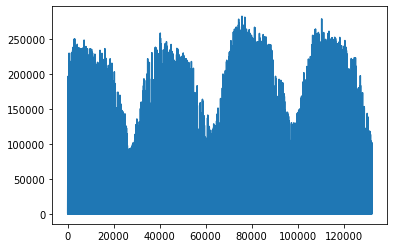

In [750]:
plt.plot(np.linspace(0,len(df3_ordenado)-1,len(df3_ordenado)),df3_ordenado['Energía']) #interpolado

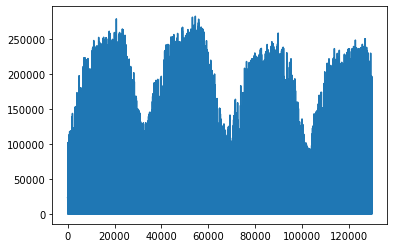

In [751]:
plt.plot(np.linspace(0,len(df2)-1,len(df2)),df2['Energía']) #original

#### Guardamos el dataframe definitivo

In [29]:
PVOutputdf=df3_ordenado
PVOutputdf.to_pickle("PVOutputdftodo.pkl")
output3 = pd.read_pickle("PVOutputdftodo.pkl")
print(output3)

            Fechayhora       Energía Eficiencia      Potencia    Media  \
0       20150309-14:15          1621      0.037         19457        0   
1       20150309-14:30          8048      0.184         25706    25708   
2       20150309-14:45       12807.0      0.293       22371.0  22372.0   
3       20150309-15:00         17566      0.402         19036    19036   
4       20150309-15:15  19023.333333   0.435333  14633.666667  14634.0   
...                ...           ...        ...           ...      ...   
132322  20181216-22:45         23290      0.532             0        0   
132323  20181216-23:00         23290      0.532             0        0   
132324  20181216-23:15         23290      0.532             0        0   
132325  20181216-23:30         23290      0.532             0        0   
132326  20181216-23:45         23290      0.532             0        0   

       Normalizado  
0              0.0  
1            0.588  
2           0.5115  
3            0.435  
4     

#### Cargamos el dataframe 

In [30]:
PVOutputdf = pd.read_pickle("PVOutputdftodo.pkl")
PVOutputdf

,Fechayhora,Energía,Eficiencia,Potencia,Media,Normalizado
0,20150309-14:15,1621,0.037,19457,0,0.0
1,20150309-14:30,8048,0.184,25706,25708,0.588
2,20150309-14:45,12807.0,0.293,22371.0,22372.0,0.5115
3,20150309-15:00,17566,0.402,19036,19036,0.435
4,20150309-15:15,19023.333333,0.435333,14633.666667,14634.0,0.334333
...,...,...,...,...,...,...
132322,20181216-22:45,23290,0.532,0,0,0.0
132323,20181216-23:00,23290,0.532,0,0,0.0
132324,20181216-23:15,23290,0.532,0,0,0.0
132325,20181216-23:30,23290,0.532,0,0,0.0


In [31]:
#Para trabajar más fácil separamos día y hora en dos columnas distintas
PVOutputdf['Fecha'] = PVOutputdf['Fechayhora'].str[0:8]
PVOutputdf['Hora'] = PVOutputdf['Fechayhora'].str[9:]
PVOutputdf

,Fechayhora,Energía,Eficiencia,Potencia,Media,Normalizado,Fecha,Hora
0,20150309-14:15,1621,0.037,19457,0,0.0,20150309,14:15
1,20150309-14:30,8048,0.184,25706,25708,0.588,20150309,14:30
2,20150309-14:45,12807.0,0.293,22371.0,22372.0,0.5115,20150309,14:45
3,20150309-15:00,17566,0.402,19036,19036,0.435,20150309,15:00
4,20150309-15:15,19023.333333,0.435333,14633.666667,14634.0,0.334333,20150309,15:15
...,...,...,...,...,...,...,...,...
132322,20181216-22:45,23290,0.532,0,0,0.0,20181216,22:45
132323,20181216-23:00,23290,0.532,0,0,0.0,20181216,23:00
132324,20181216-23:15,23290,0.532,0,0,0.0,20181216,23:15
132325,20181216-23:30,23290,0.532,0,0,0.0,20181216,23:30


#### Tengo que cambiar a UTC--> Restar 2 horas en horario de verano y 1 en horario de invierno
#### En 2018 cambia el 25/03/2018 y el 28/10/2018, en 2017 cambia el  26/03/2017 y el 29/10/2017 y en 2016 cambia el 27/03/16  y el 30/10/16, en 2015 cambia el  29/03/2015 y el 25/10/2015 todos a las 02:00

In [32]:
#Tiempo de ejecución alto-->1 HORA, se guarda después los datos para no tener que ejecutar este bucle de nuevo.
#Pasamos el string de Datetime a tipo fecha, ahí restarle 1h o 2h dependiendo del horario y luego volver a string.
#Voy a crear dos listas con las fechas del horario de verano y de invierno, de manera que según la fecha esté en una u otra
#se le reste una hora o 2.
date1=datetime(2015,3,29,2,0)
date2=datetime(2015,10,25,2,0)
date3=datetime(2016,3,27,2,0)
date4=datetime(2016,10,30,2,0)
date5=datetime(2017,3,26,2,0)
date6=datetime(2017,10,29,2,0)
date7=datetime(2018,3,25,2,0)
date8=datetime(2018,10,28,2,0)

for i in range(len(PVOutputdf)):
    
    PVOutputdf.iloc[i,0] = datetime.strptime(PVOutputdf.iloc[i,0], '%Y%m%d-%H:%M')#pasamos de string a datetype para poder restarle las horas necesarias
    
    if ((PVOutputdf.iloc[i,0]>date1) and (PVOutputdf.iloc[i,0]<date2)) or ((PVOutputdf.iloc[i,0]>date3) and (PVOutputdf.iloc[i,0]<date4)) or ((PVOutputdf.iloc[i,0]>date5) and (PVOutputdf.iloc[i,0]<date6)) or ((PVOutputdf.iloc[i,0]>date7) and (PVOutputdf.iloc[i,0]<date8)): #horarioverano
        delta=timedelta(hours=2)
        
    else: #horario de invierno
        delta=timedelta(hours=1)
        
    PVOutputdf.iloc[i,0]-=delta
#Observamos que en el cambio de horario de invierno a verano (marzo) se repiten las horas desde la 01:00 hasta 00:15 
#En el cambio de horario de verano a invierno (octubre) se pierden las horas desde las 00:45 hasta las 00:00
#En estas horas la energía siempre vale 0
PVOutputdf #bien ordenado

,Fechayhora,Energía,Eficiencia,Potencia,Media,Normalizado,Fecha,Hora
0,2015-03-09 13:15:00,1621,0.037,19457,0,0.0,20150309,14:15
1,2015-03-09 13:30:00,8048,0.184,25706,25708,0.588,20150309,14:30
2,2015-03-09 13:45:00,12807.0,0.293,22371.0,22372.0,0.5115,20150309,14:45
3,2015-03-09 14:00:00,17566,0.402,19036,19036,0.435,20150309,15:00
4,2015-03-09 14:15:00,19023.333333,0.435333,14633.666667,14634.0,0.334333,20150309,15:15
...,...,...,...,...,...,...,...,...
132322,2018-12-16 21:45:00,23290,0.532,0,0,0.0,20181216,22:45
132323,2018-12-16 22:00:00,23290,0.532,0,0,0.0,20181216,23:00
132324,2018-12-16 22:15:00,23290,0.532,0,0,0.0,20181216,23:15
132325,2018-12-16 22:30:00,23290,0.532,0,0,0.0,20181216,23:30


In [33]:
PVOutputdf.to_pickle("PVOutputdftodohoras.pkl")

In [34]:
PVOutputdf=pd.read_pickle("PVOutputdftodohoras.pkl")
PVOutputdf

,Fechayhora,Energía,Eficiencia,Potencia,Media,Normalizado,Fecha,Hora
0,2015-03-09 13:15:00,1621,0.037,19457,0,0.0,20150309,14:15
1,2015-03-09 13:30:00,8048,0.184,25706,25708,0.588,20150309,14:30
2,2015-03-09 13:45:00,12807.0,0.293,22371.0,22372.0,0.5115,20150309,14:45
3,2015-03-09 14:00:00,17566,0.402,19036,19036,0.435,20150309,15:00
4,2015-03-09 14:15:00,19023.333333,0.435333,14633.666667,14634.0,0.334333,20150309,15:15
...,...,...,...,...,...,...,...,...
132322,2018-12-16 21:45:00,23290,0.532,0,0,0.0,20181216,22:45
132323,2018-12-16 22:00:00,23290,0.532,0,0,0.0,20181216,23:00
132324,2018-12-16 22:15:00,23290,0.532,0,0,0.0,20181216,23:15
132325,2018-12-16 22:30:00,23290,0.532,0,0,0.0,20181216,23:30


In [758]:
date1=datetime(2015,3,29,1,0) #utilizar mayor/menor o IGUAL
date2=datetime(2015,3,29,0,15)
date3=datetime(2015,10,25,0,45)
date4=datetime(2015,10,25,0,0)

date5=datetime(2016,3,27,1,0) #utilizar mayor/menor o IGUAL
date6=datetime(2016,3,27,0,15)
date7=datetime(2016,10,30,0,45)
date8=datetime(2016,10,30,0,0)

date9=datetime(2017,3,26,1,0) #utilizar mayor/menor o IGUAL
date10=datetime(2017,3,26,0,15)
date11=datetime(2017,10,29,0,45)
date12=datetime(2017,10,29,0,0)

date13=datetime(2018,3,25,1,0) #utilizar mayor/menor o IGUAL
date14=datetime(2018,3,25,0,15)
date15=datetime(2018,10,28,0,45)
date16=datetime(2018,10,28,0,0)


In [35]:
filtro=PVOutputdf.duplicated(subset=['Fechayhora'], keep='first')
PVOutputdf.loc[filtro] #podemos eliminar estas directamente y añadir las que faltan
PVOutputdf.drop(PVOutputdf.loc[filtro].index, inplace=True) # De 132327 rows tiene que pasar a 132311 rows
PVOutputdf #lo cumple, bien ordenado

,Fechayhora,Energía,Eficiencia,Potencia,Media,Normalizado,Fecha,Hora
0,2015-03-09 13:15:00,1621,0.037,19457,0,0.0,20150309,14:15
1,2015-03-09 13:30:00,8048,0.184,25706,25708,0.588,20150309,14:30
2,2015-03-09 13:45:00,12807.0,0.293,22371.0,22372.0,0.5115,20150309,14:45
3,2015-03-09 14:00:00,17566,0.402,19036,19036,0.435,20150309,15:00
4,2015-03-09 14:15:00,19023.333333,0.435333,14633.666667,14634.0,0.334333,20150309,15:15
...,...,...,...,...,...,...,...,...
132322,2018-12-16 21:45:00,23290,0.532,0,0,0.0,20181216,22:45
132323,2018-12-16 22:00:00,23290,0.532,0,0,0.0,20181216,23:00
132324,2018-12-16 22:15:00,23290,0.532,0,0,0.0,20181216,23:15
132325,2018-12-16 22:30:00,23290,0.532,0,0,0.0,20181216,23:30


In [36]:
#lista con las fechas que faltan para crear el dataframe
rango15 = (pd.DataFrame(columns=['NULL'],
                  index=pd.date_range('2015-10-25 00:00:00', '2015-10-25 00:45:00',
                                      freq='15T'))
       .index.strftime('%Y%m%d-%H:%M:%S')
     .tolist()
)
rango15.sort(reverse=True)

rango16 = (pd.DataFrame(columns=['NULL'],
                  index=pd.date_range('2016-10-30 00:00:00', '2016-10-30 00:45:00',
                                      freq='15T'))
       .index.strftime('%Y%m%d-%H:%M:%S')
     .tolist()
)
rango16.sort(reverse=True)

rango17 = (pd.DataFrame(columns=['NULL'],
                  index=pd.date_range('2017-10-29 00:00:00', '2017-10-29 00:45:00',
                                      freq='15T'))
       .index.strftime('%Y%m%d-%H:%M:%S')
     .tolist()
)
rango17.sort(reverse=True)

rango18 = (pd.DataFrame(columns=['NULL'],
                  index=pd.date_range('2018-10-28 00:00:00', '2018-10-28 00:45:00',
                                      freq='15T'))
       .index.strftime('%Y%m%d-%H:%M:%S')
     .tolist()
)
rango18.sort(reverse=True)
fechasfaltan=rango18+rango17+rango16+rango15
fechasfaltan

['20181028-00:45:00',
 '20181028-00:30:00',
 '20181028-00:15:00',
 '20181028-00:00:00',
 '20171029-00:45:00',
 '20171029-00:30:00',
 '20171029-00:15:00',
 '20171029-00:00:00',
 '20161030-00:45:00',
 '20161030-00:30:00',
 '20161030-00:15:00',
 '20161030-00:00:00',
 '20151025-00:45:00',
 '20151025-00:30:00',
 '20151025-00:15:00',
 '20151025-00:00:00']

In [37]:
#Creamos el dataframe con las fechas que faltan
dfalt=pd.DataFrame(fechasfaltan,columns=['Fechayhora']) 
dfalt["Energía"]=0
dfalt["Eficiencia"]=0
dfalt["Potencia"]=0
dfalt["Media"]=0
dfalt["Normalizado"]=0

for i in range(len(dfalt)):
    dfalt.iloc[i,0] = datetime.strptime(dfalt.iloc[i,0], '%Y%m%d-%H:%M:%S')#pasamos de string a datetype para poder restarle las horas necesarias

In [46]:
#dataframe con todo
union = [PVOutputdf, dfalt]
PVOutputdef = pd.concat(union)
#df3['Datetime']=df3['Datetime'].tolist()
#df3['Datetime'].sort(reverse=True)
PVOutputdefin=PVOutputdef.sort_values(['Fechayhora']) #antes el sorting lo he hecho con tipo string, si no lo hace bien probarlo
PVOutputdefin.reset_index(drop=True,inplace=True)
PVOutputdefin.drop(columns=["Fecha","Hora"], inplace=True)
PVOutputdefin

,Fechayhora,Energía,Eficiencia,Potencia,Media,Normalizado
0,2015-03-09 13:15:00,1621,0.037,19457,0,0.0
1,2015-03-09 13:30:00,8048,0.184,25706,25708,0.588
2,2015-03-09 13:45:00,12807.0,0.293,22371.0,22372.0,0.5115
3,2015-03-09 14:00:00,17566,0.402,19036,19036,0.435
4,2015-03-09 14:15:00,19023.333333,0.435333,14633.666667,14634.0,0.334333
...,...,...,...,...,...,...
132338,2018-12-16 21:45:00,23290,0.532,0,0,0.0
132339,2018-12-16 22:00:00,23290,0.532,0,0,0.0
132340,2018-12-16 22:15:00,23290,0.532,0,0,0.0
132341,2018-12-16 22:30:00,23290,0.532,0,0,0.0


#### Guardamos los datos definitivos de PVOutput

In [47]:
PVOutputdefin.to_pickle("PVOutputtododefin.pkl")
output4 = pd.read_pickle("PVOutputtododefin.pkl")
output4

,Fechayhora,Energía,Eficiencia,Potencia,Media,Normalizado
0,2015-03-09 13:15:00,1621,0.037,19457,0,0.0
1,2015-03-09 13:30:00,8048,0.184,25706,25708,0.588
2,2015-03-09 13:45:00,12807.0,0.293,22371.0,22372.0,0.5115
3,2015-03-09 14:00:00,17566,0.402,19036,19036,0.435
4,2015-03-09 14:15:00,19023.333333,0.435333,14633.666667,14634.0,0.334333
...,...,...,...,...,...,...
132338,2018-12-16 21:45:00,23290,0.532,0,0,0.0
132339,2018-12-16 22:00:00,23290,0.532,0,0,0.0
132340,2018-12-16 22:15:00,23290,0.532,0,0,0.0
132341,2018-12-16 22:30:00,23290,0.532,0,0,0.0


#### Cargamos datos PVOutput 

In [48]:
PVOutputdf=pd.read_pickle("PVOutputtododefin.pkl")
PVOutputdf

,Fechayhora,Energía,Eficiencia,Potencia,Media,Normalizado
0,2015-03-09 13:15:00,1621,0.037,19457,0,0.0
1,2015-03-09 13:30:00,8048,0.184,25706,25708,0.588
2,2015-03-09 13:45:00,12807.0,0.293,22371.0,22372.0,0.5115
3,2015-03-09 14:00:00,17566,0.402,19036,19036,0.435
4,2015-03-09 14:15:00,19023.333333,0.435333,14633.666667,14634.0,0.334333
...,...,...,...,...,...,...
132338,2018-12-16 21:45:00,23290,0.532,0,0,0.0
132339,2018-12-16 22:00:00,23290,0.532,0,0,0.0
132340,2018-12-16 22:15:00,23290,0.532,0,0,0.0
132341,2018-12-16 22:30:00,23290,0.532,0,0,0.0


### Datos PVGIS

In [369]:
PVGIS_df = pd.read_csv('PVGIS_Solar_Radiation2.csv')
PVGIS_df #Tiene todo 2018 y 2015

,time,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,Int
0,20181231:2310,0.0,0.0,0.0,0.0,6.84,2.41,0.0
1,20181231:2210,0.0,0.0,0.0,0.0,7.08,2.48,0.0
2,20181231:2110,0.0,0.0,0.0,0.0,7.41,2.62,0.0
3,20181231:2010,0.0,0.0,0.0,0.0,7.95,2.55,0.0
4,20181231:1910,0.0,0.0,0.0,0.0,8.73,2.34,0.0
...,...,...,...,...,...,...,...,...
35059,20150101:0410,0.0,0.0,0.0,0.0,5.27,3.66,0.0
35060,20150101:0310,0.0,0.0,0.0,0.0,4.92,3.93,0.0
35061,20150101:0210,0.0,0.0,0.0,0.0,4.87,3.86,0.0
35062,20150101:0110,0.0,0.0,0.0,0.0,4.25,3.45,0.0


#### Guardar datos PVGIS

In [371]:
PVGIS_df.to_pickle("PVGISdf.pkl")
output = pd.read_pickle("PVGISdf.pkl")
print(output)

                time  Gb(i)  Gd(i)  Gr(i)  H_sun   T2m  WS10m  Int
0      20181231:2310    0.0    0.0    0.0    0.0  6.84   2.41  0.0
1      20181231:2210    0.0    0.0    0.0    0.0  7.08   2.48  0.0
2      20181231:2110    0.0    0.0    0.0    0.0  7.41   2.62  0.0
3      20181231:2010    0.0    0.0    0.0    0.0  7.95   2.55  0.0
4      20181231:1910    0.0    0.0    0.0    0.0  8.73   2.34  0.0
...              ...    ...    ...    ...    ...   ...    ...  ...
35059  20150101:0410    0.0    0.0    0.0    0.0  5.27   3.66  0.0
35060  20150101:0310    0.0    0.0    0.0    0.0  4.92   3.93  0.0
35061  20150101:0210    0.0    0.0    0.0    0.0  4.87   3.86  0.0
35062  20150101:0110    0.0    0.0    0.0    0.0  4.25   3.45  0.0
35063  20150101:0010    0.0    0.0    0.0    0.0  4.05   2.69  0.0

[35064 rows x 8 columns]


#### Volver a cargar el dataframe en PVGIS_df

In [372]:
PVGIS_df = pd.read_pickle("PVGISdf.pkl")
PVGIS_df

,time,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,Int
0,20181231:2310,0.0,0.0,0.0,0.0,6.84,2.41,0.0
1,20181231:2210,0.0,0.0,0.0,0.0,7.08,2.48,0.0
2,20181231:2110,0.0,0.0,0.0,0.0,7.41,2.62,0.0
3,20181231:2010,0.0,0.0,0.0,0.0,7.95,2.55,0.0
4,20181231:1910,0.0,0.0,0.0,0.0,8.73,2.34,0.0
...,...,...,...,...,...,...,...,...
35059,20150101:0410,0.0,0.0,0.0,0.0,5.27,3.66,0.0
35060,20150101:0310,0.0,0.0,0.0,0.0,4.92,3.93,0.0
35061,20150101:0210,0.0,0.0,0.0,0.0,4.87,3.86,0.0
35062,20150101:0110,0.0,0.0,0.0,0.0,4.25,3.45,0.0


#### Observamos que la columna Int siempre toma valor 0, por lo que la eliminamos

In [373]:
distinto0= (PVGIS_df['Int']!=0) 
PVGIS_df.loc[distinto0] 
PVGIS_df.drop(['Int'], axis=1, inplace=True)
PVGIS_df

,time,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m
0,20181231:2310,0.0,0.0,0.0,0.0,6.84,2.41
1,20181231:2210,0.0,0.0,0.0,0.0,7.08,2.48
2,20181231:2110,0.0,0.0,0.0,0.0,7.41,2.62
3,20181231:2010,0.0,0.0,0.0,0.0,7.95,2.55
4,20181231:1910,0.0,0.0,0.0,0.0,8.73,2.34
...,...,...,...,...,...,...,...
35059,20150101:0410,0.0,0.0,0.0,0.0,5.27,3.66
35060,20150101:0310,0.0,0.0,0.0,0.0,4.92,3.93
35061,20150101:0210,0.0,0.0,0.0,0.0,4.87,3.86
35062,20150101:0110,0.0,0.0,0.0,0.0,4.25,3.45


#### Comprobamos que no haya huecos

In [375]:
date = (pd.DataFrame(columns=['NULL'],
                  index=pd.date_range('20150101-00:10', '20181231-23:10',
                                      freq='60T'))
       .index.strftime('%Y%m%d-%H:%M')
     .tolist()
)
len(date)-len(PVGIS_df) #Por tanto contiene el mismo número de filas por lo que deberían estar todas las horas

0

#### Lo ponemos en el mismo formato y comparamos que sean iguales, si hay algún false suma al contador

In [9]:
PVGIS_df ["aux"] = PVGIS_df ["time"]
for i in range (len(PVGIS_df)):
    PVGIS_df.iloc[i,8]=PVGIS_df.iloc[i,8][:8]+'-'+PVGIS_df.iloc[i,8][9:11]+':'+PVGIS_df.iloc[i,8][11:]
err=0
if False in (PVGIS_df["aux"]==date):
    err+=1
err #también están todas las fechas

0

In [10]:
PVGIS_df=PVGIS_df.drop(columns="aux")

True

#### No hay huecos, todas las fechas completas

### Interpolamos los datos para obtener radiación cada 5 minutos

#### Interpolación lineal

#### Creo un array del 0 al 26303 (fechas) y le asocio las radiaciones con la función f1.

In [376]:
xip=np.linspace(0,35063,35064)
y1ip=PVGIS_df.iloc[:,1]
f1=interp1d(xip,y1ip)

#### Añado los intervalos de las horas cada 5 mins

In [377]:
xnew=np.linspace(0,35063,12*35064)
y1new=f1(xnew)

#### Hacemos los gráficos para ver que efectivamente tienen la misma forma 

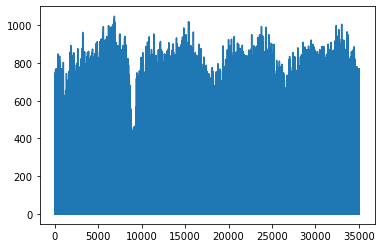

In [105]:
plt.plot(xip,y1ip)

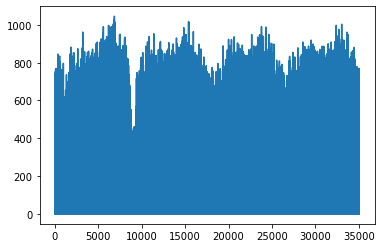

In [111]:
plt.plot(xnew,y1new)

#### Hacemos lo mismo para el resto de datos 

In [379]:
y2ip=PVGIS_df.iloc[:,2]
f2=interp1d(xip,y2ip)
y2new=f2(xnew)

y3ip=PVGIS_df.iloc[:,3]
f3=interp1d(xip,y3ip)
y3new=f3(xnew)

y4ip=PVGIS_df.iloc[:,4]
f4=interp1d(xip,y4ip)
y4new=f4(xnew)

y5ip=PVGIS_df.iloc[:,5]
f5=interp1d(xip,y5ip)
y5new=f5(xnew)

y6ip=PVGIS_df.iloc[:,6]
f6=interp1d(xip,y6ip)
y6new=f6(xnew)

#### Construyo el nuevo Data Frame interpolado

#### En date almaceno todas las fechas cada 5 minutos desde 2016 a 2018 y creo un diccionario con las columnas para crear el DataFrame interpolado.

In [381]:
date = (pd.DataFrame(columns=['NULL'],
                  index=pd.date_range('20150101-00:00:00', '20181231-23:55:00',
                                      freq='5T'))
       .index.strftime('%Y%m%d-%H:%M:%S')
     .tolist()
)
date.sort(reverse=True)
dictio={'Time':date,'Gb(i)':y1new,'Gd(i)':y2new,'Gr(i)':y3new,'H_sun':y4new,'T2m':y5new,'WS10m':y6new }
PVGIS_interp=pd.DataFrame.from_dict(dictio)
PVGIS_interp

,Time,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m
0,20181231-23:55:00,0.0,0.0,0.0,0.0,6.840000,2.410000
1,20181231-23:50:00,0.0,0.0,0.0,0.0,6.859999,2.415833
2,20181231-23:45:00,0.0,0.0,0.0,0.0,6.879999,2.421666
3,20181231-23:40:00,0.0,0.0,0.0,0.0,6.899998,2.427500
4,20181231-23:35:00,0.0,0.0,0.0,0.0,6.919998,2.433333
...,...,...,...,...,...,...,...
420763,20150101-00:20:00,0.0,0.0,0.0,0.0,4.116665,2.943327
420764,20150101-00:15:00,0.0,0.0,0.0,0.0,4.099999,2.879995
420765,20150101-00:10:00,0.0,0.0,0.0,0.0,4.083332,2.816663
420766,20150101-00:05:00,0.0,0.0,0.0,0.0,4.066666,2.753332


#### Comprobación de que todos los datos son float y no hay Nan eso debería asegurar que no hay nada raro. Como hemos comprobado al extraer los datos que no había huecos, ahora solo hay que comprobar que no hay huecos tras interpolar

In [382]:
error=0
for i in range(1, 7, 1):
    
    for j in range (len(PVGIS_interp)):

        if type(PVGIS_interp.iloc[j,i])!=np.float64:
            error+=1
error

0

In [115]:
PVGIS_interp.isnull().values.any()

False

In [383]:
#Eliminamos los datos que no necesitamos: los posteriores al 16/12/18 y los anteriores al 09/03/2015 a las 13:15
#'20160309-13:00:00'<'20150309-13:15:00'
filtro= (PVGIS_interp['Time']<'20150309-13:15:00') | (PVGIS_interp['Time']>'20181216-22:45:00')
PVGIS_interp.loc[filtro] #observamos que las filas seleccionadas son las deseadas
PVGIS_interp.drop(PVGIS_interp.loc[filtro].index, inplace=True) # De 420768 rows tiene que pasar a 396991 rows
PVGISdf_interp=PVGIS_interp.sort_values(['Time'],inplace=True)
PVGIS_interp.reset_index(drop=True,inplace=True)
PVGIS_interp

,Time,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m
0,20150309-13:15:00,759.748741,154.617860,11.894424,40.330913,15.284152,3.327199
1,20150309-13:20:00,753.892228,151.574607,11.767760,39.837592,15.285819,3.362198
2,20150309-13:25:00,748.035714,148.531353,11.641097,39.344272,15.287486,3.397197
3,20150309-13:30:00,742.179200,145.488099,11.514433,38.850951,15.289152,3.432196
4,20150309-13:35:00,736.322687,142.444845,11.387770,38.357631,15.290819,3.467195
...,...,...,...,...,...,...,...
396974,20181216-22:25:00,0.000000,0.000000,0.000000,0.000000,11.574519,4.232818
396975,20181216-22:30:00,0.000000,0.000000,0.000000,0.000000,11.526187,4.169486
396976,20181216-22:35:00,0.000000,0.000000,0.000000,0.000000,11.477855,4.106154
396977,20181216-22:40:00,0.000000,0.000000,0.000000,0.000000,11.429522,4.042823


In [384]:
PVGIS_interp.to_pickle("PVGISdefinitivo.pkl")

In [ ]:
PVGISdf['Tr(i)'] = PVGISdf['Gb(i)'] + PVGISdf['Gd(i)'] + PVGISdf['Gr(i)']
PVGISdf

In [508]:
PVGISdf.to_pickle("PVGISdefinitivo.pkl")

### Lectura datos PVGIS y PVOutput

In [20]:
PVGISdf = pd.read_pickle("PVGISdefinitivo.pkl")
PVGISdf

,Time,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,Tr(i)
0,20150309-13:15:00,759.748741,154.617860,11.894424,40.330913,15.284152,3.327199,926.261025
1,20150309-13:20:00,753.892228,151.574607,11.767760,39.837592,15.285819,3.362198,917.234594
2,20150309-13:25:00,748.035714,148.531353,11.641097,39.344272,15.287486,3.397197,908.208164
3,20150309-13:30:00,742.179200,145.488099,11.514433,38.850951,15.289152,3.432196,899.181733
4,20150309-13:35:00,736.322687,142.444845,11.387770,38.357631,15.290819,3.467195,890.155302
...,...,...,...,...,...,...,...,...
396974,20181216-22:25:00,0.000000,0.000000,0.000000,0.000000,11.574519,4.232818,0.000000
396975,20181216-22:30:00,0.000000,0.000000,0.000000,0.000000,11.526187,4.169486,0.000000
396976,20181216-22:35:00,0.000000,0.000000,0.000000,0.000000,11.477855,4.106154,0.000000
396977,20181216-22:40:00,0.000000,0.000000,0.000000,0.000000,11.429522,4.042823,0.000000


In [21]:
PVOutputdf=pd.read_pickle("PVOutputtododefin.pkl")
PVOutputdf

,Fechayhora,Energía,Eficiencia,Potencia,Media,Normalizado
0,2015-03-09 13:15:00,1621,0.037,19457,0,0.0
1,2015-03-09 13:30:00,8048,0.184,25706,25708,0.588
2,2015-03-09 13:45:00,12807.0,0.293,22371.0,22372.0,0.5115
3,2015-03-09 14:00:00,17566,0.402,19036,19036,0.435
4,2015-03-09 14:15:00,19023.333333,0.435333,14633.666667,14634.0,0.334333
...,...,...,...,...,...,...
132338,2018-12-16 21:45:00,23290,0.532,0,0,0.0
132339,2018-12-16 22:00:00,23290,0.532,0,0,0.0
132340,2018-12-16 22:15:00,23290,0.532,0,0,0.0
132341,2018-12-16 22:30:00,23290,0.532,0,0,0.0


## Construcción de Redes Neuronales Convolucionales

## Modelo 13 del artículo: stratified layer, two hidden layers, and decomposed radiation

### Modelo 1. 12 entradas de la radiación: datos de radiación de una hora (12x5 mins) y producción de los primeros 15 mins

In [530]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3)#tamaño 3 en principio (tipos de radiación) uno de cada 12, las horas exactas 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)
#Capas ocultas (1 neurona)
oculta1 = tf.keras.layers.Dense(1, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(1, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(1, activation="relu")(entrada3)
oculta4 = tf.keras.layers.Dense(1, activation="relu")(entrada4)
oculta5 = tf.keras.layers.Dense(1, activation="relu")(entrada5)
oculta6 = tf.keras.layers.Dense(1, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(1, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(1, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(1, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(1, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(1, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(1, activation="relu")(entrada12)
concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12]) #estratificada, concatena las 12
#2 layers intermedias, no sabemos con cuántas neuronas: siguiendo la primera formula 2/3*(1+1)
adoculta1=tf.keras.layers.Dense(1, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(1, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(1, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo1 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12], outputs=[salida])
modelo1.summary()

Model: "model_64"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1738 (InputLayer)        [(None, 3)]          0           []                               
                                                                                                  
 input_1739 (InputLayer)        [(None, 3)]          0           []                               
                                                                                                  
 input_1740 (InputLayer)        [(None, 3)]          0           []                               
                                                                                                  
 input_1741 (InputLayer)        [(None, 3)]          0           []                               
                                                                                           

In [531]:
modelo1.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas

#### En X_train meto 12 arrays (de tres dimensiones cada uno que reflejan las radiaciones) que son mis entradas. Tomando la primera entrada de cada array tengo los datos de radiación de una hora entera y como cada uno tiene 10 valores tengo 10 horas de radiación solar. En y_train meto 10 valores de producción solar correspondientes a las 10 horas que estoy prediciendo.

In [532]:
X_train1=np.array(PVGISdf.iloc[0:10,1:4]) #en este caso mi primer valor es a las 13:15 
X_train2=np.array(PVGISdf.iloc[1:11,1:4])
X_train3=np.array(PVGISdf.iloc[2:12,1:4]) 
X_train4=np.array(PVGISdf.iloc[3:13,1:4])
X_train5=np.array(PVGISdf.iloc[4:14,1:4])
X_train6=np.array(PVGISdf.iloc[5:15,1:4])
X_train7=np.array(PVGISdf.iloc[6:16,1:4]) 
X_train8=np.array(PVGISdf.iloc[7:17,1:4])
X_train9=np.array(PVGISdf.iloc[8:18,1:4]) 
X_train10=np.array(PVGISdf.iloc[9:19,1:4])
X_train11=np.array(PVGISdf.iloc[10:20,1:4])
X_train12=np.array(PVGISdf.iloc[11:21,1:4])
y_train=np.array(PVOutputdf.iloc[5:15,1]).astype(float) #-->valores de la producción en los 10 primeros 15 minutos.MSE=439787424; MAE=18931.3008 
#y_train=np.array(PVOutputdf.iloc[0:40:4,1]).astype(float) #valores de la producción cada hora que pasa. MAE=34483.8359 
#X_train=np.reshape(X_train,(12,1,3))
#y_train=np.array(y_train).astype(float)
#y_train=y_train.astype(float)

In [533]:
history = modelo1.fit((X_train1,X_train2,X_train3,X_train4,X_train5,X_train6,X_train7,X_train8,X_train9,X_train10,X_train11,X_train12), y_train, epochs=30)

Epoch 1/30
1/1 [==============================] - 1s 1s/step - loss: 1102200832.0000 - mae: 32393.0664
Epoch 2/30
1/1 [==============================] - 0s 5ms/step - loss: 1102200704.0000 - mae: 32393.0664
Epoch 3/30
1/1 [==============================] - 0s 5ms/step - loss: 1102200704.0000 - mae: 32393.0664
Epoch 4/30
1/1 [==============================] - 0s 6ms/step - loss: 1102200576.0000 - mae: 32393.0664
Epoch 5/30
1/1 [==============================] - 0s 5ms/step - loss: 1102200704.0000 - mae: 32393.0664
Epoch 6/30
1/1 [==============================] - 0s 6ms/step - loss: 1102200832.0000 - mae: 32393.0664
Epoch 7/30
1/1 [==============================] - 0s 7ms/step - loss: 1102200704.0000 - mae: 32393.0664
Epoch 8/30
1/1 [==============================] - 0s 6ms/step - loss: 1102200832.0000 - mae: 32393.0664
Epoch 9/30
1/1 [==============================] - 0s 7ms/step - loss: 1102200704.0000 - mae: 32393.0664
Epoch 10/30
1/1 [==============================] - 0s 6ms/step - 

### Modelo 2--> 4 entradas introduciendo datos de la radiación cada 15 minutos.

In [534]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3)#tamaño 3 en principio (tipos de radiación) uno de cada 4, las horas exactas cogiendo datos cada 15 mins 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)

#Capas ocultas (1 neurona)
oculta1 = tf.keras.layers.Dense(1, activation="relu")(entrada1)  #Necesitaria 4 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(1, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(1, activation="relu")(entrada3)
oculta4 = tf.keras.layers.Dense(1, activation="relu")(entrada4)

concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4]) #estratificada, concatena las 4
#2 layers intermedias, no sabemos con cuántas neuronas: siguiendo la primera formula 2/3*(1+1)
adoculta1=tf.keras.layers.Dense(1, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(1, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(1, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo2 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4], outputs=[salida])
modelo2.summary()

Model: "model_65"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1750 (InputLayer)        [(None, 3)]          0           []                               
                                                                                                  
 input_1751 (InputLayer)        [(None, 3)]          0           []                               
                                                                                                  
 input_1752 (InputLayer)        [(None, 3)]          0           []                               
                                                                                                  
 input_1753 (InputLayer)        [(None, 3)]          0           []                               
                                                                                           

In [535]:
modelo2.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas

In [536]:
X_train1=np.array(PVGISdf.iloc[0:12:3,1:4]) #en este caso mi primer valor es a las 13:15 
X_train2=np.array(PVGISdf.iloc[3:15:3,1:4])
X_train3=np.array(PVGISdf.iloc[6:18:3,1:4]) 
X_train4=np.array(PVGISdf.iloc[9:21:3,1:4])


#y_train=np.array(PVOutputdf.iloc[0:12:3,1]).astype(float) Entrena bastante, pasa de un MSE de 295,071,712 a 8,486,229  y un MAE de 15097.2549 a 2393.41
y_train=np.array(PVOutputdf.iloc[4:8,1]).astype(float) #como debería ser. Pasa de un MSE de 96,290,296 a 541,803  y un MAE de 8455.2744 a 669.3677 en 4821 épocas

In [537]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,restore_best_weights=True)

In [538]:
history = modelo2.fit((X_train1,X_train2,X_train3,X_train4), y_train, epochs=10000,callbacks=[callback]) #este sí que entrena

Epoch 1/10000
1/1 [==============================] - 12s 12s/step - loss: 476740448.0000 - mae: 21687.5996
Epoch 2/10000
1/1 [==============================] - 0s 7ms/step - loss: 476689504.0000 - mae: 21686.4023
Epoch 3/10000
1/1 [==============================] - 0s 6ms/step - loss: 476638336.0000 - mae: 21685.1992
Epoch 4/10000
1/1 [==============================] - 0s 7ms/step - loss: 476586752.0000 - mae: 21683.9863
Epoch 5/10000
1/1 [==============================] - 0s 6ms/step - loss: 476534944.0000 - mae: 21682.7676
Epoch 6/10000
1/1 [==============================] - 0s 7ms/step - loss: 476482816.0000 - mae: 21681.5410
Epoch 7/10000
1/1 [==============================] - 0s 6ms/step - loss: 476430400.0000 - mae: 21680.3086
Epoch 8/10000
1/1 [==============================] - 0s 8ms/step - loss: 476377568.0000 - mae: 21679.0684
Epoch 9/10000
1/1 [==============================] - 0s 7ms/step - loss: 476324416.0000 - mae: 21677.8184
Epoch 10/10000
1/1 [=========================

1/1 [==============================] - 0s 7ms/step - loss: 462777920.0000 - mae: 21357.2910
Epoch 154/10000
1/1 [==============================] - 0s 6ms/step - loss: 462624064.0000 - mae: 21353.6270
Epoch 155/10000
1/1 [==============================] - 0s 8ms/step - loss: 462469056.0000 - mae: 21349.9336
Epoch 156/10000
1/1 [==============================] - 0s 7ms/step - loss: 462312864.0000 - mae: 21346.2129
Epoch 157/10000
1/1 [==============================] - 0s 41ms/step - loss: 462155424.0000 - mae: 21342.4609
Epoch 158/10000
1/1 [==============================] - 0s 20ms/step - loss: 461996736.0000 - mae: 21338.6797
Epoch 159/10000
1/1 [==============================] - 0s 7ms/step - loss: 461836864.0000 - mae: 21334.8672
Epoch 160/10000
1/1 [==============================] - 0s 7ms/step - loss: 461675680.0000 - mae: 21331.0234
Epoch 161/10000
1/1 [==============================] - 0s 7ms/step - loss: 461513280.0000 - mae: 21327.1523
Epoch 162/10000
1/1 [=====================

Epoch 229/10000
1/1 [==============================] - 0s 6ms/step - loss: 446920576.0000 - mae: 20976.5391
Epoch 230/10000
1/1 [==============================] - 0s 7ms/step - loss: 446645600.0000 - mae: 20969.8789
Epoch 231/10000
1/1 [==============================] - 0s 5ms/step - loss: 446368640.0000 - mae: 20963.1699
Epoch 232/10000
1/1 [==============================] - 0s 8ms/step - loss: 446089664.0000 - mae: 20956.4082
Epoch 233/10000
1/1 [==============================] - 0s 8ms/step - loss: 445808672.0000 - mae: 20949.5977
Epoch 234/10000
1/1 [==============================] - 0s 7ms/step - loss: 445525760.0000 - mae: 20942.7363
Epoch 235/10000
1/1 [==============================] - 0s 7ms/step - loss: 445240768.0000 - mae: 20935.8242
Epoch 236/10000
1/1 [==============================] - 0s 9ms/step - loss: 444953760.0000 - mae: 20928.8594
Epoch 237/10000
1/1 [==============================] - 0s 7ms/step - loss: 444664704.0000 - mae: 20921.8457
Epoch 238/10000
1/1 [=======

Epoch 380/10000
1/1 [==============================] - 0s 6ms/step - loss: 378131520.0000 - mae: 19239.6523
Epoch 381/10000
1/1 [==============================] - 0s 5ms/step - loss: 377467776.0000 - mae: 19222.1250
Epoch 382/10000
1/1 [==============================] - 0s 5ms/step - loss: 376801152.0000 - mae: 19204.5059
Epoch 383/10000
1/1 [==============================] - 0s 7ms/step - loss: 376131616.0000 - mae: 19186.7930
Epoch 384/10000
1/1 [==============================] - 0s 6ms/step - loss: 375459168.0000 - mae: 19168.9844
Epoch 385/10000
1/1 [==============================] - 0s 5ms/step - loss: 374783808.0000 - mae: 19151.0840
Epoch 386/10000
1/1 [==============================] - 0s 6ms/step - loss: 374105472.0000 - mae: 19133.0898
Epoch 387/10000
1/1 [==============================] - 0s 9ms/step - loss: 373424256.0000 - mae: 19114.9961
Epoch 388/10000
1/1 [==============================] - 0s 7ms/step - loss: 372740160.0000 - mae: 19096.8125
Epoch 389/10000
1/1 [=======

Epoch 531/10000
1/1 [==============================] - 0s 6ms/step - loss: 248674896.0000 - mae: 15441.6055
Epoch 532/10000
1/1 [==============================] - 0s 8ms/step - loss: 247673152.0000 - mae: 15408.4814
Epoch 533/10000
1/1 [==============================] - 0s 6ms/step - loss: 246670608.0000 - mae: 15375.2578
Epoch 534/10000
1/1 [==============================] - 0s 7ms/step - loss: 245667248.0000 - mae: 15341.9336
Epoch 535/10000
1/1 [==============================] - 0s 6ms/step - loss: 244663072.0000 - mae: 15308.5059
Epoch 536/10000
1/1 [==============================] - 0s 6ms/step - loss: 243658144.0000 - mae: 15274.9795
Epoch 537/10000
1/1 [==============================] - 0s 7ms/step - loss: 242652496.0000 - mae: 15241.3535
Epoch 538/10000
1/1 [==============================] - 0s 6ms/step - loss: 241646096.0000 - mae: 15207.6270
Epoch 539/10000
1/1 [==============================] - 0s 8ms/step - loss: 240639072.0000 - mae: 15173.8008
Epoch 540/10000
1/1 [=======

1/1 [==============================] - 0s 6ms/step - loss: 105221920.0000 - mae: 9551.8613
Epoch 683/10000
1/1 [==============================] - 0s 8ms/step - loss: 104443560.0000 - mae: 9509.5439
Epoch 684/10000
1/1 [==============================] - 0s 7ms/step - loss: 103668832.0000 - mae: 9467.2275
Epoch 685/10000
1/1 [==============================] - 0s 7ms/step - loss: 102897840.0000 - mae: 9424.9189
Epoch 686/10000
1/1 [==============================] - 0s 6ms/step - loss: 102130520.0000 - mae: 9382.6152
Epoch 687/10000
1/1 [==============================] - 0s 8ms/step - loss: 101366944.0000 - mae: 9340.3184
Epoch 688/10000
1/1 [==============================] - 0s 6ms/step - loss: 100607072.0000 - mae: 9298.0273
Epoch 689/10000
1/1 [==============================] - 0s 6ms/step - loss: 99850992.0000 - mae: 9255.7480
Epoch 690/10000
1/1 [==============================] - 0s 6ms/step - loss: 99098704.0000 - mae: 9213.4795
Epoch 691/10000
1/1 [==============================] - 

1/1 [==============================] - 0s 17ms/step - loss: 32189026.0000 - mae: 4192.7490
Epoch 837/10000
1/1 [==============================] - 0s 17ms/step - loss: 31994330.0000 - mae: 4179.7134
Epoch 838/10000
1/1 [==============================] - 0s 16ms/step - loss: 31802372.0000 - mae: 4166.7520
Epoch 839/10000
1/1 [==============================] - 0s 8ms/step - loss: 31613022.0000 - mae: 4153.8555
Epoch 840/10000
1/1 [==============================] - 0s 8ms/step - loss: 31426322.0000 - mae: 4141.0322
Epoch 841/10000
1/1 [==============================] - 0s 9ms/step - loss: 31242200.0000 - mae: 4128.2759
Epoch 842/10000
1/1 [==============================] - 0s 10ms/step - loss: 31060662.0000 - mae: 4115.5889
Epoch 843/10000
1/1 [==============================] - 0s 16ms/step - loss: 30881664.0000 - mae: 4102.9707
Epoch 844/10000
1/1 [==============================] - 0s 9ms/step - loss: 30705208.0000 - mae: 4090.4231
Epoch 845/10000
1/1 [==============================] - 0s

1/1 [==============================] - 0s 19ms/step - loss: 23301844.0000 - mae: 3758.8926
Epoch 914/10000
1/1 [==============================] - 0s 16ms/step - loss: 23246008.0000 - mae: 3760.1392
Epoch 915/10000
1/1 [==============================] - 0s 17ms/step - loss: 23191202.0000 - mae: 3761.3755
Epoch 916/10000
1/1 [==============================] - 0s 8ms/step - loss: 23137408.0000 - mae: 3762.6006
Epoch 917/10000
1/1 [==============================] - 0s 8ms/step - loss: 23084604.0000 - mae: 3763.8154
Epoch 918/10000
1/1 [==============================] - 0s 17ms/step - loss: 23032768.0000 - mae: 3765.0171
Epoch 919/10000
1/1 [==============================] - 0s 9ms/step - loss: 22981910.0000 - mae: 3766.2100
Epoch 920/10000
1/1 [==============================] - 0s 7ms/step - loss: 22931994.0000 - mae: 3767.3901
Epoch 921/10000
1/1 [==============================] - 0s 26ms/step - loss: 22882994.0000 - mae: 3768.5596
Epoch 922/10000
1/1 [==============================] - 0s

1/1 [==============================] - 0s 7ms/step - loss: 21053090.0000 - mae: 3825.8394
Epoch 991/10000
1/1 [==============================] - 0s 7ms/step - loss: 21041148.0000 - mae: 3826.3784
Epoch 992/10000
1/1 [==============================] - 0s 7ms/step - loss: 21029458.0000 - mae: 3826.9102
Epoch 993/10000
1/1 [==============================] - 0s 6ms/step - loss: 21017996.0000 - mae: 3827.4341
Epoch 994/10000
1/1 [==============================] - 0s 8ms/step - loss: 21006770.0000 - mae: 3827.9517
Epoch 995/10000
1/1 [==============================] - 0s 7ms/step - loss: 20995788.0000 - mae: 3828.4639
Epoch 996/10000
1/1 [==============================] - 0s 9ms/step - loss: 20985024.0000 - mae: 3828.9668
Epoch 997/10000
1/1 [==============================] - 0s 6ms/step - loss: 20974486.0000 - mae: 3829.4658
Epoch 998/10000
1/1 [==============================] - 0s 7ms/step - loss: 20964164.0000 - mae: 3829.9565
Epoch 999/10000
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 6ms/step - loss: 20442340.0000 - mae: 3855.0239
Epoch 1143/10000
1/1 [==============================] - 0s 8ms/step - loss: 20440964.0000 - mae: 3855.0073
Epoch 1144/10000
1/1 [==============================] - 0s 7ms/step - loss: 20439590.0000 - mae: 3854.9888
Epoch 1145/10000
1/1 [==============================] - 0s 8ms/step - loss: 20438212.0000 - mae: 3854.9673
Epoch 1146/10000
1/1 [==============================] - 0s 9ms/step - loss: 20436840.0000 - mae: 3854.9453
Epoch 1147/10000
1/1 [==============================] - 0s 9ms/step - loss: 20435486.0000 - mae: 3854.9229
Epoch 1148/10000
1/1 [==============================] - 0s 7ms/step - loss: 20434126.0000 - mae: 3854.8984
Epoch 1149/10000
1/1 [==============================] - 0s 7ms/step - loss: 20432770.0000 - mae: 3854.8726
Epoch 1150/10000
1/1 [==============================] - 0s 7ms/step - loss: 20431422.0000 - mae: 3854.8457
Epoch 1151/10000
1/1 [==============================] 

1/1 [==============================] - 0s 8ms/step - loss: 20248888.0000 - mae: 3842.8247
Epoch 1295/10000
1/1 [==============================] - 0s 6ms/step - loss: 20247604.0000 - mae: 3842.7090
Epoch 1296/10000
1/1 [==============================] - 0s 6ms/step - loss: 20246324.0000 - mae: 3842.5942
Epoch 1297/10000
1/1 [==============================] - 0s 6ms/step - loss: 20245036.0000 - mae: 3842.4780
Epoch 1298/10000
1/1 [==============================] - 0s 7ms/step - loss: 20243762.0000 - mae: 3842.3628
Epoch 1299/10000
1/1 [==============================] - 0s 8ms/step - loss: 20242484.0000 - mae: 3842.2480
Epoch 1300/10000
1/1 [==============================] - 0s 8ms/step - loss: 20241184.0000 - mae: 3842.1299
Epoch 1301/10000
1/1 [==============================] - 0s 8ms/step - loss: 20239912.0000 - mae: 3842.0142
Epoch 1302/10000
1/1 [==============================] - 0s 7ms/step - loss: 20238622.0000 - mae: 3841.8975
Epoch 1303/10000
1/1 [==============================] 

1/1 [==============================] - 0s 6ms/step - loss: 20046766.0000 - mae: 3823.5928
Epoch 1447/10000
1/1 [==============================] - 0s 7ms/step - loss: 20045374.0000 - mae: 3823.4570
Epoch 1448/10000
1/1 [==============================] - 0s 7ms/step - loss: 20044000.0000 - mae: 3823.3232
Epoch 1449/10000
1/1 [==============================] - 0s 7ms/step - loss: 20042616.0000 - mae: 3823.1875
Epoch 1450/10000
1/1 [==============================] - 0s 6ms/step - loss: 20041224.0000 - mae: 3823.0522
Epoch 1451/10000
1/1 [==============================] - 0s 6ms/step - loss: 20039852.0000 - mae: 3822.9185
Epoch 1452/10000
1/1 [==============================] - 0s 6ms/step - loss: 20038458.0000 - mae: 3822.7817
Epoch 1453/10000
1/1 [==============================] - 0s 8ms/step - loss: 20037084.0000 - mae: 3822.6475
Epoch 1454/10000
1/1 [==============================] - 0s 6ms/step - loss: 20035690.0000 - mae: 3822.5117
Epoch 1455/10000
1/1 [==============================] 

1/1 [==============================] - 0s 6ms/step - loss: 19829376.0000 - mae: 3802.2368
Epoch 1599/10000
1/1 [==============================] - 0s 7ms/step - loss: 19827904.0000 - mae: 3802.0923
Epoch 1600/10000
1/1 [==============================] - 0s 6ms/step - loss: 19826408.0000 - mae: 3801.9448
Epoch 1601/10000
1/1 [==============================] - 0s 7ms/step - loss: 19824926.0000 - mae: 3801.7983
Epoch 1602/10000
1/1 [==============================] - 0s 6ms/step - loss: 19823446.0000 - mae: 3801.6523
Epoch 1603/10000
1/1 [==============================] - 0s 9ms/step - loss: 19821960.0000 - mae: 3801.5063
Epoch 1604/10000
1/1 [==============================] - 0s 6ms/step - loss: 19820484.0000 - mae: 3801.3599
Epoch 1605/10000
1/1 [==============================] - 0s 6ms/step - loss: 19819006.0000 - mae: 3801.2148
Epoch 1606/10000
1/1 [==============================] - 0s 6ms/step - loss: 19817510.0000 - mae: 3801.0669
Epoch 1607/10000
1/1 [==============================] 

1/1 [==============================] - 0s 6ms/step - loss: 19597026.0000 - mae: 3779.2373
Epoch 1751/10000
1/1 [==============================] - 0s 7ms/step - loss: 19595444.0000 - mae: 3779.0801
Epoch 1752/10000
1/1 [==============================] - 0s 7ms/step - loss: 19593880.0000 - mae: 3778.9248
Epoch 1753/10000
1/1 [==============================] - 0s 6ms/step - loss: 19592294.0000 - mae: 3778.7676
Epoch 1754/10000
1/1 [==============================] - 0s 6ms/step - loss: 19590704.0000 - mae: 3778.6094
Epoch 1755/10000
1/1 [==============================] - 0s 6ms/step - loss: 19589124.0000 - mae: 3778.4521
Epoch 1756/10000
1/1 [==============================] - 0s 7ms/step - loss: 19587550.0000 - mae: 3778.2959
Epoch 1757/10000
1/1 [==============================] - 0s 6ms/step - loss: 19585972.0000 - mae: 3778.1387
Epoch 1758/10000
1/1 [==============================] - 0s 8ms/step - loss: 19584388.0000 - mae: 3777.9814
Epoch 1759/10000
1/1 [==============================] 

1/1 [==============================] - 0s 7ms/step - loss: 19350136.0000 - mae: 3754.6309
Epoch 1903/10000
1/1 [==============================] - 0s 5ms/step - loss: 19348476.0000 - mae: 3754.4644
Epoch 1904/10000
1/1 [==============================] - 0s 6ms/step - loss: 19346780.0000 - mae: 3754.2949
Epoch 1905/10000
1/1 [==============================] - 0s 7ms/step - loss: 19345124.0000 - mae: 3754.1294
Epoch 1906/10000
1/1 [==============================] - 0s 7ms/step - loss: 19343446.0000 - mae: 3753.9614
Epoch 1907/10000
1/1 [==============================] - 0s 7ms/step - loss: 19341780.0000 - mae: 3753.7944
Epoch 1908/10000
1/1 [==============================] - 0s 6ms/step - loss: 19340092.0000 - mae: 3753.6255
Epoch 1909/10000
1/1 [==============================] - 0s 7ms/step - loss: 19338422.0000 - mae: 3753.4590
Epoch 1910/10000
1/1 [==============================] - 0s 7ms/step - loss: 19336734.0000 - mae: 3753.2896
Epoch 1911/10000
1/1 [==============================] 

1/1 [==============================] - 0s 6ms/step - loss: 19089148.0000 - mae: 3728.4312
Epoch 2055/10000
1/1 [==============================] - 0s 7ms/step - loss: 19087384.0000 - mae: 3728.2534
Epoch 2056/10000
1/1 [==============================] - 0s 6ms/step - loss: 19085630.0000 - mae: 3728.0767
Epoch 2057/10000
1/1 [==============================] - 0s 7ms/step - loss: 19083866.0000 - mae: 3727.8989
Epoch 2058/10000
1/1 [==============================] - 0s 6ms/step - loss: 19082110.0000 - mae: 3727.7222
Epoch 2059/10000
1/1 [==============================] - 0s 6ms/step - loss: 19080336.0000 - mae: 3727.5435
Epoch 2060/10000
1/1 [==============================] - 0s 6ms/step - loss: 19078564.0000 - mae: 3727.3643
Epoch 2061/10000
1/1 [==============================] - 0s 8ms/step - loss: 19076808.0000 - mae: 3727.1870
Epoch 2062/10000
1/1 [==============================] - 0s 6ms/step - loss: 19075042.0000 - mae: 3727.0093
Epoch 2063/10000
1/1 [==============================] 

1/1 [==============================] - 0s 6ms/step - loss: 18814622.0000 - mae: 3700.6602
Epoch 2207/10000
1/1 [==============================] - 0s 6ms/step - loss: 18812772.0000 - mae: 3700.4722
Epoch 2208/10000
1/1 [==============================] - 0s 7ms/step - loss: 18810924.0000 - mae: 3700.2842
Epoch 2209/10000
1/1 [==============================] - 0s 8ms/step - loss: 18809062.0000 - mae: 3700.0952
Epoch 2210/10000
1/1 [==============================] - 0s 6ms/step - loss: 18807224.0000 - mae: 3699.9082
Epoch 2211/10000
1/1 [==============================] - 0s 6ms/step - loss: 18805360.0000 - mae: 3699.7197
Epoch 2212/10000
1/1 [==============================] - 0s 6ms/step - loss: 18803518.0000 - mae: 3699.5317
Epoch 2213/10000
1/1 [==============================] - 0s 7ms/step - loss: 18801662.0000 - mae: 3699.3433
Epoch 2214/10000
1/1 [==============================] - 0s 7ms/step - loss: 18799802.0000 - mae: 3699.1553
Epoch 2215/10000
1/1 [==============================] 

1/1 [==============================] - 0s 6ms/step - loss: 18527124.0000 - mae: 3671.3394
Epoch 2359/10000
1/1 [==============================] - 0s 6ms/step - loss: 18525212.0000 - mae: 3671.1440
Epoch 2360/10000
1/1 [==============================] - 0s 6ms/step - loss: 18523260.0000 - mae: 3670.9438
Epoch 2361/10000
1/1 [==============================] - 0s 5ms/step - loss: 18521326.0000 - mae: 3670.7461
Epoch 2362/10000
1/1 [==============================] - 0s 6ms/step - loss: 18519400.0000 - mae: 3670.5488
Epoch 2363/10000
1/1 [==============================] - 0s 6ms/step - loss: 18517468.0000 - mae: 3670.3506
Epoch 2364/10000
1/1 [==============================] - 0s 6ms/step - loss: 18515534.0000 - mae: 3670.1528
Epoch 2365/10000
1/1 [==============================] - 0s 6ms/step - loss: 18513592.0000 - mae: 3669.9531
Epoch 2366/10000
1/1 [==============================] - 0s 6ms/step - loss: 18511666.0000 - mae: 3669.7568
Epoch 2367/10000
1/1 [==============================] 

1/1 [==============================] - 0s 6ms/step - loss: 18227392.0000 - mae: 3640.5044
Epoch 2511/10000
1/1 [==============================] - 0s 6ms/step - loss: 18225390.0000 - mae: 3640.2969
Epoch 2512/10000
1/1 [==============================] - 0s 5ms/step - loss: 18223374.0000 - mae: 3640.0889
Epoch 2513/10000
1/1 [==============================] - 0s 6ms/step - loss: 18221358.0000 - mae: 3639.8799
Epoch 2514/10000
1/1 [==============================] - 0s 6ms/step - loss: 18219354.0000 - mae: 3639.6733
Epoch 2515/10000
1/1 [==============================] - 0s 6ms/step - loss: 18217342.0000 - mae: 3639.4658
Epoch 2516/10000
1/1 [==============================] - 0s 6ms/step - loss: 18215326.0000 - mae: 3639.2568
Epoch 2517/10000
1/1 [==============================] - 0s 6ms/step - loss: 18213310.0000 - mae: 3639.0483
Epoch 2518/10000
1/1 [==============================] - 0s 7ms/step - loss: 18211298.0000 - mae: 3638.8403
Epoch 2519/10000
1/1 [==============================] 

1/1 [==============================] - 0s 7ms/step - loss: 17916212.0000 - mae: 3608.1953
Epoch 2663/10000
1/1 [==============================] - 0s 7ms/step - loss: 17914122.0000 - mae: 3607.9766
Epoch 2664/10000
1/1 [==============================] - 0s 7ms/step - loss: 17912038.0000 - mae: 3607.7593
Epoch 2665/10000
1/1 [==============================] - 0s 6ms/step - loss: 17909948.0000 - mae: 3607.5415
Epoch 2666/10000
1/1 [==============================] - 0s 7ms/step - loss: 17907862.0000 - mae: 3607.3242
Epoch 2667/10000
1/1 [==============================] - 0s 8ms/step - loss: 17905784.0000 - mae: 3607.1074
Epoch 2668/10000
1/1 [==============================] - 0s 5ms/step - loss: 17903698.0000 - mae: 3606.8896
Epoch 2669/10000
1/1 [==============================] - 0s 7ms/step - loss: 17901606.0000 - mae: 3606.6714
Epoch 2670/10000
1/1 [==============================] - 0s 7ms/step - loss: 17899532.0000 - mae: 3606.4541
Epoch 2671/10000
1/1 [==============================] 

1/1 [==============================] - 0s 7ms/step - loss: 17594444.0000 - mae: 3574.4639
Epoch 2815/10000
1/1 [==============================] - 0s 8ms/step - loss: 17592302.0000 - mae: 3574.2383
Epoch 2816/10000
1/1 [==============================] - 0s 6ms/step - loss: 17590148.0000 - mae: 3574.0117
Epoch 2817/10000
1/1 [==============================] - 0s 6ms/step - loss: 17588010.0000 - mae: 3573.7866
Epoch 2818/10000
1/1 [==============================] - 0s 6ms/step - loss: 17585856.0000 - mae: 3573.5596
Epoch 2819/10000
1/1 [==============================] - 0s 8ms/step - loss: 17583700.0000 - mae: 3573.3330
Epoch 2820/10000
1/1 [==============================] - 0s 6ms/step - loss: 17581546.0000 - mae: 3573.1055
Epoch 2821/10000
1/1 [==============================] - 0s 6ms/step - loss: 17579400.0000 - mae: 3572.8789
Epoch 2822/10000
1/1 [==============================] - 0s 7ms/step - loss: 17577248.0000 - mae: 3572.6523
Epoch 2823/10000
1/1 [==============================] 

1/1 [==============================] - 0s 8ms/step - loss: 17263148.0000 - mae: 3539.3809
Epoch 2967/10000
1/1 [==============================] - 0s 9ms/step - loss: 17260932.0000 - mae: 3539.1450
Epoch 2968/10000
1/1 [==============================] - 0s 7ms/step - loss: 17258720.0000 - mae: 3538.9087
Epoch 2969/10000
1/1 [==============================] - 0s 7ms/step - loss: 17256508.0000 - mae: 3538.6738
Epoch 2970/10000
1/1 [==============================] - 0s 7ms/step - loss: 17254302.0000 - mae: 3538.4395
Epoch 2971/10000
1/1 [==============================] - 0s 7ms/step - loss: 17252100.0000 - mae: 3538.2046
Epoch 2972/10000
1/1 [==============================] - 0s 7ms/step - loss: 17249870.0000 - mae: 3537.9668
Epoch 2973/10000
1/1 [==============================] - 0s 5ms/step - loss: 17247686.0000 - mae: 3537.7344
Epoch 2974/10000
1/1 [==============================] - 0s 6ms/step - loss: 17245460.0000 - mae: 3537.4976
Epoch 2975/10000
1/1 [==============================] 

1/1 [==============================] - 0s 7ms/step - loss: 16923396.0000 - mae: 3503.0181
Epoch 3119/10000
1/1 [==============================] - 0s 6ms/step - loss: 16921128.0000 - mae: 3502.7744
Epoch 3120/10000
1/1 [==============================] - 0s 5ms/step - loss: 16918852.0000 - mae: 3502.5293
Epoch 3121/10000
1/1 [==============================] - 0s 7ms/step - loss: 16916604.0000 - mae: 3502.2871
Epoch 3122/10000
1/1 [==============================] - 0s 6ms/step - loss: 16914338.0000 - mae: 3502.0435
Epoch 3123/10000
1/1 [==============================] - 0s 6ms/step - loss: 16912080.0000 - mae: 3501.7998
Epoch 3124/10000
1/1 [==============================] - 0s 6ms/step - loss: 16909820.0000 - mae: 3501.5566
Epoch 3125/10000
1/1 [==============================] - 0s 7ms/step - loss: 16907560.0000 - mae: 3501.3135
Epoch 3126/10000
1/1 [==============================] - 0s 7ms/step - loss: 16905298.0000 - mae: 3501.0698
Epoch 3127/10000
1/1 [==============================] 

1/1 [==============================] - 0s 8ms/step - loss: 16576398.0000 - mae: 3465.4644
Epoch 3271/10000
1/1 [==============================] - 0s 6ms/step - loss: 16574090.0000 - mae: 3465.2129
Epoch 3272/10000
1/1 [==============================] - 0s 6ms/step - loss: 16571781.0000 - mae: 3464.9609
Epoch 3273/10000
1/1 [==============================] - 0s 10ms/step - loss: 16569479.0000 - mae: 3464.7104
Epoch 3274/10000
1/1 [==============================] - 0s 7ms/step - loss: 16567170.0000 - mae: 3464.4590
Epoch 3275/10000
1/1 [==============================] - 0s 6ms/step - loss: 16564866.0000 - mae: 3464.2080
Epoch 3276/10000
1/1 [==============================] - 0s 7ms/step - loss: 16562556.0000 - mae: 3463.9570
Epoch 3277/10000
1/1 [==============================] - 0s 8ms/step - loss: 16560250.0000 - mae: 3463.7061
Epoch 3278/10000
1/1 [==============================] - 0s 7ms/step - loss: 16557949.0000 - mae: 3463.4556
Epoch 3279/10000
1/1 [==============================]

1/1 [==============================] - 0s 6ms/step - loss: 16223437.0000 - mae: 3426.8237
Epoch 3423/10000
1/1 [==============================] - 0s 6ms/step - loss: 16221103.0000 - mae: 3426.5664
Epoch 3424/10000
1/1 [==============================] - 0s 7ms/step - loss: 16218761.0000 - mae: 3426.3086
Epoch 3425/10000
1/1 [==============================] - 0s 8ms/step - loss: 16216424.0000 - mae: 3426.0522
Epoch 3426/10000
1/1 [==============================] - 0s 6ms/step - loss: 16214080.0000 - mae: 3425.7939
Epoch 3427/10000
1/1 [==============================] - 0s 8ms/step - loss: 16211742.0000 - mae: 3425.5356
Epoch 3428/10000
1/1 [==============================] - 0s 7ms/step - loss: 16209408.0000 - mae: 3425.2788
Epoch 3429/10000
1/1 [==============================] - 0s 8ms/step - loss: 16207063.0000 - mae: 3425.0200
Epoch 3430/10000
1/1 [==============================] - 0s 5ms/step - loss: 16204729.0000 - mae: 3424.7637
Epoch 3431/10000
1/1 [==============================] 

1/1 [==============================] - 0s 5ms/step - loss: 15865934.0000 - mae: 3387.2139
Epoch 3575/10000
1/1 [==============================] - 0s 6ms/step - loss: 15863567.0000 - mae: 3386.9502
Epoch 3576/10000
1/1 [==============================] - 0s 6ms/step - loss: 15861208.0000 - mae: 3386.6875
Epoch 3577/10000
1/1 [==============================] - 0s 9ms/step - loss: 15858836.0000 - mae: 3386.4224
Epoch 3578/10000
1/1 [==============================] - 0s 7ms/step - loss: 15856479.0000 - mae: 3386.1597
Epoch 3579/10000
1/1 [==============================] - 0s 6ms/step - loss: 15854102.0000 - mae: 3385.8950
Epoch 3580/10000
1/1 [==============================] - 0s 8ms/step - loss: 15851740.0000 - mae: 3385.6313
Epoch 3581/10000
1/1 [==============================] - 0s 6ms/step - loss: 15849387.0000 - mae: 3385.3687
Epoch 3582/10000
1/1 [==============================] - 0s 9ms/step - loss: 15847011.0000 - mae: 3385.1040
Epoch 3583/10000
1/1 [==============================] 

1/1 [==============================] - 0s 7ms/step - loss: 15505314.0000 - mae: 3346.7637
Epoch 3727/10000
1/1 [==============================] - 0s 5ms/step - loss: 15502940.0000 - mae: 3346.4946
Epoch 3728/10000
1/1 [==============================] - 0s 7ms/step - loss: 15500561.0000 - mae: 3346.2261
Epoch 3729/10000
1/1 [==============================] - 0s 8ms/step - loss: 15498185.0000 - mae: 3345.9580
Epoch 3730/10000
1/1 [==============================] - 0s 6ms/step - loss: 15495796.0000 - mae: 3345.6880
Epoch 3731/10000
1/1 [==============================] - 0s 6ms/step - loss: 15493419.0000 - mae: 3345.4199
Epoch 3732/10000
1/1 [==============================] - 0s 9ms/step - loss: 15491040.0000 - mae: 3345.1514
Epoch 3733/10000
1/1 [==============================] - 0s 8ms/step - loss: 15488673.0000 - mae: 3344.8833
Epoch 3734/10000
1/1 [==============================] - 0s 6ms/step - loss: 15486290.0000 - mae: 3344.6147
Epoch 3735/10000
1/1 [==============================] 

1/1 [==============================] - 0s 7ms/step - loss: 15143100.0000 - mae: 3305.6138
Epoch 3879/10000
1/1 [==============================] - 0s 7ms/step - loss: 15140732.0000 - mae: 3305.3428
Epoch 3880/10000
1/1 [==============================] - 0s 8ms/step - loss: 15138332.0000 - mae: 3305.0684
Epoch 3881/10000
1/1 [==============================] - 0s 8ms/step - loss: 15135956.0000 - mae: 3304.7964
Epoch 3882/10000
1/1 [==============================] - 0s 8ms/step - loss: 15133571.0000 - mae: 3304.5234
Epoch 3883/10000
1/1 [==============================] - 0s 5ms/step - loss: 15131180.0000 - mae: 3304.2500
Epoch 3884/10000
1/1 [==============================] - 0s 8ms/step - loss: 15128799.0000 - mae: 3303.9775
Epoch 3885/10000
1/1 [==============================] - 0s 7ms/step - loss: 15126407.0000 - mae: 3303.7041
Epoch 3886/10000
1/1 [==============================] - 0s 6ms/step - loss: 15124030.0000 - mae: 3303.4321
Epoch 3887/10000
1/1 [==============================] 

1/1 [==============================] - 0s 9ms/step - loss: 14780833.0000 - mae: 3263.9170
Epoch 4031/10000
1/1 [==============================] - 0s 7ms/step - loss: 14778451.0000 - mae: 3263.6416
Epoch 4032/10000
1/1 [==============================] - 0s 6ms/step - loss: 14776068.0000 - mae: 3263.3647
Epoch 4033/10000
1/1 [==============================] - 0s 7ms/step - loss: 14773700.0000 - mae: 3263.0903
Epoch 4034/10000
1/1 [==============================] - 0s 8ms/step - loss: 14771317.0000 - mae: 3262.8149
Epoch 4035/10000
1/1 [==============================] - 0s 6ms/step - loss: 14768938.0000 - mae: 3262.5391
Epoch 4036/10000
1/1 [==============================] - 0s 7ms/step - loss: 14766560.0000 - mae: 3262.2632
Epoch 4037/10000
1/1 [==============================] - 0s 8ms/step - loss: 14764185.0000 - mae: 3261.9883
Epoch 4038/10000
1/1 [==============================] - 0s 7ms/step - loss: 14761788.0000 - mae: 3261.7100
Epoch 4039/10000
1/1 [==============================] 

1/1 [==============================] - 0s 9ms/step - loss: 14420048.0000 - mae: 3221.8350
Epoch 4183/10000
1/1 [==============================] - 0s 9ms/step - loss: 14417688.0000 - mae: 3221.5576
Epoch 4184/10000
1/1 [==============================] - 0s 8ms/step - loss: 14415320.0000 - mae: 3221.2798
Epoch 4185/10000
1/1 [==============================] - 0s 7ms/step - loss: 14412954.0000 - mae: 3221.0024
Epoch 4186/10000
1/1 [==============================] - 0s 8ms/step - loss: 14410587.0000 - mae: 3220.7241
Epoch 4187/10000
1/1 [==============================] - 0s 7ms/step - loss: 14408230.0000 - mae: 3220.4468
Epoch 4188/10000
1/1 [==============================] - 0s 8ms/step - loss: 14405858.0000 - mae: 3220.1685
Epoch 4189/10000
1/1 [==============================] - 0s 8ms/step - loss: 14403501.0000 - mae: 3219.8906
Epoch 4190/10000
1/1 [==============================] - 0s 8ms/step - loss: 14401128.0000 - mae: 3219.6123
Epoch 4191/10000
1/1 [==============================] 

1/1 [==============================] - 0s 7ms/step - loss: 14062248.0000 - mae: 3179.5293
Epoch 4335/10000
1/1 [==============================] - 0s 6ms/step - loss: 14059918.0000 - mae: 3179.2515
Epoch 4336/10000
1/1 [==============================] - 0s 7ms/step - loss: 14057573.0000 - mae: 3178.9727
Epoch 4337/10000
1/1 [==============================] - 0s 8ms/step - loss: 14055224.0000 - mae: 3178.6934
Epoch 4338/10000
1/1 [==============================] - 0s 8ms/step - loss: 14052892.0000 - mae: 3178.4155
Epoch 4339/10000
1/1 [==============================] - 0s 7ms/step - loss: 14050554.0000 - mae: 3178.1372
Epoch 4340/10000
1/1 [==============================] - 0s 8ms/step - loss: 14048216.0000 - mae: 3177.8584
Epoch 4341/10000
1/1 [==============================] - 0s 6ms/step - loss: 14045877.0000 - mae: 3177.5791
Epoch 4342/10000
1/1 [==============================] - 0s 8ms/step - loss: 14043538.0000 - mae: 3177.3018
Epoch 4343/10000
1/1 [==============================] 

1/1 [==============================] - 0s 7ms/step - loss: 13708915.0000 - mae: 3137.1738
Epoch 4487/10000
1/1 [==============================] - 0s 7ms/step - loss: 13706605.0000 - mae: 3136.8945
Epoch 4488/10000
1/1 [==============================] - 0s 8ms/step - loss: 13704293.0000 - mae: 3136.6152
Epoch 4489/10000
1/1 [==============================] - 0s 7ms/step - loss: 13701996.0000 - mae: 3136.3384
Epoch 4490/10000
1/1 [==============================] - 0s 8ms/step - loss: 13699688.0000 - mae: 3136.0591
Epoch 4491/10000
1/1 [==============================] - 0s 7ms/step - loss: 13697382.0000 - mae: 3135.7808
Epoch 4492/10000
1/1 [==============================] - 0s 6ms/step - loss: 13695070.0000 - mae: 3135.5015
Epoch 4493/10000
1/1 [==============================] - 0s 8ms/step - loss: 13692776.0000 - mae: 3135.2241
Epoch 4494/10000
1/1 [==============================] - 0s 6ms/step - loss: 13690464.0000 - mae: 3134.9443
Epoch 4495/10000
1/1 [==============================] 

1/1 [==============================] - 0s 6ms/step - loss: 13361366.0000 - mae: 3094.9268
Epoch 4639/10000
1/1 [==============================] - 0s 6ms/step - loss: 13359104.0000 - mae: 3094.6494
Epoch 4640/10000
1/1 [==============================] - 0s 6ms/step - loss: 13356843.0000 - mae: 3094.3721
Epoch 4641/10000
1/1 [==============================] - 0s 7ms/step - loss: 13354571.0000 - mae: 3094.0947
Epoch 4642/10000
1/1 [==============================] - 0s 7ms/step - loss: 13352306.0000 - mae: 3093.8169
Epoch 4643/10000
1/1 [==============================] - 0s 7ms/step - loss: 13350045.0000 - mae: 3093.5405
Epoch 4644/10000
1/1 [==============================] - 0s 6ms/step - loss: 13347780.0000 - mae: 3093.2627
Epoch 4645/10000
1/1 [==============================] - 0s 9ms/step - loss: 13345516.0000 - mae: 3092.9849
Epoch 4646/10000
1/1 [==============================] - 0s 7ms/step - loss: 13343252.0000 - mae: 3092.7085
Epoch 4647/10000
1/1 [==============================] 

1/1 [==============================] - 0s 8ms/step - loss: 13020828.0000 - mae: 3052.9482
Epoch 4791/10000
1/1 [==============================] - 0s 8ms/step - loss: 13018607.0000 - mae: 3052.6724
Epoch 4792/10000
1/1 [==============================] - 0s 6ms/step - loss: 13016397.0000 - mae: 3052.3979
Epoch 4793/10000
1/1 [==============================] - 0s 6ms/step - loss: 13014179.0000 - mae: 3052.1221
Epoch 4794/10000
1/1 [==============================] - 0s 7ms/step - loss: 13011975.0000 - mae: 3051.8486
Epoch 4795/10000
1/1 [==============================] - 0s 8ms/step - loss: 13009754.0000 - mae: 3051.5728
Epoch 4796/10000
1/1 [==============================] - 0s 7ms/step - loss: 13007544.0000 - mae: 3051.2979
Epoch 4797/10000
1/1 [==============================] - 0s 8ms/step - loss: 13005334.0000 - mae: 3051.0234
Epoch 4798/10000
1/1 [==============================] - 0s 7ms/step - loss: 13003126.0000 - mae: 3050.7495
Epoch 4799/10000
1/1 [==============================] 

1/1 [==============================] - 0s 8ms/step - loss: 12688307.0000 - mae: 3011.3779
Epoch 4943/10000
1/1 [==============================] - 0s 6ms/step - loss: 12686152.0000 - mae: 3011.1069
Epoch 4944/10000
1/1 [==============================] - 0s 7ms/step - loss: 12683992.0000 - mae: 3010.8345
Epoch 4945/10000
1/1 [==============================] - 0s 7ms/step - loss: 12681838.0000 - mae: 3010.5635
Epoch 4946/10000
1/1 [==============================] - 0s 7ms/step - loss: 12679675.0000 - mae: 3010.2905
Epoch 4947/10000
1/1 [==============================] - 0s 6ms/step - loss: 12677526.0000 - mae: 3010.0200
Epoch 4948/10000
1/1 [==============================] - 0s 6ms/step - loss: 12675363.0000 - mae: 3009.7480
Epoch 4949/10000
1/1 [==============================] - 0s 9ms/step - loss: 12673210.0000 - mae: 3009.4766
Epoch 4950/10000
1/1 [==============================] - 0s 10ms/step - loss: 12671058.0000 - mae: 3009.2051
Epoch 4951/10000
1/1 [==============================]

1/1 [==============================] - 0s 6ms/step - loss: 12364605.0000 - mae: 2970.3374
Epoch 5095/10000
1/1 [==============================] - 0s 7ms/step - loss: 12362514.0000 - mae: 2970.0703
Epoch 5096/10000
1/1 [==============================] - 0s 6ms/step - loss: 12360412.0000 - mae: 2969.8018
Epoch 5097/10000
1/1 [==============================] - 0s 8ms/step - loss: 12358320.0000 - mae: 2969.5342
Epoch 5098/10000
1/1 [==============================] - 0s 7ms/step - loss: 12356207.0000 - mae: 2969.2651
Epoch 5099/10000
1/1 [==============================] - 0s 7ms/step - loss: 12354124.0000 - mae: 2968.9985
Epoch 5100/10000
1/1 [==============================] - 0s 6ms/step - loss: 12352016.0000 - mae: 2968.7290
Epoch 5101/10000
1/1 [==============================] - 0s 9ms/step - loss: 12349928.0000 - mae: 2968.4624
Epoch 5102/10000
1/1 [==============================] - 0s 6ms/step - loss: 12347828.0000 - mae: 2968.1943
Epoch 5103/10000
1/1 [==============================] 

1/1 [==============================] - 0s 7ms/step - loss: 12050232.0000 - mae: 2929.9170
Epoch 5247/10000
1/1 [==============================] - 0s 6ms/step - loss: 12048188.0000 - mae: 2929.6528
Epoch 5248/10000
1/1 [==============================] - 0s 7ms/step - loss: 12046160.0000 - mae: 2929.3896
Epoch 5249/10000
1/1 [==============================] - 0s 6ms/step - loss: 12044117.0000 - mae: 2929.1260
Epoch 5250/10000
1/1 [==============================] - 0s 6ms/step - loss: 12042083.0000 - mae: 2928.8618
Epoch 5251/10000
1/1 [==============================] - 0s 6ms/step - loss: 12040058.0000 - mae: 2928.5991
Epoch 5252/10000
1/1 [==============================] - 0s 7ms/step - loss: 12038026.0000 - mae: 2928.3359
Epoch 5253/10000
1/1 [==============================] - 0s 6ms/step - loss: 12035990.0000 - mae: 2928.0728
Epoch 5254/10000
1/1 [==============================] - 0s 8ms/step - loss: 12033949.0000 - mae: 2927.8081
Epoch 5255/10000
1/1 [==============================] 

1/1 [==============================] - 0s 6ms/step - loss: 11745339.0000 - mae: 2890.1660
Epoch 5399/10000
1/1 [==============================] - 0s 7ms/step - loss: 11743373.0000 - mae: 2889.9077
Epoch 5400/10000
1/1 [==============================] - 0s 8ms/step - loss: 11741390.0000 - mae: 2889.6470
Epoch 5401/10000
1/1 [==============================] - 0s 7ms/step - loss: 11739414.0000 - mae: 2889.3872
Epoch 5402/10000
1/1 [==============================] - 0s 7ms/step - loss: 11737444.0000 - mae: 2889.1294
Epoch 5403/10000
1/1 [==============================] - 0s 8ms/step - loss: 11735469.0000 - mae: 2888.8701
Epoch 5404/10000
1/1 [==============================] - 0s 8ms/step - loss: 11733503.0000 - mae: 2888.6113
Epoch 5405/10000
1/1 [==============================] - 0s 7ms/step - loss: 11731515.0000 - mae: 2888.3506
Epoch 5406/10000
1/1 [==============================] - 0s 6ms/step - loss: 11729552.0000 - mae: 2888.0918
Epoch 5407/10000
1/1 [==============================] 

1/1 [==============================] - 0s 7ms/step - loss: 11449688.0000 - mae: 2851.0815
Epoch 5551/10000
1/1 [==============================] - 0s 6ms/step - loss: 11447777.0000 - mae: 2850.8271
Epoch 5552/10000
1/1 [==============================] - 0s 7ms/step - loss: 11445855.0000 - mae: 2850.5718
Epoch 5553/10000
1/1 [==============================] - 0s 7ms/step - loss: 11443938.0000 - mae: 2850.3159
Epoch 5554/10000
1/1 [==============================] - 0s 8ms/step - loss: 11442032.0000 - mae: 2850.0620
Epoch 5555/10000
1/1 [==============================] - 0s 8ms/step - loss: 11440120.0000 - mae: 2849.8071
Epoch 5556/10000
1/1 [==============================] - 0s 8ms/step - loss: 11438210.0000 - mae: 2849.5532
Epoch 5557/10000
1/1 [==============================] - 0s 7ms/step - loss: 11436301.0000 - mae: 2849.2993
Epoch 5558/10000
1/1 [==============================] - 0s 8ms/step - loss: 11434379.0000 - mae: 2849.0430
Epoch 5559/10000
1/1 [==============================] 

1/1 [==============================] - 0s 8ms/step - loss: 11162586.0000 - mae: 2812.6006
Epoch 5703/10000
1/1 [==============================] - 0s 7ms/step - loss: 11160706.0000 - mae: 2812.3472
Epoch 5704/10000
1/1 [==============================] - 0s 9ms/step - loss: 11158852.0000 - mae: 2812.0962
Epoch 5705/10000
1/1 [==============================] - 0s 8ms/step - loss: 11156985.0000 - mae: 2811.8452
Epoch 5706/10000
1/1 [==============================] - 0s 6ms/step - loss: 11155123.0000 - mae: 2811.5938
Epoch 5707/10000
1/1 [==============================] - 0s 7ms/step - loss: 11153273.0000 - mae: 2811.3442
Epoch 5708/10000
1/1 [==============================] - 0s 6ms/step - loss: 11151406.0000 - mae: 2811.0918
Epoch 5709/10000
1/1 [==============================] - 0s 8ms/step - loss: 11149534.0000 - mae: 2810.8389
Epoch 5710/10000
1/1 [==============================] - 0s 6ms/step - loss: 11147678.0000 - mae: 2810.5884
Epoch 5711/10000
1/1 [==============================] 

1/1 [==============================] - 0s 8ms/step - loss: 10882683.0000 - mae: 2774.5659
Epoch 5855/10000
1/1 [==============================] - 0s 5ms/step - loss: 10880848.0000 - mae: 2774.3149
Epoch 5856/10000
1/1 [==============================] - 0s 7ms/step - loss: 10879031.0000 - mae: 2774.0669
Epoch 5857/10000
1/1 [==============================] - 0s 8ms/step - loss: 10877214.0000 - mae: 2773.8184
Epoch 5858/10000
1/1 [==============================] - 0s 8ms/step - loss: 10875394.0000 - mae: 2773.5688
Epoch 5859/10000
1/1 [==============================] - 0s 6ms/step - loss: 10873564.0000 - mae: 2773.3184
Epoch 5860/10000
1/1 [==============================] - 0s 7ms/step - loss: 10871748.0000 - mae: 2773.0698
Epoch 5861/10000
1/1 [==============================] - 0s 9ms/step - loss: 10869929.0000 - mae: 2772.8208
Epoch 5862/10000
1/1 [==============================] - 0s 7ms/step - loss: 10868109.0000 - mae: 2772.5713
Epoch 5863/10000
1/1 [==============================] 

1/1 [==============================] - 0s 9ms/step - loss: 10607940.0000 - mae: 2736.7158
Epoch 6007/10000
1/1 [==============================] - 0s 6ms/step - loss: 10606149.0000 - mae: 2736.4673
Epoch 6008/10000
1/1 [==============================] - 0s 6ms/step - loss: 10604349.0000 - mae: 2736.2173
Epoch 6009/10000
1/1 [==============================] - 0s 8ms/step - loss: 10602547.0000 - mae: 2735.9673
Epoch 6010/10000
1/1 [==============================] - 0s 7ms/step - loss: 10600762.0000 - mae: 2735.7192
Epoch 6011/10000
1/1 [==============================] - 0s 7ms/step - loss: 10598963.0000 - mae: 2735.4702
Epoch 6012/10000
1/1 [==============================] - 0s 6ms/step - loss: 10597170.0000 - mae: 2735.2212
Epoch 6013/10000
1/1 [==============================] - 0s 8ms/step - loss: 10595375.0000 - mae: 2734.9722
Epoch 6014/10000
1/1 [==============================] - 0s 7ms/step - loss: 10593574.0000 - mae: 2734.7222
Epoch 6015/10000
1/1 [==============================] 

1/1 [==============================] - 0s 6ms/step - loss: 10335364.0000 - mae: 2698.6367
Epoch 6159/10000
1/1 [==============================] - 0s 7ms/step - loss: 10333579.0000 - mae: 2698.3853
Epoch 6160/10000
1/1 [==============================] - 0s 7ms/step - loss: 10331786.0000 - mae: 2698.1328
Epoch 6161/10000
1/1 [==============================] - 0s 7ms/step - loss: 10329984.0000 - mae: 2697.8794
Epoch 6162/10000
1/1 [==============================] - 0s 6ms/step - loss: 10328190.0000 - mae: 2697.6274
Epoch 6163/10000
1/1 [==============================] - 0s 7ms/step - loss: 10326396.0000 - mae: 2697.3745
Epoch 6164/10000
1/1 [==============================] - 0s 7ms/step - loss: 10324602.0000 - mae: 2697.1221
Epoch 6165/10000
1/1 [==============================] - 0s 8ms/step - loss: 10322807.0000 - mae: 2696.8691
Epoch 6166/10000
1/1 [==============================] - 0s 7ms/step - loss: 10320999.0000 - mae: 2696.6152
Epoch 6167/10000
1/1 [==============================] 

1/1 [==============================] - 0s 7ms/step - loss: 10060691.0000 - mae: 2659.7124
Epoch 6311/10000
1/1 [==============================] - 0s 7ms/step - loss: 10058868.0000 - mae: 2659.4526
Epoch 6312/10000
1/1 [==============================] - 0s 6ms/step - loss: 10057039.0000 - mae: 2659.1914
Epoch 6313/10000
1/1 [==============================] - 0s 7ms/step - loss: 10055215.0000 - mae: 2658.9312
Epoch 6314/10000
1/1 [==============================] - 0s 6ms/step - loss: 10053389.0000 - mae: 2658.6704
Epoch 6315/10000
1/1 [==============================] - 0s 6ms/step - loss: 10051565.0000 - mae: 2658.4097
Epoch 6316/10000
1/1 [==============================] - 0s 7ms/step - loss: 10049738.0000 - mae: 2658.1494
Epoch 6317/10000
1/1 [==============================] - 0s 7ms/step - loss: 10047904.0000 - mae: 2657.8872
Epoch 6318/10000
1/1 [==============================] - 0s 6ms/step - loss: 10046069.0000 - mae: 2657.6245
Epoch 6319/10000
1/1 [==============================] 

1/1 [==============================] - 0s 7ms/step - loss: 9918915.0000 - mae: 2639.3975
Epoch 6388/10000
1/1 [==============================] - 0s 7ms/step - loss: 9917067.0000 - mae: 2639.1304
Epoch 6389/10000
1/1 [==============================] - 0s 8ms/step - loss: 9915192.0000 - mae: 2638.8608
Epoch 6390/10000
1/1 [==============================] - 0s 7ms/step - loss: 9913338.0000 - mae: 2638.5942
Epoch 6391/10000
1/1 [==============================] - 0s 6ms/step - loss: 9911481.0000 - mae: 2638.3276
Epoch 6392/10000
1/1 [==============================] - 0s 7ms/step - loss: 9909617.0000 - mae: 2638.0591
Epoch 6393/10000
1/1 [==============================] - 0s 8ms/step - loss: 9907775.0000 - mae: 2637.7944
Epoch 6394/10000
1/1 [==============================] - 0s 7ms/step - loss: 9905906.0000 - mae: 2637.5249
Epoch 6395/10000
1/1 [==============================] - 0s 7ms/step - loss: 9904035.0000 - mae: 2637.2563
Epoch 6396/10000
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 6ms/step - loss: 9625100.0000 - mae: 2596.7900
Epoch 6542/10000
1/1 [==============================] - 0s 7ms/step - loss: 9623131.0000 - mae: 2596.5015
Epoch 6543/10000
1/1 [==============================] - 0s 7ms/step - loss: 9621159.0000 - mae: 2596.2139
Epoch 6544/10000
1/1 [==============================] - 0s 6ms/step - loss: 9619188.0000 - mae: 2595.9248
Epoch 6545/10000
1/1 [==============================] - 0s 8ms/step - loss: 9617220.0000 - mae: 2595.6372
Epoch 6546/10000
1/1 [==============================] - 0s 7ms/step - loss: 9615244.0000 - mae: 2595.3481
Epoch 6547/10000
1/1 [==============================] - 0s 7ms/step - loss: 9613278.0000 - mae: 2595.0596
Epoch 6548/10000
1/1 [==============================] - 0s 7ms/step - loss: 9611301.0000 - mae: 2594.7710
Epoch 6549/10000
1/1 [==============================] - 0s 8ms/step - loss: 9609326.0000 - mae: 2594.4824
Epoch 6550/10000
1/1 [==============================] - 0s 6ms/

1/1 [==============================] - 0s 7ms/step - loss: 9308581.0000 - mae: 2550.0942
Epoch 6696/10000
1/1 [==============================] - 0s 7ms/step - loss: 9306434.0000 - mae: 2549.7749
Epoch 6697/10000
1/1 [==============================] - 0s 6ms/step - loss: 9304271.0000 - mae: 2549.4526
Epoch 6698/10000
1/1 [==============================] - 0s 7ms/step - loss: 9302107.0000 - mae: 2549.1304
Epoch 6699/10000
1/1 [==============================] - 0s 8ms/step - loss: 9299944.0000 - mae: 2548.8076
Epoch 6700/10000
1/1 [==============================] - 0s 12ms/step - loss: 9297785.0000 - mae: 2548.4863
Epoch 6701/10000
1/1 [==============================] - 0s 6ms/step - loss: 9295614.0000 - mae: 2548.1631
Epoch 6702/10000
1/1 [==============================] - 0s 8ms/step - loss: 9293452.0000 - mae: 2547.8413
Epoch 6703/10000
1/1 [==============================] - 0s 6ms/step - loss: 9291279.0000 - mae: 2547.5171
Epoch 6704/10000
1/1 [==============================] - 0s 7ms

1/1 [==============================] - 0s 7ms/step - loss: 8954769.0000 - mae: 2496.8652
Epoch 6850/10000
1/1 [==============================] - 0s 7ms/step - loss: 8952308.0000 - mae: 2496.4912
Epoch 6851/10000
1/1 [==============================] - 0s 7ms/step - loss: 8949841.0000 - mae: 2496.1162
Epoch 6852/10000
1/1 [==============================] - 0s 6ms/step - loss: 8947378.0000 - mae: 2495.7417
Epoch 6853/10000
1/1 [==============================] - 0s 7ms/step - loss: 8944907.0000 - mae: 2495.3657
Epoch 6854/10000
1/1 [==============================] - 0s 8ms/step - loss: 8942440.0000 - mae: 2494.9907
Epoch 6855/10000
1/1 [==============================] - 0s 7ms/step - loss: 8939969.0000 - mae: 2494.6138
Epoch 6856/10000
1/1 [==============================] - 0s 6ms/step - loss: 8937494.0000 - mae: 2494.2373
Epoch 6857/10000
1/1 [==============================] - 0s 6ms/step - loss: 8935015.0000 - mae: 2493.8599
Epoch 6858/10000
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 7ms/step - loss: 8543123.0000 - mae: 2433.4741
Epoch 7004/10000
1/1 [==============================] - 0s 5ms/step - loss: 8540205.0000 - mae: 2433.0186
Epoch 7005/10000
1/1 [==============================] - 0s 7ms/step - loss: 8537280.0000 - mae: 2432.5625
Epoch 7006/10000
1/1 [==============================] - 0s 8ms/step - loss: 8534364.0000 - mae: 2432.1069
Epoch 7007/10000
1/1 [==============================] - 0s 7ms/step - loss: 8531431.0000 - mae: 2431.6494
Epoch 7008/10000
1/1 [==============================] - 0s 6ms/step - loss: 8528495.0000 - mae: 2431.1914
Epoch 7009/10000
1/1 [==============================] - 0s 6ms/step - loss: 8525553.0000 - mae: 2430.7319
Epoch 7010/10000
1/1 [==============================] - 0s 6ms/step - loss: 8522608.0000 - mae: 2430.2710
Epoch 7011/10000
1/1 [==============================] - 0s 8ms/step - loss: 8519666.0000 - mae: 2429.8120
Epoch 7012/10000
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 8ms/step - loss: 8045313.5000 - mae: 2354.5405
Epoch 7158/10000
1/1 [==============================] - 0s 7ms/step - loss: 8041727.0000 - mae: 2353.9614
Epoch 7159/10000
1/1 [==============================] - 0s 7ms/step - loss: 8038125.0000 - mae: 2353.3813
Epoch 7160/10000
1/1 [==============================] - 0s 8ms/step - loss: 8034521.0000 - mae: 2352.7998
Epoch 7161/10000
1/1 [==============================] - 0s 7ms/step - loss: 8030913.0000 - mae: 2352.2173
Epoch 7162/10000
1/1 [==============================] - 0s 8ms/step - loss: 8027295.0000 - mae: 2351.6338
Epoch 7163/10000
1/1 [==============================] - 0s 7ms/step - loss: 8023677.5000 - mae: 2351.0498
Epoch 7164/10000
1/1 [==============================] - 0s 7ms/step - loss: 8020061.5000 - mae: 2350.4663
Epoch 7165/10000
1/1 [==============================] - 0s 8ms/step - loss: 8016431.0000 - mae: 2349.8789
Epoch 7166/10000
1/1 [==============================] - 0s 8ms/

1/1 [==============================] - 0s 12ms/step - loss: 7423669.0000 - mae: 2252.1050
Epoch 7312/10000
1/1 [==============================] - 0s 9ms/step - loss: 7419129.0000 - mae: 2251.3398
Epoch 7313/10000
1/1 [==============================] - 0s 5ms/step - loss: 7414585.0000 - mae: 2250.5737
Epoch 7314/10000
1/1 [==============================] - 0s 9ms/step - loss: 7410031.5000 - mae: 2249.8052
Epoch 7315/10000
1/1 [==============================] - 0s 22ms/step - loss: 7405479.0000 - mae: 2249.0386
Epoch 7316/10000
1/1 [==============================] - 0s 17ms/step - loss: 7400910.5000 - mae: 2248.2666
Epoch 7317/10000
1/1 [==============================] - 0s 7ms/step - loss: 7396337.5000 - mae: 2247.4941
Epoch 7318/10000
1/1 [==============================] - 0s 7ms/step - loss: 7391752.0000 - mae: 2246.7202
Epoch 7319/10000
1/1 [==============================] - 0s 10ms/step - loss: 7387160.0000 - mae: 2245.9453
Epoch 7320/10000
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 8ms/step - loss: 6632772.0000 - mae: 2114.6626
Epoch 7466/10000
1/1 [==============================] - 0s 8ms/step - loss: 6626974.0000 - mae: 2113.6235
Epoch 7467/10000
1/1 [==============================] - 0s 7ms/step - loss: 6621173.0000 - mae: 2112.5806
Epoch 7468/10000
1/1 [==============================] - 0s 6ms/step - loss: 6615372.5000 - mae: 2111.5400
Epoch 7469/10000
1/1 [==============================] - 0s 9ms/step - loss: 6609556.0000 - mae: 2110.4946
Epoch 7470/10000
1/1 [==============================] - 0s 8ms/step - loss: 6603721.0000 - mae: 2109.4453
Epoch 7471/10000
1/1 [==============================] - 0s 7ms/step - loss: 6597895.0000 - mae: 2108.3975
Epoch 7472/10000
1/1 [==============================] - 0s 7ms/step - loss: 6592056.0000 - mae: 2107.3467
Epoch 7473/10000
1/1 [==============================] - 0s 6ms/step - loss: 6586181.5000 - mae: 2106.2896
Epoch 7474/10000
1/1 [==============================] - 0s 9ms/

1/1 [==============================] - 0s 6ms/step - loss: 5630382.0000 - mae: 1926.5586
Epoch 7620/10000
1/1 [==============================] - 0s 6ms/step - loss: 5623122.5000 - mae: 1925.1299
Epoch 7621/10000
1/1 [==============================] - 0s 8ms/step - loss: 5615860.0000 - mae: 1923.6997
Epoch 7622/10000
1/1 [==============================] - 0s 8ms/step - loss: 5608604.5000 - mae: 1922.2700
Epoch 7623/10000
1/1 [==============================] - 0s 7ms/step - loss: 5601319.5000 - mae: 1920.8330
Epoch 7624/10000
1/1 [==============================] - 0s 9ms/step - loss: 5594039.0000 - mae: 1919.3960
Epoch 7625/10000
1/1 [==============================] - 0s 8ms/step - loss: 5586728.0000 - mae: 1917.9512
Epoch 7626/10000
1/1 [==============================] - 0s 6ms/step - loss: 5579425.0000 - mae: 1916.5088
Epoch 7627/10000
1/1 [==============================] - 0s 7ms/step - loss: 5572108.0000 - mae: 1915.0610
Epoch 7628/10000
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 8ms/step - loss: 4454568.0000 - mae: 1692.2437
Epoch 7774/10000
1/1 [==============================] - 0s 8ms/step - loss: 4448450.0000 - mae: 1691.2280
Epoch 7775/10000
1/1 [==============================] - 0s 8ms/step - loss: 4442326.5000 - mae: 1690.1982
Epoch 7776/10000
1/1 [==============================] - 0s 7ms/step - loss: 4436215.0000 - mae: 1689.1592
Epoch 7777/10000
1/1 [==============================] - 0s 7ms/step - loss: 4430098.0000 - mae: 1688.1104
Epoch 7778/10000
1/1 [==============================] - 0s 8ms/step - loss: 4423981.0000 - mae: 1687.0493
Epoch 7779/10000
1/1 [==============================] - 0s 6ms/step - loss: 4417861.0000 - mae: 1685.9814
Epoch 7780/10000
1/1 [==============================] - 0s 8ms/step - loss: 4411734.0000 - mae: 1684.9038
Epoch 7781/10000
1/1 [==============================] - 0s 7ms/step - loss: 4405605.0000 - mae: 1683.8198
Epoch 7782/10000
1/1 [==============================] - 0s 6ms/

1/1 [==============================] - 0s 7ms/step - loss: 3485548.7500 - mae: 1489.2939
Epoch 7928/10000
1/1 [==============================] - 0s 8ms/step - loss: 3479188.0000 - mae: 1487.7637
Epoch 7929/10000
1/1 [==============================] - 0s 7ms/step - loss: 3472803.2500 - mae: 1486.2720
Epoch 7930/10000
1/1 [==============================] - 0s 6ms/step - loss: 3466390.2500 - mae: 1484.8135
Epoch 7931/10000
1/1 [==============================] - 0s 7ms/step - loss: 3459965.5000 - mae: 1483.3882
Epoch 7932/10000
1/1 [==============================] - 0s 8ms/step - loss: 3453511.5000 - mae: 1481.9893
Epoch 7933/10000
1/1 [==============================] - 0s 8ms/step - loss: 3447045.0000 - mae: 1480.6157
Epoch 7934/10000
1/1 [==============================] - 0s 8ms/step - loss: 3441584.7500 - mae: 1479.4736
Epoch 7935/10000
1/1 [==============================] - 0s 7ms/step - loss: 3434423.2500 - mae: 1477.4058
Epoch 7936/10000
1/1 [==============================] - 0s 10ms

1/1 [==============================] - 0s 9ms/step - loss: 2533601.7500 - mae: 1233.6709
Epoch 8082/10000
1/1 [==============================] - 0s 7ms/step - loss: 2528426.2500 - mae: 1231.2798
Epoch 8083/10000
1/1 [==============================] - 0s 8ms/step - loss: 2523106.7500 - mae: 1229.0493
Epoch 8084/10000
1/1 [==============================] - 0s 7ms/step - loss: 2517621.7500 - mae: 1226.9595
Epoch 8085/10000
1/1 [==============================] - 0s 8ms/step - loss: 2511989.0000 - mae: 1225.0034
Epoch 8086/10000
1/1 [==============================] - 0s 9ms/step - loss: 2506210.5000 - mae: 1223.1641
Epoch 8087/10000
1/1 [==============================] - 0s 7ms/step - loss: 2500299.5000 - mae: 1221.4292
Epoch 8088/10000
1/1 [==============================] - 0s 7ms/step - loss: 2494280.7500 - mae: 1219.7900
Epoch 8089/10000
1/1 [==============================] - 0s 7ms/step - loss: 2488167.5000 - mae: 1218.2354
Epoch 8090/10000
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 6ms/step - loss: 1704243.0000 - mae: 960.1401
Epoch 8236/10000
1/1 [==============================] - 0s 7ms/step - loss: 1699448.8750 - mae: 959.1118
Epoch 8237/10000
1/1 [==============================] - 0s 8ms/step - loss: 1695490.2500 - mae: 958.5308
Epoch 8238/10000
1/1 [==============================] - 0s 7ms/step - loss: 1690185.7500 - mae: 956.8804
Epoch 8239/10000
1/1 [==============================] - 0s 7ms/step - loss: 1685658.5000 - mae: 955.7402
Epoch 8240/10000
1/1 [==============================] - 0s 7ms/step - loss: 1680848.8750 - mae: 954.8203
Epoch 8241/10000
1/1 [==============================] - 0s 7ms/step - loss: 1675794.3750 - mae: 954.0986
Epoch 8242/10000
1/1 [==============================] - 0s 8ms/step - loss: 1672633.7500 - mae: 954.0859
Epoch 8243/10000
1/1 [==============================] - 0s 9ms/step - loss: 1667168.0000 - mae: 952.7119
Epoch 8244/10000
1/1 [==============================] - 0s 9ms/step - lo

1/1 [==============================] - 0s 8ms/step - loss: 1082605.0000 - mae: 818.5337
Epoch 8392/10000
1/1 [==============================] - 0s 8ms/step - loss: 1079999.7500 - mae: 817.1265
Epoch 8393/10000
1/1 [==============================] - 0s 7ms/step - loss: 1076869.3750 - mae: 815.9673
Epoch 8394/10000
1/1 [==============================] - 0s 7ms/step - loss: 1073260.3750 - mae: 815.0503
Epoch 8395/10000
1/1 [==============================] - 0s 7ms/step - loss: 1070517.5000 - mae: 814.7378
Epoch 8396/10000
1/1 [==============================] - 0s 8ms/step - loss: 1067383.2500 - mae: 813.5469
Epoch 8397/10000
1/1 [==============================] - 0s 10ms/step - loss: 1063782.5000 - mae: 811.5444
Epoch 8398/10000
1/1 [==============================] - 0s 7ms/step - loss: 1060912.8750 - mae: 810.2666
Epoch 8399/10000
1/1 [==============================] - 0s 7ms/step - loss: 1057529.5000 - mae: 809.3184
Epoch 8400/10000
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 708914.1250 - mae: 691.6924
Epoch 8548/10000
1/1 [==============================] - 0s 9ms/step - loss: 706543.1250 - mae: 691.2671
Epoch 8549/10000
1/1 [==============================] - 0s 8ms/step - loss: 705683.3750 - mae: 691.9473
Epoch 8550/10000
1/1 [==============================] - 0s 7ms/step - loss: 704511.5625 - mae: 691.8101
Epoch 8551/10000
1/1 [==============================] - 0s 7ms/step - loss: 702660.9375 - mae: 690.7715
Epoch 8552/10000
1/1 [==============================] - 0s 7ms/step - loss: 700201.8750 - mae: 688.9360
Epoch 8553/10000
1/1 [==============================] - 0s 7ms/step - loss: 698926.2500 - mae: 687.0566
Epoch 8554/10000
1/1 [==============================] - 0s 9ms/step - loss: 697868.7500 - mae: 686.0718
Epoch 8555/10000
1/1 [==============================] - 0s 7ms/step - loss: 695953.3750 - mae: 685.5557
Epoch 8556/10000
1/1 [==============================] - 0s 7ms/step - loss: 69327

1/1 [==============================] - 0s 7ms/step - loss: 529224.6875 - mae: 596.7661
Epoch 8704/10000
1/1 [==============================] - 0s 4ms/step - loss: 529478.1875 - mae: 595.8911
Epoch 8705/10000
1/1 [==============================] - 0s 8ms/step - loss: 528598.7500 - mae: 595.5400
Epoch 8706/10000
1/1 [==============================] - 0s 8ms/step - loss: 527338.2500 - mae: 595.9126
Epoch 8707/10000
1/1 [==============================] - 0s 7ms/step - loss: 526942.7500 - mae: 596.1157
Epoch 8708/10000
1/1 [==============================] - 0s 8ms/step - loss: 526281.6875 - mae: 595.6968
Epoch 8709/10000
1/1 [==============================] - 0s 9ms/step - loss: 525389.7500 - mae: 594.7163
Epoch 8710/10000
1/1 [==============================] - 0s 8ms/step - loss: 524641.6875 - mae: 593.3979
Epoch 8711/10000
1/1 [==============================] - 0s 7ms/step - loss: 523748.7500 - mae: 592.9653
Epoch 8712/10000
1/1 [==============================] - 0s 7ms/step - loss: 52330

1/1 [==============================] - 0s 8ms/step - loss: 461923.9688 - mae: 533.8984
Epoch 8860/10000
1/1 [==============================] - 0s 8ms/step - loss: 461813.3750 - mae: 534.1523
Epoch 8861/10000
1/1 [==============================] - 0s 7ms/step - loss: 461621.0000 - mae: 534.0503
Epoch 8862/10000
1/1 [==============================] - 0s 7ms/step - loss: 461356.8750 - mae: 533.6191
Epoch 8863/10000
1/1 [==============================] - 0s 8ms/step - loss: 461028.3125 - mae: 532.8950
Epoch 8864/10000
1/1 [==============================] - 0s 8ms/step - loss: 460649.6250 - mae: 531.9316
Epoch 8865/10000
1/1 [==============================] - 0s 6ms/step - loss: 461061.9062 - mae: 531.1733
Epoch 8866/10000
1/1 [==============================] - 0s 7ms/step - loss: 460309.1875 - mae: 531.1353
Epoch 8867/10000
1/1 [==============================] - 0s 8ms/step - loss: 460298.1875 - mae: 532.5508
Epoch 8868/10000
1/1 [==============================] - 0s 4ms/step - loss: 46038

1/1 [==============================] - 0s 7ms/step - loss: 441112.7188 - mae: 498.3984
Epoch 9016/10000
1/1 [==============================] - 0s 6ms/step - loss: 441115.8125 - mae: 498.2075
Epoch 9017/10000
1/1 [==============================] - 0s 8ms/step - loss: 441099.3438 - mae: 498.0317
Epoch 9018/10000
1/1 [==============================] - 0s 8ms/step - loss: 441062.2500 - mae: 497.8701
Epoch 9019/10000
1/1 [==============================] - 0s 7ms/step - loss: 441007.4062 - mae: 497.7222
Epoch 9020/10000
1/1 [==============================] - 0s 7ms/step - loss: 440936.1250 - mae: 497.5869
Epoch 9021/10000
1/1 [==============================] - 0s 7ms/step - loss: 440850.2188 - mae: 497.4629
Epoch 9022/10000
1/1 [==============================] - 0s 8ms/step - loss: 440753.6250 - mae: 497.3477
Epoch 9023/10000
1/1 [==============================] - 0s 7ms/step - loss: 440645.4375 - mae: 497.2397
Epoch 9024/10000
1/1 [==============================] - 0s 9ms/step - loss: 44053

Text(0, 0.5, 'Loss')

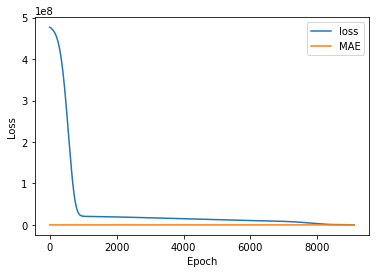

In [539]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['mae'], label='MAE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Modelo 2 introduciendo todos los datos posibles -en vez de datos de 4 horas, todos los disponibles-.

In [540]:
X_train1=np.array(PVGISdf.iloc[0:len(PVGISdf)-12:3,1:4]) #introduciendo valores de 3 en 3 de PVGIS hasta el último, tomamos todos los de PVOutput
X_train2=np.array(PVGISdf.iloc[3:len(PVGISdf)-9:3,1:4])
X_train3=np.array(PVGISdf.iloc[6:len(PVGISdf)-6:3,1:4]) 
X_train4=np.array(PVGISdf.iloc[9:len(PVGISdf)-3:3,1:4])
X_train=(X_train1,X_train2,X_train3,X_train4)

Y_train=np.array(PVOutputdf.iloc[4:len(PVOutputdf),1]).astype(float) #Pasa de un MSE de 11,730,933,760 a 6,180,356,096  y un MAE de 73,895.0391 a 72,145.0625 en 2390 épocas

In [542]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,restore_best_weights=True)
history = modelo2.fit(X_train, Y_train, epochs=20,callbacks=[callback]) 

Epoch 1/20
4136/4136 [==============================] - 7s 2ms/step - loss: 4902344704.0000 - mae: 57842.4648
Epoch 2/20
4136/4136 [==============================] - 7s 2ms/step - loss: 4900700672.0000 - mae: 57821.0703
Epoch 3/20
4136/4136 [==============================] - 7s 2ms/step - loss: 4898498048.0000 - mae: 57799.1211
Epoch 4/20
4136/4136 [==============================] - 8s 2ms/step - loss: 4896061952.0000 - mae: 57816.8398
Epoch 5/20
4136/4136 [==============================] - 8s 2ms/step - loss: 4893722112.0000 - mae: 57833.9727
Epoch 6/20
4136/4136 [==============================] - 8s 2ms/step - loss: 4891539456.0000 - mae: 57711.1953
Epoch 7/20
4136/4136 [==============================] - 8s 2ms/step - loss: 4889186304.0000 - mae: 57784.8281
Epoch 8/20
4136/4136 [==============================] - 8s 2ms/step - loss: 4886614016.0000 - mae: 57739.8984
Epoch 9/20
4136/4136 [==============================] - 8s 2ms/step - loss: 4884004352.0000 - mae: 57706.8633
Epoch 10/2

#### Entrena, pero error altísimo

Text(0, 0.5, 'Loss')

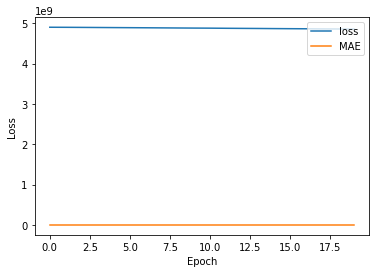

In [543]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['mae'], label='MAE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Tomamos datos de entrenamiento y validación para el modelo 2. Lo que utilizan en el artículo

In [33]:
#Uso validation_split utilizando los datos totales

X_train1=np.array(PVGISdf.iloc[0:len(PVGISdf)-12:3,1:4]) #introduciendo valores de 3 en 3 de PVGIS hasta el último, tomamos todos los de PVOutput
X_train2=np.array(PVGISdf.iloc[3:len(PVGISdf)-9:3,1:4]) #no introduzco los 3 últimos valores de la radiación ya que no los quiero para predecir
X_train3=np.array(PVGISdf.iloc[6:len(PVGISdf)-6:3,1:4]) 
X_train4=np.array(PVGISdf.iloc[9:len(PVGISdf)-3:3,1:4])
X_train=(X_train1,X_train2,X_train3,X_train4)

Y_train=np.array(PVOutputdf.iloc[4:len(PVOutputdf),5]).astype(float) 


In [545]:
modelo2.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas

In [546]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)
history = modelo2.fit(X_train, Y_train, epochs=10000,callbacks=[callback],validation_split=0.2) 

Epoch 1/10000
3309/3309 [==============================] - 8s 2ms/step - loss: 4814602240.0000 - mae: 57401.5820 - val_loss: 5008609792.0000 - val_mae: 57282.6289
Epoch 2/10000
3309/3309 [==============================] - 6s 2ms/step - loss: 4812942848.0000 - mae: 57450.2773 - val_loss: 5044692480.0000 - val_mae: 57211.5859
Epoch 3/10000
3309/3309 [==============================] - 6s 2ms/step - loss: 4810835968.0000 - mae: 57419.9062 - val_loss: 5015359488.0000 - val_mae: 57349.0625
Epoch 4/10000
3309/3309 [==============================] - 7s 2ms/step - loss: 4809366016.0000 - mae: 57436.6758 - val_loss: 5042083840.0000 - val_mae: 57259.4922
Epoch 5/10000
3309/3309 [==============================] - 7s 2ms/step - loss: 4807524864.0000 - mae: 57449.7070 - val_loss: 5012832256.0000 - val_mae: 57262.2148
Epoch 6/10000
3309/3309 [==============================] - 7s 2ms/step - loss: 4806532096.0000 - mae: 57454.4609 - val_loss: 5033064448.0000 - val_mae: 57039.0117
Epoch 7/10000
3309/330

Text(0, 0.5, 'MSE')

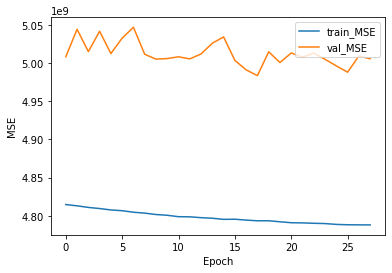

In [547]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### El conjunto de entrenamiento sí que mejora, pero el de validación oscila mucho.

### Modelo 3 solo una capa adicional oculta

In [561]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)

#Capas ocultas (1 neurona)
oculta1 = tf.keras.layers.Dense(1, activation="relu")(entrada1)  
oculta2 = tf.keras.layers.Dense(1, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(1, activation="relu")(entrada3)
oculta4 = tf.keras.layers.Dense(1, activation="relu")(entrada4)

concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4]) 

adoculta1=tf.keras.layers.Dense(1, activation="relu")(concat)
salida=tf.keras.layers.Dense(1, activation='relu')(adoculta1) #produccion en los siguientes 15 minutos
modelo3 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4], outputs=[salida])
modelo3.summary()

Model: "model_70"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1770 (InputLayer)        [(None, 3)]          0           []                               
                                                                                                  
 input_1771 (InputLayer)        [(None, 3)]          0           []                               
                                                                                                  
 input_1772 (InputLayer)        [(None, 3)]          0           []                               
                                                                                                  
 input_1773 (InputLayer)        [(None, 3)]          0           []                               
                                                                                           

In [562]:
modelo3.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas

In [563]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
history = modelo3.fit(X_train, Y_train, epochs=10000,callbacks=[callback],validation_split=0.2) 

Epoch 1/10000
3309/3309 [==============================] - 6s 2ms/step - loss: 8655984640.0000 - mae: 56980.9102 - val_loss: 7113637888.0000 - val_mae: 48217.5039
Epoch 2/10000
3309/3309 [==============================] - 5s 2ms/step - loss: 6884288512.0000 - mae: 50497.9805 - val_loss: 6970540544.0000 - val_mae: 48359.4922
Epoch 3/10000
3309/3309 [==============================] - 6s 2ms/step - loss: 6813766656.0000 - mae: 50535.0820 - val_loss: 6914497536.0000 - val_mae: 48321.5781
Epoch 4/10000
3309/3309 [==============================] - 6s 2ms/step - loss: 6759200256.0000 - mae: 50457.2891 - val_loss: 6836246528.0000 - val_mae: 48371.7305
Epoch 5/10000
3309/3309 [==============================] - 6s 2ms/step - loss: 6713747456.0000 - mae: 50414.5234 - val_loss: 6797029888.0000 - val_mae: 48285.2070
Epoch 6/10000
3309/3309 [==============================] - 6s 2ms/step - loss: 6672679424.0000 - mae: 50363.6289 - val_loss: 6764195840.0000 - val_mae: 48169.6562
Epoch 7/10000
3309/330

Text(0, 0.5, 'MSE')

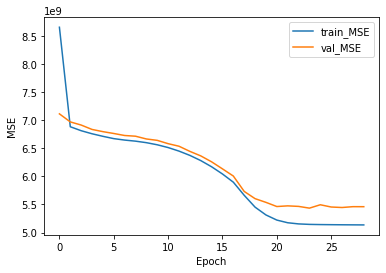

In [564]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### El error es mayor que utilizando dos capas ocultas, pero entrena más

### Modelo 4--> 2 capas ocultas adicionales y numero neuronas con fórmula 1: Hidden =2/3*(In + Out)

In [552]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)

#Capas ocultas, formula 1: Hidden =2/3*(In + Out)=2/3*(3+1)=8/3
oculta1 = tf.keras.layers.Dense(8/3, activation="relu")(entrada1)  
oculta2 = tf.keras.layers.Dense(8/3, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(8/3, activation="relu")(entrada3)
oculta4 = tf.keras.layers.Dense(8/3, activation="relu")(entrada4)

concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4]) 

adoculta1=tf.keras.layers.Dense(4/3, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(4/3, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(2/3, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo4 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4], outputs=[salida])
modelo4.summary()

Model: "model_67"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1758 (InputLayer)        [(None, 3)]          0           []                               
                                                                                                  
 input_1759 (InputLayer)        [(None, 3)]          0           []                               
                                                                                                  
 input_1760 (InputLayer)        [(None, 3)]          0           []                               
                                                                                                  
 input_1761 (InputLayer)        [(None, 3)]          0           []                               
                                                                                           

In [553]:
modelo4.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
history = modelo4.fit(X_train, Y_train, epochs=1000,callbacks=[callback],validation_split=0.2) 

Epoch 1/1000
3309/3309 [==============================] - 8s 2ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/1000
3309/3309 [==============================] - 7s 2ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/1000
3309/3309 [==============================] - 7s 2ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/1000
3309/3309 [==============================] - 7s 2ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/1000
3309/3309 [==============================] - 8s 2ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan


Text(0, 0.5, 'MSE')

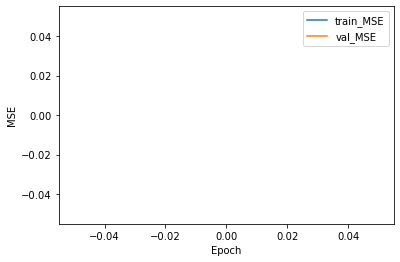

In [320]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Nan en los errores, no aplicamos esta fórmula

### Modelo 5--> 2 capas ocultas adicionales y numero neuronas con fórmula 2: Hidden =3/2*(In + Out)

In [34]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)

#Capas ocultas, formula 2: Hidden =3/2*(In + Out)=3/2*(3+1)=6
oculta1 = tf.keras.layers.Dense(6, activation="relu")(entrada1)  
oculta2 = tf.keras.layers.Dense(6, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(6, activation="relu")(entrada3)
oculta4 = tf.keras.layers.Dense(6, activation="relu")(entrada4)

concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4]) 

adoculta1=tf.keras.layers.Dense(3, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(3, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(3/2, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo5 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4], outputs=[salida])
modelo5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 3)]          0           []                               
                                                                                              

In [35]:
modelo5.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo5.fit(X_train, Y_train, epochs=1000,callbacks=[callback],validation_split=0.2) 

Epoch 1/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 2/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 3/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 4/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 5/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 6/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 7/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 8/1000
3309/3309 [========================

Text(0, 0.5, 'MSE')

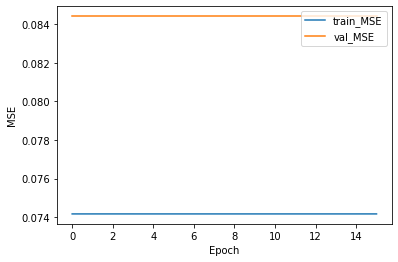

In [36]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Pasa de un train MSE 3,771,087,616 a 2,956,253,184 y de un val MSE: 3,818,099,712 a 2,798,379,008 en 107 épocas, mejores resultados que el modelo con 1 neurona en cada capa. Parece indicar que hay que aumentar la complejidad de nuestro modelo. Entrena mucho

### Modelo 6--> 2 capas ocultas adicionales y numero neuronas con fórmula 3: Hidden =1/2*(In + Out)+ SQRT(Training), siendo training el número de muestras

In [37]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)

#Capas ocultas, formula 3: Hidden=1/2*(In + Out)+ SQRT(Training)=1/2*(3 + 1)+ np.sqrt(132323)=365.7622850159153
#Suponiendo que el número de muestras es len(Y_train)
oculta1 = tf.keras.layers.Dense(1/2*(3 + 1)+ np.sqrt(132323), activation="relu")(entrada1)  
oculta2 = tf.keras.layers.Dense(1/2*(3 + 1)+ np.sqrt(132323), activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(1/2*(3 + 1)+ np.sqrt(132323), activation="relu")(entrada3)
oculta4 = tf.keras.layers.Dense(1/2*(3 + 1)+ np.sqrt(132323), activation="relu")(entrada4)

concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4]) 

adoculta1=tf.keras.layers.Dense(1/2*(1 + 1)+ np.sqrt(132323), activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(1/2*(1 + 1)+ np.sqrt(132323), activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(1/2*(1 + 0)+ np.sqrt(132323), activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo6 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4], outputs=[salida])
modelo6.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 3)]          0           []                               
                                                                                            

In [38]:
modelo6.compile(optimizer='adam', 
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
history = modelo6.fit(X_train, Y_train, epochs=1000,callbacks=[callback],validation_split=0.2) 

Epoch 1/1000
3309/3309 [==============================] - 31s 9ms/step - loss: 0.0918 - mae: 0.1500 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 2/1000
3309/3309 [==============================] - 32s 10ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 3/1000
3309/3309 [==============================] - 34s 10ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 4/1000
3309/3309 [==============================] - 32s 10ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 5/1000
3309/3309 [==============================] - 32s 10ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 6/1000
3309/3309 [==============================] - 31s 9ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640


Text(0, 0.5, 'MSE')

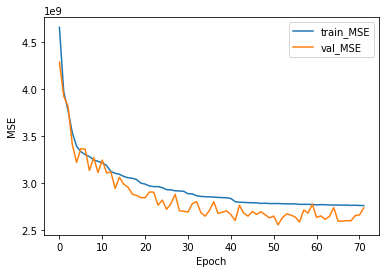

In [571]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Pasa de un train MSE de 4,433,063,424  a 2,735,120,384 y de un val MSE de 4,102,640,384 a 2,522,848,768 en 52 épocas. Este es el modelo que más ha mejorado, por lo que se confirma que se debe aumentar la complejidad del modelo, en este caso mediante el número de neuronas

### Modelo 6 con datos estandarizados

In [573]:
#Procedo a estandarizar los datos de la Red Neuronal
X_train1std=np.std(np.array(PVGISdf.iloc[0:len(PVGISdf)-12:3,1:4]))
X_train2std=np.std(np.array(PVGISdf.iloc[3:len(PVGISdf)-9:3,1:4])) 
X_train3std=np.std(np.array(PVGISdf.iloc[6:len(PVGISdf)-6:3,1:4])) 
X_train4std=np.std(np.array(PVGISdf.iloc[9:len(PVGISdf)-3:3,1:4]))
X_train=(X_train1std,X_train2std,X_train3std,X_train4std)

X_train1est=np.array(PVGISdf.iloc[0:len(PVGISdf)-12:3,1:4])/X_train1std 
X_train2est=np.array(PVGISdf.iloc[3:len(PVGISdf)-9:3,1:4])/X_train2std 
X_train3est=np.array(PVGISdf.iloc[6:len(PVGISdf)-6:3,1:4])/X_train3std 
X_train4est=np.array(PVGISdf.iloc[9:len(PVGISdf)-3:3,1:4])/X_train4std
X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est)

Y_trainstd=np.std(np.array(PVOutputdf.iloc[4:len(PVOutputdf),1]).astype(float)) 
Y_trainest=np.array(PVOutputdf.iloc[4:len(PVOutputdf),1]).astype(float)/Y_trainstd 

In [340]:
model6.compile(optimizer='adam', 
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = model6.fit(X_trainest, Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2) 

Epoch 1/1000
3309/3309 [==============================] - 29s 9ms/step - loss: 14743256.0000 - mae: 298.5334 - val_loss: 20.8672 - val_mae: 0.9338
Epoch 2/1000
3309/3309 [==============================] - 31s 9ms/step - loss: 340.6349 - mae: 0.9199 - val_loss: 1.9323 - val_mae: 0.9072
Epoch 3/1000
3309/3309 [==============================] - 31s 9ms/step - loss: 52.9227 - mae: 0.8652 - val_loss: 1.9323 - val_mae: 0.9072
Epoch 4/1000
3309/3309 [==============================] - 30s 9ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9323 - val_mae: 0.9072
Epoch 5/1000
3309/3309 [==============================] - 30s 9ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9323 - val_mae: 0.9072
Epoch 6/1000
3309/3309 [==============================] - 30s 9ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9323 - val_mae: 0.9072
Epoch 7/1000
3309/3309 [==============================] - 31s 9ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9323 - val_mae: 0.9072
Epoch 8/1000
3309/3309 [====

Text(0, 0.5, 'MSE')

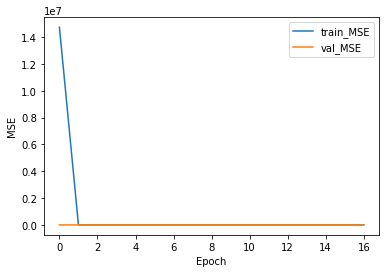

In [341]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Observamos que el error obtenido es mucho más razonable, aunque la red neuronal solamente entrena en las 3 primeras épocas.  Pasa de un train MSE de 14,743,256  a 1.6830 y de un val MSE de 20.8672 a 1.9323 en 3 épocas, no mejora tanto como con datos sin estandarizar

### Modelo 5 con datos estandarizados y 2 neuronas en la salida en vez de 1.5

In [390]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)

#Capas ocultas, formula 2: Hidden =3/2*(In + Out)=3/2*(3+1)=6
oculta1 = tf.keras.layers.Dense(6, activation="relu")(entrada1)  
oculta2 = tf.keras.layers.Dense(6, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(6, activation="relu")(entrada3)
oculta4 = tf.keras.layers.Dense(6, activation="relu")(entrada4)

concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4]) 

adoculta1=tf.keras.layers.Dense(3, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(3, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(2, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
model5 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4], outputs=[salida])

In [354]:
model5.compile(optimizer='adam', 
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = model5.fit(X_trainest, Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2) 

Epoch 1/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 1.0238 - mae: 0.7065 - val_loss: 0.5871 - val_mae: 0.5932
Epoch 2/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 0.5474 - mae: 0.5526 - val_loss: 0.5445 - val_mae: 0.5512
Epoch 3/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 0.5123 - mae: 0.5202 - val_loss: 0.5003 - val_mae: 0.5107
Epoch 4/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 0.5022 - mae: 0.5120 - val_loss: 0.4893 - val_mae: 0.4972
Epoch 5/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 0.4975 - mae: 0.5082 - val_loss: 0.4760 - val_mae: 0.5019
Epoch 6/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 0.4946 - mae: 0.5058 - val_loss: 0.4707 - val_mae: 0.4763
Epoch 7/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 0.4929 - mae: 0.5044 - val_loss: 0.4743 - val_mae: 0.5043
Epoch 8/1000
3309/3309 [========================

Text(0, 0.5, 'MSE')

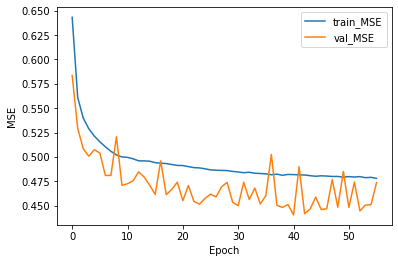

In [346]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Se alcanza un error train MSE 0.4773 y un val MSE de 0.4479 entrenando durante 41 épocas, mejor resultado que en el modelo 6 que utiliza más neuronas, no mejora tanto como con datos sin estandarizar.

### Modelo 2 con datos estandarizados 

In [350]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3)#tamaño 3 en principio (tipos de radiación) uno de cada 4, las horas exactas cogiendo datos cada 15 mins 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)

#Capas ocultas (1 neurona)
oculta1 = tf.keras.layers.Dense(1, activation="relu")(entrada1)  #Necesitaria 4 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(1, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(1, activation="relu")(entrada3)
oculta4 = tf.keras.layers.Dense(1, activation="relu")(entrada4)

concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4]) #estratificada, concatena las 4
#2 layers intermedias, no sabemos con cuántas neuronas: siguiendo la primera formula 2/3*(1+1)
adoculta1=tf.keras.layers.Dense(1, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(1, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(1, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
model2 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4], outputs=[salida])

In [348]:
model2.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = model2.fit(X_trainest, Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2) 

Epoch 1/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9323 - val_mae: 0.9072
Epoch 2/1000
3309/3309 [==============================] - 5s 2ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9323 - val_mae: 0.9072
Epoch 3/1000
3309/3309 [==============================] - 5s 2ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9323 - val_mae: 0.9072
Epoch 4/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9323 - val_mae: 0.9072
Epoch 5/1000
3309/3309 [==============================] - 5s 2ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9323 - val_mae: 0.9072
Epoch 6/1000
3309/3309 [==============================] - 5s 2ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9323 - val_mae: 0.9072
Epoch 7/1000
3309/3309 [==============================] - 5s 2ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9323 - val_mae: 0.9072
Epoch 8/1000
3309/3309 [========================

Text(0, 0.5, 'MSE')

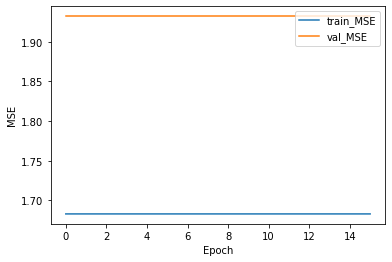

In [349]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### El modelo no entrena

### Modelo 3 (1 capa oculta adicional) con datos estandarizados 

In [574]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)

#Capas ocultas (1 neurona)
oculta1 = tf.keras.layers.Dense(1, activation="relu")(entrada1)  
oculta2 = tf.keras.layers.Dense(1, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(1, activation="relu")(entrada3)
oculta4 = tf.keras.layers.Dense(1, activation="relu")(entrada4)

concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4]) 

adoculta1=tf.keras.layers.Dense(1, activation="relu")(concat)
salida=tf.keras.layers.Dense(1, activation='relu')(adoculta1) #produccion en los siguientes 15 minutos
model3 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4], outputs=[salida])

model3.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = model3.fit(X_trainest, Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2) 

Epoch 1/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9323 - val_mae: 0.9072
Epoch 2/1000
3309/3309 [==============================] - 5s 2ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9323 - val_mae: 0.9072
Epoch 3/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9323 - val_mae: 0.9072
Epoch 4/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9323 - val_mae: 0.9072
Epoch 5/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9323 - val_mae: 0.9072
Epoch 6/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9323 - val_mae: 0.9072
Epoch 7/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9323 - val_mae: 0.9072
Epoch 8/1000
3309/3309 [========================

Text(0, 0.5, 'MSE')

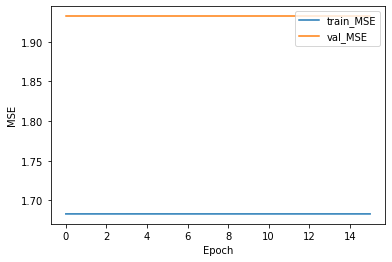

In [352]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Tampoco entrena 

### Modelo 7. Como el 5 con datos estandarizados, pero utilizando datos atmosféricos más allá de la radiación 

In [398]:
X_train1std=np.std(np.array(PVGISdf.iloc[0:len(PVGISdf)-12:3,1:7]))
X_train2std=np.std(np.array(PVGISdf.iloc[3:len(PVGISdf)-9:3,1:7])) 
X_train3std=np.std(np.array(PVGISdf.iloc[6:len(PVGISdf)-6:3,1:7])) 
X_train4std=np.std(np.array(PVGISdf.iloc[9:len(PVGISdf)-3:3,1:7]))
X_train=(X_train1std,X_train2std,X_train3std,X_train4std)

X_train1est=np.array(PVGISdf.iloc[0:len(PVGISdf)-12:3,1:7])/X_train1std 
X_train2est=np.array(PVGISdf.iloc[3:len(PVGISdf)-9:3,1:7])/X_train2std 
X_train3est=np.array(PVGISdf.iloc[6:len(PVGISdf)-6:3,1:7])/X_train3std 
X_train4est=np.array(PVGISdf.iloc[9:len(PVGISdf)-3:3,1:7])/X_train4std
X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est)

Y_trainstd=np.std(np.array(PVOutputdf.iloc[4:len(PVOutputdf),1]).astype(float)) 
Y_trainest=np.array(PVOutputdf.iloc[4:len(PVOutputdf),1]).astype(float)/Y_trainstd 

In [402]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=6) 
entrada2 = tf.keras.layers.Input(shape=6)
entrada3 = tf.keras.layers.Input(shape=6)
entrada4 = tf.keras.layers.Input(shape=6)
#entrada5 = tf.keras.layers.Input(shape=6)
#entrada6 = tf.keras.layers.Input(shape=6)

#Capas ocultas, formula 2: Hidden =3/2*(In + Out)=3/2*(6+1)=10.5. Dado que de 6 a 10.5 neuronas ha mejorado mucho, probamos con 15
oculta1 = tf.keras.layers.Dense(15, activation="relu")(entrada1)  
oculta2 = tf.keras.layers.Dense(15, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(15, activation="relu")(entrada3)
oculta4 = tf.keras.layers.Dense(15, activation="relu")(entrada4)
#oculta5 = tf.keras.layers.Dense(10.5, activation="relu")(entrada5)
#oculta6 = tf.keras.layers.Dense(10.5, activation="relu")(entrada6)

concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4]) 

adoculta1=tf.keras.layers.Dense(3, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(3, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(2, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo7 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4], outputs=[salida])
modelo7.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_127 (InputLayer)         [(None, 6)]          0           []                               
                                                                                                  
 input_128 (InputLayer)         [(None, 6)]          0           []                               
                                                                                                  
 input_129 (InputLayer)         [(None, 6)]          0           []                               
                                                                                                  
 input_130 (InputLayer)         [(None, 6)]          0           []                               
                                                                                           

In [403]:
modelo7.compile(optimizer='adam', 
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo7.fit(X_trainest, Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2) 

Epoch 1/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 0.5577 - mae: 0.5560 - val_loss: 0.5010 - val_mae: 0.5395
Epoch 2/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 0.4855 - mae: 0.5018 - val_loss: 0.4317 - val_mae: 0.4605
Epoch 3/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 0.4578 - mae: 0.4798 - val_loss: 0.4567 - val_mae: 0.5243
Epoch 4/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 0.4409 - mae: 0.4663 - val_loss: 0.4201 - val_mae: 0.4791
Epoch 5/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 0.4318 - mae: 0.4576 - val_loss: 0.4040 - val_mae: 0.4613
Epoch 6/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 0.4234 - mae: 0.4491 - val_loss: 0.4167 - val_mae: 0.4892
Epoch 7/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 0.4177 - mae: 0.4452 - val_loss: 0.4189 - val_mae: 0.4649
Epoch 8/1000
3309/3309 [========================

Text(0, 0.5, 'MSE')

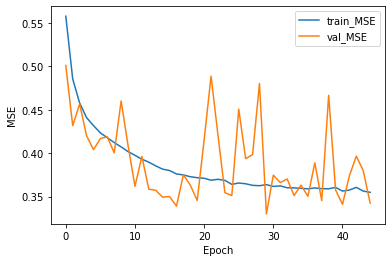

In [404]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Utilizando 6 neuronas en las capas ocultas obtenemos un train MSE de 1.0243  y un val MSE  de 1.1406 en 91 épocas.
#### Utilizando 10.5 neuronas en las capas ocultas (lo que corresponde aplicando fórmula 2) obtenemos un train MSE de 0.3589  y un val MSE de 0.3386 en 41 épocas. Dado que funciona mejor, probamos con un mayor número de neuronas: 15. 
#### Utilizando 15 neuronas en las capas ocultas obtenemos un train MSE de 0.3605  y un val MSE  de 0.3576  en 40 épocas. No mejora.

### Modelo 8. Como el 6 con datos estandarizados, pero utilizando datos atmosféricos más allá de la radiación (básicamente usando muchas más neuronas que en el modelo 7)

In [405]:
X_train1std=np.std(np.array(PVGISdf.iloc[0:len(PVGISdf)-12:3,1:7]))
X_train2std=np.std(np.array(PVGISdf.iloc[3:len(PVGISdf)-9:3,1:7])) 
X_train3std=np.std(np.array(PVGISdf.iloc[6:len(PVGISdf)-6:3,1:7])) 
X_train4std=np.std(np.array(PVGISdf.iloc[9:len(PVGISdf)-3:3,1:7]))
X_train=(X_train1std,X_train2std,X_train3std,X_train4std)

X_train1est=np.array(PVGISdf.iloc[0:len(PVGISdf)-12:3,1:7])/X_train1std 
X_train2est=np.array(PVGISdf.iloc[3:len(PVGISdf)-9:3,1:7])/X_train2std 
X_train3est=np.array(PVGISdf.iloc[6:len(PVGISdf)-6:3,1:7])/X_train3std 
X_train4est=np.array(PVGISdf.iloc[9:len(PVGISdf)-3:3,1:7])/X_train4std
X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est)

Y_trainstd=np.std(np.array(PVOutputdf.iloc[4:len(PVOutputdf),1]).astype(float)) 
Y_trainest=np.array(PVOutputdf.iloc[4:len(PVOutputdf),1]).astype(float)/Y_trainstd 

In [406]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=6) 
entrada2 = tf.keras.layers.Input(shape=6)
entrada3 = tf.keras.layers.Input(shape=6)
entrada4 = tf.keras.layers.Input(shape=6)

#Capas ocultas, formula 3: Hidden=1/2*(In + Out)+ SQRT(Training)=1/2*(6 + 1)+ np.sqrt(132323)
#Suponiendo que el número de muestras es len(Y_train)
oculta1 = tf.keras.layers.Dense(1/2*(6 + 1)+ np.sqrt(132323), activation="relu")(entrada1)  
oculta2 = tf.keras.layers.Dense(1/2*(6 + 1)+ np.sqrt(132323), activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(1/2*(6 + 1)+ np.sqrt(132323), activation="relu")(entrada3)
oculta4 = tf.keras.layers.Dense(1/2*(6 + 1)+ np.sqrt(132323), activation="relu")(entrada4)

concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4]) 

adoculta1=tf.keras.layers.Dense(1/2*(1 + 1)+ np.sqrt(132323), activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(1/2*(1 + 1)+ np.sqrt(132323), activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(1/2*(1 + 0)+ np.sqrt(132323), activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo8 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4], outputs=[salida])

modelo8.compile(optimizer='adam', 
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo8.fit(X_trainest, Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2) 

Epoch 1/1000
3309/3309 [==============================] - 39s 11ms/step - loss: 0.5051 - mae: 0.4988 - val_loss: 0.4204 - val_mae: 0.4543
Epoch 2/1000
3309/3309 [==============================] - 38s 12ms/step - loss: 0.4392 - mae: 0.4553 - val_loss: 0.4041 - val_mae: 0.4517
Epoch 3/1000
3309/3309 [==============================] - 38s 11ms/step - loss: 0.4231 - mae: 0.4413 - val_loss: 0.3970 - val_mae: 0.4089
Epoch 4/1000
3309/3309 [==============================] - 37s 11ms/step - loss: 0.4120 - mae: 0.4316 - val_loss: 0.4357 - val_mae: 0.4919
Epoch 5/1000
3309/3309 [==============================] - 36s 11ms/step - loss: 0.4025 - mae: 0.4245 - val_loss: 0.3750 - val_mae: 0.4321
Epoch 6/1000
3309/3309 [==============================] - 36s 11ms/step - loss: 0.3928 - mae: 0.4169 - val_loss: 0.3616 - val_mae: 0.4172
Epoch 7/1000
3309/3309 [==============================] - 35s 11ms/step - loss: 0.3895 - mae: 0.4139 - val_loss: 0.3739 - val_mae: 0.3995
Epoch 8/1000
3309/3309 [==========

Text(0, 0.5, 'MSE')

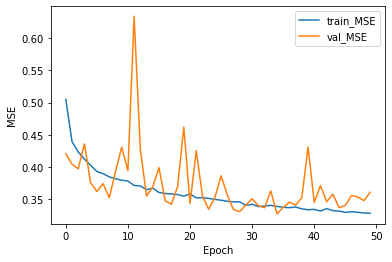

In [407]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un train MSE de 0.3385 y un val MSE  de 0.3268 en 35 épocas. Mejor modelo parecido al 7

### Modelo 9. Tomamos datos cada 5 minutos de la hora anterior y predecimos a 15 minutos vista solo con radiación como entrada y una neurona por capa

In [412]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3)#tamaño 3 en principio (tipos de radiación) uno de cada 12, las horas exactas 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)
#Capas ocultas (1 neurona)
oculta1 = tf.keras.layers.Dense(1, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(1, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(1, activation="relu")(entrada3)
oculta4 = tf.keras.layers.Dense(1, activation="relu")(entrada4)
oculta5 = tf.keras.layers.Dense(1, activation="relu")(entrada5)
oculta6 = tf.keras.layers.Dense(1, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(1, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(1, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(1, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(1, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(1, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(1, activation="relu")(entrada12)
concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12]) #estratificada, concatena las 12
#2 layers intermedias, no sabemos con cuántas neuronas: siguiendo la primera formula 2/3*(1+1)
adoculta1=tf.keras.layers.Dense(1, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(1, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(1, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo9 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12], outputs=[salida])

modelo9.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas

In [413]:
X_train1=np.array(PVGISdf.iloc[1:len(PVGISdf)-14:3,1:4]) #Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=np.array(PVGISdf.iloc[2:len(PVGISdf)-13:3,1:4]) #Tengo datos de radiación de 13:20-14:15 e introduzco producción a las 14:30.
X_train3=np.array(PVGISdf.iloc[3:len(PVGISdf)-12:3,1:4]) #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=np.array(PVGISdf.iloc[4:len(PVGISdf)-11:3,1:4])
X_train5=np.array(PVGISdf.iloc[5:len(PVGISdf)-10:3,1:4])
X_train6=np.array(PVGISdf.iloc[6:len(PVGISdf)-9:3,1:4])
X_train7=np.array(PVGISdf.iloc[7:len(PVGISdf)-8:3,1:4]) 
X_train8=np.array(PVGISdf.iloc[8:len(PVGISdf)-7:3,1:4])
X_train9=np.array(PVGISdf.iloc[9:len(PVGISdf)-6:3,1:4]) 
X_train10=np.array(PVGISdf.iloc[10:len(PVGISdf)-5:3,1:4])
X_train11=np.array(PVGISdf.iloc[11:len(PVGISdf)-4:3,1:4])
X_train12=np.array(PVGISdf.iloc[12:len(PVGISdf)-3:3,1:4]) #Tomo datos hasta las 22:30 del 16/12/2018 para que mi última predicción sea la de las 22:45

y_train=np.array(PVOutputdf.iloc[5:len(PVOutputdf),1]).astype(float) #No tomo los primeros 5 valores para cuadrarlo

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 
X_train7std=np.std(X_train7) 
X_train8std=np.std(X_train8)
X_train9std=np.std(X_train9)
X_train10std=np.std(X_train10) 
X_train11std=np.std(X_train11) 
X_train12std=np.std(X_train12)

X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 
X_train7est=X_train7/X_train7std 
X_train8est=X_train8/X_train8std
X_train9est=X_train9/X_train9std 
X_train10est=X_train10/X_train10std 
X_train11est=X_train11/X_train11std 
X_train12est=X_train12/X_train12std
X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est,X_train7est,X_train8est,X_train9est,X_train10est,X_train11est,X_train12est)

Y_trainstd=np.std(y_train) 
Y_trainest=y_train/Y_trainstd 

In [414]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo9.fit(X_trainest, Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2) 

Epoch 1/1000
3309/3309 [==============================] - 9s 2ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9322 - val_mae: 0.9072
Epoch 2/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9322 - val_mae: 0.9072
Epoch 3/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9322 - val_mae: 0.9072
Epoch 4/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9322 - val_mae: 0.9072
Epoch 5/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9322 - val_mae: 0.9072
Epoch 6/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9322 - val_mae: 0.9072
Epoch 7/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 1.6830 - mae: 0.8433 - val_loss: 1.9322 - val_mae: 0.9072
Epoch 8/1000
3309/3309 [========================

Text(0, 0.5, 'MSE')

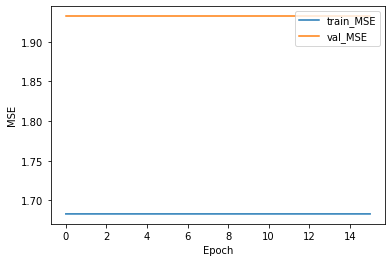

In [415]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### No entrena, así que probamos un modelo con mayor número de neuronas 

### Modelo 10. Tomamos datos cada 5 minutos de la hora anterior y predecimos a 15 minutos vista solo con radiación como entrada y utilizando fórmula 2 de neuronas

In [417]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3)#tamaño 3 en principio (tipos de radiación) uno de cada 12, las horas exactas 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)
#Capas ocultas. Neuronas formula 2: Hidden =3/2*(In + Out)=3/2*(3+1)=6
oculta1 = tf.keras.layers.Dense(6, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(6, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(6, activation="relu")(entrada3)
oculta4 = tf.keras.layers.Dense(6, activation="relu")(entrada4)
oculta5 = tf.keras.layers.Dense(6, activation="relu")(entrada5)
oculta6 = tf.keras.layers.Dense(6, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(6, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(6, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(6, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(6, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(6, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(6, activation="relu")(entrada12)
concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12]) #estratificada, concatena las 12
#2 layers intermedias, Neuronas formula 2: Hidden =3/2*(In + Out)=3/2*(1+1)=3
adoculta1=tf.keras.layers.Dense(3, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(3, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(1.5, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo10 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12], outputs=[salida])

modelo10.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo10.fit(X_trainest, Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2) 

Epoch 1/1000
3309/3309 [==============================] - 8s 2ms/step - loss: 0.6379 - mae: 0.6061 - val_loss: 0.5490 - val_mae: 0.5447
Epoch 2/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 0.5485 - mae: 0.5466 - val_loss: 0.5111 - val_mae: 0.5273
Epoch 3/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 0.5293 - mae: 0.5332 - val_loss: 0.4929 - val_mae: 0.5096
Epoch 4/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 0.5159 - mae: 0.5259 - val_loss: 0.4863 - val_mae: 0.4870
Epoch 5/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 0.5077 - mae: 0.5210 - val_loss: 0.4634 - val_mae: 0.4862
Epoch 6/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 0.4985 - mae: 0.5143 - val_loss: 0.4617 - val_mae: 0.4974
Epoch 7/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 0.4908 - mae: 0.5074 - val_loss: 0.4665 - val_mae: 0.5095
Epoch 8/1000
3309/3309 [========================

Text(0, 0.5, 'MSE')

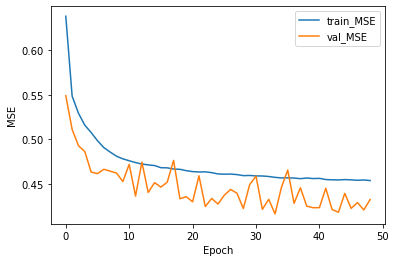

In [418]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un train MSE de 0.4575 y un val MSE de  0.4165 en 34 épocas. Mejora considerablemente al modelo anterior, ahora entrena, pero no es el mejor modelo.

### Modelo 11. Tomamos datos cada 5 minutos de la hora anterior y predecimos a 15 minutos vista solo con radiación como entrada y utilizando fórmula 3 de neuronas

In [424]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3)#tamaño 3 en principio (tipos de radiación) uno de cada 12, las horas exactas 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)
#Capas ocultas. Neuronas formula 3: Hidden=1/2*(In + Out)+ SQRT(Training)=1/2*(3 + 1)+ np.sqrt(132323)=365.7622850159153
oculta1 = tf.keras.layers.Dense(1/2*(3 + 1)+ np.sqrt(132323), activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(1/2*(3 + 1)+ np.sqrt(132323), activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(1/2*(3 + 1)+ np.sqrt(132323), activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(1/2*(3 + 1)+ np.sqrt(132323), activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(1/2*(3 + 1)+ np.sqrt(132323), activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(1/2*(3 + 1)+ np.sqrt(132323), activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(1/2*(3 + 1)+ np.sqrt(132323), activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(1/2*(3 + 1)+ np.sqrt(132323), activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(1/2*(3 + 1)+ np.sqrt(132323), activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(1/2*(3 + 1)+ np.sqrt(132323), activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(1/2*(3 + 1)+ np.sqrt(132323), activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(1/2*(3 + 1)+ np.sqrt(132323), activation="relu")(entrada12)
concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12]) #estratificada, concatena las 12
#2 layers intermedias, Neuronas formula 3: Hidden=1/2*(In + Out)+ SQRT(Training)=1/2*(1 + 1)+ np.sqrt(132323)
adoculta1=tf.keras.layers.Dense(1/2*(1 + 1)+ np.sqrt(132323), activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(1/2*(1 + 1)+ np.sqrt(132323), activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(1/2*(1 + 0)+ np.sqrt(132323), activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo11 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12], outputs=[salida])

modelo11.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo11.fit(X_trainest, Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2) 

Epoch 1/1000
3309/3309 [==============================] - 63s 18ms/step - loss: 0.5352 - mae: 0.5180 - val_loss: 0.4396 - val_mae: 0.4356
Epoch 2/1000
3309/3309 [==============================] - 61s 19ms/step - loss: 0.4750 - mae: 0.4759 - val_loss: 0.4785 - val_mae: 0.4939
Epoch 3/1000
3309/3309 [==============================] - 62s 19ms/step - loss: 0.4654 - mae: 0.4693 - val_loss: 0.4800 - val_mae: 0.5151
Epoch 4/1000
3309/3309 [==============================] - 64s 19ms/step - loss: 0.4599 - mae: 0.4648 - val_loss: 0.4240 - val_mae: 0.4358
Epoch 5/1000
3309/3309 [==============================] - 65s 20ms/step - loss: 0.4552 - mae: 0.4627 - val_loss: 0.4152 - val_mae: 0.4420
Epoch 6/1000
3309/3309 [==============================] - 65s 20ms/step - loss: 0.4453 - mae: 0.4572 - val_loss: 0.4392 - val_mae: 0.4780
Epoch 7/1000
3309/3309 [==============================] - 67s 20ms/step - loss: 0.4414 - mae: 0.4542 - val_loss: 0.4124 - val_mae: 0.4303
Epoch 8/1000
3309/3309 [==========

3309/3309 [==============================] - 60s 18ms/step - loss: 0.4094 - mae: 0.4307 - val_loss: 0.3822 - val_mae: 0.4229
Epoch 77/1000
3309/3309 [==============================] - 60s 18ms/step - loss: 0.4094 - mae: 0.4305 - val_loss: 0.3984 - val_mae: 0.4501
Epoch 78/1000
3309/3309 [==============================] - 60s 18ms/step - loss: 0.4131 - mae: 0.4267 - val_loss: 0.3943 - val_mae: 0.4404
Epoch 79/1000
3309/3309 [==============================] - 60s 18ms/step - loss: 0.4089 - mae: 0.4301 - val_loss: 0.3945 - val_mae: 0.4437
Epoch 80/1000
3309/3309 [==============================] - 60s 18ms/step - loss: 0.4083 - mae: 0.4301 - val_loss: 0.3938 - val_mae: 0.4324
Epoch 81/1000
3309/3309 [==============================] - 60s 18ms/step - loss: 0.4085 - mae: 0.4297 - val_loss: 0.3821 - val_mae: 0.4190
Epoch 82/1000
3309/3309 [==============================] - 60s 18ms/step - loss: 0.4088 - mae: 0.4309 - val_loss: 0.3784 - val_mae: 0.4169
Epoch 83/1000
3309/3309 [================

Text(0, 0.5, 'MSE')

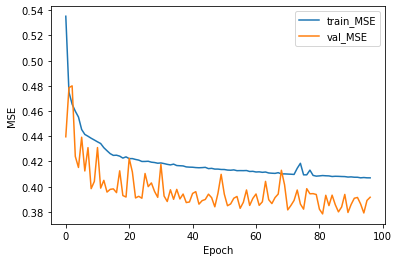

In [425]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un train MSE de 0.4088 y un val MSE de 0.3784 en 82 épocas. Mejores resultados que en el modelo 10. Tarda unos 60 segundos por época

### Modelo 12. Tomamos datos cada 5 minutos de la hora anterior y predecimos a 15 minutos vista con datos atmosféricos como entrada y utilizando fórmula 3 de neuronas tomando el resto de datos de radiación.

In [429]:
X_train1=np.array(PVGISdf.iloc[1:len(PVGISdf)-14:3,1:7]) #Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=np.array(PVGISdf.iloc[2:len(PVGISdf)-13:3,1:7]) #Tengo datos de radiación de 13:20-14:15 e introduzco producción a las 14:30.
X_train3=np.array(PVGISdf.iloc[3:len(PVGISdf)-12:3,1:7]) #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=np.array(PVGISdf.iloc[4:len(PVGISdf)-11:3,1:7])
X_train5=np.array(PVGISdf.iloc[5:len(PVGISdf)-10:3,1:7])
X_train6=np.array(PVGISdf.iloc[6:len(PVGISdf)-9:3,1:7])
X_train7=np.array(PVGISdf.iloc[7:len(PVGISdf)-8:3,1:7]) 
X_train8=np.array(PVGISdf.iloc[8:len(PVGISdf)-7:3,1:7])
X_train9=np.array(PVGISdf.iloc[9:len(PVGISdf)-6:3,1:7]) 
X_train10=np.array(PVGISdf.iloc[10:len(PVGISdf)-5:3,1:7])
X_train11=np.array(PVGISdf.iloc[11:len(PVGISdf)-4:3,1:7])
X_train12=np.array(PVGISdf.iloc[12:len(PVGISdf)-3:3,1:7]) #Tomo datos hasta las 22:30 del 16/12/2018 para que mi última predicción sea la de las 22:45

y_train=np.array(PVOutputdf.iloc[5:len(PVOutputdf),1]).astype(float) #No tomo los primeros 5 valores para cuadrarlo

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 
X_train7std=np.std(X_train7) 
X_train8std=np.std(X_train8)
X_train9std=np.std(X_train9)
X_train10std=np.std(X_train10) 
X_train11std=np.std(X_train11) 
X_train12std=np.std(X_train12)

X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 
X_train7est=X_train7/X_train7std 
X_train8est=X_train8/X_train8std
X_train9est=X_train9/X_train9std 
X_train10est=X_train10/X_train10std 
X_train11est=X_train11/X_train11std 
X_train12est=X_train12/X_train12std
X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est,X_train7est,X_train8est,X_train9est,X_train10est,X_train11est,X_train12est)

Y_trainstd=np.std(y_train) 
Y_trainest=y_train/Y_trainstd 

In [430]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=6)#tamaño 3 en principio (tipos de radiación) uno de cada 12, las horas exactas 
entrada2 = tf.keras.layers.Input(shape=6)
entrada3 = tf.keras.layers.Input(shape=6)
entrada4 = tf.keras.layers.Input(shape=6)
entrada5 = tf.keras.layers.Input(shape=6)
entrada6 = tf.keras.layers.Input(shape=6)
entrada7 = tf.keras.layers.Input(shape=6)
entrada8 = tf.keras.layers.Input(shape=6)
entrada9 = tf.keras.layers.Input(shape=6)
entrada10 = tf.keras.layers.Input(shape=6)
entrada11 = tf.keras.layers.Input(shape=6)
entrada12 = tf.keras.layers.Input(shape=6)
#Capas ocultas. Neuronas formula 3: Hidden=1/2*(In + Out)+ SQRT(Training)=1/2*(6 + 1)+ np.sqrt(132323)=367.2622850159153
oculta1 = tf.keras.layers.Dense(1/2*(6 + 1)+ np.sqrt(132323), activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(1/2*(6 + 1)+ np.sqrt(132323), activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(1/2*(6 + 1)+ np.sqrt(132323), activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(1/2*(6 + 1)+ np.sqrt(132323), activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(1/2*(6 + 1)+ np.sqrt(132323), activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(1/2*(6 + 1)+ np.sqrt(132323), activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(1/2*(6 + 1)+ np.sqrt(132323), activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(1/2*(6 + 1)+ np.sqrt(132323), activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(1/2*(6 + 1)+ np.sqrt(132323), activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(1/2*(6 + 1)+ np.sqrt(132323), activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(1/2*(6 + 1)+ np.sqrt(132323), activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(1/2*(6 + 1)+ np.sqrt(132323), activation="relu")(entrada12)
concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12]) #estratificada, concatena las 12
#2 layers intermedias, Neuronas formula 3: Hidden=1/2*(In + Out)+ SQRT(Training)=1/2*(1 + 1)+ np.sqrt(132323)
adoculta1=tf.keras.layers.Dense(1/2*(1 + 1)+ np.sqrt(132323), activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(1/2*(1 + 1)+ np.sqrt(132323), activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(1/2*(1 + 0)+ np.sqrt(132323), activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo12 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12], outputs=[salida])

modelo12.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo12.fit(X_trainest, Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2) 

Epoch 1/1000
3309/3309 [==============================] - 64s 19ms/step - loss: 0.4758 - mae: 0.4818 - val_loss: 0.4725 - val_mae: 0.5231
Epoch 2/1000
3309/3309 [==============================] - 64s 19ms/step - loss: 0.4121 - mae: 0.4362 - val_loss: 0.3610 - val_mae: 0.4117
Epoch 3/1000
3309/3309 [==============================] - 60s 18ms/step - loss: 0.3953 - mae: 0.4223 - val_loss: 0.3599 - val_mae: 0.4345
Epoch 4/1000
3309/3309 [==============================] - 64s 19ms/step - loss: 0.3820 - mae: 0.4103 - val_loss: 0.4080 - val_mae: 0.4513
Epoch 5/1000
3309/3309 [==============================] - 67s 20ms/step - loss: 0.3722 - mae: 0.4026 - val_loss: 0.4064 - val_mae: 0.4395
Epoch 6/1000
3309/3309 [==============================] - 69s 21ms/step - loss: 0.3672 - mae: 0.3978 - val_loss: 0.3947 - val_mae: 0.3885
Epoch 7/1000
3309/3309 [==============================] - 69s 21ms/step - loss: 0.3630 - mae: 0.3942 - val_loss: 0.4067 - val_mae: 0.4813
Epoch 8/1000
3309/3309 [==========

Text(0, 0.5, 'MSE')

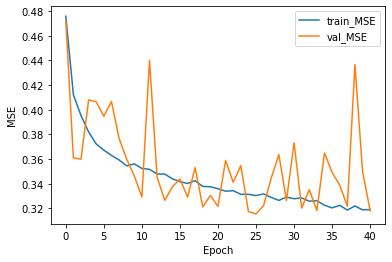

In [431]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un train MSE de 0.3304 y un val MSE de 0.3155 en 26 épocas. Mejores resultados hasta el momento. Tarda unos 70 segundos por época.

### Modelo 13. Tomamos datos cada 5 minutos de la hora anterior y predecimos a 15 minutos vista solo con datos atmosféricos como entrada y utilizando fórmula 2 de neuronas tomando el resto de datos de radiación. 

In [432]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=6)#tamaño 3 en principio (tipos de radiación) uno de cada 12, las horas exactas 
entrada2 = tf.keras.layers.Input(shape=6)
entrada3 = tf.keras.layers.Input(shape=6)
entrada4 = tf.keras.layers.Input(shape=6)
entrada5 = tf.keras.layers.Input(shape=6)
entrada6 = tf.keras.layers.Input(shape=6)
entrada7 = tf.keras.layers.Input(shape=6)
entrada8 = tf.keras.layers.Input(shape=6)
entrada9 = tf.keras.layers.Input(shape=6)
entrada10 = tf.keras.layers.Input(shape=6)
entrada11 = tf.keras.layers.Input(shape=6)
entrada12 = tf.keras.layers.Input(shape=6)
#Capas ocultas formula 2: Hidden =3/2*(In + Out)=3/2*(6+1)=10.5
oculta1 = tf.keras.layers.Dense(10.5, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(10.5, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(10.5, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(10.5, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(10.5, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(10.5, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(10.5, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(10.5, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(10.5, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(10.5, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(10.5, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(10.5, activation="relu")(entrada12)
concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12]) #estratificada, concatena las 12
#2 layers intermedias, formula 2: Hidden =3/2*(In + Out)=3/2*(1+1)=3
adoculta1=tf.keras.layers.Dense(3, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(3, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(3, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo13 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12], outputs=[salida])

modelo13.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo13.fit(X_trainest, Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2) 

Epoch 1/1000
3309/3309 [==============================] - 9s 2ms/step - loss: 0.5512 - mae: 0.5481 - val_loss: 0.4527 - val_mae: 0.4717
Epoch 2/1000
3309/3309 [==============================] - 8s 2ms/step - loss: 0.4624 - mae: 0.4823 - val_loss: 0.4507 - val_mae: 0.4881
Epoch 3/1000
3309/3309 [==============================] - 8s 2ms/step - loss: 0.4369 - mae: 0.4607 - val_loss: 0.4172 - val_mae: 0.4441
Epoch 4/1000
3309/3309 [==============================] - 8s 2ms/step - loss: 0.4260 - mae: 0.4510 - val_loss: 0.3815 - val_mae: 0.4310
Epoch 5/1000
3309/3309 [==============================] - 8s 2ms/step - loss: 0.4177 - mae: 0.4435 - val_loss: 0.4079 - val_mae: 0.4800
Epoch 6/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 0.4125 - mae: 0.4406 - val_loss: 0.4002 - val_mae: 0.4536
Epoch 7/1000
3309/3309 [==============================] - 8s 2ms/step - loss: 0.4083 - mae: 0.4382 - val_loss: 0.4498 - val_mae: 0.5157
Epoch 8/1000
3309/3309 [========================

Text(0, 0.5, 'MSE')

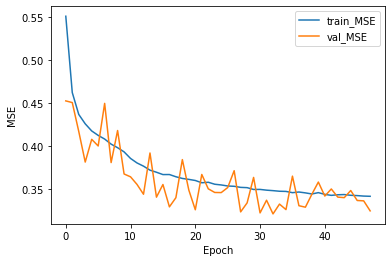

In [433]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un train MSE de 0.3482 y un val MSE de 0.3211 en 33 épocas. Similares a los de la fórmula 3, un poco peores .Tarda unos 8 segundos por época.

### Modelo 14. Tomamos datos cada 5 minutos de la hora anterior y predecimos a 15 minutos, utilizando fórmula 2 de neuronas tomando el resto de datos atmosféricos. Introducimos estos datos en la capa que concatena 

In [592]:
X_train1=np.array(PVGISdf.iloc[1:len(PVGISdf)-14:3,1:4]) #Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=np.array(PVGISdf.iloc[2:len(PVGISdf)-13:3,1:4]) #Tengo datos de radiación de 13:20-14:15 e introduzco producción a las 14:30.
X_train3=np.array(PVGISdf.iloc[3:len(PVGISdf)-12:3,1:4]) #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=np.array(PVGISdf.iloc[4:len(PVGISdf)-11:3,1:4])
X_train5=np.array(PVGISdf.iloc[5:len(PVGISdf)-10:3,1:4])
X_train6=np.array(PVGISdf.iloc[6:len(PVGISdf)-9:3,1:4])
X_train7=np.array(PVGISdf.iloc[7:len(PVGISdf)-8:3,1:4]) 
X_train8=np.array(PVGISdf.iloc[8:len(PVGISdf)-7:3,1:4])
X_train9=np.array(PVGISdf.iloc[9:len(PVGISdf)-6:3,1:4]) 
X_train10=np.array(PVGISdf.iloc[10:len(PVGISdf)-5:3,1:4])
X_train11=np.array(PVGISdf.iloc[11:len(PVGISdf)-4:3,1:4])
X_train12=np.array(PVGISdf.iloc[12:len(PVGISdf)-3:3,1:4]) #Tomo datos hasta las 22:30 del 16/12/2018 para que mi última predicción sea la de las 22:45

X_trainatm1=np.array(PVGISdf.iloc[1:len(PVGISdf)-14:3,4:7])  
X_trainatm2=np.array(PVGISdf.iloc[2:len(PVGISdf)-13:3,4:7]) 
X_trainatm3=np.array(PVGISdf.iloc[3:len(PVGISdf)-12:3,4:7]) 
X_trainatm4=np.array(PVGISdf.iloc[4:len(PVGISdf)-11:3,4:7])
X_trainatm5=np.array(PVGISdf.iloc[5:len(PVGISdf)-10:3,4:7])
X_trainatm6=np.array(PVGISdf.iloc[6:len(PVGISdf)-9:3,4:7])
X_trainatm7=np.array(PVGISdf.iloc[7:len(PVGISdf)-8:3,4:7]) 
X_trainatm8=np.array(PVGISdf.iloc[8:len(PVGISdf)-7:3,4:7])
X_trainatm9=np.array(PVGISdf.iloc[9:len(PVGISdf)-6:3,4:7]) 
X_trainatm10=np.array(PVGISdf.iloc[10:len(PVGISdf)-5:3,4:7])
X_trainatm11=np.array(PVGISdf.iloc[11:len(PVGISdf)-4:3,4:7])
X_trainatm12=np.array(PVGISdf.iloc[12:len(PVGISdf)-3:3,4:7])

y_train=np.array(PVOutputdf.iloc[5:len(PVOutputdf),1]).astype(float) #No tomo los primeros 5 valores para cuadrarlo

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 
X_train7std=np.std(X_train7) 
X_train8std=np.std(X_train8)
X_train9std=np.std(X_train9)
X_train10std=np.std(X_train10) 
X_train11std=np.std(X_train11) 
X_train12std=np.std(X_train12)

X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 
X_train7est=X_train7/X_train7std 
X_train8est=X_train8/X_train8std
X_train9est=X_train9/X_train9std 
X_train10est=X_train10/X_train10std 
X_train11est=X_train11/X_train11std 
X_train12est=X_train12/X_train12std
X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est,X_train7est,X_train8est,X_train9est,X_train10est,X_train11est,X_train12est)

X_trainatm1std=np.std(X_trainatm1)  
X_trainatm2std=np.std(X_trainatm2) 
X_trainatm3std=np.std(X_trainatm3) 
X_trainatm4std=np.std(X_trainatm4)
X_trainatm5std=np.std(X_trainatm5)
X_trainatm6std=np.std(X_trainatm6)
X_trainatm7std=np.std(X_trainatm7)
X_trainatm8std=np.std(X_trainatm8)
X_trainatm9std=np.std(X_trainatm9) 
X_trainatm10std=np.std(X_trainatm10)
X_trainatm11std=np.std(X_trainatm11)
X_trainatm12std=np.std(X_trainatm12)

X_trainatm1est=X_trainatm1/X_trainatm1std 
X_trainatm2est=X_trainatm2/X_trainatm2std 
X_trainatm3est=X_trainatm3/X_trainatm3std 
X_trainatm4est=X_trainatm4/X_trainatm4std
X_trainatm5est=X_trainatm5/X_trainatm5std 
X_trainatm6est=X_trainatm6/X_trainatm6std 
X_trainatm7est=X_trainatm7/X_trainatm7std 
X_trainatm8est=X_trainatm8/X_trainatm8std
X_trainatm9est=X_trainatm9/X_trainatm9std 
X_trainatm10est=X_trainatm10/X_trainatm10std 
X_trainatm11est=X_trainatm11/X_trainatm11std 
X_trainatm12est=X_trainatm12/X_trainatm12std

X_trainatmest=(X_trainatm1est,X_trainatm2est,X_trainatm3est,X_trainatm4est,X_trainatm5est,X_trainatm6est,X_trainatm7est,X_trainatm8est,X_trainatm9est,X_trainatm10est,X_trainatm11est,X_trainatm12est)

Y_trainstd=np.std(y_train) 
Y_trainest=y_train/Y_trainstd 

In [595]:
print(Y_trainstd)
print(np.max(y_train))
print(np.max(y_train)/Y_trainstd)

79706.81104869608
283061.0
3.5512774413602712


In [448]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3)#tamaño 3 en principio (tipos de radiación) uno de cada 12, las horas exactas 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)

entradaatm1 = tf.keras.layers.Input(shape=3) 
entradaatm2 = tf.keras.layers.Input(shape=3)
entradaatm3 = tf.keras.layers.Input(shape=3)
entradaatm4 = tf.keras.layers.Input(shape=3)
entradaatm5 = tf.keras.layers.Input(shape=3)
entradaatm6 = tf.keras.layers.Input(shape=3)
entradaatm7 = tf.keras.layers.Input(shape=3)
entradaatm8 = tf.keras.layers.Input(shape=3)
entradaatm9 = tf.keras.layers.Input(shape=3)
entradaatm10 = tf.keras.layers.Input(shape=3)
entradaatm11 = tf.keras.layers.Input(shape=3)
entradaatm12 = tf.keras.layers.Input(shape=3) 

#Capas ocultas formula 2: Hidden =3/2*(In + Out)=3/2*(3+1)=6
oculta1 = tf.keras.layers.Dense(6, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(6, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(6, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(6, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(6, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(6, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(6, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(6, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(6, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(6, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(6, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(6, activation="relu")(entrada12)
concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12]) #estratificada, concatena las 12
#2 layers intermedias, formula 2: Hidden =3/2*(In + Out)=3/2*(1+1)=3
adoculta1=tf.keras.layers.Dense(3, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(3, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(3, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo14 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12], outputs=[salida])

modelo14.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo14.fit([X_trainest,X_trainatmest], Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2)
#Mucho mejor resultado introduciendo entre corchetes que entre paréntesis (X_trainest,X_trainatmest)
#No estoy 100% seguro de que esté bien introducido así, cómo sabe que las entradai corresponden a X_train y que entradaatmi corresponden a X_trainatm?

Epoch 1/1000
3309/3309 [==============================] - 13s 3ms/step - loss: 0.5038 - mae: 0.5167 - val_loss: 0.4349 - val_mae: 0.4852
Epoch 2/1000
3309/3309 [==============================] - 13s 4ms/step - loss: 0.4434 - mae: 0.4709 - val_loss: 0.4052 - val_mae: 0.4512
Epoch 3/1000
3309/3309 [==============================] - 8s 3ms/step - loss: 0.4191 - mae: 0.4539 - val_loss: 0.3785 - val_mae: 0.4295
Epoch 4/1000
3309/3309 [==============================] - 8s 3ms/step - loss: 0.4020 - mae: 0.4414 - val_loss: 0.4156 - val_mae: 0.4815
Epoch 5/1000
3309/3309 [==============================] - 8s 3ms/step - loss: 0.3914 - mae: 0.4332 - val_loss: 0.4071 - val_mae: 0.4883
Epoch 6/1000
3309/3309 [==============================] - 9s 3ms/step - loss: 0.3837 - mae: 0.4263 - val_loss: 0.3850 - val_mae: 0.4069
Epoch 7/1000
3309/3309 [==============================] - 11s 3ms/step - loss: 0.3782 - mae: 0.4216 - val_loss: 0.3472 - val_mae: 0.4001
Epoch 8/1000
3309/3309 [=====================

Text(0, 0.5, 'MSE')

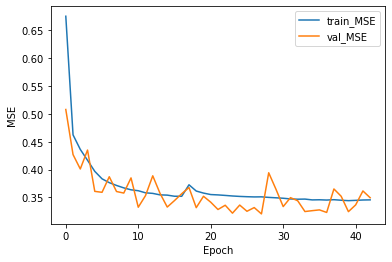

In [445]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un train MSE de 0.3439  y un val MSE de 0.3159  en 27 épocas. Similares al modelo 13, pero mejores.Tarda unos 9 segundos por época.

### Modelo 15. Tomamos datos cada 5 minutos de la hora anterior y predecimos a 15 minutos, utilizando fórmula 2 de neuronas tomando el resto de datos atmosféricos. Introducimos estos datos en otra capa que concatena 

In [450]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3)#tamaño 3 en principio (tipos de radiación) uno de cada 12, las horas exactas 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)

entradaatm1 = tf.keras.layers.Input(shape=3) 
entradaatm2 = tf.keras.layers.Input(shape=3)
entradaatm3 = tf.keras.layers.Input(shape=3)
entradaatm4 = tf.keras.layers.Input(shape=3)
entradaatm5 = tf.keras.layers.Input(shape=3)
entradaatm6 = tf.keras.layers.Input(shape=3)
entradaatm7 = tf.keras.layers.Input(shape=3)
entradaatm8 = tf.keras.layers.Input(shape=3)
entradaatm9 = tf.keras.layers.Input(shape=3)
entradaatm10 = tf.keras.layers.Input(shape=3)
entradaatm11 = tf.keras.layers.Input(shape=3)
entradaatm12 = tf.keras.layers.Input(shape=3) 

#Capas ocultas formula 2: Hidden =3/2*(In + Out)=3/2*(3+1)=6
oculta1 = tf.keras.layers.Dense(6, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(6, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(6, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(6, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(6, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(6, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(6, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(6, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(6, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(6, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(6, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(6, activation="relu")(entrada12)
concat1 = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12]) #estratificada, concatena las 12
concat2 = tf.keras.layers.Concatenate()([entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12])
#2 layers intermedias, formula 2: Hidden =3/2*(In + Out)=3/2*(1+1)=3
adoculta1=tf.keras.layers.Dense(3, activation="relu")(concat1)
adoculta2=tf.keras.layers.Dense(3, activation="relu")(concat2)
concat3 = tf.keras.layers.Concatenate()([adoculta1, adoculta2]) #estratificada, concatena las 12
salida=tf.keras.layers.Dense(3, activation='relu')(concat3) #produccion en los siguientes 15 minutos
modelo15 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12], outputs=[salida])

modelo15.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo15.fit([X_trainest,X_trainatmest], Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2)


Epoch 1/1000
3309/3309 [==============================] - 9s 3ms/step - loss: 0.5641 - mae: 0.5457 - val_loss: 0.4806 - val_mae: 0.5215
Epoch 2/1000
3309/3309 [==============================] - 9s 3ms/step - loss: 0.4618 - mae: 0.4952 - val_loss: 0.4717 - val_mae: 0.5393
Epoch 3/1000
3309/3309 [==============================] - 8s 3ms/step - loss: 0.4465 - mae: 0.4841 - val_loss: 0.4318 - val_mae: 0.4848
Epoch 4/1000
3309/3309 [==============================] - 9s 3ms/step - loss: 0.4354 - mae: 0.4759 - val_loss: 0.4119 - val_mae: 0.4788
Epoch 5/1000
3309/3309 [==============================] - 9s 3ms/step - loss: 0.4277 - mae: 0.4704 - val_loss: 0.4408 - val_mae: 0.5210
Epoch 6/1000
3309/3309 [==============================] - 9s 3ms/step - loss: 0.4216 - mae: 0.4658 - val_loss: 0.4399 - val_mae: 0.5190
Epoch 7/1000
3309/3309 [==============================] - 9s 3ms/step - loss: 0.4176 - mae: 0.4635 - val_loss: 0.3995 - val_mae: 0.4382
Epoch 8/1000
3309/3309 [========================

Epoch 61/1000
3309/3309 [==============================] - 8s 2ms/step - loss: 0.3478 - mae: 0.3866 - val_loss: 0.3475 - val_mae: 0.4223
Epoch 62/1000
3309/3309 [==============================] - 8s 2ms/step - loss: 0.3475 - mae: 0.3860 - val_loss: 0.3623 - val_mae: 0.4174


Text(0, 0.5, 'MSE')

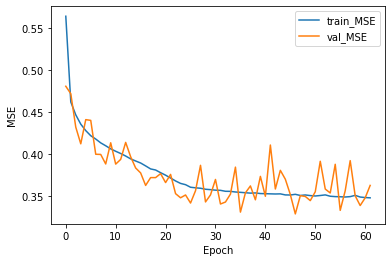

In [451]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un train MSE de 0.3517 y un val MSE de 0.3283 en 47 épocas. .Tarda unos 9 segundos por época. No mejora el modelo 14

### Modelo 16. Tomamos datos cada 5 minutos de la MEDIA hora anterior y predecimos a 15 minutos, utilizando fórmula 2 de neuronas tomando el resto de datos atmosféricos. Introducimos estos datos en la capa que concatena 

In [453]:
X_train1=np.array(PVGISdf.iloc[1:len(PVGISdf)-8:3,1:4]) #Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=np.array(PVGISdf.iloc[2:len(PVGISdf)-7:3,1:4]) #Tengo datos de radiación de 13:20-13:45 e introduzco producción a las 14:30.
X_train3=np.array(PVGISdf.iloc[3:len(PVGISdf)-6:3,1:4]) #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=np.array(PVGISdf.iloc[4:len(PVGISdf)-5:3,1:4])
X_train5=np.array(PVGISdf.iloc[5:len(PVGISdf)-4:3,1:4])
X_train6=np.array(PVGISdf.iloc[6:len(PVGISdf)-3:3,1:4])
 #Tomo datos hasta las 22:30 del 16/12/2018 para que mi última predicción sea la de las 22:45

X_trainatm1=np.array(PVGISdf.iloc[1:len(PVGISdf)-8:3,4:7])  
X_trainatm2=np.array(PVGISdf.iloc[2:len(PVGISdf)-7:3,4:7]) 
X_trainatm3=np.array(PVGISdf.iloc[3:len(PVGISdf)-6:3,4:7]) 
X_trainatm4=np.array(PVGISdf.iloc[4:len(PVGISdf)-5:3,4:7])
X_trainatm5=np.array(PVGISdf.iloc[5:len(PVGISdf)-4:3,4:7])
X_trainatm6=np.array(PVGISdf.iloc[6:len(PVGISdf)-3:3,4:7])

y_train=np.array(PVOutputdf.iloc[3:len(PVOutputdf),1]).astype(float) #No tomo los primeros 5 valores para cuadrarlo

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 


X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 

X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est)

X_trainatm1std=np.std(X_trainatm1)  
X_trainatm2std=np.std(X_trainatm2) 
X_trainatm3std=np.std(X_trainatm3) 
X_trainatm4std=np.std(X_trainatm4)
X_trainatm5std=np.std(X_trainatm5)
X_trainatm6std=np.std(X_trainatm6)


X_trainatm1est=X_trainatm1/X_trainatm1std 
X_trainatm2est=X_trainatm2/X_trainatm2std 
X_trainatm3est=X_trainatm3/X_trainatm3std 
X_trainatm4est=X_trainatm4/X_trainatm4std
X_trainatm5est=X_trainatm5/X_trainatm5std 
X_trainatm6est=X_trainatm6/X_trainatm6std 

X_trainatmest=(X_trainatm1est,X_trainatm2est,X_trainatm3est,X_trainatm4est,X_trainatm5est,X_trainatm6est)

Y_trainstd=np.std(y_train) 
Y_trainest=y_train/Y_trainstd 

In [454]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3)#tamaño 3 en principio (tipos de radiación) uno de cada 12, las horas exactas 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)

entradaatm1 = tf.keras.layers.Input(shape=3) 
entradaatm2 = tf.keras.layers.Input(shape=3)
entradaatm3 = tf.keras.layers.Input(shape=3)
entradaatm4 = tf.keras.layers.Input(shape=3)
entradaatm5 = tf.keras.layers.Input(shape=3)
entradaatm6 = tf.keras.layers.Input(shape=3)


#Capas ocultas formula 2: Hidden =3/2*(In + Out)=3/2*(3+1)=6
oculta1 = tf.keras.layers.Dense(6, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(6, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(6, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(6, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(6, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(6, activation="relu")(entrada6)

concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6]) 
#2 layers intermedias, formula 2: Hidden =3/2*(In + Out)=3/2*(1+1)=3
adoculta1=tf.keras.layers.Dense(3, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(3, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(3, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo16 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6], outputs=[salida])

modelo16.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo16.fit([X_trainest,X_trainatmest], Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2)
#Mucho mejor resultado introduciendo entre corchetes que entre paréntesis (X_trainest,X_trainatmest)
#No estoy 100% seguro de que esté bien introducido así, cómo sabe que las entradai corresponden a X_train y que entradaatmi corresponden a X_trainatm?

Epoch 1/1000
3309/3309 [==============================] - 8s 2ms/step - loss: 0.9854 - mae: 0.6914 - val_loss: 1.0338 - val_mae: 0.7013
Epoch 2/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 0.9173 - mae: 0.6445 - val_loss: 1.0481 - val_mae: 0.7231
Epoch 3/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 0.9095 - mae: 0.6373 - val_loss: 0.9944 - val_mae: 0.6712
Epoch 4/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 0.9027 - mae: 0.6313 - val_loss: 0.9886 - val_mae: 0.6719
Epoch 5/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 0.8976 - mae: 0.6269 - val_loss: 0.9830 - val_mae: 0.6667
Epoch 6/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 0.8936 - mae: 0.6231 - val_loss: 0.9872 - val_mae: 0.6650
Epoch 7/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 0.8898 - mae: 0.6195 - val_loss: 0.9695 - val_mae: 0.6460
Epoch 8/1000
3309/3309 [========================

Epoch 61/1000
3309/3309 [==============================] - 6s 2ms/step - loss: 0.8171 - mae: 0.5564 - val_loss: 0.9015 - val_mae: 0.5961
Epoch 62/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 0.8172 - mae: 0.5563 - val_loss: 0.9698 - val_mae: 0.6575


Text(0, 0.5, 'MSE')

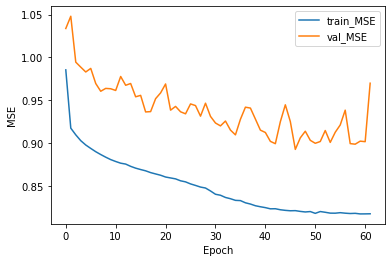

In [455]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un train MSE de 0.8209 y un val MSE de 0.8925  en 47 épocas. Mal funcionamiento, predice mucho mejor con los datos de 1 hora antes que con los de media hora, por lo que probamos a introducir datos de 1h y 30 minutos antes

### Modelo 17. Tomamos datos cada 5 minutos de UNA HORA Y MEDIA anterior y predecimos a 15 minutos, utilizando fórmula 2 de neuronas tomando el resto de datos atmosféricos. Introducimos estos datos en la capa que concatena. 

In [457]:
X_train1=np.array(PVGISdf.iloc[1:len(PVGISdf)-20:3,1:4]) #Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=np.array(PVGISdf.iloc[2:len(PVGISdf)-19:3,1:4]) #Tengo datos de radiación de 13:20-14:45 e introduzco producción a las 15:00.
X_train3=np.array(PVGISdf.iloc[3:len(PVGISdf)-18:3,1:4]) #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=np.array(PVGISdf.iloc[4:len(PVGISdf)-17:3,1:4])
X_train5=np.array(PVGISdf.iloc[5:len(PVGISdf)-16:3,1:4])
X_train6=np.array(PVGISdf.iloc[6:len(PVGISdf)-15:3,1:4])
X_train7=np.array(PVGISdf.iloc[7:len(PVGISdf)-14:3,1:4]) 
X_train8=np.array(PVGISdf.iloc[8:len(PVGISdf)-13:3,1:4])
X_train9=np.array(PVGISdf.iloc[9:len(PVGISdf)-12:3,1:4]) 
X_train10=np.array(PVGISdf.iloc[10:len(PVGISdf)-11:3,1:4])
X_train11=np.array(PVGISdf.iloc[11:len(PVGISdf)-10:3,1:4])
X_train12=np.array(PVGISdf.iloc[12:len(PVGISdf)-9:3,1:4]) #Tomo datos hasta las 22:30 del 16/12/2018 para que mi última predicción sea la de las 22:45
X_train13=np.array(PVGISdf.iloc[13:len(PVGISdf)-8:3,1:4])  
X_train14=np.array(PVGISdf.iloc[14:len(PVGISdf)-7:3,1:4]) 
X_train15=np.array(PVGISdf.iloc[15:len(PVGISdf)-6:3,1:4]) 
X_train16=np.array(PVGISdf.iloc[16:len(PVGISdf)-5:3,1:4])
X_train17=np.array(PVGISdf.iloc[17:len(PVGISdf)-4:3,1:4])
X_train18=np.array(PVGISdf.iloc[18:len(PVGISdf)-3:3,1:4])

X_trainatm1=np.array(PVGISdf.iloc[1:len(PVGISdf)-20:3,4:7])  
X_trainatm2=np.array(PVGISdf.iloc[2:len(PVGISdf)-19:3,4:7]) 
X_trainatm3=np.array(PVGISdf.iloc[3:len(PVGISdf)-18:3,4:7]) 
X_trainatm4=np.array(PVGISdf.iloc[4:len(PVGISdf)-17:3,4:7])
X_trainatm5=np.array(PVGISdf.iloc[5:len(PVGISdf)-16:3,4:7])
X_trainatm6=np.array(PVGISdf.iloc[6:len(PVGISdf)-15:3,4:7])
X_trainatm7=np.array(PVGISdf.iloc[7:len(PVGISdf)-14:3,4:7]) 
X_trainatm8=np.array(PVGISdf.iloc[8:len(PVGISdf)-13:3,4:7])
X_trainatm9=np.array(PVGISdf.iloc[9:len(PVGISdf)-12:3,4:7]) 
X_trainatm10=np.array(PVGISdf.iloc[10:len(PVGISdf)-11:3,4:7])
X_trainatm11=np.array(PVGISdf.iloc[11:len(PVGISdf)-10:3,4:7])
X_trainatm12=np.array(PVGISdf.iloc[12:len(PVGISdf)-9:3,4:7])
X_trainatm13=np.array(PVGISdf.iloc[13:len(PVGISdf)-8:3,4:7])  
X_trainatm14=np.array(PVGISdf.iloc[14:len(PVGISdf)-7:3,4:7]) 
X_trainatm15=np.array(PVGISdf.iloc[15:len(PVGISdf)-6:3,4:7]) 
X_trainatm16=np.array(PVGISdf.iloc[16:len(PVGISdf)-5:3,4:7])
X_trainatm17=np.array(PVGISdf.iloc[17:len(PVGISdf)-4:3,4:7])
X_trainatm18=np.array(PVGISdf.iloc[18:len(PVGISdf)-3:3,4:7])

y_train=np.array(PVOutputdf.iloc[7:len(PVOutputdf),1]).astype(float) #No tomo los primeros 7 valores para cuadrarlo, que empiece a las 15

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 
X_train7std=np.std(X_train7) 
X_train8std=np.std(X_train8)
X_train9std=np.std(X_train9)
X_train10std=np.std(X_train10) 
X_train11std=np.std(X_train11) 
X_train12std=np.std(X_train12)
X_train13std=np.std(X_train13) 
X_train14std=np.std(X_train14) 
X_train15std=np.std(X_train15)
X_train16std=np.std(X_train16)
X_train17std=np.std(X_train17) 
X_train18std=np.std(X_train18) 


X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 
X_train7est=X_train7/X_train7std 
X_train8est=X_train8/X_train8std
X_train9est=X_train9/X_train9std 
X_train10est=X_train10/X_train10std 
X_train11est=X_train11/X_train11std 
X_train12est=X_train12/X_train12std
X_train13est=X_train13/X_train13std 
X_train14est=X_train14/X_train14std
X_train15est=X_train15/X_train15std 
X_train16est=X_train16/X_train16std 
X_train17est=X_train17/X_train17std 
X_train18est=X_train18/X_train18std

X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est,X_train7est,X_train8est,X_train9est,X_train10est,X_train11est,X_train12est,X_train13est,X_train14est,X_train15est,X_train16est,X_train17est,X_train18est)

X_trainatm1std=np.std(X_trainatm1)  
X_trainatm2std=np.std(X_trainatm2) 
X_trainatm3std=np.std(X_trainatm3) 
X_trainatm4std=np.std(X_trainatm4)
X_trainatm5std=np.std(X_trainatm5)
X_trainatm6std=np.std(X_trainatm6)
X_trainatm7std=np.std(X_trainatm7)
X_trainatm8std=np.std(X_trainatm8)
X_trainatm9std=np.std(X_trainatm9) 
X_trainatm10std=np.std(X_trainatm10)
X_trainatm11std=np.std(X_trainatm11)
X_trainatm12std=np.std(X_trainatm12)
X_trainatm13std=np.std(X_trainatm13)
X_trainatm14std=np.std(X_trainatm14)
X_trainatm15std=np.std(X_trainatm15) 
X_trainatm16std=np.std(X_trainatm16)
X_trainatm17std=np.std(X_trainatm17)
X_trainatm18std=np.std(X_trainatm18)

X_trainatm1est=X_trainatm1/X_trainatm1std 
X_trainatm2est=X_trainatm2/X_trainatm2std 
X_trainatm3est=X_trainatm3/X_trainatm3std 
X_trainatm4est=X_trainatm4/X_trainatm4std
X_trainatm5est=X_trainatm5/X_trainatm5std 
X_trainatm6est=X_trainatm6/X_trainatm6std 
X_trainatm7est=X_trainatm7/X_trainatm7std 
X_trainatm8est=X_trainatm8/X_trainatm8std
X_trainatm9est=X_trainatm9/X_trainatm9std 
X_trainatm10est=X_trainatm10/X_trainatm10std 
X_trainatm11est=X_trainatm11/X_trainatm11std 
X_trainatm12est=X_trainatm12/X_trainatm12std
X_trainatm13est=X_trainatm13/X_trainatm13std 
X_trainatm14est=X_trainatm14/X_trainatm14std 
X_trainatm15est=X_trainatm15/X_trainatm15std
X_trainatm16est=X_trainatm16/X_trainatm16std 
X_trainatm17est=X_trainatm17/X_trainatm17std 
X_trainatm18est=X_trainatm18/X_trainatm18std

X_trainatmest=(X_trainatm1est,X_trainatm2est,X_trainatm3est,X_trainatm4est,X_trainatm5est,X_trainatm6est,X_trainatm7est,X_trainatm8est,X_trainatm9est,X_trainatm10est,X_trainatm11est,X_trainatm12est,X_trainatm13est,X_trainatm14est,X_trainatm15est,X_trainatm16est,X_trainatm17est,X_trainatm18est)

Y_trainstd=np.std(y_train) 
Y_trainest=y_train/Y_trainstd 

In [458]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)
entrada13 = tf.keras.layers.Input(shape=3)
entrada14 = tf.keras.layers.Input(shape=3)
entrada15 = tf.keras.layers.Input(shape=3)
entrada16 = tf.keras.layers.Input(shape=3)
entrada17 = tf.keras.layers.Input(shape=3)
entrada18 = tf.keras.layers.Input(shape=3)

entradaatm1 = tf.keras.layers.Input(shape=3) 
entradaatm2 = tf.keras.layers.Input(shape=3)
entradaatm3 = tf.keras.layers.Input(shape=3)
entradaatm4 = tf.keras.layers.Input(shape=3)
entradaatm5 = tf.keras.layers.Input(shape=3)
entradaatm6 = tf.keras.layers.Input(shape=3)
entradaatm7 = tf.keras.layers.Input(shape=3)
entradaatm8 = tf.keras.layers.Input(shape=3)
entradaatm9 = tf.keras.layers.Input(shape=3)
entradaatm10 = tf.keras.layers.Input(shape=3)
entradaatm11 = tf.keras.layers.Input(shape=3)
entradaatm12 = tf.keras.layers.Input(shape=3)
entradaatm13 = tf.keras.layers.Input(shape=3)
entradaatm14 = tf.keras.layers.Input(shape=3)
entradaatm15 = tf.keras.layers.Input(shape=3) 
entradaatm16 = tf.keras.layers.Input(shape=3)
entradaatm17 = tf.keras.layers.Input(shape=3)
entradaatm18 = tf.keras.layers.Input(shape=3)

#Capas ocultas formula 2: Hidden =3/2*(In + Out)=3/2*(3+1)=6
oculta1 = tf.keras.layers.Dense(6, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(6, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(6, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(6, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(6, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(6, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(6, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(6, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(6, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(6, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(6, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(6, activation="relu")(entrada12)
oculta13 = tf.keras.layers.Dense(6, activation="relu")(entrada13)
oculta14 = tf.keras.layers.Dense(6, activation="relu")(entrada14)
oculta15 = tf.keras.layers.Dense(6, activation="relu")(entrada15)
oculta16 = tf.keras.layers.Dense(6, activation="relu")(entrada16)
oculta17 = tf.keras.layers.Dense(6, activation="relu")(entrada17)
oculta18 = tf.keras.layers.Dense(6, activation="relu")(entrada18)

concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12, oculta13, oculta14, oculta15, oculta16, oculta17, oculta18,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18]) #estratificada, concatena las 12
#2 layers intermedias, formula 2: Hidden =3/2*(In + Out)=3/2*(1+1)=3
adoculta1=tf.keras.layers.Dense(3, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(3, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(3, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo17 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12, entrada13, entrada14, entrada15, entrada16, entrada17, entrada18,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18], outputs=[salida])

modelo17.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo17.fit([X_trainest,X_trainatmest], Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2)
#Mucho mejor resultado introduciendo entre corchetes que entre paréntesis (X_trainest,X_trainatmest)
#No estoy 100% seguro de que esté bien introducido así, cómo sabe que las entradai corresponden a X_train y que entradaatmi corresponden a X_trainatm?

Epoch 1/1000
3308/3308 [==============================] - 11s 3ms/step - loss: 0.4511 - mae: 0.4750 - val_loss: 0.3825 - val_mae: 0.4747
Epoch 2/1000
3308/3308 [==============================] - 10s 3ms/step - loss: 0.3661 - mae: 0.4087 - val_loss: 0.3250 - val_mae: 0.3979
Epoch 3/1000
3308/3308 [==============================] - 10s 3ms/step - loss: 0.3418 - mae: 0.3845 - val_loss: 0.3204 - val_mae: 0.4110
Epoch 4/1000
3308/3308 [==============================] - 10s 3ms/step - loss: 0.3294 - mae: 0.3702 - val_loss: 0.2941 - val_mae: 0.3376
Epoch 5/1000
3308/3308 [==============================] - 10s 3ms/step - loss: 0.3236 - mae: 0.3622 - val_loss: 0.3234 - val_mae: 0.3973
Epoch 6/1000
3308/3308 [==============================] - 10s 3ms/step - loss: 0.3200 - mae: 0.3573 - val_loss: 0.2854 - val_mae: 0.3527
Epoch 7/1000
3308/3308 [==============================] - 10s 3ms/step - loss: 0.3181 - mae: 0.3544 - val_loss: 0.3010 - val_mae: 0.3687
Epoch 8/1000
3308/3308 [=================

Text(0, 0.5, 'MSE')

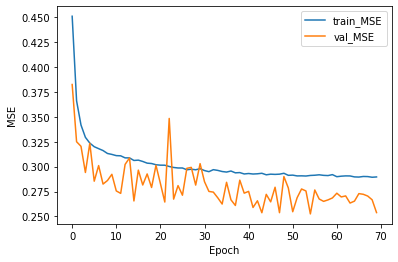

In [459]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un train MSE de 0.2911 y un val MSE de 0.2525  en 55 épocas. Mejores resultados hasta el momento.Tarda unos 11 segundos por época. Parece que cuantos más datos de radiación anteriores tenga, mejor predice. Probaremos con 2 horas de datos antes

### Modelo 18. Tomamos datos cada 5 minutos de DOS HORAS antes y predecimos a 15 minutos, utilizando fórmula 2 de neuronas tomando el resto de datos atmosféricos. Introducimos estos datos en la capa que concatena. 

In [461]:
X_train1=np.array(PVGISdf.iloc[1:len(PVGISdf)-26:3,1:4]) #Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=np.array(PVGISdf.iloc[2:len(PVGISdf)-25:3,1:4]) #Tengo datos de radiación de 13:20-15:15 e introduzco producción a las 15:30.
X_train3=np.array(PVGISdf.iloc[3:len(PVGISdf)-24:3,1:4]) #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=np.array(PVGISdf.iloc[4:len(PVGISdf)-23:3,1:4])
X_train5=np.array(PVGISdf.iloc[5:len(PVGISdf)-22:3,1:4])
X_train6=np.array(PVGISdf.iloc[6:len(PVGISdf)-21:3,1:4])
X_train7=np.array(PVGISdf.iloc[7:len(PVGISdf)-20:3,1:4]) 
X_train8=np.array(PVGISdf.iloc[8:len(PVGISdf)-19:3,1:4])
X_train9=np.array(PVGISdf.iloc[9:len(PVGISdf)-18:3,1:4]) 
X_train10=np.array(PVGISdf.iloc[10:len(PVGISdf)-17:3,1:4])
X_train11=np.array(PVGISdf.iloc[11:len(PVGISdf)-16:3,1:4])
X_train12=np.array(PVGISdf.iloc[12:len(PVGISdf)-15:3,1:4]) #Tomo datos hasta las 22:30 del 16/12/2018 para que mi última predicción sea la de las 22:45
X_train13=np.array(PVGISdf.iloc[13:len(PVGISdf)-14:3,1:4])  
X_train14=np.array(PVGISdf.iloc[14:len(PVGISdf)-13:3,1:4]) 
X_train15=np.array(PVGISdf.iloc[15:len(PVGISdf)-12:3,1:4]) 
X_train16=np.array(PVGISdf.iloc[16:len(PVGISdf)-11:3,1:4])
X_train17=np.array(PVGISdf.iloc[17:len(PVGISdf)-10:3,1:4])
X_train18=np.array(PVGISdf.iloc[18:len(PVGISdf)-9:3,1:4])
X_train19=np.array(PVGISdf.iloc[19:len(PVGISdf)-8:3,1:4])  
X_train20=np.array(PVGISdf.iloc[20:len(PVGISdf)-7:3,1:4]) 
X_train21=np.array(PVGISdf.iloc[21:len(PVGISdf)-6:3,1:4]) 
X_train22=np.array(PVGISdf.iloc[22:len(PVGISdf)-5:3,1:4])
X_train23=np.array(PVGISdf.iloc[23:len(PVGISdf)-4:3,1:4])
X_train24=np.array(PVGISdf.iloc[24:len(PVGISdf)-3:3,1:4])

X_trainatm1=np.array(PVGISdf.iloc[1:len(PVGISdf)-26:3,4:7])  
X_trainatm2=np.array(PVGISdf.iloc[2:len(PVGISdf)-25:3,4:7]) 
X_trainatm3=np.array(PVGISdf.iloc[3:len(PVGISdf)-24:3,4:7]) 
X_trainatm4=np.array(PVGISdf.iloc[4:len(PVGISdf)-23:3,4:7])
X_trainatm5=np.array(PVGISdf.iloc[5:len(PVGISdf)-22:3,4:7])
X_trainatm6=np.array(PVGISdf.iloc[6:len(PVGISdf)-21:3,4:7])
X_trainatm7=np.array(PVGISdf.iloc[7:len(PVGISdf)-20:3,4:7]) 
X_trainatm8=np.array(PVGISdf.iloc[8:len(PVGISdf)-19:3,4:7])
X_trainatm9=np.array(PVGISdf.iloc[9:len(PVGISdf)-18:3,4:7]) 
X_trainatm10=np.array(PVGISdf.iloc[10:len(PVGISdf)-17:3,4:7])
X_trainatm11=np.array(PVGISdf.iloc[11:len(PVGISdf)-16:3,4:7])
X_trainatm12=np.array(PVGISdf.iloc[12:len(PVGISdf)-15:3,4:7])
X_trainatm13=np.array(PVGISdf.iloc[13:len(PVGISdf)-14:3,4:7])  
X_trainatm14=np.array(PVGISdf.iloc[14:len(PVGISdf)-13:3,4:7]) 
X_trainatm15=np.array(PVGISdf.iloc[15:len(PVGISdf)-12:3,4:7]) 
X_trainatm16=np.array(PVGISdf.iloc[16:len(PVGISdf)-11:3,4:7])
X_trainatm17=np.array(PVGISdf.iloc[17:len(PVGISdf)-10:3,4:7])
X_trainatm18=np.array(PVGISdf.iloc[18:len(PVGISdf)-9:3,4:7])
X_trainatm19=np.array(PVGISdf.iloc[19:len(PVGISdf)-8:3,4:7])  
X_trainatm20=np.array(PVGISdf.iloc[20:len(PVGISdf)-7:3,4:7]) 
X_trainatm21=np.array(PVGISdf.iloc[21:len(PVGISdf)-6:3,4:7]) 
X_trainatm22=np.array(PVGISdf.iloc[22:len(PVGISdf)-5:3,4:7])
X_trainatm23=np.array(PVGISdf.iloc[23:len(PVGISdf)-4:3,4:7])
X_trainatm24=np.array(PVGISdf.iloc[24:len(PVGISdf)-3:3,4:7])

y_train=np.array(PVOutputdf.iloc[9:len(PVOutputdf),1]).astype(float) #No tomo los primeros 7 valores para cuadrarlo, que empiece a las 15

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 
X_train7std=np.std(X_train7) 
X_train8std=np.std(X_train8)
X_train9std=np.std(X_train9)
X_train10std=np.std(X_train10) 
X_train11std=np.std(X_train11) 
X_train12std=np.std(X_train12)
X_train13std=np.std(X_train13) 
X_train14std=np.std(X_train14) 
X_train15std=np.std(X_train15)
X_train16std=np.std(X_train16)
X_train17std=np.std(X_train17) 
X_train18std=np.std(X_train18)
X_train19std=np.std(X_train19) 
X_train20std=np.std(X_train20) 
X_train21std=np.std(X_train21)
X_train22std=np.std(X_train22)
X_train23std=np.std(X_train23) 
X_train24std=np.std(X_train24) 


X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 
X_train7est=X_train7/X_train7std 
X_train8est=X_train8/X_train8std
X_train9est=X_train9/X_train9std 
X_train10est=X_train10/X_train10std 
X_train11est=X_train11/X_train11std 
X_train12est=X_train12/X_train12std
X_train13est=X_train13/X_train13std 
X_train14est=X_train14/X_train14std
X_train15est=X_train15/X_train15std 
X_train16est=X_train16/X_train16std 
X_train17est=X_train17/X_train17std 
X_train18est=X_train18/X_train18std
X_train19est=X_train19/X_train19std 
X_train20est=X_train20/X_train20std
X_train21est=X_train21/X_train21std 
X_train22est=X_train22/X_train22std 
X_train23est=X_train23/X_train23std 
X_train24est=X_train24/X_train24std

X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est,X_train7est,X_train8est,X_train9est,X_train10est,X_train11est,X_train12est,X_train13est,X_train14est,X_train15est,X_train16est,X_train17est,X_train18est,X_train19est,X_train20est,X_train21est,X_train22est,X_train23est,X_train24est)

X_trainatm1std=np.std(X_trainatm1)  
X_trainatm2std=np.std(X_trainatm2) 
X_trainatm3std=np.std(X_trainatm3) 
X_trainatm4std=np.std(X_trainatm4)
X_trainatm5std=np.std(X_trainatm5)
X_trainatm6std=np.std(X_trainatm6)
X_trainatm7std=np.std(X_trainatm7)
X_trainatm8std=np.std(X_trainatm8)
X_trainatm9std=np.std(X_trainatm9) 
X_trainatm10std=np.std(X_trainatm10)
X_trainatm11std=np.std(X_trainatm11)
X_trainatm12std=np.std(X_trainatm12)
X_trainatm13std=np.std(X_trainatm13)
X_trainatm14std=np.std(X_trainatm14)
X_trainatm15std=np.std(X_trainatm15) 
X_trainatm16std=np.std(X_trainatm16)
X_trainatm17std=np.std(X_trainatm17)
X_trainatm18std=np.std(X_trainatm18)
X_trainatm19std=np.std(X_trainatm19)
X_trainatm20std=np.std(X_trainatm20)
X_trainatm21std=np.std(X_trainatm21) 
X_trainatm22std=np.std(X_trainatm22)
X_trainatm23std=np.std(X_trainatm23)
X_trainatm24std=np.std(X_trainatm24)

X_trainatm1est=X_trainatm1/X_trainatm1std 
X_trainatm2est=X_trainatm2/X_trainatm2std 
X_trainatm3est=X_trainatm3/X_trainatm3std 
X_trainatm4est=X_trainatm4/X_trainatm4std
X_trainatm5est=X_trainatm5/X_trainatm5std 
X_trainatm6est=X_trainatm6/X_trainatm6std 
X_trainatm7est=X_trainatm7/X_trainatm7std 
X_trainatm8est=X_trainatm8/X_trainatm8std
X_trainatm9est=X_trainatm9/X_trainatm9std 
X_trainatm10est=X_trainatm10/X_trainatm10std 
X_trainatm11est=X_trainatm11/X_trainatm11std 
X_trainatm12est=X_trainatm12/X_trainatm12std
X_trainatm13est=X_trainatm13/X_trainatm13std 
X_trainatm14est=X_trainatm14/X_trainatm14std 
X_trainatm15est=X_trainatm15/X_trainatm15std
X_trainatm16est=X_trainatm16/X_trainatm16std 
X_trainatm17est=X_trainatm17/X_trainatm17std 
X_trainatm18est=X_trainatm18/X_trainatm18std
X_trainatm19est=X_trainatm19/X_trainatm19std 
X_trainatm20est=X_trainatm20/X_trainatm20std 
X_trainatm21est=X_trainatm21/X_trainatm21std
X_trainatm22est=X_trainatm22/X_trainatm22std 
X_trainatm23est=X_trainatm23/X_trainatm23std 
X_trainatm24est=X_trainatm24/X_trainatm24std

X_trainatmest=(X_trainatm1est,X_trainatm2est,X_trainatm3est,X_trainatm4est,X_trainatm5est,X_trainatm6est,X_trainatm7est,X_trainatm8est,X_trainatm9est,X_trainatm10est,X_trainatm11est,X_trainatm12est,X_trainatm13est,X_trainatm14est,X_trainatm15est,X_trainatm16est,X_trainatm17est,X_trainatm18est,X_trainatm19est,X_trainatm20est,X_trainatm21est,X_trainatm22est,X_trainatm23est,X_trainatm24est)

Y_trainstd=np.std(y_train) 
Y_trainest=y_train/Y_trainstd 

In [462]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)
entrada13 = tf.keras.layers.Input(shape=3)
entrada14 = tf.keras.layers.Input(shape=3)
entrada15 = tf.keras.layers.Input(shape=3)
entrada16 = tf.keras.layers.Input(shape=3)
entrada17 = tf.keras.layers.Input(shape=3)
entrada18 = tf.keras.layers.Input(shape=3)
entrada19 = tf.keras.layers.Input(shape=3)
entrada20 = tf.keras.layers.Input(shape=3)
entrada21 = tf.keras.layers.Input(shape=3)
entrada22 = tf.keras.layers.Input(shape=3)
entrada23 = tf.keras.layers.Input(shape=3)
entrada24 = tf.keras.layers.Input(shape=3)

entradaatm1 = tf.keras.layers.Input(shape=3) 
entradaatm2 = tf.keras.layers.Input(shape=3)
entradaatm3 = tf.keras.layers.Input(shape=3)
entradaatm4 = tf.keras.layers.Input(shape=3)
entradaatm5 = tf.keras.layers.Input(shape=3)
entradaatm6 = tf.keras.layers.Input(shape=3)
entradaatm7 = tf.keras.layers.Input(shape=3)
entradaatm8 = tf.keras.layers.Input(shape=3)
entradaatm9 = tf.keras.layers.Input(shape=3)
entradaatm10 = tf.keras.layers.Input(shape=3)
entradaatm11 = tf.keras.layers.Input(shape=3)
entradaatm12 = tf.keras.layers.Input(shape=3)
entradaatm13 = tf.keras.layers.Input(shape=3)
entradaatm14 = tf.keras.layers.Input(shape=3)
entradaatm15 = tf.keras.layers.Input(shape=3) 
entradaatm16 = tf.keras.layers.Input(shape=3)
entradaatm17 = tf.keras.layers.Input(shape=3)
entradaatm18 = tf.keras.layers.Input(shape=3)
entradaatm19 = tf.keras.layers.Input(shape=3)
entradaatm20 = tf.keras.layers.Input(shape=3)
entradaatm21 = tf.keras.layers.Input(shape=3) 
entradaatm22 = tf.keras.layers.Input(shape=3)
entradaatm23 = tf.keras.layers.Input(shape=3)
entradaatm24 = tf.keras.layers.Input(shape=3)

#Capas ocultas formula 2: Hidden =3/2*(In + Out)=3/2*(3+1)=6
oculta1 = tf.keras.layers.Dense(6, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(6, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(6, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(6, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(6, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(6, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(6, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(6, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(6, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(6, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(6, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(6, activation="relu")(entrada12)
oculta13 = tf.keras.layers.Dense(6, activation="relu")(entrada13)
oculta14 = tf.keras.layers.Dense(6, activation="relu")(entrada14)
oculta15 = tf.keras.layers.Dense(6, activation="relu")(entrada15)
oculta16 = tf.keras.layers.Dense(6, activation="relu")(entrada16)
oculta17 = tf.keras.layers.Dense(6, activation="relu")(entrada17)
oculta18 = tf.keras.layers.Dense(6, activation="relu")(entrada18)
oculta19 = tf.keras.layers.Dense(6, activation="relu")(entrada19)
oculta20 = tf.keras.layers.Dense(6, activation="relu")(entrada20)
oculta21 = tf.keras.layers.Dense(6, activation="relu")(entrada21)
oculta22 = tf.keras.layers.Dense(6, activation="relu")(entrada22)
oculta23 = tf.keras.layers.Dense(6, activation="relu")(entrada23)
oculta24 = tf.keras.layers.Dense(6, activation="relu")(entrada24)


concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12, oculta13, oculta14, oculta15, oculta16, oculta17, oculta18, oculta19, oculta20, oculta21, oculta22, oculta23, oculta24,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24]) #estratificada, concatena las 12
#2 layers intermedias, formula 2: Hidden =3/2*(In + Out)=3/2*(1+1)=3
adoculta1=tf.keras.layers.Dense(3, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(3, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(3, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo18 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12, entrada13, entrada14, entrada15, entrada16, entrada17, entrada18, entrada19, entrada20, entrada21, entrada22, entrada23, entrada24,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24], outputs=[salida])

modelo18.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo18.fit([X_trainest,X_trainatmest], Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2)
#Mucho mejor resultado introduciendo entre corchetes que entre paréntesis (X_trainest,X_trainatmest)
#No estoy 100% seguro de que esté bien introducido así, cómo sabe que las entradai corresponden a X_train y que entradaatmi corresponden a X_trainatm?

Epoch 1/1000
3308/3308 [==============================] - 14s 4ms/step - loss: 0.4414 - mae: 0.4584 - val_loss: 0.2668 - val_mae: 0.3724
Epoch 2/1000
3308/3308 [==============================] - 13s 4ms/step - loss: 0.3010 - mae: 0.3697 - val_loss: 0.2544 - val_mae: 0.3718
Epoch 3/1000
3308/3308 [==============================] - 13s 4ms/step - loss: 0.2829 - mae: 0.3501 - val_loss: 0.2318 - val_mae: 0.3254
Epoch 4/1000
3308/3308 [==============================] - 13s 4ms/step - loss: 0.2752 - mae: 0.3414 - val_loss: 0.2344 - val_mae: 0.3426
Epoch 5/1000
3308/3308 [==============================] - 13s 4ms/step - loss: 0.2719 - mae: 0.3372 - val_loss: 0.2229 - val_mae: 0.3315
Epoch 6/1000
3308/3308 [==============================] - 12s 4ms/step - loss: 0.2679 - mae: 0.3330 - val_loss: 0.2594 - val_mae: 0.3761
Epoch 7/1000
3308/3308 [==============================] - 13s 4ms/step - loss: 0.2654 - mae: 0.3301 - val_loss: 0.2324 - val_mae: 0.3474
Epoch 8/1000
3308/3308 [=================

Text(0, 0.5, 'MSE')

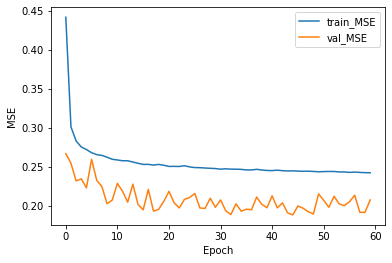

In [463]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un train MSE de 0.2446 y un val MSE de 0.1882 en 45 épocas. Mejores resultados hasta el momento.Tarda unos 12 segundos por época. El modelo continúa mejorando con cuantas más horas de antelación introducimos los datos de radiación. Probaremos con 3 horas de datos antes

### Modelo 19. Tomamos datos cada 5 minutos de 2.5 horas antes y predecimos a 15 minutos, utilizando fórmula 2 de neuronas tomando el resto de datos atmosféricos. Introducimos estos datos en la capa que concatena. 

In [575]:
X_train1=np.array(PVGISdf.iloc[1:len(PVGISdf)-32:3,1:4]) #Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=np.array(PVGISdf.iloc[2:len(PVGISdf)-31:3,1:4]) #Tengo datos de radiación de 13:20-15:45 e introduzco producción a las 16.
X_train3=np.array(PVGISdf.iloc[3:len(PVGISdf)-30:3,1:4]) #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=np.array(PVGISdf.iloc[4:len(PVGISdf)-29:3,1:4])
X_train5=np.array(PVGISdf.iloc[5:len(PVGISdf)-28:3,1:4])
X_train6=np.array(PVGISdf.iloc[6:len(PVGISdf)-27:3,1:4])
X_train7=np.array(PVGISdf.iloc[7:len(PVGISdf)-26:3,1:4]) 
X_train8=np.array(PVGISdf.iloc[8:len(PVGISdf)-25:3,1:4])
X_train9=np.array(PVGISdf.iloc[9:len(PVGISdf)-24:3,1:4]) 
X_train10=np.array(PVGISdf.iloc[10:len(PVGISdf)-23:3,1:4])
X_train11=np.array(PVGISdf.iloc[11:len(PVGISdf)-22:3,1:4])
X_train12=np.array(PVGISdf.iloc[12:len(PVGISdf)-21:3,1:4]) #Tomo datos hasta las 22:30 del 16/12/2018 para que mi última predicción sea la de las 22:45
X_train13=np.array(PVGISdf.iloc[13:len(PVGISdf)-20:3,1:4])  
X_train14=np.array(PVGISdf.iloc[14:len(PVGISdf)-19:3,1:4]) 
X_train15=np.array(PVGISdf.iloc[15:len(PVGISdf)-18:3,1:4]) 
X_train16=np.array(PVGISdf.iloc[16:len(PVGISdf)-17:3,1:4])
X_train17=np.array(PVGISdf.iloc[17:len(PVGISdf)-16:3,1:4])
X_train18=np.array(PVGISdf.iloc[18:len(PVGISdf)-15:3,1:4])
X_train19=np.array(PVGISdf.iloc[19:len(PVGISdf)-14:3,1:4])  
X_train20=np.array(PVGISdf.iloc[20:len(PVGISdf)-13:3,1:4]) 
X_train21=np.array(PVGISdf.iloc[21:len(PVGISdf)-12:3,1:4]) 
X_train22=np.array(PVGISdf.iloc[22:len(PVGISdf)-11:3,1:4])
X_train23=np.array(PVGISdf.iloc[23:len(PVGISdf)-10:3,1:4])
X_train24=np.array(PVGISdf.iloc[24:len(PVGISdf)-9:3,1:4])
X_train25=np.array(PVGISdf.iloc[25:len(PVGISdf)-8:3,1:4])  
X_train26=np.array(PVGISdf.iloc[26:len(PVGISdf)-7:3,1:4]) 
X_train27=np.array(PVGISdf.iloc[27:len(PVGISdf)-6:3,1:4]) 
X_train28=np.array(PVGISdf.iloc[28:len(PVGISdf)-5:3,1:4])
X_train29=np.array(PVGISdf.iloc[29:len(PVGISdf)-4:3,1:4])
X_train30=np.array(PVGISdf.iloc[30:len(PVGISdf)-3:3,1:4])


X_trainatm1=np.array(PVGISdf.iloc[1:len(PVGISdf)-32:3,4:7])  
X_trainatm2=np.array(PVGISdf.iloc[2:len(PVGISdf)-31:3,4:7]) 
X_trainatm3=np.array(PVGISdf.iloc[3:len(PVGISdf)-30:3,4:7]) 
X_trainatm4=np.array(PVGISdf.iloc[4:len(PVGISdf)-29:3,4:7])
X_trainatm5=np.array(PVGISdf.iloc[5:len(PVGISdf)-28:3,4:7])
X_trainatm6=np.array(PVGISdf.iloc[6:len(PVGISdf)-27:3,4:7])
X_trainatm7=np.array(PVGISdf.iloc[7:len(PVGISdf)-26:3,4:7]) 
X_trainatm8=np.array(PVGISdf.iloc[8:len(PVGISdf)-25:3,4:7])
X_trainatm9=np.array(PVGISdf.iloc[9:len(PVGISdf)-24:3,4:7]) 
X_trainatm10=np.array(PVGISdf.iloc[10:len(PVGISdf)-23:3,4:7])
X_trainatm11=np.array(PVGISdf.iloc[11:len(PVGISdf)-22:3,4:7])
X_trainatm12=np.array(PVGISdf.iloc[12:len(PVGISdf)-21:3,4:7])
X_trainatm13=np.array(PVGISdf.iloc[13:len(PVGISdf)-20:3,4:7])  
X_trainatm14=np.array(PVGISdf.iloc[14:len(PVGISdf)-19:3,4:7]) 
X_trainatm15=np.array(PVGISdf.iloc[15:len(PVGISdf)-18:3,4:7]) 
X_trainatm16=np.array(PVGISdf.iloc[16:len(PVGISdf)-17:3,4:7])
X_trainatm17=np.array(PVGISdf.iloc[17:len(PVGISdf)-16:3,4:7])
X_trainatm18=np.array(PVGISdf.iloc[18:len(PVGISdf)-15:3,4:7])
X_trainatm19=np.array(PVGISdf.iloc[19:len(PVGISdf)-14:3,4:7])  
X_trainatm20=np.array(PVGISdf.iloc[20:len(PVGISdf)-13:3,4:7]) 
X_trainatm21=np.array(PVGISdf.iloc[21:len(PVGISdf)-12:3,4:7]) 
X_trainatm22=np.array(PVGISdf.iloc[22:len(PVGISdf)-11:3,4:7])
X_trainatm23=np.array(PVGISdf.iloc[23:len(PVGISdf)-10:3,4:7])
X_trainatm24=np.array(PVGISdf.iloc[24:len(PVGISdf)-9:3,4:7])
X_trainatm25=np.array(PVGISdf.iloc[25:len(PVGISdf)-8:3,4:7])  
X_trainatm26=np.array(PVGISdf.iloc[26:len(PVGISdf)-7:3,4:7]) 
X_trainatm27=np.array(PVGISdf.iloc[27:len(PVGISdf)-6:3,4:7]) 
X_trainatm28=np.array(PVGISdf.iloc[28:len(PVGISdf)-5:3,4:7])
X_trainatm29=np.array(PVGISdf.iloc[29:len(PVGISdf)-4:3,4:7])
X_trainatm30=np.array(PVGISdf.iloc[30:len(PVGISdf)-3:3,4:7])


y_train=np.array(PVOutputdf.iloc[11:len(PVOutputdf),1]).astype(float) #No tomo los primeros 11 valores para cuadrarlo, que empiece a las 16

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 
X_train7std=np.std(X_train7) 
X_train8std=np.std(X_train8)
X_train9std=np.std(X_train9)
X_train10std=np.std(X_train10) 
X_train11std=np.std(X_train11) 
X_train12std=np.std(X_train12)
X_train13std=np.std(X_train13) 
X_train14std=np.std(X_train14) 
X_train15std=np.std(X_train15)
X_train16std=np.std(X_train16)
X_train17std=np.std(X_train17) 
X_train18std=np.std(X_train18)
X_train19std=np.std(X_train19) 
X_train20std=np.std(X_train20) 
X_train21std=np.std(X_train21)
X_train22std=np.std(X_train22)
X_train23std=np.std(X_train23) 
X_train24std=np.std(X_train24)
X_train25std=np.std(X_train25) 
X_train26std=np.std(X_train26) 
X_train27std=np.std(X_train27)
X_train28std=np.std(X_train28)
X_train29std=np.std(X_train29) 
X_train30std=np.std(X_train30)

X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 
X_train7est=X_train7/X_train7std 
X_train8est=X_train8/X_train8std
X_train9est=X_train9/X_train9std 
X_train10est=X_train10/X_train10std 
X_train11est=X_train11/X_train11std 
X_train12est=X_train12/X_train12std
X_train13est=X_train13/X_train13std 
X_train14est=X_train14/X_train14std
X_train15est=X_train15/X_train15std 
X_train16est=X_train16/X_train16std 
X_train17est=X_train17/X_train17std 
X_train18est=X_train18/X_train18std
X_train19est=X_train19/X_train19std 
X_train20est=X_train20/X_train20std
X_train21est=X_train21/X_train21std 
X_train22est=X_train22/X_train22std 
X_train23est=X_train23/X_train23std 
X_train24est=X_train24/X_train24std
X_train25est=X_train25/X_train25std 
X_train26est=X_train26/X_train26std
X_train27est=X_train27/X_train27std 
X_train28est=X_train28/X_train28std 
X_train29est=X_train29/X_train29std 
X_train30est=X_train30/X_train30std


X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est,X_train7est,X_train8est,X_train9est,X_train10est,X_train11est,X_train12est,X_train13est,X_train14est,X_train15est,X_train16est,X_train17est,X_train18est,X_train19est,X_train20est,X_train21est,X_train22est,X_train23est,X_train24est,X_train25est,X_train26est,X_train27est,X_train28est,X_train29est,X_train30)

X_trainatm1std=np.std(X_trainatm1)  
X_trainatm2std=np.std(X_trainatm2) 
X_trainatm3std=np.std(X_trainatm3) 
X_trainatm4std=np.std(X_trainatm4)
X_trainatm5std=np.std(X_trainatm5)
X_trainatm6std=np.std(X_trainatm6)
X_trainatm7std=np.std(X_trainatm7)
X_trainatm8std=np.std(X_trainatm8)
X_trainatm9std=np.std(X_trainatm9) 
X_trainatm10std=np.std(X_trainatm10)
X_trainatm11std=np.std(X_trainatm11)
X_trainatm12std=np.std(X_trainatm12)
X_trainatm13std=np.std(X_trainatm13)
X_trainatm14std=np.std(X_trainatm14)
X_trainatm15std=np.std(X_trainatm15) 
X_trainatm16std=np.std(X_trainatm16)
X_trainatm17std=np.std(X_trainatm17)
X_trainatm18std=np.std(X_trainatm18)
X_trainatm19std=np.std(X_trainatm19)
X_trainatm20std=np.std(X_trainatm20)
X_trainatm21std=np.std(X_trainatm21) 
X_trainatm22std=np.std(X_trainatm22)
X_trainatm23std=np.std(X_trainatm23)
X_trainatm24std=np.std(X_trainatm24)
X_trainatm25std=np.std(X_trainatm25)
X_trainatm26std=np.std(X_trainatm26)
X_trainatm27std=np.std(X_trainatm27) 
X_trainatm28std=np.std(X_trainatm28)
X_trainatm29std=np.std(X_trainatm29)
X_trainatm30std=np.std(X_trainatm30)

X_trainatm1est=X_trainatm1/X_trainatm1std 
X_trainatm2est=X_trainatm2/X_trainatm2std 
X_trainatm3est=X_trainatm3/X_trainatm3std 
X_trainatm4est=X_trainatm4/X_trainatm4std
X_trainatm5est=X_trainatm5/X_trainatm5std 
X_trainatm6est=X_trainatm6/X_trainatm6std 
X_trainatm7est=X_trainatm7/X_trainatm7std 
X_trainatm8est=X_trainatm8/X_trainatm8std
X_trainatm9est=X_trainatm9/X_trainatm9std 
X_trainatm10est=X_trainatm10/X_trainatm10std 
X_trainatm11est=X_trainatm11/X_trainatm11std 
X_trainatm12est=X_trainatm12/X_trainatm12std
X_trainatm13est=X_trainatm13/X_trainatm13std 
X_trainatm14est=X_trainatm14/X_trainatm14std 
X_trainatm15est=X_trainatm15/X_trainatm15std
X_trainatm16est=X_trainatm16/X_trainatm16std 
X_trainatm17est=X_trainatm17/X_trainatm17std 
X_trainatm18est=X_trainatm18/X_trainatm18std
X_trainatm19est=X_trainatm19/X_trainatm19std 
X_trainatm20est=X_trainatm20/X_trainatm20std 
X_trainatm21est=X_trainatm21/X_trainatm21std
X_trainatm22est=X_trainatm22/X_trainatm22std 
X_trainatm23est=X_trainatm23/X_trainatm23std 
X_trainatm24est=X_trainatm24/X_trainatm24std
X_trainatm25est=X_trainatm25/X_trainatm25std 
X_trainatm26est=X_trainatm26/X_trainatm26std 
X_trainatm27est=X_trainatm27/X_trainatm27std
X_trainatm28est=X_trainatm28/X_trainatm28std 
X_trainatm29est=X_trainatm29/X_trainatm29std 
X_trainatm30est=X_trainatm30/X_trainatm30std

X_trainatmest=(X_trainatm1est,X_trainatm2est,X_trainatm3est,X_trainatm4est,X_trainatm5est,X_trainatm6est,X_trainatm7est,X_trainatm8est,X_trainatm9est,X_trainatm10est,X_trainatm11est,X_trainatm12est,X_trainatm13est,X_trainatm14est,X_trainatm15est,X_trainatm16est,X_trainatm17est,X_trainatm18est,X_trainatm19est,X_trainatm20est,X_trainatm21est,X_trainatm22est,X_trainatm23est,X_trainatm24est,X_trainatm25est,X_trainatm26est,X_trainatm27est,X_trainatm28est,X_trainatm29est,X_trainatm30est)

Y_trainstd=np.std(y_train) 
Y_trainest=y_train/Y_trainstd 

In [576]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)
entrada13 = tf.keras.layers.Input(shape=3)
entrada14 = tf.keras.layers.Input(shape=3)
entrada15 = tf.keras.layers.Input(shape=3)
entrada16 = tf.keras.layers.Input(shape=3)
entrada17 = tf.keras.layers.Input(shape=3)
entrada18 = tf.keras.layers.Input(shape=3)
entrada19 = tf.keras.layers.Input(shape=3)
entrada20 = tf.keras.layers.Input(shape=3)
entrada21 = tf.keras.layers.Input(shape=3)
entrada22 = tf.keras.layers.Input(shape=3)
entrada23 = tf.keras.layers.Input(shape=3)
entrada24 = tf.keras.layers.Input(shape=3)
entrada25 = tf.keras.layers.Input(shape=3)
entrada26 = tf.keras.layers.Input(shape=3)
entrada27 = tf.keras.layers.Input(shape=3)
entrada28 = tf.keras.layers.Input(shape=3)
entrada29 = tf.keras.layers.Input(shape=3)
entrada30 = tf.keras.layers.Input(shape=3)

entradaatm1 = tf.keras.layers.Input(shape=3) 
entradaatm2 = tf.keras.layers.Input(shape=3)
entradaatm3 = tf.keras.layers.Input(shape=3)
entradaatm4 = tf.keras.layers.Input(shape=3)
entradaatm5 = tf.keras.layers.Input(shape=3)
entradaatm6 = tf.keras.layers.Input(shape=3)
entradaatm7 = tf.keras.layers.Input(shape=3)
entradaatm8 = tf.keras.layers.Input(shape=3)
entradaatm9 = tf.keras.layers.Input(shape=3)
entradaatm10 = tf.keras.layers.Input(shape=3)
entradaatm11 = tf.keras.layers.Input(shape=3)
entradaatm12 = tf.keras.layers.Input(shape=3)
entradaatm13 = tf.keras.layers.Input(shape=3)
entradaatm14 = tf.keras.layers.Input(shape=3)
entradaatm15 = tf.keras.layers.Input(shape=3) 
entradaatm16 = tf.keras.layers.Input(shape=3)
entradaatm17 = tf.keras.layers.Input(shape=3)
entradaatm18 = tf.keras.layers.Input(shape=3)
entradaatm19 = tf.keras.layers.Input(shape=3)
entradaatm20 = tf.keras.layers.Input(shape=3)
entradaatm21 = tf.keras.layers.Input(shape=3) 
entradaatm22 = tf.keras.layers.Input(shape=3)
entradaatm23 = tf.keras.layers.Input(shape=3)
entradaatm24 = tf.keras.layers.Input(shape=3)
entradaatm25 = tf.keras.layers.Input(shape=3)
entradaatm26 = tf.keras.layers.Input(shape=3)
entradaatm27 = tf.keras.layers.Input(shape=3) 
entradaatm28 = tf.keras.layers.Input(shape=3)
entradaatm29 = tf.keras.layers.Input(shape=3)
entradaatm30 = tf.keras.layers.Input(shape=3)

#Capas ocultas formula 2: Hidden =3/2*(In + Out)=3/2*(3+1)=6
oculta1 = tf.keras.layers.Dense(6, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(6, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(6, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(6, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(6, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(6, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(6, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(6, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(6, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(6, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(6, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(6, activation="relu")(entrada12)
oculta13 = tf.keras.layers.Dense(6, activation="relu")(entrada13)
oculta14 = tf.keras.layers.Dense(6, activation="relu")(entrada14)
oculta15 = tf.keras.layers.Dense(6, activation="relu")(entrada15)
oculta16 = tf.keras.layers.Dense(6, activation="relu")(entrada16)
oculta17 = tf.keras.layers.Dense(6, activation="relu")(entrada17)
oculta18 = tf.keras.layers.Dense(6, activation="relu")(entrada18)
oculta19 = tf.keras.layers.Dense(6, activation="relu")(entrada19)
oculta20 = tf.keras.layers.Dense(6, activation="relu")(entrada20)
oculta21 = tf.keras.layers.Dense(6, activation="relu")(entrada21)
oculta22 = tf.keras.layers.Dense(6, activation="relu")(entrada22)
oculta23 = tf.keras.layers.Dense(6, activation="relu")(entrada23)
oculta24 = tf.keras.layers.Dense(6, activation="relu")(entrada24)
oculta25 = tf.keras.layers.Dense(6, activation="relu")(entrada25)
oculta26 = tf.keras.layers.Dense(6, activation="relu")(entrada26)
oculta27 = tf.keras.layers.Dense(6, activation="relu")(entrada27)
oculta28 = tf.keras.layers.Dense(6, activation="relu")(entrada28)
oculta29 = tf.keras.layers.Dense(6, activation="relu")(entrada29)
oculta30 = tf.keras.layers.Dense(6, activation="relu")(entrada30)

concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12, oculta13, oculta14, oculta15, oculta16, oculta17, oculta18, oculta19, oculta20, oculta21, oculta22, oculta23, oculta24, oculta25, oculta26, oculta27, oculta28, oculta29, oculta30,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30]) #estratificada, concatena las 12
#2 layers intermedias, formula 2: Hidden =3/2*(In + Out)=3/2*(1+1)=3
adoculta1=tf.keras.layers.Dense(3, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(3, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(3, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo19 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12, entrada13, entrada14, entrada15, entrada16, entrada17, entrada18, entrada19, entrada20, entrada21, entrada22, entrada23, entrada24, entrada25, entrada26, entrada27, entrada28, entrada29, entrada30,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30], outputs=[salida])

modelo19.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo19.fit([X_trainest,X_trainatmest], Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2)
#Mucho mejor resultado introduciendo entre corchetes que entre paréntesis (X_trainest,X_trainatmest)
#No estoy 100% seguro de que esté bien introducido así, cómo sabe que las entradai corresponden a X_train y que entradaatmi corresponden a X_trainatm?

Epoch 1/1000
3308/3308 [==============================] - 15s 4ms/step - loss: 0.8321 - mae: 0.5775 - val_loss: 0.8071 - val_mae: 0.5381
Epoch 2/1000
3308/3308 [==============================] - 13s 4ms/step - loss: 0.7442 - mae: 0.5180 - val_loss: 0.7980 - val_mae: 0.5105
Epoch 3/1000
3308/3308 [==============================] - 14s 4ms/step - loss: 0.7340 - mae: 0.5062 - val_loss: 0.7981 - val_mae: 0.5172
Epoch 4/1000
3308/3308 [==============================] - 17s 5ms/step - loss: 0.7290 - mae: 0.5010 - val_loss: 0.8007 - val_mae: 0.5241
Epoch 5/1000
3308/3308 [==============================] - 16s 5ms/step - loss: 0.7245 - mae: 0.4960 - val_loss: 0.8141 - val_mae: 0.5389
Epoch 6/1000
3308/3308 [==============================] - 16s 5ms/step - loss: 0.7222 - mae: 0.4947 - val_loss: 0.7924 - val_mae: 0.5083
Epoch 7/1000
3308/3308 [==============================] - 17s 5ms/step - loss: 0.7192 - mae: 0.4922 - val_loss: 0.8105 - val_mae: 0.5237
Epoch 8/1000
3308/3308 [=================

Text(0, 0.5, 'MSE')

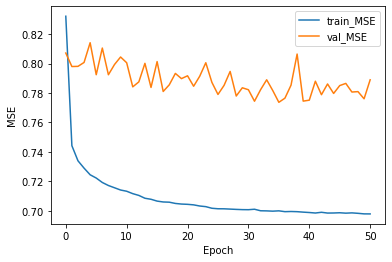

In [577]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un train MSE de 0.7103  y un val MSE de 0.7778 en 19 épocas. Resultados inesperados ya que se obtiene un error mucho mayor que con 2 horas de datos (y que con 3 horas). Tarda unos 14 segundos por época. En una ejecución de repente mejoraba mucho y se obtenía un error en línea con los modelos 18 y 20

### Modelo 20. Tomamos datos cada 5 minutos de TRES horas antes y predecimos a 15 minutos, utilizando fórmula 2 de neuronas tomando el resto de datos atmosféricos. Introducimos estos datos en la capa que concatena. 

In [49]:
PVOutputdf

,Fechayhora,Energía,Eficiencia,Potencia,Media,Normalizado
0,2015-03-09 13:15:00,1621,0.037,19457,0,0.0
1,2015-03-09 13:30:00,8048,0.184,25706,25708,0.588
2,2015-03-09 13:45:00,12807.0,0.293,22371.0,22372.0,0.5115
3,2015-03-09 14:00:00,17566,0.402,19036,19036,0.435
4,2015-03-09 14:15:00,19023.333333,0.435333,14633.666667,14634.0,0.334333
...,...,...,...,...,...,...
132338,2018-12-16 21:45:00,23290,0.532,0,0,0.0
132339,2018-12-16 22:00:00,23290,0.532,0,0,0.0
132340,2018-12-16 22:15:00,23290,0.532,0,0,0.0
132341,2018-12-16 22:30:00,23290,0.532,0,0,0.0


In [50]:
X_train1=np.array(PVGISdf.iloc[1:len(PVGISdf)-38:3,1:4]) #Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=np.array(PVGISdf.iloc[2:len(PVGISdf)-37:3,1:4]) #Tengo datos de radiación de 13:20-16:15 e introduzco producción a las 15:30.
X_train3=np.array(PVGISdf.iloc[3:len(PVGISdf)-36:3,1:4]) #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=np.array(PVGISdf.iloc[4:len(PVGISdf)-35:3,1:4])
X_train5=np.array(PVGISdf.iloc[5:len(PVGISdf)-34:3,1:4])
X_train6=np.array(PVGISdf.iloc[6:len(PVGISdf)-33:3,1:4])
X_train7=np.array(PVGISdf.iloc[7:len(PVGISdf)-32:3,1:4]) 
X_train8=np.array(PVGISdf.iloc[8:len(PVGISdf)-31:3,1:4])
X_train9=np.array(PVGISdf.iloc[9:len(PVGISdf)-30:3,1:4]) 
X_train10=np.array(PVGISdf.iloc[10:len(PVGISdf)-29:3,1:4])
X_train11=np.array(PVGISdf.iloc[11:len(PVGISdf)-28:3,1:4])
X_train12=np.array(PVGISdf.iloc[12:len(PVGISdf)-27:3,1:4]) #Tomo datos hasta las 22:30 del 16/12/2018 para que mi última predicción sea la de las 22:45
X_train13=np.array(PVGISdf.iloc[13:len(PVGISdf)-26:3,1:4])  
X_train14=np.array(PVGISdf.iloc[14:len(PVGISdf)-25:3,1:4]) 
X_train15=np.array(PVGISdf.iloc[15:len(PVGISdf)-24:3,1:4]) 
X_train16=np.array(PVGISdf.iloc[16:len(PVGISdf)-23:3,1:4])
X_train17=np.array(PVGISdf.iloc[17:len(PVGISdf)-22:3,1:4])
X_train18=np.array(PVGISdf.iloc[18:len(PVGISdf)-21:3,1:4])
X_train19=np.array(PVGISdf.iloc[19:len(PVGISdf)-20:3,1:4])  
X_train20=np.array(PVGISdf.iloc[20:len(PVGISdf)-19:3,1:4]) 
X_train21=np.array(PVGISdf.iloc[21:len(PVGISdf)-18:3,1:4]) 
X_train22=np.array(PVGISdf.iloc[22:len(PVGISdf)-17:3,1:4])
X_train23=np.array(PVGISdf.iloc[23:len(PVGISdf)-16:3,1:4])
X_train24=np.array(PVGISdf.iloc[24:len(PVGISdf)-15:3,1:4])
X_train25=np.array(PVGISdf.iloc[25:len(PVGISdf)-14:3,1:4])  
X_train26=np.array(PVGISdf.iloc[26:len(PVGISdf)-13:3,1:4]) 
X_train27=np.array(PVGISdf.iloc[27:len(PVGISdf)-12:3,1:4]) 
X_train28=np.array(PVGISdf.iloc[28:len(PVGISdf)-11:3,1:4])
X_train29=np.array(PVGISdf.iloc[29:len(PVGISdf)-10:3,1:4])
X_train30=np.array(PVGISdf.iloc[30:len(PVGISdf)-9:3,1:4])
X_train31=np.array(PVGISdf.iloc[31:len(PVGISdf)-8:3,1:4])  
X_train32=np.array(PVGISdf.iloc[32:len(PVGISdf)-7:3,1:4]) 
X_train33=np.array(PVGISdf.iloc[33:len(PVGISdf)-6:3,1:4]) 
X_train34=np.array(PVGISdf.iloc[34:len(PVGISdf)-5:3,1:4])
X_train35=np.array(PVGISdf.iloc[35:len(PVGISdf)-4:3,1:4])
X_train36=np.array(PVGISdf.iloc[36:len(PVGISdf)-3:3,1:4])

X_trainatm1=np.array(PVGISdf.iloc[1:len(PVGISdf)-38:3,4:7])  
X_trainatm2=np.array(PVGISdf.iloc[2:len(PVGISdf)-37:3,4:7]) 
X_trainatm3=np.array(PVGISdf.iloc[3:len(PVGISdf)-36:3,4:7]) 
X_trainatm4=np.array(PVGISdf.iloc[4:len(PVGISdf)-35:3,4:7])
X_trainatm5=np.array(PVGISdf.iloc[5:len(PVGISdf)-34:3,4:7])
X_trainatm6=np.array(PVGISdf.iloc[6:len(PVGISdf)-33:3,4:7])
X_trainatm7=np.array(PVGISdf.iloc[7:len(PVGISdf)-32:3,4:7]) 
X_trainatm8=np.array(PVGISdf.iloc[8:len(PVGISdf)-31:3,4:7])
X_trainatm9=np.array(PVGISdf.iloc[9:len(PVGISdf)-30:3,4:7]) 
X_trainatm10=np.array(PVGISdf.iloc[10:len(PVGISdf)-29:3,4:7])
X_trainatm11=np.array(PVGISdf.iloc[11:len(PVGISdf)-28:3,4:7])
X_trainatm12=np.array(PVGISdf.iloc[12:len(PVGISdf)-27:3,4:7])
X_trainatm13=np.array(PVGISdf.iloc[13:len(PVGISdf)-26:3,4:7])  
X_trainatm14=np.array(PVGISdf.iloc[14:len(PVGISdf)-25:3,4:7]) 
X_trainatm15=np.array(PVGISdf.iloc[15:len(PVGISdf)-24:3,4:7]) 
X_trainatm16=np.array(PVGISdf.iloc[16:len(PVGISdf)-23:3,4:7])
X_trainatm17=np.array(PVGISdf.iloc[17:len(PVGISdf)-22:3,4:7])
X_trainatm18=np.array(PVGISdf.iloc[18:len(PVGISdf)-21:3,4:7])
X_trainatm19=np.array(PVGISdf.iloc[19:len(PVGISdf)-20:3,4:7])  
X_trainatm20=np.array(PVGISdf.iloc[20:len(PVGISdf)-19:3,4:7]) 
X_trainatm21=np.array(PVGISdf.iloc[21:len(PVGISdf)-18:3,4:7]) 
X_trainatm22=np.array(PVGISdf.iloc[22:len(PVGISdf)-17:3,4:7])
X_trainatm23=np.array(PVGISdf.iloc[23:len(PVGISdf)-16:3,4:7])
X_trainatm24=np.array(PVGISdf.iloc[24:len(PVGISdf)-15:3,4:7])
X_trainatm25=np.array(PVGISdf.iloc[25:len(PVGISdf)-14:3,4:7])  
X_trainatm26=np.array(PVGISdf.iloc[26:len(PVGISdf)-13:3,4:7]) 
X_trainatm27=np.array(PVGISdf.iloc[27:len(PVGISdf)-12:3,4:7]) 
X_trainatm28=np.array(PVGISdf.iloc[28:len(PVGISdf)-11:3,4:7])
X_trainatm29=np.array(PVGISdf.iloc[29:len(PVGISdf)-10:3,4:7])
X_trainatm30=np.array(PVGISdf.iloc[30:len(PVGISdf)-9:3,4:7])
X_trainatm31=np.array(PVGISdf.iloc[31:len(PVGISdf)-8:3,4:7])  
X_trainatm32=np.array(PVGISdf.iloc[32:len(PVGISdf)-7:3,4:7]) 
X_trainatm33=np.array(PVGISdf.iloc[33:len(PVGISdf)-6:3,4:7]) 
X_trainatm34=np.array(PVGISdf.iloc[34:len(PVGISdf)-5:3,4:7])
X_trainatm35=np.array(PVGISdf.iloc[35:len(PVGISdf)-4:3,4:7])
X_trainatm36=np.array(PVGISdf.iloc[36:len(PVGISdf)-3:3,4:7])

y_train=np.array(PVOutputdf.iloc[13:len(PVOutputdf),5]).astype(float) #No tomo los primeros 7 valores para cuadrarlo, que empiece a las 16:30

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 
X_train7std=np.std(X_train7) 
X_train8std=np.std(X_train8)
X_train9std=np.std(X_train9)
X_train10std=np.std(X_train10) 
X_train11std=np.std(X_train11) 
X_train12std=np.std(X_train12)
X_train13std=np.std(X_train13) 
X_train14std=np.std(X_train14) 
X_train15std=np.std(X_train15)
X_train16std=np.std(X_train16)
X_train17std=np.std(X_train17) 
X_train18std=np.std(X_train18)
X_train19std=np.std(X_train19) 
X_train20std=np.std(X_train20) 
X_train21std=np.std(X_train21)
X_train22std=np.std(X_train22)
X_train23std=np.std(X_train23) 
X_train24std=np.std(X_train24)
X_train25std=np.std(X_train25) 
X_train26std=np.std(X_train26) 
X_train27std=np.std(X_train27)
X_train28std=np.std(X_train28)
X_train29std=np.std(X_train29) 
X_train30std=np.std(X_train30)
X_train31std=np.std(X_train31) 
X_train32std=np.std(X_train32) 
X_train33std=np.std(X_train33)
X_train34std=np.std(X_train34)
X_train35std=np.std(X_train35) 
X_train36std=np.std(X_train36) 


X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 
X_train7est=X_train7/X_train7std 
X_train8est=X_train8/X_train8std
X_train9est=X_train9/X_train9std 
X_train10est=X_train10/X_train10std 
X_train11est=X_train11/X_train11std 
X_train12est=X_train12/X_train12std
X_train13est=X_train13/X_train13std 
X_train14est=X_train14/X_train14std
X_train15est=X_train15/X_train15std 
X_train16est=X_train16/X_train16std 
X_train17est=X_train17/X_train17std 
X_train18est=X_train18/X_train18std
X_train19est=X_train19/X_train19std 
X_train20est=X_train20/X_train20std
X_train21est=X_train21/X_train21std 
X_train22est=X_train22/X_train22std 
X_train23est=X_train23/X_train23std 
X_train24est=X_train24/X_train24std
X_train25est=X_train25/X_train25std 
X_train26est=X_train26/X_train26std
X_train27est=X_train27/X_train27std 
X_train28est=X_train28/X_train28std 
X_train29est=X_train29/X_train29std 
X_train30est=X_train30/X_train30std
X_train31est=X_train31/X_train31std 
X_train32est=X_train32/X_train32std
X_train33est=X_train33/X_train33std 
X_train34est=X_train34/X_train34std 
X_train35est=X_train35/X_train35std 
X_train36est=X_train36/X_train36std

X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est,X_train7est,X_train8est,X_train9est,X_train10est,X_train11est,X_train12est,X_train13est,X_train14est,X_train15est,X_train16est,X_train17est,X_train18est,X_train19est,X_train20est,X_train21est,X_train22est,X_train23est,X_train24est,X_train25est,X_train26est,X_train27est,X_train28est,X_train29est,X_train30est,X_train31est,X_train32est,X_train33est,X_train34est,X_train35est,X_train36est)

X_trainatm1std=np.std(X_trainatm1)  
X_trainatm2std=np.std(X_trainatm2) 
X_trainatm3std=np.std(X_trainatm3) 
X_trainatm4std=np.std(X_trainatm4)
X_trainatm5std=np.std(X_trainatm5)
X_trainatm6std=np.std(X_trainatm6)
X_trainatm7std=np.std(X_trainatm7)
X_trainatm8std=np.std(X_trainatm8)
X_trainatm9std=np.std(X_trainatm9) 
X_trainatm10std=np.std(X_trainatm10)
X_trainatm11std=np.std(X_trainatm11)
X_trainatm12std=np.std(X_trainatm12)
X_trainatm13std=np.std(X_trainatm13)
X_trainatm14std=np.std(X_trainatm14)
X_trainatm15std=np.std(X_trainatm15) 
X_trainatm16std=np.std(X_trainatm16)
X_trainatm17std=np.std(X_trainatm17)
X_trainatm18std=np.std(X_trainatm18)
X_trainatm19std=np.std(X_trainatm19)
X_trainatm20std=np.std(X_trainatm20)
X_trainatm21std=np.std(X_trainatm21) 
X_trainatm22std=np.std(X_trainatm22)
X_trainatm23std=np.std(X_trainatm23)
X_trainatm24std=np.std(X_trainatm24)
X_trainatm25std=np.std(X_trainatm25)
X_trainatm26std=np.std(X_trainatm26)
X_trainatm27std=np.std(X_trainatm27) 
X_trainatm28std=np.std(X_trainatm28)
X_trainatm29std=np.std(X_trainatm29)
X_trainatm30std=np.std(X_trainatm30)
X_trainatm31std=np.std(X_trainatm31)
X_trainatm32std=np.std(X_trainatm32)
X_trainatm33std=np.std(X_trainatm33) 
X_trainatm34std=np.std(X_trainatm34)
X_trainatm35std=np.std(X_trainatm35)
X_trainatm36std=np.std(X_trainatm36)

X_trainatm1est=X_trainatm1/X_trainatm1std 
X_trainatm2est=X_trainatm2/X_trainatm2std 
X_trainatm3est=X_trainatm3/X_trainatm3std 
X_trainatm4est=X_trainatm4/X_trainatm4std
X_trainatm5est=X_trainatm5/X_trainatm5std 
X_trainatm6est=X_trainatm6/X_trainatm6std 
X_trainatm7est=X_trainatm7/X_trainatm7std 
X_trainatm8est=X_trainatm8/X_trainatm8std
X_trainatm9est=X_trainatm9/X_trainatm9std 
X_trainatm10est=X_trainatm10/X_trainatm10std 
X_trainatm11est=X_trainatm11/X_trainatm11std 
X_trainatm12est=X_trainatm12/X_trainatm12std
X_trainatm13est=X_trainatm13/X_trainatm13std 
X_trainatm14est=X_trainatm14/X_trainatm14std 
X_trainatm15est=X_trainatm15/X_trainatm15std
X_trainatm16est=X_trainatm16/X_trainatm16std 
X_trainatm17est=X_trainatm17/X_trainatm17std 
X_trainatm18est=X_trainatm18/X_trainatm18std
X_trainatm19est=X_trainatm19/X_trainatm19std 
X_trainatm20est=X_trainatm20/X_trainatm20std 
X_trainatm21est=X_trainatm21/X_trainatm21std
X_trainatm22est=X_trainatm22/X_trainatm22std 
X_trainatm23est=X_trainatm23/X_trainatm23std 
X_trainatm24est=X_trainatm24/X_trainatm24std
X_trainatm25est=X_trainatm25/X_trainatm25std 
X_trainatm26est=X_trainatm26/X_trainatm26std 
X_trainatm27est=X_trainatm27/X_trainatm27std
X_trainatm28est=X_trainatm28/X_trainatm28std 
X_trainatm29est=X_trainatm29/X_trainatm29std 
X_trainatm30est=X_trainatm30/X_trainatm30std
X_trainatm31est=X_trainatm31/X_trainatm31std 
X_trainatm32est=X_trainatm32/X_trainatm32std 
X_trainatm33est=X_trainatm33/X_trainatm33std
X_trainatm34est=X_trainatm34/X_trainatm34std 
X_trainatm35est=X_trainatm35/X_trainatm35std 
X_trainatm36est=X_trainatm36/X_trainatm36std

X_trainatmest=(X_trainatm1est,X_trainatm2est,X_trainatm3est,X_trainatm4est,X_trainatm5est,X_trainatm6est,X_trainatm7est,X_trainatm8est,X_trainatm9est,X_trainatm10est,X_trainatm11est,X_trainatm12est,X_trainatm13est,X_trainatm14est,X_trainatm15est,X_trainatm16est,X_trainatm17est,X_trainatm18est,X_trainatm19est,X_trainatm20est,X_trainatm21est,X_trainatm22est,X_trainatm23est,X_trainatm24est,X_trainatm25est,X_trainatm26est,X_trainatm27est,X_trainatm28est,X_trainatm29est,X_trainatm30est,X_trainatm31est,X_trainatm32est,X_trainatm33est,X_trainatm34est,X_trainatm35est,X_trainatm36est)


In [51]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)
entrada13 = tf.keras.layers.Input(shape=3)
entrada14 = tf.keras.layers.Input(shape=3)
entrada15 = tf.keras.layers.Input(shape=3)
entrada16 = tf.keras.layers.Input(shape=3)
entrada17 = tf.keras.layers.Input(shape=3)
entrada18 = tf.keras.layers.Input(shape=3)
entrada19 = tf.keras.layers.Input(shape=3)
entrada20 = tf.keras.layers.Input(shape=3)
entrada21 = tf.keras.layers.Input(shape=3)
entrada22 = tf.keras.layers.Input(shape=3)
entrada23 = tf.keras.layers.Input(shape=3)
entrada24 = tf.keras.layers.Input(shape=3)
entrada25 = tf.keras.layers.Input(shape=3)
entrada26 = tf.keras.layers.Input(shape=3)
entrada27 = tf.keras.layers.Input(shape=3)
entrada28 = tf.keras.layers.Input(shape=3)
entrada29 = tf.keras.layers.Input(shape=3)
entrada30 = tf.keras.layers.Input(shape=3)
entrada31 = tf.keras.layers.Input(shape=3)
entrada32 = tf.keras.layers.Input(shape=3)
entrada33 = tf.keras.layers.Input(shape=3)
entrada34 = tf.keras.layers.Input(shape=3)
entrada35 = tf.keras.layers.Input(shape=3)
entrada36 = tf.keras.layers.Input(shape=3)

entradaatm1 = tf.keras.layers.Input(shape=3) 
entradaatm2 = tf.keras.layers.Input(shape=3)
entradaatm3 = tf.keras.layers.Input(shape=3)
entradaatm4 = tf.keras.layers.Input(shape=3)
entradaatm5 = tf.keras.layers.Input(shape=3)
entradaatm6 = tf.keras.layers.Input(shape=3)
entradaatm7 = tf.keras.layers.Input(shape=3)
entradaatm8 = tf.keras.layers.Input(shape=3)
entradaatm9 = tf.keras.layers.Input(shape=3)
entradaatm10 = tf.keras.layers.Input(shape=3)
entradaatm11 = tf.keras.layers.Input(shape=3)
entradaatm12 = tf.keras.layers.Input(shape=3)
entradaatm13 = tf.keras.layers.Input(shape=3)
entradaatm14 = tf.keras.layers.Input(shape=3)
entradaatm15 = tf.keras.layers.Input(shape=3) 
entradaatm16 = tf.keras.layers.Input(shape=3)
entradaatm17 = tf.keras.layers.Input(shape=3)
entradaatm18 = tf.keras.layers.Input(shape=3)
entradaatm19 = tf.keras.layers.Input(shape=3)
entradaatm20 = tf.keras.layers.Input(shape=3)
entradaatm21 = tf.keras.layers.Input(shape=3) 
entradaatm22 = tf.keras.layers.Input(shape=3)
entradaatm23 = tf.keras.layers.Input(shape=3)
entradaatm24 = tf.keras.layers.Input(shape=3)
entradaatm25 = tf.keras.layers.Input(shape=3)
entradaatm26 = tf.keras.layers.Input(shape=3)
entradaatm27 = tf.keras.layers.Input(shape=3) 
entradaatm28 = tf.keras.layers.Input(shape=3)
entradaatm29 = tf.keras.layers.Input(shape=3)
entradaatm30 = tf.keras.layers.Input(shape=3)
entradaatm31 = tf.keras.layers.Input(shape=3)
entradaatm32 = tf.keras.layers.Input(shape=3)
entradaatm33 = tf.keras.layers.Input(shape=3) 
entradaatm34 = tf.keras.layers.Input(shape=3)
entradaatm35 = tf.keras.layers.Input(shape=3)
entradaatm36 = tf.keras.layers.Input(shape=3)

#Capas ocultas formula 2: Hidden =3/2*(In + Out)=3/2*(3+1)=6
oculta1 = tf.keras.layers.Dense(6, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(6, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(6, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(6, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(6, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(6, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(6, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(6, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(6, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(6, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(6, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(6, activation="relu")(entrada12)
oculta13 = tf.keras.layers.Dense(6, activation="relu")(entrada13)
oculta14 = tf.keras.layers.Dense(6, activation="relu")(entrada14)
oculta15 = tf.keras.layers.Dense(6, activation="relu")(entrada15)
oculta16 = tf.keras.layers.Dense(6, activation="relu")(entrada16)
oculta17 = tf.keras.layers.Dense(6, activation="relu")(entrada17)
oculta18 = tf.keras.layers.Dense(6, activation="relu")(entrada18)
oculta19 = tf.keras.layers.Dense(6, activation="relu")(entrada19)
oculta20 = tf.keras.layers.Dense(6, activation="relu")(entrada20)
oculta21 = tf.keras.layers.Dense(6, activation="relu")(entrada21)
oculta22 = tf.keras.layers.Dense(6, activation="relu")(entrada22)
oculta23 = tf.keras.layers.Dense(6, activation="relu")(entrada23)
oculta24 = tf.keras.layers.Dense(6, activation="relu")(entrada24)
oculta25 = tf.keras.layers.Dense(6, activation="relu")(entrada25)
oculta26 = tf.keras.layers.Dense(6, activation="relu")(entrada26)
oculta27 = tf.keras.layers.Dense(6, activation="relu")(entrada27)
oculta28 = tf.keras.layers.Dense(6, activation="relu")(entrada28)
oculta29 = tf.keras.layers.Dense(6, activation="relu")(entrada29)
oculta30 = tf.keras.layers.Dense(6, activation="relu")(entrada30)
oculta31 = tf.keras.layers.Dense(6, activation="relu")(entrada31)
oculta32 = tf.keras.layers.Dense(6, activation="relu")(entrada32)
oculta33 = tf.keras.layers.Dense(6, activation="relu")(entrada33)
oculta34 = tf.keras.layers.Dense(6, activation="relu")(entrada34)
oculta35 = tf.keras.layers.Dense(6, activation="relu")(entrada35)
oculta36 = tf.keras.layers.Dense(6, activation="relu")(entrada36)


concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12, oculta13, oculta14, oculta15, oculta16, oculta17, oculta18, oculta19, oculta20, oculta21, oculta22, oculta23, oculta24, oculta25, oculta26, oculta27, oculta28, oculta29, oculta30, oculta31, oculta32, oculta33, oculta34, oculta35, oculta36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36]) #estratificada, concatena las 12
#2 layers intermedias, formula 2: Hidden =3/2*(In + Out)=3/2*(1+1)=3
adoculta1=tf.keras.layers.Dense(3, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(3, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(3, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo20 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12, entrada13, entrada14, entrada15, entrada16, entrada17, entrada18, entrada19, entrada20, entrada21, entrada22, entrada23, entrada24, entrada25, entrada26, entrada27, entrada28, entrada29, entrada30, entrada31, entrada32, entrada33, entrada34, entrada35, entrada36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36], outputs=[salida])

modelo20.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo20.fit([X_trainest,X_trainatmest], y_train, epochs=1000,callbacks=[callback],validation_split=0.2)
#Mucho mejor resultado introduciendo entre corchetes que entre paréntesis (X_trainest,X_trainatmest)
#No estoy 100% seguro de que esté bien introducido así, cómo sabe que las entradai corresponden a X_train y que entradaatmi corresponden a X_trainatm?

Epoch 1/1000
3308/3308 [==============================] - 15s 4ms/step - loss: 0.0523 - mae: 0.1155 - val_loss: 0.0614 - val_mae: 0.1338
Epoch 2/1000
3308/3308 [==============================] - 13s 4ms/step - loss: 0.0519 - mae: 0.1146 - val_loss: 0.0610 - val_mae: 0.1331
Epoch 3/1000
3308/3308 [==============================] - 15s 5ms/step - loss: 0.0519 - mae: 0.1144 - val_loss: 0.0610 - val_mae: 0.1333
Epoch 4/1000
3308/3308 [==============================] - 15s 4ms/step - loss: 0.0519 - mae: 0.1143 - val_loss: 0.0610 - val_mae: 0.1332
Epoch 5/1000
3308/3308 [==============================] - 14s 4ms/step - loss: 0.0518 - mae: 0.1142 - val_loss: 0.0610 - val_mae: 0.1333
Epoch 6/1000
3308/3308 [==============================] - 14s 4ms/step - loss: 0.0518 - mae: 0.1142 - val_loss: 0.0614 - val_mae: 0.1339
Epoch 7/1000
3308/3308 [==============================] - 16s 5ms/step - loss: 0.0518 - mae: 0.1141 - val_loss: 0.0615 - val_mae: 0.1344
Epoch 8/1000
3308/3308 [=================

Text(0, 0.5, 'MSE')

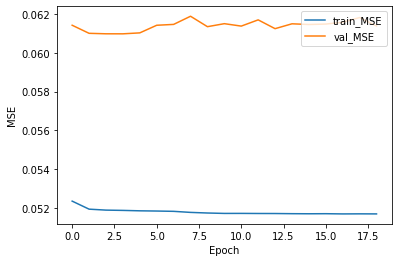

In [52]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un val_MSE de 0.0610 y un val_MAE de 0.1332 en 4 épocas. Resultados acordes con los del artículo, aunque la red no entrena mucho.

### Modelo 21. Tomamos datos cada 5 minutos de TRES horas antes y predecimos a 15 minutos, utilizando fórmula 3 de neuronas tomando el resto de datos atmosféricos. Introducimos estos datos en la capa que concatena.  Tomamos datos normalizados de la producción.

In [101]:
X_train1=np.array(PVGISdf.iloc[1:len(PVGISdf)-38:3,1:4]) #Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=np.array(PVGISdf.iloc[2:len(PVGISdf)-37:3,1:4]) #Tengo datos de radiación de 13:20-16:15 e introduzco producción a las 15:30.
X_train3=np.array(PVGISdf.iloc[3:len(PVGISdf)-36:3,1:4]) #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=np.array(PVGISdf.iloc[4:len(PVGISdf)-35:3,1:4])
X_train5=np.array(PVGISdf.iloc[5:len(PVGISdf)-34:3,1:4])
X_train6=np.array(PVGISdf.iloc[6:len(PVGISdf)-33:3,1:4])
X_train7=np.array(PVGISdf.iloc[7:len(PVGISdf)-32:3,1:4]) 
X_train8=np.array(PVGISdf.iloc[8:len(PVGISdf)-31:3,1:4])
X_train9=np.array(PVGISdf.iloc[9:len(PVGISdf)-30:3,1:4]) 
X_train10=np.array(PVGISdf.iloc[10:len(PVGISdf)-29:3,1:4])
X_train11=np.array(PVGISdf.iloc[11:len(PVGISdf)-28:3,1:4])
X_train12=np.array(PVGISdf.iloc[12:len(PVGISdf)-27:3,1:4]) #Tomo datos hasta las 22:30 del 16/12/2018 para que mi última predicción sea la de las 22:45
X_train13=np.array(PVGISdf.iloc[13:len(PVGISdf)-26:3,1:4])  
X_train14=np.array(PVGISdf.iloc[14:len(PVGISdf)-25:3,1:4]) 
X_train15=np.array(PVGISdf.iloc[15:len(PVGISdf)-24:3,1:4]) 
X_train16=np.array(PVGISdf.iloc[16:len(PVGISdf)-23:3,1:4])
X_train17=np.array(PVGISdf.iloc[17:len(PVGISdf)-22:3,1:4])
X_train18=np.array(PVGISdf.iloc[18:len(PVGISdf)-21:3,1:4])
X_train19=np.array(PVGISdf.iloc[19:len(PVGISdf)-20:3,1:4])  
X_train20=np.array(PVGISdf.iloc[20:len(PVGISdf)-19:3,1:4]) 
X_train21=np.array(PVGISdf.iloc[21:len(PVGISdf)-18:3,1:4]) 
X_train22=np.array(PVGISdf.iloc[22:len(PVGISdf)-17:3,1:4])
X_train23=np.array(PVGISdf.iloc[23:len(PVGISdf)-16:3,1:4])
X_train24=np.array(PVGISdf.iloc[24:len(PVGISdf)-15:3,1:4])
X_train25=np.array(PVGISdf.iloc[25:len(PVGISdf)-14:3,1:4])  
X_train26=np.array(PVGISdf.iloc[26:len(PVGISdf)-13:3,1:4]) 
X_train27=np.array(PVGISdf.iloc[27:len(PVGISdf)-12:3,1:4]) 
X_train28=np.array(PVGISdf.iloc[28:len(PVGISdf)-11:3,1:4])
X_train29=np.array(PVGISdf.iloc[29:len(PVGISdf)-10:3,1:4])
X_train30=np.array(PVGISdf.iloc[30:len(PVGISdf)-9:3,1:4])
X_train31=np.array(PVGISdf.iloc[31:len(PVGISdf)-8:3,1:4])  
X_train32=np.array(PVGISdf.iloc[32:len(PVGISdf)-7:3,1:4]) 
X_train33=np.array(PVGISdf.iloc[33:len(PVGISdf)-6:3,1:4]) 
X_train34=np.array(PVGISdf.iloc[34:len(PVGISdf)-5:3,1:4])
X_train35=np.array(PVGISdf.iloc[35:len(PVGISdf)-4:3,1:4])
X_train36=np.array(PVGISdf.iloc[36:len(PVGISdf)-3:3,1:4])

X_trainatm1=np.array(PVGISdf.iloc[1:len(PVGISdf)-38:3,4:7])  
X_trainatm2=np.array(PVGISdf.iloc[2:len(PVGISdf)-37:3,4:7]) 
X_trainatm3=np.array(PVGISdf.iloc[3:len(PVGISdf)-36:3,4:7]) 
X_trainatm4=np.array(PVGISdf.iloc[4:len(PVGISdf)-35:3,4:7])
X_trainatm5=np.array(PVGISdf.iloc[5:len(PVGISdf)-34:3,4:7])
X_trainatm6=np.array(PVGISdf.iloc[6:len(PVGISdf)-33:3,4:7])
X_trainatm7=np.array(PVGISdf.iloc[7:len(PVGISdf)-32:3,4:7]) 
X_trainatm8=np.array(PVGISdf.iloc[8:len(PVGISdf)-31:3,4:7])
X_trainatm9=np.array(PVGISdf.iloc[9:len(PVGISdf)-30:3,4:7]) 
X_trainatm10=np.array(PVGISdf.iloc[10:len(PVGISdf)-29:3,4:7])
X_trainatm11=np.array(PVGISdf.iloc[11:len(PVGISdf)-28:3,4:7])
X_trainatm12=np.array(PVGISdf.iloc[12:len(PVGISdf)-27:3,4:7])
X_trainatm13=np.array(PVGISdf.iloc[13:len(PVGISdf)-26:3,4:7])  
X_trainatm14=np.array(PVGISdf.iloc[14:len(PVGISdf)-25:3,4:7]) 
X_trainatm15=np.array(PVGISdf.iloc[15:len(PVGISdf)-24:3,4:7]) 
X_trainatm16=np.array(PVGISdf.iloc[16:len(PVGISdf)-23:3,4:7])
X_trainatm17=np.array(PVGISdf.iloc[17:len(PVGISdf)-22:3,4:7])
X_trainatm18=np.array(PVGISdf.iloc[18:len(PVGISdf)-21:3,4:7])
X_trainatm19=np.array(PVGISdf.iloc[19:len(PVGISdf)-20:3,4:7])  
X_trainatm20=np.array(PVGISdf.iloc[20:len(PVGISdf)-19:3,4:7]) 
X_trainatm21=np.array(PVGISdf.iloc[21:len(PVGISdf)-18:3,4:7]) 
X_trainatm22=np.array(PVGISdf.iloc[22:len(PVGISdf)-17:3,4:7])
X_trainatm23=np.array(PVGISdf.iloc[23:len(PVGISdf)-16:3,4:7])
X_trainatm24=np.array(PVGISdf.iloc[24:len(PVGISdf)-15:3,4:7])
X_trainatm25=np.array(PVGISdf.iloc[25:len(PVGISdf)-14:3,4:7])  
X_trainatm26=np.array(PVGISdf.iloc[26:len(PVGISdf)-13:3,4:7]) 
X_trainatm27=np.array(PVGISdf.iloc[27:len(PVGISdf)-12:3,4:7]) 
X_trainatm28=np.array(PVGISdf.iloc[28:len(PVGISdf)-11:3,4:7])
X_trainatm29=np.array(PVGISdf.iloc[29:len(PVGISdf)-10:3,4:7])
X_trainatm30=np.array(PVGISdf.iloc[30:len(PVGISdf)-9:3,4:7])
X_trainatm31=np.array(PVGISdf.iloc[31:len(PVGISdf)-8:3,4:7])  
X_trainatm32=np.array(PVGISdf.iloc[32:len(PVGISdf)-7:3,4:7]) 
X_trainatm33=np.array(PVGISdf.iloc[33:len(PVGISdf)-6:3,4:7]) 
X_trainatm34=np.array(PVGISdf.iloc[34:len(PVGISdf)-5:3,4:7])
X_trainatm35=np.array(PVGISdf.iloc[35:len(PVGISdf)-4:3,4:7])
X_trainatm36=np.array(PVGISdf.iloc[36:len(PVGISdf)-3:3,4:7])

y_train=np.array(PVOutputdf.iloc[13:len(PVOutputdf),5]).astype(float) #No tomo los primeros 7 valores para cuadrarlo, que empiece a las 16:30

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 
X_train7std=np.std(X_train7) 
X_train8std=np.std(X_train8)
X_train9std=np.std(X_train9)
X_train10std=np.std(X_train10) 
X_train11std=np.std(X_train11) 
X_train12std=np.std(X_train12)
X_train13std=np.std(X_train13) 
X_train14std=np.std(X_train14) 
X_train15std=np.std(X_train15)
X_train16std=np.std(X_train16)
X_train17std=np.std(X_train17) 
X_train18std=np.std(X_train18)
X_train19std=np.std(X_train19) 
X_train20std=np.std(X_train20) 
X_train21std=np.std(X_train21)
X_train22std=np.std(X_train22)
X_train23std=np.std(X_train23) 
X_train24std=np.std(X_train24)
X_train25std=np.std(X_train25) 
X_train26std=np.std(X_train26) 
X_train27std=np.std(X_train27)
X_train28std=np.std(X_train28)
X_train29std=np.std(X_train29) 
X_train30std=np.std(X_train30)
X_train31std=np.std(X_train31) 
X_train32std=np.std(X_train32) 
X_train33std=np.std(X_train33)
X_train34std=np.std(X_train34)
X_train35std=np.std(X_train35) 
X_train36std=np.std(X_train36) 


X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 
X_train7est=X_train7/X_train7std 
X_train8est=X_train8/X_train8std
X_train9est=X_train9/X_train9std 
X_train10est=X_train10/X_train10std 
X_train11est=X_train11/X_train11std 
X_train12est=X_train12/X_train12std
X_train13est=X_train13/X_train13std 
X_train14est=X_train14/X_train14std
X_train15est=X_train15/X_train15std 
X_train16est=X_train16/X_train16std 
X_train17est=X_train17/X_train17std 
X_train18est=X_train18/X_train18std
X_train19est=X_train19/X_train19std 
X_train20est=X_train20/X_train20std
X_train21est=X_train21/X_train21std 
X_train22est=X_train22/X_train22std 
X_train23est=X_train23/X_train23std 
X_train24est=X_train24/X_train24std
X_train25est=X_train25/X_train25std 
X_train26est=X_train26/X_train26std
X_train27est=X_train27/X_train27std 
X_train28est=X_train28/X_train28std 
X_train29est=X_train29/X_train29std 
X_train30est=X_train30/X_train30std
X_train31est=X_train31/X_train31std 
X_train32est=X_train32/X_train32std
X_train33est=X_train33/X_train33std 
X_train34est=X_train34/X_train34std 
X_train35est=X_train35/X_train35std 
X_train36est=X_train36/X_train36std

X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est,X_train7est,X_train8est,X_train9est,X_train10est,X_train11est,X_train12est,X_train13est,X_train14est,X_train15est,X_train16est,X_train17est,X_train18est,X_train19est,X_train20est,X_train21est,X_train22est,X_train23est,X_train24est,X_train25est,X_train26est,X_train27est,X_train28est,X_train29est,X_train30est,X_train31est,X_train32est,X_train33est,X_train34est,X_train35est,X_train36est)

X_trainatm1std=np.std(X_trainatm1)  
X_trainatm2std=np.std(X_trainatm2) 
X_trainatm3std=np.std(X_trainatm3) 
X_trainatm4std=np.std(X_trainatm4)
X_trainatm5std=np.std(X_trainatm5)
X_trainatm6std=np.std(X_trainatm6)
X_trainatm7std=np.std(X_trainatm7)
X_trainatm8std=np.std(X_trainatm8)
X_trainatm9std=np.std(X_trainatm9) 
X_trainatm10std=np.std(X_trainatm10)
X_trainatm11std=np.std(X_trainatm11)
X_trainatm12std=np.std(X_trainatm12)
X_trainatm13std=np.std(X_trainatm13)
X_trainatm14std=np.std(X_trainatm14)
X_trainatm15std=np.std(X_trainatm15) 
X_trainatm16std=np.std(X_trainatm16)
X_trainatm17std=np.std(X_trainatm17)
X_trainatm18std=np.std(X_trainatm18)
X_trainatm19std=np.std(X_trainatm19)
X_trainatm20std=np.std(X_trainatm20)
X_trainatm21std=np.std(X_trainatm21) 
X_trainatm22std=np.std(X_trainatm22)
X_trainatm23std=np.std(X_trainatm23)
X_trainatm24std=np.std(X_trainatm24)
X_trainatm25std=np.std(X_trainatm25)
X_trainatm26std=np.std(X_trainatm26)
X_trainatm27std=np.std(X_trainatm27) 
X_trainatm28std=np.std(X_trainatm28)
X_trainatm29std=np.std(X_trainatm29)
X_trainatm30std=np.std(X_trainatm30)
X_trainatm31std=np.std(X_trainatm31)
X_trainatm32std=np.std(X_trainatm32)
X_trainatm33std=np.std(X_trainatm33) 
X_trainatm34std=np.std(X_trainatm34)
X_trainatm35std=np.std(X_trainatm35)
X_trainatm36std=np.std(X_trainatm36)

X_trainatm1est=X_trainatm1/X_trainatm1std 
X_trainatm2est=X_trainatm2/X_trainatm2std 
X_trainatm3est=X_trainatm3/X_trainatm3std 
X_trainatm4est=X_trainatm4/X_trainatm4std
X_trainatm5est=X_trainatm5/X_trainatm5std 
X_trainatm6est=X_trainatm6/X_trainatm6std 
X_trainatm7est=X_trainatm7/X_trainatm7std 
X_trainatm8est=X_trainatm8/X_trainatm8std
X_trainatm9est=X_trainatm9/X_trainatm9std 
X_trainatm10est=X_trainatm10/X_trainatm10std 
X_trainatm11est=X_trainatm11/X_trainatm11std 
X_trainatm12est=X_trainatm12/X_trainatm12std
X_trainatm13est=X_trainatm13/X_trainatm13std 
X_trainatm14est=X_trainatm14/X_trainatm14std 
X_trainatm15est=X_trainatm15/X_trainatm15std
X_trainatm16est=X_trainatm16/X_trainatm16std 
X_trainatm17est=X_trainatm17/X_trainatm17std 
X_trainatm18est=X_trainatm18/X_trainatm18std
X_trainatm19est=X_trainatm19/X_trainatm19std 
X_trainatm20est=X_trainatm20/X_trainatm20std 
X_trainatm21est=X_trainatm21/X_trainatm21std
X_trainatm22est=X_trainatm22/X_trainatm22std 
X_trainatm23est=X_trainatm23/X_trainatm23std 
X_trainatm24est=X_trainatm24/X_trainatm24std
X_trainatm25est=X_trainatm25/X_trainatm25std 
X_trainatm26est=X_trainatm26/X_trainatm26std 
X_trainatm27est=X_trainatm27/X_trainatm27std
X_trainatm28est=X_trainatm28/X_trainatm28std 
X_trainatm29est=X_trainatm29/X_trainatm29std 
X_trainatm30est=X_trainatm30/X_trainatm30std
X_trainatm31est=X_trainatm31/X_trainatm31std 
X_trainatm32est=X_trainatm32/X_trainatm32std 
X_trainatm33est=X_trainatm33/X_trainatm33std
X_trainatm34est=X_trainatm34/X_trainatm34std 
X_trainatm35est=X_trainatm35/X_trainatm35std 
X_trainatm36est=X_trainatm36/X_trainatm36std

X_trainatmest=(X_trainatm1est,X_trainatm2est,X_trainatm3est,X_trainatm4est,X_trainatm5est,X_trainatm6est,X_trainatm7est,X_trainatm8est,X_trainatm9est,X_trainatm10est,X_trainatm11est,X_trainatm12est,X_trainatm13est,X_trainatm14est,X_trainatm15est,X_trainatm16est,X_trainatm17est,X_trainatm18est,X_trainatm19est,X_trainatm20est,X_trainatm21est,X_trainatm22est,X_trainatm23est,X_trainatm24est,X_trainatm25est,X_trainatm26est,X_trainatm27est,X_trainatm28est,X_trainatm29est,X_trainatm30est,X_trainatm31est,X_trainatm32est,X_trainatm33est,X_trainatm34est,X_trainatm35est,X_trainatm36est)


In [103]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)
entrada13 = tf.keras.layers.Input(shape=3)
entrada14 = tf.keras.layers.Input(shape=3)
entrada15 = tf.keras.layers.Input(shape=3)
entrada16 = tf.keras.layers.Input(shape=3)
entrada17 = tf.keras.layers.Input(shape=3)
entrada18 = tf.keras.layers.Input(shape=3)
entrada19 = tf.keras.layers.Input(shape=3)
entrada20 = tf.keras.layers.Input(shape=3)
entrada21 = tf.keras.layers.Input(shape=3)
entrada22 = tf.keras.layers.Input(shape=3)
entrada23 = tf.keras.layers.Input(shape=3)
entrada24 = tf.keras.layers.Input(shape=3)
entrada25 = tf.keras.layers.Input(shape=3)
entrada26 = tf.keras.layers.Input(shape=3)
entrada27 = tf.keras.layers.Input(shape=3)
entrada28 = tf.keras.layers.Input(shape=3)
entrada29 = tf.keras.layers.Input(shape=3)
entrada30 = tf.keras.layers.Input(shape=3)
entrada31 = tf.keras.layers.Input(shape=3)
entrada32 = tf.keras.layers.Input(shape=3)
entrada33 = tf.keras.layers.Input(shape=3)
entrada34 = tf.keras.layers.Input(shape=3)
entrada35 = tf.keras.layers.Input(shape=3)
entrada36 = tf.keras.layers.Input(shape=3)

entradaatm1 = tf.keras.layers.Input(shape=3) 
entradaatm2 = tf.keras.layers.Input(shape=3)
entradaatm3 = tf.keras.layers.Input(shape=3)
entradaatm4 = tf.keras.layers.Input(shape=3)
entradaatm5 = tf.keras.layers.Input(shape=3)
entradaatm6 = tf.keras.layers.Input(shape=3)
entradaatm7 = tf.keras.layers.Input(shape=3)
entradaatm8 = tf.keras.layers.Input(shape=3)
entradaatm9 = tf.keras.layers.Input(shape=3)
entradaatm10 = tf.keras.layers.Input(shape=3)
entradaatm11 = tf.keras.layers.Input(shape=3)
entradaatm12 = tf.keras.layers.Input(shape=3)
entradaatm13 = tf.keras.layers.Input(shape=3)
entradaatm14 = tf.keras.layers.Input(shape=3)
entradaatm15 = tf.keras.layers.Input(shape=3) 
entradaatm16 = tf.keras.layers.Input(shape=3)
entradaatm17 = tf.keras.layers.Input(shape=3)
entradaatm18 = tf.keras.layers.Input(shape=3)
entradaatm19 = tf.keras.layers.Input(shape=3)
entradaatm20 = tf.keras.layers.Input(shape=3)
entradaatm21 = tf.keras.layers.Input(shape=3) 
entradaatm22 = tf.keras.layers.Input(shape=3)
entradaatm23 = tf.keras.layers.Input(shape=3)
entradaatm24 = tf.keras.layers.Input(shape=3)
entradaatm25 = tf.keras.layers.Input(shape=3)
entradaatm26 = tf.keras.layers.Input(shape=3)
entradaatm27 = tf.keras.layers.Input(shape=3) 
entradaatm28 = tf.keras.layers.Input(shape=3)
entradaatm29 = tf.keras.layers.Input(shape=3)
entradaatm30 = tf.keras.layers.Input(shape=3)
entradaatm31 = tf.keras.layers.Input(shape=3)
entradaatm32 = tf.keras.layers.Input(shape=3)
entradaatm33 = tf.keras.layers.Input(shape=3) 
entradaatm34 = tf.keras.layers.Input(shape=3)
entradaatm35 = tf.keras.layers.Input(shape=3)
entradaatm36 = tf.keras.layers.Input(shape=3)

#Capas ocultas formula 3: Hidden=1/2*(In + Out)+ SQRT(Training)=1/2*(3 + 1)+ np.sqrt(132323)=365.7622850159153
oculta1 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada12)
oculta13 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada13)
oculta14 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada14)
oculta15 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada15)
oculta16 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada16)
oculta17 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada17)
oculta18 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada18)
oculta19 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada19)
oculta20 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada20)
oculta21 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada21)
oculta22 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada22)
oculta23 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada23)
oculta24 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada24)
oculta25 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada25)
oculta26 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada26)
oculta27 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada27)
oculta28 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada28)
oculta29 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada29)
oculta30 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada30)
oculta31 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada31)
oculta32 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada32)
oculta33 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada33)
oculta34 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada34)
oculta35 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada35)
oculta36 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada36)


concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12, oculta13, oculta14, oculta15, oculta16, oculta17, oculta18, oculta19, oculta20, oculta21, oculta22, oculta23, oculta24, oculta25, oculta26, oculta27, oculta28, oculta29, oculta30, oculta31, oculta32, oculta33, oculta34, oculta35, oculta36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36]) #estratificada, concatena las 12
#2 layers intermedias, Neuronas formula 3: Hidden=1/2*(In + Out)+ SQRT(Training)=1/2*(1 + 1)+ np.sqrt(132323)
adoculta1=tf.keras.layers.Dense(1/2*(1 + 1)+ np.sqrt(132323), activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(1/2*(1 + 1)+ np.sqrt(132323), activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(1/2*(1 + 1)+ np.sqrt(132323), activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo20 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12, entrada13, entrada14, entrada15, entrada16, entrada17, entrada18, entrada19, entrada20, entrada21, entrada22, entrada23, entrada24, entrada25, entrada26, entrada27, entrada28, entrada29, entrada30, entrada31, entrada32, entrada33, entrada34, entrada35, entrada36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36], outputs=[salida])

modelo20.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo20.fit([X_trainest,X_trainatmest], y_train, epochs=1000,callbacks=[callback],validation_split=0.2)
#Mucho mejor resultado introduciendo entre corchetes que entre paréntesis (X_trainest,X_trainatmest)
#No estoy 100% seguro de que esté bien introducido así, cómo sabe que las entradai corresponden a X_train y que entradaatmi corresponden a X_trainatm?

Epoch 1/1000
3308/3308 [==============================] - 168s 50ms/step - loss: 0.0148 - mae: 0.0567 - val_loss: 0.0185 - val_mae: 0.0789
Epoch 2/1000
3308/3308 [==============================] - 167s 50ms/step - loss: 0.0082 - mae: 0.0451 - val_loss: 0.0172 - val_mae: 0.0784
Epoch 3/1000
3308/3308 [==============================] - 164s 50ms/step - loss: 0.0077 - mae: 0.0440 - val_loss: 0.0174 - val_mae: 0.0792
Epoch 4/1000
3308/3308 [==============================] - 169s 51ms/step - loss: 0.0074 - mae: 0.0435 - val_loss: 0.0166 - val_mae: 0.0764
Epoch 5/1000
3308/3308 [==============================] - 163s 49ms/step - loss: 0.0071 - mae: 0.0427 - val_loss: 0.0164 - val_mae: 0.0772
Epoch 6/1000
3308/3308 [==============================] - 156s 47ms/step - loss: 0.0070 - mae: 0.0424 - val_loss: 0.0178 - val_mae: 0.0806
Epoch 7/1000
2107/3308 [==================>...........] - ETA: 1:13 - loss: 0.0069 - mae: 0.0422

KeyboardInterrupt: 

Text(0, 0.5, 'MSE')

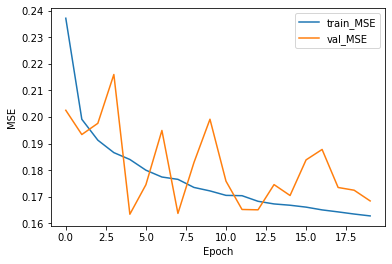

In [483]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un train MSE de 0.1840 y un val MSE de 0.1634 en 5 épocas. Mejor resultado hasta el momento, aunque observamos que el buen entrenamiento no se transmite en una mejora en los datos de validación, por lo que es probable que el modelo esté sobreajustando. Tarda unos 3 minutos por época

### Modelo 21 bis(22). Tomamos datos cada 5 minutos de DOS HORAS antes y predecimos a 15 minutos, utilizando fórmula 3 de neuronas tomando el resto de datos atmosféricos. Introducimos estos datos en la capa que concatena. 

In [579]:
X_train1=np.array(PVGISdf.iloc[1:len(PVGISdf)-26:3,1:4]) #Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=np.array(PVGISdf.iloc[2:len(PVGISdf)-25:3,1:4]) #Tengo datos de radiación de 13:20-15:15 e introduzco producción a las 15:30.
X_train3=np.array(PVGISdf.iloc[3:len(PVGISdf)-24:3,1:4]) #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=np.array(PVGISdf.iloc[4:len(PVGISdf)-23:3,1:4])
X_train5=np.array(PVGISdf.iloc[5:len(PVGISdf)-22:3,1:4])
X_train6=np.array(PVGISdf.iloc[6:len(PVGISdf)-21:3,1:4])
X_train7=np.array(PVGISdf.iloc[7:len(PVGISdf)-20:3,1:4]) 
X_train8=np.array(PVGISdf.iloc[8:len(PVGISdf)-19:3,1:4])
X_train9=np.array(PVGISdf.iloc[9:len(PVGISdf)-18:3,1:4]) 
X_train10=np.array(PVGISdf.iloc[10:len(PVGISdf)-17:3,1:4])
X_train11=np.array(PVGISdf.iloc[11:len(PVGISdf)-16:3,1:4])
X_train12=np.array(PVGISdf.iloc[12:len(PVGISdf)-15:3,1:4]) #Tomo datos hasta las 22:30 del 16/12/2018 para que mi última predicción sea la de las 22:45
X_train13=np.array(PVGISdf.iloc[13:len(PVGISdf)-14:3,1:4])  
X_train14=np.array(PVGISdf.iloc[14:len(PVGISdf)-13:3,1:4]) 
X_train15=np.array(PVGISdf.iloc[15:len(PVGISdf)-12:3,1:4]) 
X_train16=np.array(PVGISdf.iloc[16:len(PVGISdf)-11:3,1:4])
X_train17=np.array(PVGISdf.iloc[17:len(PVGISdf)-10:3,1:4])
X_train18=np.array(PVGISdf.iloc[18:len(PVGISdf)-9:3,1:4])
X_train19=np.array(PVGISdf.iloc[19:len(PVGISdf)-8:3,1:4])  
X_train20=np.array(PVGISdf.iloc[20:len(PVGISdf)-7:3,1:4]) 
X_train21=np.array(PVGISdf.iloc[21:len(PVGISdf)-6:3,1:4]) 
X_train22=np.array(PVGISdf.iloc[22:len(PVGISdf)-5:3,1:4])
X_train23=np.array(PVGISdf.iloc[23:len(PVGISdf)-4:3,1:4])
X_train24=np.array(PVGISdf.iloc[24:len(PVGISdf)-3:3,1:4])

X_trainatm1=np.array(PVGISdf.iloc[1:len(PVGISdf)-26:3,4:7])  
X_trainatm2=np.array(PVGISdf.iloc[2:len(PVGISdf)-25:3,4:7]) 
X_trainatm3=np.array(PVGISdf.iloc[3:len(PVGISdf)-24:3,4:7]) 
X_trainatm4=np.array(PVGISdf.iloc[4:len(PVGISdf)-23:3,4:7])
X_trainatm5=np.array(PVGISdf.iloc[5:len(PVGISdf)-22:3,4:7])
X_trainatm6=np.array(PVGISdf.iloc[6:len(PVGISdf)-21:3,4:7])
X_trainatm7=np.array(PVGISdf.iloc[7:len(PVGISdf)-20:3,4:7]) 
X_trainatm8=np.array(PVGISdf.iloc[8:len(PVGISdf)-19:3,4:7])
X_trainatm9=np.array(PVGISdf.iloc[9:len(PVGISdf)-18:3,4:7]) 
X_trainatm10=np.array(PVGISdf.iloc[10:len(PVGISdf)-17:3,4:7])
X_trainatm11=np.array(PVGISdf.iloc[11:len(PVGISdf)-16:3,4:7])
X_trainatm12=np.array(PVGISdf.iloc[12:len(PVGISdf)-15:3,4:7])
X_trainatm13=np.array(PVGISdf.iloc[13:len(PVGISdf)-14:3,4:7])  
X_trainatm14=np.array(PVGISdf.iloc[14:len(PVGISdf)-13:3,4:7]) 
X_trainatm15=np.array(PVGISdf.iloc[15:len(PVGISdf)-12:3,4:7]) 
X_trainatm16=np.array(PVGISdf.iloc[16:len(PVGISdf)-11:3,4:7])
X_trainatm17=np.array(PVGISdf.iloc[17:len(PVGISdf)-10:3,4:7])
X_trainatm18=np.array(PVGISdf.iloc[18:len(PVGISdf)-9:3,4:7])
X_trainatm19=np.array(PVGISdf.iloc[19:len(PVGISdf)-8:3,4:7])  
X_trainatm20=np.array(PVGISdf.iloc[20:len(PVGISdf)-7:3,4:7]) 
X_trainatm21=np.array(PVGISdf.iloc[21:len(PVGISdf)-6:3,4:7]) 
X_trainatm22=np.array(PVGISdf.iloc[22:len(PVGISdf)-5:3,4:7])
X_trainatm23=np.array(PVGISdf.iloc[23:len(PVGISdf)-4:3,4:7])
X_trainatm24=np.array(PVGISdf.iloc[24:len(PVGISdf)-3:3,4:7])

y_train=np.array(PVOutputdf.iloc[9:len(PVOutputdf),1]).astype(float) #No tomo los primeros 7 valores para cuadrarlo, que empiece a las 15

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 
X_train7std=np.std(X_train7) 
X_train8std=np.std(X_train8)
X_train9std=np.std(X_train9)
X_train10std=np.std(X_train10) 
X_train11std=np.std(X_train11) 
X_train12std=np.std(X_train12)
X_train13std=np.std(X_train13) 
X_train14std=np.std(X_train14) 
X_train15std=np.std(X_train15)
X_train16std=np.std(X_train16)
X_train17std=np.std(X_train17) 
X_train18std=np.std(X_train18)
X_train19std=np.std(X_train19) 
X_train20std=np.std(X_train20) 
X_train21std=np.std(X_train21)
X_train22std=np.std(X_train22)
X_train23std=np.std(X_train23) 
X_train24std=np.std(X_train24) 


X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 
X_train7est=X_train7/X_train7std 
X_train8est=X_train8/X_train8std
X_train9est=X_train9/X_train9std 
X_train10est=X_train10/X_train10std 
X_train11est=X_train11/X_train11std 
X_train12est=X_train12/X_train12std
X_train13est=X_train13/X_train13std 
X_train14est=X_train14/X_train14std
X_train15est=X_train15/X_train15std 
X_train16est=X_train16/X_train16std 
X_train17est=X_train17/X_train17std 
X_train18est=X_train18/X_train18std
X_train19est=X_train19/X_train19std 
X_train20est=X_train20/X_train20std
X_train21est=X_train21/X_train21std 
X_train22est=X_train22/X_train22std 
X_train23est=X_train23/X_train23std 
X_train24est=X_train24/X_train24std

X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est,X_train7est,X_train8est,X_train9est,X_train10est,X_train11est,X_train12est,X_train13est,X_train14est,X_train15est,X_train16est,X_train17est,X_train18est,X_train19est,X_train20est,X_train21est,X_train22est,X_train23est,X_train24est)

X_trainatm1std=np.std(X_trainatm1)  
X_trainatm2std=np.std(X_trainatm2) 
X_trainatm3std=np.std(X_trainatm3) 
X_trainatm4std=np.std(X_trainatm4)
X_trainatm5std=np.std(X_trainatm5)
X_trainatm6std=np.std(X_trainatm6)
X_trainatm7std=np.std(X_trainatm7)
X_trainatm8std=np.std(X_trainatm8)
X_trainatm9std=np.std(X_trainatm9) 
X_trainatm10std=np.std(X_trainatm10)
X_trainatm11std=np.std(X_trainatm11)
X_trainatm12std=np.std(X_trainatm12)
X_trainatm13std=np.std(X_trainatm13)
X_trainatm14std=np.std(X_trainatm14)
X_trainatm15std=np.std(X_trainatm15) 
X_trainatm16std=np.std(X_trainatm16)
X_trainatm17std=np.std(X_trainatm17)
X_trainatm18std=np.std(X_trainatm18)
X_trainatm19std=np.std(X_trainatm19)
X_trainatm20std=np.std(X_trainatm20)
X_trainatm21std=np.std(X_trainatm21) 
X_trainatm22std=np.std(X_trainatm22)
X_trainatm23std=np.std(X_trainatm23)
X_trainatm24std=np.std(X_trainatm24)

X_trainatm1est=X_trainatm1/X_trainatm1std 
X_trainatm2est=X_trainatm2/X_trainatm2std 
X_trainatm3est=X_trainatm3/X_trainatm3std 
X_trainatm4est=X_trainatm4/X_trainatm4std
X_trainatm5est=X_trainatm5/X_trainatm5std 
X_trainatm6est=X_trainatm6/X_trainatm6std 
X_trainatm7est=X_trainatm7/X_trainatm7std 
X_trainatm8est=X_trainatm8/X_trainatm8std
X_trainatm9est=X_trainatm9/X_trainatm9std 
X_trainatm10est=X_trainatm10/X_trainatm10std 
X_trainatm11est=X_trainatm11/X_trainatm11std 
X_trainatm12est=X_trainatm12/X_trainatm12std
X_trainatm13est=X_trainatm13/X_trainatm13std 
X_trainatm14est=X_trainatm14/X_trainatm14std 
X_trainatm15est=X_trainatm15/X_trainatm15std
X_trainatm16est=X_trainatm16/X_trainatm16std 
X_trainatm17est=X_trainatm17/X_trainatm17std 
X_trainatm18est=X_trainatm18/X_trainatm18std
X_trainatm19est=X_trainatm19/X_trainatm19std 
X_trainatm20est=X_trainatm20/X_trainatm20std 
X_trainatm21est=X_trainatm21/X_trainatm21std
X_trainatm22est=X_trainatm22/X_trainatm22std 
X_trainatm23est=X_trainatm23/X_trainatm23std 
X_trainatm24est=X_trainatm24/X_trainatm24std

X_trainatmest=(X_trainatm1est,X_trainatm2est,X_trainatm3est,X_trainatm4est,X_trainatm5est,X_trainatm6est,X_trainatm7est,X_trainatm8est,X_trainatm9est,X_trainatm10est,X_trainatm11est,X_trainatm12est,X_trainatm13est,X_trainatm14est,X_trainatm15est,X_trainatm16est,X_trainatm17est,X_trainatm18est,X_trainatm19est,X_trainatm20est,X_trainatm21est,X_trainatm22est,X_trainatm23est,X_trainatm24est)

Y_trainstd=np.std(y_train) 
Y_trainest=y_train/Y_trainstd 

In [581]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)
entrada13 = tf.keras.layers.Input(shape=3)
entrada14 = tf.keras.layers.Input(shape=3)
entrada15 = tf.keras.layers.Input(shape=3)
entrada16 = tf.keras.layers.Input(shape=3)
entrada17 = tf.keras.layers.Input(shape=3)
entrada18 = tf.keras.layers.Input(shape=3)
entrada19 = tf.keras.layers.Input(shape=3)
entrada20 = tf.keras.layers.Input(shape=3)
entrada21 = tf.keras.layers.Input(shape=3)
entrada22 = tf.keras.layers.Input(shape=3)
entrada23 = tf.keras.layers.Input(shape=3)
entrada24 = tf.keras.layers.Input(shape=3)

entradaatm1 = tf.keras.layers.Input(shape=3) 
entradaatm2 = tf.keras.layers.Input(shape=3)
entradaatm3 = tf.keras.layers.Input(shape=3)
entradaatm4 = tf.keras.layers.Input(shape=3)
entradaatm5 = tf.keras.layers.Input(shape=3)
entradaatm6 = tf.keras.layers.Input(shape=3)
entradaatm7 = tf.keras.layers.Input(shape=3)
entradaatm8 = tf.keras.layers.Input(shape=3)
entradaatm9 = tf.keras.layers.Input(shape=3)
entradaatm10 = tf.keras.layers.Input(shape=3)
entradaatm11 = tf.keras.layers.Input(shape=3)
entradaatm12 = tf.keras.layers.Input(shape=3)
entradaatm13 = tf.keras.layers.Input(shape=3)
entradaatm14 = tf.keras.layers.Input(shape=3)
entradaatm15 = tf.keras.layers.Input(shape=3) 
entradaatm16 = tf.keras.layers.Input(shape=3)
entradaatm17 = tf.keras.layers.Input(shape=3)
entradaatm18 = tf.keras.layers.Input(shape=3)
entradaatm19 = tf.keras.layers.Input(shape=3)
entradaatm20 = tf.keras.layers.Input(shape=3)
entradaatm21 = tf.keras.layers.Input(shape=3) 
entradaatm22 = tf.keras.layers.Input(shape=3)
entradaatm23 = tf.keras.layers.Input(shape=3)
entradaatm24 = tf.keras.layers.Input(shape=3)

#Capas ocultas formula 3: Hidden=1/2*(In + Out)+ SQRT(Training)=1/2*(3 + 1)+ np.sqrt(132323)=365.7622850159153
oculta1 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada12)
oculta13 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada13)
oculta14 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada14)
oculta15 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada15)
oculta16 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada16)
oculta17 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada17)
oculta18 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada18)
oculta19 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada19)
oculta20 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada20)
oculta21 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada21)
oculta22 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada22)
oculta23 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada23)
oculta24 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada24)


concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12, oculta13, oculta14, oculta15, oculta16, oculta17, oculta18, oculta19, oculta20, oculta21, oculta22, oculta23, oculta24,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24]) #estratificada, concatena las 12
#2 layers intermedias, formula 2: Hidden =3/2*(In + Out)=3/2*(1+1)=3
adoculta1=tf.keras.layers.Dense((1/2*(1 + 1)+ np.sqrt(132323)), activation="relu")(concat)
adoculta2=tf.keras.layers.Dense((1/2*(1 + 1)+ np.sqrt(132323)), activation="relu")(adoculta1)
salida=tf.keras.layers.Dense((1/2*(1 + 0)+ np.sqrt(132323)), activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo21b = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12, entrada13, entrada14, entrada15, entrada16, entrada17, entrada18, entrada19, entrada20, entrada21, entrada22, entrada23, entrada24,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24], outputs=[salida])

modelo21b.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo21b.fit([X_trainest,X_trainatmest], Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2)
#Mucho mejor resultado introduciendo entre corchetes que entre paréntesis (X_trainest,X_trainatmest)
#No estoy 100% seguro de que esté bien introducido así, cómo sabe que las entradai corresponden a X_train y que entradaatmi corresponden a X_trainatm?

Epoch 1/1000
3308/3308 [==============================] - 132s 40ms/step - loss: 0.3237 - mae: 0.3700 - val_loss: 0.2381 - val_mae: 0.3519
Epoch 2/1000
3308/3308 [==============================] - 131s 40ms/step - loss: 0.2752 - mae: 0.3299 - val_loss: 0.2464 - val_mae: 0.3681
Epoch 3/1000
3308/3308 [==============================] - 130s 39ms/step - loss: 0.2625 - mae: 0.3184 - val_loss: 0.2312 - val_mae: 0.2933
Epoch 4/1000
3308/3308 [==============================] - 131s 40ms/step - loss: 0.2558 - mae: 0.3110 - val_loss: 0.2025 - val_mae: 0.3081
Epoch 5/1000
3308/3308 [==============================] - 129s 39ms/step - loss: 0.2512 - mae: 0.3075 - val_loss: 0.1876 - val_mae: 0.2568
Epoch 6/1000
3308/3308 [==============================] - 129s 39ms/step - loss: 0.2466 - mae: 0.3027 - val_loss: 0.1917 - val_mae: 0.2869
Epoch 7/1000
3308/3308 [==============================] - 131s 39ms/step - loss: 0.2448 - mae: 0.3004 - val_loss: 0.2754 - val_mae: 0.3843
Epoch 8/1000
3308/3308 [===

Text(0, 0.5, 'MSE')

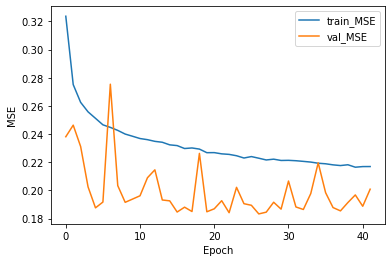

In [582]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un train MSE de 0.229 y un val MSE de 0.1833  en 27 épocas. Resultados parecidos al modelo 18 (mismo pero con fórmula 2), no mejora al modelo 21. Aunque observamos que el buen entrenamiento no se transmite en una mejora en los datos de validación, por lo que es probable que el modelo esté sobreajustando. Tarda unos 135 segundos por época

### Modelo 22. Tomamos datos cada 5 minutos de TRES horas antes y predecimos a 15 minutos, utilizando fórmula 2 de neuronas tomando el resto de datos atmosféricos. Introducimos estos datos en la capa que concatena. Introducimos datos de producción de 15 minutos antes en la entrada

In [487]:
X_train1=np.array(PVGISdf.iloc[1:len(PVGISdf)-38:3,1:4]) #Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=np.array(PVGISdf.iloc[2:len(PVGISdf)-37:3,1:4]) #Tengo datos de radiación de 13:20-16:15 e introduzco producción a las 15:30.
X_train3=np.array(PVGISdf.iloc[3:len(PVGISdf)-36:3,1:4]) #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=np.array(PVGISdf.iloc[4:len(PVGISdf)-35:3,1:4])
X_train5=np.array(PVGISdf.iloc[5:len(PVGISdf)-34:3,1:4])
X_train6=np.array(PVGISdf.iloc[6:len(PVGISdf)-33:3,1:4])
X_train7=np.array(PVGISdf.iloc[7:len(PVGISdf)-32:3,1:4]) 
X_train8=np.array(PVGISdf.iloc[8:len(PVGISdf)-31:3,1:4])
X_train9=np.array(PVGISdf.iloc[9:len(PVGISdf)-30:3,1:4]) 
X_train10=np.array(PVGISdf.iloc[10:len(PVGISdf)-29:3,1:4])
X_train11=np.array(PVGISdf.iloc[11:len(PVGISdf)-28:3,1:4])
X_train12=np.array(PVGISdf.iloc[12:len(PVGISdf)-27:3,1:4]) #Tomo datos hasta las 22:30 del 16/12/2018 para que mi última predicción sea la de las 22:45
X_train13=np.array(PVGISdf.iloc[13:len(PVGISdf)-26:3,1:4])  
X_train14=np.array(PVGISdf.iloc[14:len(PVGISdf)-25:3,1:4]) 
X_train15=np.array(PVGISdf.iloc[15:len(PVGISdf)-24:3,1:4]) 
X_train16=np.array(PVGISdf.iloc[16:len(PVGISdf)-23:3,1:4])
X_train17=np.array(PVGISdf.iloc[17:len(PVGISdf)-22:3,1:4])
X_train18=np.array(PVGISdf.iloc[18:len(PVGISdf)-21:3,1:4])
X_train19=np.array(PVGISdf.iloc[19:len(PVGISdf)-20:3,1:4])  
X_train20=np.array(PVGISdf.iloc[20:len(PVGISdf)-19:3,1:4]) 
X_train21=np.array(PVGISdf.iloc[21:len(PVGISdf)-18:3,1:4]) 
X_train22=np.array(PVGISdf.iloc[22:len(PVGISdf)-17:3,1:4])
X_train23=np.array(PVGISdf.iloc[23:len(PVGISdf)-16:3,1:4])
X_train24=np.array(PVGISdf.iloc[24:len(PVGISdf)-15:3,1:4])
X_train25=np.array(PVGISdf.iloc[25:len(PVGISdf)-14:3,1:4])  
X_train26=np.array(PVGISdf.iloc[26:len(PVGISdf)-13:3,1:4]) 
X_train27=np.array(PVGISdf.iloc[27:len(PVGISdf)-12:3,1:4]) 
X_train28=np.array(PVGISdf.iloc[28:len(PVGISdf)-11:3,1:4])
X_train29=np.array(PVGISdf.iloc[29:len(PVGISdf)-10:3,1:4])
X_train30=np.array(PVGISdf.iloc[30:len(PVGISdf)-9:3,1:4])
X_train31=np.array(PVGISdf.iloc[31:len(PVGISdf)-8:3,1:4])  
X_train32=np.array(PVGISdf.iloc[32:len(PVGISdf)-7:3,1:4]) 
X_train33=np.array(PVGISdf.iloc[33:len(PVGISdf)-6:3,1:4]) 
X_train34=np.array(PVGISdf.iloc[34:len(PVGISdf)-5:3,1:4])
X_train35=np.array(PVGISdf.iloc[35:len(PVGISdf)-4:3,1:4])
X_train36=np.array(PVGISdf.iloc[36:len(PVGISdf)-3:3,1:4])

X_trainatm1=np.array(PVGISdf.iloc[1:len(PVGISdf)-38:3,4:7])  
X_trainatm2=np.array(PVGISdf.iloc[2:len(PVGISdf)-37:3,4:7]) 
X_trainatm3=np.array(PVGISdf.iloc[3:len(PVGISdf)-36:3,4:7]) 
X_trainatm4=np.array(PVGISdf.iloc[4:len(PVGISdf)-35:3,4:7])
X_trainatm5=np.array(PVGISdf.iloc[5:len(PVGISdf)-34:3,4:7])
X_trainatm6=np.array(PVGISdf.iloc[6:len(PVGISdf)-33:3,4:7])
X_trainatm7=np.array(PVGISdf.iloc[7:len(PVGISdf)-32:3,4:7]) 
X_trainatm8=np.array(PVGISdf.iloc[8:len(PVGISdf)-31:3,4:7])
X_trainatm9=np.array(PVGISdf.iloc[9:len(PVGISdf)-30:3,4:7]) 
X_trainatm10=np.array(PVGISdf.iloc[10:len(PVGISdf)-29:3,4:7])
X_trainatm11=np.array(PVGISdf.iloc[11:len(PVGISdf)-28:3,4:7])
X_trainatm12=np.array(PVGISdf.iloc[12:len(PVGISdf)-27:3,4:7])
X_trainatm13=np.array(PVGISdf.iloc[13:len(PVGISdf)-26:3,4:7])  
X_trainatm14=np.array(PVGISdf.iloc[14:len(PVGISdf)-25:3,4:7]) 
X_trainatm15=np.array(PVGISdf.iloc[15:len(PVGISdf)-24:3,4:7]) 
X_trainatm16=np.array(PVGISdf.iloc[16:len(PVGISdf)-23:3,4:7])
X_trainatm17=np.array(PVGISdf.iloc[17:len(PVGISdf)-22:3,4:7])
X_trainatm18=np.array(PVGISdf.iloc[18:len(PVGISdf)-21:3,4:7])
X_trainatm19=np.array(PVGISdf.iloc[19:len(PVGISdf)-20:3,4:7])  
X_trainatm20=np.array(PVGISdf.iloc[20:len(PVGISdf)-19:3,4:7]) 
X_trainatm21=np.array(PVGISdf.iloc[21:len(PVGISdf)-18:3,4:7]) 
X_trainatm22=np.array(PVGISdf.iloc[22:len(PVGISdf)-17:3,4:7])
X_trainatm23=np.array(PVGISdf.iloc[23:len(PVGISdf)-16:3,4:7])
X_trainatm24=np.array(PVGISdf.iloc[24:len(PVGISdf)-15:3,4:7])
X_trainatm25=np.array(PVGISdf.iloc[25:len(PVGISdf)-14:3,4:7])  
X_trainatm26=np.array(PVGISdf.iloc[26:len(PVGISdf)-13:3,4:7]) 
X_trainatm27=np.array(PVGISdf.iloc[27:len(PVGISdf)-12:3,4:7]) 
X_trainatm28=np.array(PVGISdf.iloc[28:len(PVGISdf)-11:3,4:7])
X_trainatm29=np.array(PVGISdf.iloc[29:len(PVGISdf)-10:3,4:7])
X_trainatm30=np.array(PVGISdf.iloc[30:len(PVGISdf)-9:3,4:7])
X_trainatm31=np.array(PVGISdf.iloc[31:len(PVGISdf)-8:3,4:7])  
X_trainatm32=np.array(PVGISdf.iloc[32:len(PVGISdf)-7:3,4:7]) 
X_trainatm33=np.array(PVGISdf.iloc[33:len(PVGISdf)-6:3,4:7]) 
X_trainatm34=np.array(PVGISdf.iloc[34:len(PVGISdf)-5:3,4:7])
X_trainatm35=np.array(PVGISdf.iloc[35:len(PVGISdf)-4:3,4:7])
X_trainatm36=np.array(PVGISdf.iloc[36:len(PVGISdf)-3:3,4:7])

X_prod=np.array(PVOutputdf.iloc[12:len(PVOutputdf)-1,1]).astype(float) #Producción 15 minutos antes
y_train=np.array(PVOutputdf.iloc[13:len(PVOutputdf),1]).astype(float) #No tomo los primeros 7 valores para cuadrarlo, que empiece a las 16:30

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 
X_train7std=np.std(X_train7) 
X_train8std=np.std(X_train8)
X_train9std=np.std(X_train9)
X_train10std=np.std(X_train10) 
X_train11std=np.std(X_train11) 
X_train12std=np.std(X_train12)
X_train13std=np.std(X_train13) 
X_train14std=np.std(X_train14) 
X_train15std=np.std(X_train15)
X_train16std=np.std(X_train16)
X_train17std=np.std(X_train17) 
X_train18std=np.std(X_train18)
X_train19std=np.std(X_train19) 
X_train20std=np.std(X_train20) 
X_train21std=np.std(X_train21)
X_train22std=np.std(X_train22)
X_train23std=np.std(X_train23) 
X_train24std=np.std(X_train24)
X_train25std=np.std(X_train25) 
X_train26std=np.std(X_train26) 
X_train27std=np.std(X_train27)
X_train28std=np.std(X_train28)
X_train29std=np.std(X_train29) 
X_train30std=np.std(X_train30)
X_train31std=np.std(X_train31) 
X_train32std=np.std(X_train32) 
X_train33std=np.std(X_train33)
X_train34std=np.std(X_train34)
X_train35std=np.std(X_train35) 
X_train36std=np.std(X_train36) 


X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 
X_train7est=X_train7/X_train7std 
X_train8est=X_train8/X_train8std
X_train9est=X_train9/X_train9std 
X_train10est=X_train10/X_train10std 
X_train11est=X_train11/X_train11std 
X_train12est=X_train12/X_train12std
X_train13est=X_train13/X_train13std 
X_train14est=X_train14/X_train14std
X_train15est=X_train15/X_train15std 
X_train16est=X_train16/X_train16std 
X_train17est=X_train17/X_train17std 
X_train18est=X_train18/X_train18std
X_train19est=X_train19/X_train19std 
X_train20est=X_train20/X_train20std
X_train21est=X_train21/X_train21std 
X_train22est=X_train22/X_train22std 
X_train23est=X_train23/X_train23std 
X_train24est=X_train24/X_train24std
X_train25est=X_train25/X_train25std 
X_train26est=X_train26/X_train26std
X_train27est=X_train27/X_train27std 
X_train28est=X_train28/X_train28std 
X_train29est=X_train29/X_train29std 
X_train30est=X_train30/X_train30std
X_train31est=X_train31/X_train31std 
X_train32est=X_train32/X_train32std
X_train33est=X_train33/X_train33std 
X_train34est=X_train34/X_train34std 
X_train35est=X_train35/X_train35std 
X_train36est=X_train36/X_train36std

X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est,X_train7est,X_train8est,X_train9est,X_train10est,X_train11est,X_train12est,X_train13est,X_train14est,X_train15est,X_train16est,X_train17est,X_train18est,X_train19est,X_train20est,X_train21est,X_train22est,X_train23est,X_train24est,X_train25est,X_train26est,X_train27est,X_train28est,X_train29est,X_train30est,X_train31est,X_train32est,X_train33est,X_train34est,X_train35est,X_train36est)

X_trainatm1std=np.std(X_trainatm1)  
X_trainatm2std=np.std(X_trainatm2) 
X_trainatm3std=np.std(X_trainatm3) 
X_trainatm4std=np.std(X_trainatm4)
X_trainatm5std=np.std(X_trainatm5)
X_trainatm6std=np.std(X_trainatm6)
X_trainatm7std=np.std(X_trainatm7)
X_trainatm8std=np.std(X_trainatm8)
X_trainatm9std=np.std(X_trainatm9) 
X_trainatm10std=np.std(X_trainatm10)
X_trainatm11std=np.std(X_trainatm11)
X_trainatm12std=np.std(X_trainatm12)
X_trainatm13std=np.std(X_trainatm13)
X_trainatm14std=np.std(X_trainatm14)
X_trainatm15std=np.std(X_trainatm15) 
X_trainatm16std=np.std(X_trainatm16)
X_trainatm17std=np.std(X_trainatm17)
X_trainatm18std=np.std(X_trainatm18)
X_trainatm19std=np.std(X_trainatm19)
X_trainatm20std=np.std(X_trainatm20)
X_trainatm21std=np.std(X_trainatm21) 
X_trainatm22std=np.std(X_trainatm22)
X_trainatm23std=np.std(X_trainatm23)
X_trainatm24std=np.std(X_trainatm24)
X_trainatm25std=np.std(X_trainatm25)
X_trainatm26std=np.std(X_trainatm26)
X_trainatm27std=np.std(X_trainatm27) 
X_trainatm28std=np.std(X_trainatm28)
X_trainatm29std=np.std(X_trainatm29)
X_trainatm30std=np.std(X_trainatm30)
X_trainatm31std=np.std(X_trainatm31)
X_trainatm32std=np.std(X_trainatm32)
X_trainatm33std=np.std(X_trainatm33) 
X_trainatm34std=np.std(X_trainatm34)
X_trainatm35std=np.std(X_trainatm35)
X_trainatm36std=np.std(X_trainatm36)

X_trainatm1est=X_trainatm1/X_trainatm1std 
X_trainatm2est=X_trainatm2/X_trainatm2std 
X_trainatm3est=X_trainatm3/X_trainatm3std 
X_trainatm4est=X_trainatm4/X_trainatm4std
X_trainatm5est=X_trainatm5/X_trainatm5std 
X_trainatm6est=X_trainatm6/X_trainatm6std 
X_trainatm7est=X_trainatm7/X_trainatm7std 
X_trainatm8est=X_trainatm8/X_trainatm8std
X_trainatm9est=X_trainatm9/X_trainatm9std 
X_trainatm10est=X_trainatm10/X_trainatm10std 
X_trainatm11est=X_trainatm11/X_trainatm11std 
X_trainatm12est=X_trainatm12/X_trainatm12std
X_trainatm13est=X_trainatm13/X_trainatm13std 
X_trainatm14est=X_trainatm14/X_trainatm14std 
X_trainatm15est=X_trainatm15/X_trainatm15std
X_trainatm16est=X_trainatm16/X_trainatm16std 
X_trainatm17est=X_trainatm17/X_trainatm17std 
X_trainatm18est=X_trainatm18/X_trainatm18std
X_trainatm19est=X_trainatm19/X_trainatm19std 
X_trainatm20est=X_trainatm20/X_trainatm20std 
X_trainatm21est=X_trainatm21/X_trainatm21std
X_trainatm22est=X_trainatm22/X_trainatm22std 
X_trainatm23est=X_trainatm23/X_trainatm23std 
X_trainatm24est=X_trainatm24/X_trainatm24std
X_trainatm25est=X_trainatm25/X_trainatm25std 
X_trainatm26est=X_trainatm26/X_trainatm26std 
X_trainatm27est=X_trainatm27/X_trainatm27std
X_trainatm28est=X_trainatm28/X_trainatm28std 
X_trainatm29est=X_trainatm29/X_trainatm29std 
X_trainatm30est=X_trainatm30/X_trainatm30std
X_trainatm31est=X_trainatm31/X_trainatm31std 
X_trainatm32est=X_trainatm32/X_trainatm32std 
X_trainatm33est=X_trainatm33/X_trainatm33std
X_trainatm34est=X_trainatm34/X_trainatm34std 
X_trainatm35est=X_trainatm35/X_trainatm35std 
X_trainatm36est=X_trainatm36/X_trainatm36std

X_trainatmest=(X_trainatm1est,X_trainatm2est,X_trainatm3est,X_trainatm4est,X_trainatm5est,X_trainatm6est,X_trainatm7est,X_trainatm8est,X_trainatm9est,X_trainatm10est,X_trainatm11est,X_trainatm12est,X_trainatm13est,X_trainatm14est,X_trainatm15est,X_trainatm16est,X_trainatm17est,X_trainatm18est,X_trainatm19est,X_trainatm20est,X_trainatm21est,X_trainatm22est,X_trainatm23est,X_trainatm24est,X_trainatm25est,X_trainatm26est,X_trainatm27est,X_trainatm28est,X_trainatm29est,X_trainatm30est,X_trainatm31est,X_trainatm32est,X_trainatm33est,X_trainatm34est,X_trainatm35est,X_trainatm36est)

X_prodstd=np.std(X_prod)
X_prodest=X_prod/X_prodstd 

Y_trainstd=np.std(y_train) 
Y_trainest=y_train/Y_trainstd 

In [488]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)
entrada13 = tf.keras.layers.Input(shape=3)
entrada14 = tf.keras.layers.Input(shape=3)
entrada15 = tf.keras.layers.Input(shape=3)
entrada16 = tf.keras.layers.Input(shape=3)
entrada17 = tf.keras.layers.Input(shape=3)
entrada18 = tf.keras.layers.Input(shape=3)
entrada19 = tf.keras.layers.Input(shape=3)
entrada20 = tf.keras.layers.Input(shape=3)
entrada21 = tf.keras.layers.Input(shape=3)
entrada22 = tf.keras.layers.Input(shape=3)
entrada23 = tf.keras.layers.Input(shape=3)
entrada24 = tf.keras.layers.Input(shape=3)
entrada25 = tf.keras.layers.Input(shape=3)
entrada26 = tf.keras.layers.Input(shape=3)
entrada27 = tf.keras.layers.Input(shape=3)
entrada28 = tf.keras.layers.Input(shape=3)
entrada29 = tf.keras.layers.Input(shape=3)
entrada30 = tf.keras.layers.Input(shape=3)
entrada31 = tf.keras.layers.Input(shape=3)
entrada32 = tf.keras.layers.Input(shape=3)
entrada33 = tf.keras.layers.Input(shape=3)
entrada34 = tf.keras.layers.Input(shape=3)
entrada35 = tf.keras.layers.Input(shape=3)
entrada36 = tf.keras.layers.Input(shape=3)

entradaatm1 = tf.keras.layers.Input(shape=3) 
entradaatm2 = tf.keras.layers.Input(shape=3)
entradaatm3 = tf.keras.layers.Input(shape=3)
entradaatm4 = tf.keras.layers.Input(shape=3)
entradaatm5 = tf.keras.layers.Input(shape=3)
entradaatm6 = tf.keras.layers.Input(shape=3)
entradaatm7 = tf.keras.layers.Input(shape=3)
entradaatm8 = tf.keras.layers.Input(shape=3)
entradaatm9 = tf.keras.layers.Input(shape=3)
entradaatm10 = tf.keras.layers.Input(shape=3)
entradaatm11 = tf.keras.layers.Input(shape=3)
entradaatm12 = tf.keras.layers.Input(shape=3)
entradaatm13 = tf.keras.layers.Input(shape=3)
entradaatm14 = tf.keras.layers.Input(shape=3)
entradaatm15 = tf.keras.layers.Input(shape=3) 
entradaatm16 = tf.keras.layers.Input(shape=3)
entradaatm17 = tf.keras.layers.Input(shape=3)
entradaatm18 = tf.keras.layers.Input(shape=3)
entradaatm19 = tf.keras.layers.Input(shape=3)
entradaatm20 = tf.keras.layers.Input(shape=3)
entradaatm21 = tf.keras.layers.Input(shape=3) 
entradaatm22 = tf.keras.layers.Input(shape=3)
entradaatm23 = tf.keras.layers.Input(shape=3)
entradaatm24 = tf.keras.layers.Input(shape=3)
entradaatm25 = tf.keras.layers.Input(shape=3)
entradaatm26 = tf.keras.layers.Input(shape=3)
entradaatm27 = tf.keras.layers.Input(shape=3) 
entradaatm28 = tf.keras.layers.Input(shape=3)
entradaatm29 = tf.keras.layers.Input(shape=3)
entradaatm30 = tf.keras.layers.Input(shape=3)
entradaatm31 = tf.keras.layers.Input(shape=3)
entradaatm32 = tf.keras.layers.Input(shape=3)
entradaatm33 = tf.keras.layers.Input(shape=3) 
entradaatm34 = tf.keras.layers.Input(shape=3)
entradaatm35 = tf.keras.layers.Input(shape=3)
entradaatm36 = tf.keras.layers.Input(shape=3)

entradaprod=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat

#Capas ocultas formula 2: Hidden =3/2*(In + Out)=3/2*(3+1)=6
oculta1 = tf.keras.layers.Dense(6, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(6, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(6, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(6, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(6, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(6, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(6, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(6, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(6, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(6, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(6, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(6, activation="relu")(entrada12)
oculta13 = tf.keras.layers.Dense(6, activation="relu")(entrada13)
oculta14 = tf.keras.layers.Dense(6, activation="relu")(entrada14)
oculta15 = tf.keras.layers.Dense(6, activation="relu")(entrada15)
oculta16 = tf.keras.layers.Dense(6, activation="relu")(entrada16)
oculta17 = tf.keras.layers.Dense(6, activation="relu")(entrada17)
oculta18 = tf.keras.layers.Dense(6, activation="relu")(entrada18)
oculta19 = tf.keras.layers.Dense(6, activation="relu")(entrada19)
oculta20 = tf.keras.layers.Dense(6, activation="relu")(entrada20)
oculta21 = tf.keras.layers.Dense(6, activation="relu")(entrada21)
oculta22 = tf.keras.layers.Dense(6, activation="relu")(entrada22)
oculta23 = tf.keras.layers.Dense(6, activation="relu")(entrada23)
oculta24 = tf.keras.layers.Dense(6, activation="relu")(entrada24)
oculta25 = tf.keras.layers.Dense(6, activation="relu")(entrada25)
oculta26 = tf.keras.layers.Dense(6, activation="relu")(entrada26)
oculta27 = tf.keras.layers.Dense(6, activation="relu")(entrada27)
oculta28 = tf.keras.layers.Dense(6, activation="relu")(entrada28)
oculta29 = tf.keras.layers.Dense(6, activation="relu")(entrada29)
oculta30 = tf.keras.layers.Dense(6, activation="relu")(entrada30)
oculta31 = tf.keras.layers.Dense(6, activation="relu")(entrada31)
oculta32 = tf.keras.layers.Dense(6, activation="relu")(entrada32)
oculta33 = tf.keras.layers.Dense(6, activation="relu")(entrada33)
oculta34 = tf.keras.layers.Dense(6, activation="relu")(entrada34)
oculta35 = tf.keras.layers.Dense(6, activation="relu")(entrada35)
oculta36 = tf.keras.layers.Dense(6, activation="relu")(entrada36)


concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12, oculta13, oculta14, oculta15, oculta16, oculta17, oculta18, oculta19, oculta20, oculta21, oculta22, oculta23, oculta24, oculta25, oculta26, oculta27, oculta28, oculta29, oculta30, oculta31, oculta32, oculta33, oculta34, oculta35, oculta36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod]) #estratificada, concatena las 12
#2 layers intermedias, formula 2: Hidden =3/2*(In + Out)=3/2*(1+1)=3
adoculta1=tf.keras.layers.Dense(3, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(3, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(3, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo22 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12, entrada13, entrada14, entrada15, entrada16, entrada17, entrada18, entrada19, entrada20, entrada21, entrada22, entrada23, entrada24, entrada25, entrada26, entrada27, entrada28, entrada29, entrada30, entrada31, entrada32, entrada33, entrada34, entrada35, entrada36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod], outputs=[salida])

modelo22.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo22.fit([X_trainest,X_trainatmest,X_prodest], Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2)
#Mucho mejor resultado introduciendo entre corchetes que entre paréntesis (X_trainest,X_trainatmest)
#No estoy 100% seguro de que esté bien introducido así, cómo sabe que las entradai corresponden a X_train y que entradaatmi corresponden a X_trainatm?

Epoch 1/1000
3308/3308 [==============================] - 18s 5ms/step - loss: 1.1612 - mae: 0.6194 - val_loss: 1.3048 - val_mae: 0.6263
Epoch 2/1000
3308/3308 [==============================] - 16s 5ms/step - loss: 1.1364 - mae: 0.5848 - val_loss: 1.3065 - val_mae: 0.6377
Epoch 3/1000
3308/3308 [==============================] - 15s 5ms/step - loss: 1.1363 - mae: 0.5846 - val_loss: 1.3043 - val_mae: 0.6236
Epoch 4/1000
3308/3308 [==============================] - 14s 4ms/step - loss: 1.1362 - mae: 0.5841 - val_loss: 1.3046 - val_mae: 0.6258
Epoch 5/1000
3308/3308 [==============================] - 14s 4ms/step - loss: 1.1361 - mae: 0.5836 - val_loss: 1.3040 - val_mae: 0.6249
Epoch 6/1000
3308/3308 [==============================] - 14s 4ms/step - loss: 1.1361 - mae: 0.5838 - val_loss: 1.3059 - val_mae: 0.6269
Epoch 7/1000
3308/3308 [==============================] - 14s 4ms/step - loss: 1.1361 - mae: 0.5839 - val_loss: 1.3046 - val_mae: 0.6219
Epoch 8/1000
3308/3308 [=================

Text(0, 0.5, 'MSE')

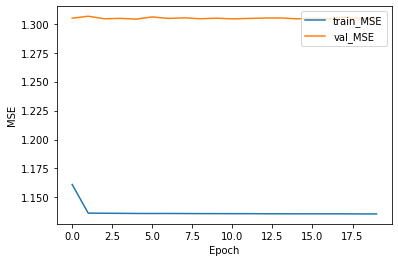

In [489]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un train MSE de 1.1361  y un val MSE de 1.3040   en 5 épocas. Peores resultados de los esperados ya que teniendo la producción en la hora anterior el error debería ser mínimo. No entrena

### Modelo 23. Tomamos datos cada 5 minutos de TRES horas antes y predecimos a 15 minutos, utilizando fórmula 2 de neuronas tomando el resto de datos atmosféricos. Introducimos estos datos en la capa que concatena. Introducimos datos de producción de 30 minutos antes en la entrada

In [497]:
X_train1=np.array(PVGISdf.iloc[1:len(PVGISdf)-38:3,1:4]) #Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=np.array(PVGISdf.iloc[2:len(PVGISdf)-37:3,1:4]) #Tengo datos de radiación de 13:20-16:15 e introduzco producción a las 15:30.
X_train3=np.array(PVGISdf.iloc[3:len(PVGISdf)-36:3,1:4]) #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=np.array(PVGISdf.iloc[4:len(PVGISdf)-35:3,1:4])
X_train5=np.array(PVGISdf.iloc[5:len(PVGISdf)-34:3,1:4])
X_train6=np.array(PVGISdf.iloc[6:len(PVGISdf)-33:3,1:4])
X_train7=np.array(PVGISdf.iloc[7:len(PVGISdf)-32:3,1:4]) 
X_train8=np.array(PVGISdf.iloc[8:len(PVGISdf)-31:3,1:4])
X_train9=np.array(PVGISdf.iloc[9:len(PVGISdf)-30:3,1:4]) 
X_train10=np.array(PVGISdf.iloc[10:len(PVGISdf)-29:3,1:4])
X_train11=np.array(PVGISdf.iloc[11:len(PVGISdf)-28:3,1:4])
X_train12=np.array(PVGISdf.iloc[12:len(PVGISdf)-27:3,1:4]) #Tomo datos hasta las 22:30 del 16/12/2018 para que mi última predicción sea la de las 22:45
X_train13=np.array(PVGISdf.iloc[13:len(PVGISdf)-26:3,1:4])  
X_train14=np.array(PVGISdf.iloc[14:len(PVGISdf)-25:3,1:4]) 
X_train15=np.array(PVGISdf.iloc[15:len(PVGISdf)-24:3,1:4]) 
X_train16=np.array(PVGISdf.iloc[16:len(PVGISdf)-23:3,1:4])
X_train17=np.array(PVGISdf.iloc[17:len(PVGISdf)-22:3,1:4])
X_train18=np.array(PVGISdf.iloc[18:len(PVGISdf)-21:3,1:4])
X_train19=np.array(PVGISdf.iloc[19:len(PVGISdf)-20:3,1:4])  
X_train20=np.array(PVGISdf.iloc[20:len(PVGISdf)-19:3,1:4]) 
X_train21=np.array(PVGISdf.iloc[21:len(PVGISdf)-18:3,1:4]) 
X_train22=np.array(PVGISdf.iloc[22:len(PVGISdf)-17:3,1:4])
X_train23=np.array(PVGISdf.iloc[23:len(PVGISdf)-16:3,1:4])
X_train24=np.array(PVGISdf.iloc[24:len(PVGISdf)-15:3,1:4])
X_train25=np.array(PVGISdf.iloc[25:len(PVGISdf)-14:3,1:4])  
X_train26=np.array(PVGISdf.iloc[26:len(PVGISdf)-13:3,1:4]) 
X_train27=np.array(PVGISdf.iloc[27:len(PVGISdf)-12:3,1:4]) 
X_train28=np.array(PVGISdf.iloc[28:len(PVGISdf)-11:3,1:4])
X_train29=np.array(PVGISdf.iloc[29:len(PVGISdf)-10:3,1:4])
X_train30=np.array(PVGISdf.iloc[30:len(PVGISdf)-9:3,1:4])
X_train31=np.array(PVGISdf.iloc[31:len(PVGISdf)-8:3,1:4])  
X_train32=np.array(PVGISdf.iloc[32:len(PVGISdf)-7:3,1:4]) 
X_train33=np.array(PVGISdf.iloc[33:len(PVGISdf)-6:3,1:4]) 
X_train34=np.array(PVGISdf.iloc[34:len(PVGISdf)-5:3,1:4])
X_train35=np.array(PVGISdf.iloc[35:len(PVGISdf)-4:3,1:4])
X_train36=np.array(PVGISdf.iloc[36:len(PVGISdf)-3:3,1:4])

X_trainatm1=np.array(PVGISdf.iloc[1:len(PVGISdf)-38:3,4:7])  
X_trainatm2=np.array(PVGISdf.iloc[2:len(PVGISdf)-37:3,4:7]) 
X_trainatm3=np.array(PVGISdf.iloc[3:len(PVGISdf)-36:3,4:7]) 
X_trainatm4=np.array(PVGISdf.iloc[4:len(PVGISdf)-35:3,4:7])
X_trainatm5=np.array(PVGISdf.iloc[5:len(PVGISdf)-34:3,4:7])
X_trainatm6=np.array(PVGISdf.iloc[6:len(PVGISdf)-33:3,4:7])
X_trainatm7=np.array(PVGISdf.iloc[7:len(PVGISdf)-32:3,4:7]) 
X_trainatm8=np.array(PVGISdf.iloc[8:len(PVGISdf)-31:3,4:7])
X_trainatm9=np.array(PVGISdf.iloc[9:len(PVGISdf)-30:3,4:7]) 
X_trainatm10=np.array(PVGISdf.iloc[10:len(PVGISdf)-29:3,4:7])
X_trainatm11=np.array(PVGISdf.iloc[11:len(PVGISdf)-28:3,4:7])
X_trainatm12=np.array(PVGISdf.iloc[12:len(PVGISdf)-27:3,4:7])
X_trainatm13=np.array(PVGISdf.iloc[13:len(PVGISdf)-26:3,4:7])  
X_trainatm14=np.array(PVGISdf.iloc[14:len(PVGISdf)-25:3,4:7]) 
X_trainatm15=np.array(PVGISdf.iloc[15:len(PVGISdf)-24:3,4:7]) 
X_trainatm16=np.array(PVGISdf.iloc[16:len(PVGISdf)-23:3,4:7])
X_trainatm17=np.array(PVGISdf.iloc[17:len(PVGISdf)-22:3,4:7])
X_trainatm18=np.array(PVGISdf.iloc[18:len(PVGISdf)-21:3,4:7])
X_trainatm19=np.array(PVGISdf.iloc[19:len(PVGISdf)-20:3,4:7])  
X_trainatm20=np.array(PVGISdf.iloc[20:len(PVGISdf)-19:3,4:7]) 
X_trainatm21=np.array(PVGISdf.iloc[21:len(PVGISdf)-18:3,4:7]) 
X_trainatm22=np.array(PVGISdf.iloc[22:len(PVGISdf)-17:3,4:7])
X_trainatm23=np.array(PVGISdf.iloc[23:len(PVGISdf)-16:3,4:7])
X_trainatm24=np.array(PVGISdf.iloc[24:len(PVGISdf)-15:3,4:7])
X_trainatm25=np.array(PVGISdf.iloc[25:len(PVGISdf)-14:3,4:7])  
X_trainatm26=np.array(PVGISdf.iloc[26:len(PVGISdf)-13:3,4:7]) 
X_trainatm27=np.array(PVGISdf.iloc[27:len(PVGISdf)-12:3,4:7]) 
X_trainatm28=np.array(PVGISdf.iloc[28:len(PVGISdf)-11:3,4:7])
X_trainatm29=np.array(PVGISdf.iloc[29:len(PVGISdf)-10:3,4:7])
X_trainatm30=np.array(PVGISdf.iloc[30:len(PVGISdf)-9:3,4:7])
X_trainatm31=np.array(PVGISdf.iloc[31:len(PVGISdf)-8:3,4:7])  
X_trainatm32=np.array(PVGISdf.iloc[32:len(PVGISdf)-7:3,4:7]) 
X_trainatm33=np.array(PVGISdf.iloc[33:len(PVGISdf)-6:3,4:7]) 
X_trainatm34=np.array(PVGISdf.iloc[34:len(PVGISdf)-5:3,4:7])
X_trainatm35=np.array(PVGISdf.iloc[35:len(PVGISdf)-4:3,4:7])
X_trainatm36=np.array(PVGISdf.iloc[36:len(PVGISdf)-3:3,4:7])

X_prod1=np.array(PVOutputdf.iloc[12:len(PVOutputdf)-1,1]).astype(float) #Producción 15 minutos antes
X_prod2=np.array(PVOutputdf.iloc[11:len(PVOutputdf)-2,1]).astype(float) #Producción 30 minutos antes

y_train=np.array(PVOutputdf.iloc[13:len(PVOutputdf),1]).astype(float) #No tomo los primeros 7 valores para cuadrarlo, que empiece a las 16:30

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 
X_train7std=np.std(X_train7) 
X_train8std=np.std(X_train8)
X_train9std=np.std(X_train9)
X_train10std=np.std(X_train10) 
X_train11std=np.std(X_train11) 
X_train12std=np.std(X_train12)
X_train13std=np.std(X_train13) 
X_train14std=np.std(X_train14) 
X_train15std=np.std(X_train15)
X_train16std=np.std(X_train16)
X_train17std=np.std(X_train17) 
X_train18std=np.std(X_train18)
X_train19std=np.std(X_train19) 
X_train20std=np.std(X_train20) 
X_train21std=np.std(X_train21)
X_train22std=np.std(X_train22)
X_train23std=np.std(X_train23) 
X_train24std=np.std(X_train24)
X_train25std=np.std(X_train25) 
X_train26std=np.std(X_train26) 
X_train27std=np.std(X_train27)
X_train28std=np.std(X_train28)
X_train29std=np.std(X_train29) 
X_train30std=np.std(X_train30)
X_train31std=np.std(X_train31) 
X_train32std=np.std(X_train32) 
X_train33std=np.std(X_train33)
X_train34std=np.std(X_train34)
X_train35std=np.std(X_train35) 
X_train36std=np.std(X_train36) 


X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 
X_train7est=X_train7/X_train7std 
X_train8est=X_train8/X_train8std
X_train9est=X_train9/X_train9std 
X_train10est=X_train10/X_train10std 
X_train11est=X_train11/X_train11std 
X_train12est=X_train12/X_train12std
X_train13est=X_train13/X_train13std 
X_train14est=X_train14/X_train14std
X_train15est=X_train15/X_train15std 
X_train16est=X_train16/X_train16std 
X_train17est=X_train17/X_train17std 
X_train18est=X_train18/X_train18std
X_train19est=X_train19/X_train19std 
X_train20est=X_train20/X_train20std
X_train21est=X_train21/X_train21std 
X_train22est=X_train22/X_train22std 
X_train23est=X_train23/X_train23std 
X_train24est=X_train24/X_train24std
X_train25est=X_train25/X_train25std 
X_train26est=X_train26/X_train26std
X_train27est=X_train27/X_train27std 
X_train28est=X_train28/X_train28std 
X_train29est=X_train29/X_train29std 
X_train30est=X_train30/X_train30std
X_train31est=X_train31/X_train31std 
X_train32est=X_train32/X_train32std
X_train33est=X_train33/X_train33std 
X_train34est=X_train34/X_train34std 
X_train35est=X_train35/X_train35std 
X_train36est=X_train36/X_train36std

X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est,X_train7est,X_train8est,X_train9est,X_train10est,X_train11est,X_train12est,X_train13est,X_train14est,X_train15est,X_train16est,X_train17est,X_train18est,X_train19est,X_train20est,X_train21est,X_train22est,X_train23est,X_train24est,X_train25est,X_train26est,X_train27est,X_train28est,X_train29est,X_train30est,X_train31est,X_train32est,X_train33est,X_train34est,X_train35est,X_train36est)

X_trainatm1std=np.std(X_trainatm1)  
X_trainatm2std=np.std(X_trainatm2) 
X_trainatm3std=np.std(X_trainatm3) 
X_trainatm4std=np.std(X_trainatm4)
X_trainatm5std=np.std(X_trainatm5)
X_trainatm6std=np.std(X_trainatm6)
X_trainatm7std=np.std(X_trainatm7)
X_trainatm8std=np.std(X_trainatm8)
X_trainatm9std=np.std(X_trainatm9) 
X_trainatm10std=np.std(X_trainatm10)
X_trainatm11std=np.std(X_trainatm11)
X_trainatm12std=np.std(X_trainatm12)
X_trainatm13std=np.std(X_trainatm13)
X_trainatm14std=np.std(X_trainatm14)
X_trainatm15std=np.std(X_trainatm15) 
X_trainatm16std=np.std(X_trainatm16)
X_trainatm17std=np.std(X_trainatm17)
X_trainatm18std=np.std(X_trainatm18)
X_trainatm19std=np.std(X_trainatm19)
X_trainatm20std=np.std(X_trainatm20)
X_trainatm21std=np.std(X_trainatm21) 
X_trainatm22std=np.std(X_trainatm22)
X_trainatm23std=np.std(X_trainatm23)
X_trainatm24std=np.std(X_trainatm24)
X_trainatm25std=np.std(X_trainatm25)
X_trainatm26std=np.std(X_trainatm26)
X_trainatm27std=np.std(X_trainatm27) 
X_trainatm28std=np.std(X_trainatm28)
X_trainatm29std=np.std(X_trainatm29)
X_trainatm30std=np.std(X_trainatm30)
X_trainatm31std=np.std(X_trainatm31)
X_trainatm32std=np.std(X_trainatm32)
X_trainatm33std=np.std(X_trainatm33) 
X_trainatm34std=np.std(X_trainatm34)
X_trainatm35std=np.std(X_trainatm35)
X_trainatm36std=np.std(X_trainatm36)

X_trainatm1est=X_trainatm1/X_trainatm1std 
X_trainatm2est=X_trainatm2/X_trainatm2std 
X_trainatm3est=X_trainatm3/X_trainatm3std 
X_trainatm4est=X_trainatm4/X_trainatm4std
X_trainatm5est=X_trainatm5/X_trainatm5std 
X_trainatm6est=X_trainatm6/X_trainatm6std 
X_trainatm7est=X_trainatm7/X_trainatm7std 
X_trainatm8est=X_trainatm8/X_trainatm8std
X_trainatm9est=X_trainatm9/X_trainatm9std 
X_trainatm10est=X_trainatm10/X_trainatm10std 
X_trainatm11est=X_trainatm11/X_trainatm11std 
X_trainatm12est=X_trainatm12/X_trainatm12std
X_trainatm13est=X_trainatm13/X_trainatm13std 
X_trainatm14est=X_trainatm14/X_trainatm14std 
X_trainatm15est=X_trainatm15/X_trainatm15std
X_trainatm16est=X_trainatm16/X_trainatm16std 
X_trainatm17est=X_trainatm17/X_trainatm17std 
X_trainatm18est=X_trainatm18/X_trainatm18std
X_trainatm19est=X_trainatm19/X_trainatm19std 
X_trainatm20est=X_trainatm20/X_trainatm20std 
X_trainatm21est=X_trainatm21/X_trainatm21std
X_trainatm22est=X_trainatm22/X_trainatm22std 
X_trainatm23est=X_trainatm23/X_trainatm23std 
X_trainatm24est=X_trainatm24/X_trainatm24std
X_trainatm25est=X_trainatm25/X_trainatm25std 
X_trainatm26est=X_trainatm26/X_trainatm26std 
X_trainatm27est=X_trainatm27/X_trainatm27std
X_trainatm28est=X_trainatm28/X_trainatm28std 
X_trainatm29est=X_trainatm29/X_trainatm29std 
X_trainatm30est=X_trainatm30/X_trainatm30std
X_trainatm31est=X_trainatm31/X_trainatm31std 
X_trainatm32est=X_trainatm32/X_trainatm32std 
X_trainatm33est=X_trainatm33/X_trainatm33std
X_trainatm34est=X_trainatm34/X_trainatm34std 
X_trainatm35est=X_trainatm35/X_trainatm35std 
X_trainatm36est=X_trainatm36/X_trainatm36std

X_trainatmest=(X_trainatm1est,X_trainatm2est,X_trainatm3est,X_trainatm4est,X_trainatm5est,X_trainatm6est,X_trainatm7est,X_trainatm8est,X_trainatm9est,X_trainatm10est,X_trainatm11est,X_trainatm12est,X_trainatm13est,X_trainatm14est,X_trainatm15est,X_trainatm16est,X_trainatm17est,X_trainatm18est,X_trainatm19est,X_trainatm20est,X_trainatm21est,X_trainatm22est,X_trainatm23est,X_trainatm24est,X_trainatm25est,X_trainatm26est,X_trainatm27est,X_trainatm28est,X_trainatm29est,X_trainatm30est,X_trainatm31est,X_trainatm32est,X_trainatm33est,X_trainatm34est,X_trainatm35est,X_trainatm36est)

X_prod1std=np.std(X_prod1)
X_prod1est=X_prod1/X_prod1std 

X_prod2std=np.std(X_prod2)
X_prod2est=X_prod2/X_prod2std 
X_prodest=(X_prod1est,X_prod2est)

Y_trainstd=np.std(y_train) 
Y_trainest=y_train/Y_trainstd 

In [492]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)
entrada13 = tf.keras.layers.Input(shape=3)
entrada14 = tf.keras.layers.Input(shape=3)
entrada15 = tf.keras.layers.Input(shape=3)
entrada16 = tf.keras.layers.Input(shape=3)
entrada17 = tf.keras.layers.Input(shape=3)
entrada18 = tf.keras.layers.Input(shape=3)
entrada19 = tf.keras.layers.Input(shape=3)
entrada20 = tf.keras.layers.Input(shape=3)
entrada21 = tf.keras.layers.Input(shape=3)
entrada22 = tf.keras.layers.Input(shape=3)
entrada23 = tf.keras.layers.Input(shape=3)
entrada24 = tf.keras.layers.Input(shape=3)
entrada25 = tf.keras.layers.Input(shape=3)
entrada26 = tf.keras.layers.Input(shape=3)
entrada27 = tf.keras.layers.Input(shape=3)
entrada28 = tf.keras.layers.Input(shape=3)
entrada29 = tf.keras.layers.Input(shape=3)
entrada30 = tf.keras.layers.Input(shape=3)
entrada31 = tf.keras.layers.Input(shape=3)
entrada32 = tf.keras.layers.Input(shape=3)
entrada33 = tf.keras.layers.Input(shape=3)
entrada34 = tf.keras.layers.Input(shape=3)
entrada35 = tf.keras.layers.Input(shape=3)
entrada36 = tf.keras.layers.Input(shape=3)

entradaatm1 = tf.keras.layers.Input(shape=3) 
entradaatm2 = tf.keras.layers.Input(shape=3)
entradaatm3 = tf.keras.layers.Input(shape=3)
entradaatm4 = tf.keras.layers.Input(shape=3)
entradaatm5 = tf.keras.layers.Input(shape=3)
entradaatm6 = tf.keras.layers.Input(shape=3)
entradaatm7 = tf.keras.layers.Input(shape=3)
entradaatm8 = tf.keras.layers.Input(shape=3)
entradaatm9 = tf.keras.layers.Input(shape=3)
entradaatm10 = tf.keras.layers.Input(shape=3)
entradaatm11 = tf.keras.layers.Input(shape=3)
entradaatm12 = tf.keras.layers.Input(shape=3)
entradaatm13 = tf.keras.layers.Input(shape=3)
entradaatm14 = tf.keras.layers.Input(shape=3)
entradaatm15 = tf.keras.layers.Input(shape=3) 
entradaatm16 = tf.keras.layers.Input(shape=3)
entradaatm17 = tf.keras.layers.Input(shape=3)
entradaatm18 = tf.keras.layers.Input(shape=3)
entradaatm19 = tf.keras.layers.Input(shape=3)
entradaatm20 = tf.keras.layers.Input(shape=3)
entradaatm21 = tf.keras.layers.Input(shape=3) 
entradaatm22 = tf.keras.layers.Input(shape=3)
entradaatm23 = tf.keras.layers.Input(shape=3)
entradaatm24 = tf.keras.layers.Input(shape=3)
entradaatm25 = tf.keras.layers.Input(shape=3)
entradaatm26 = tf.keras.layers.Input(shape=3)
entradaatm27 = tf.keras.layers.Input(shape=3) 
entradaatm28 = tf.keras.layers.Input(shape=3)
entradaatm29 = tf.keras.layers.Input(shape=3)
entradaatm30 = tf.keras.layers.Input(shape=3)
entradaatm31 = tf.keras.layers.Input(shape=3)
entradaatm32 = tf.keras.layers.Input(shape=3)
entradaatm33 = tf.keras.layers.Input(shape=3) 
entradaatm34 = tf.keras.layers.Input(shape=3)
entradaatm35 = tf.keras.layers.Input(shape=3)
entradaatm36 = tf.keras.layers.Input(shape=3)

entradaprod1=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat
entradaprod2=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat


#Capas ocultas formula 2: Hidden =3/2*(In + Out)=3/2*(3+1)=6
oculta1 = tf.keras.layers.Dense(6, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(6, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(6, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(6, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(6, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(6, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(6, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(6, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(6, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(6, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(6, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(6, activation="relu")(entrada12)
oculta13 = tf.keras.layers.Dense(6, activation="relu")(entrada13)
oculta14 = tf.keras.layers.Dense(6, activation="relu")(entrada14)
oculta15 = tf.keras.layers.Dense(6, activation="relu")(entrada15)
oculta16 = tf.keras.layers.Dense(6, activation="relu")(entrada16)
oculta17 = tf.keras.layers.Dense(6, activation="relu")(entrada17)
oculta18 = tf.keras.layers.Dense(6, activation="relu")(entrada18)
oculta19 = tf.keras.layers.Dense(6, activation="relu")(entrada19)
oculta20 = tf.keras.layers.Dense(6, activation="relu")(entrada20)
oculta21 = tf.keras.layers.Dense(6, activation="relu")(entrada21)
oculta22 = tf.keras.layers.Dense(6, activation="relu")(entrada22)
oculta23 = tf.keras.layers.Dense(6, activation="relu")(entrada23)
oculta24 = tf.keras.layers.Dense(6, activation="relu")(entrada24)
oculta25 = tf.keras.layers.Dense(6, activation="relu")(entrada25)
oculta26 = tf.keras.layers.Dense(6, activation="relu")(entrada26)
oculta27 = tf.keras.layers.Dense(6, activation="relu")(entrada27)
oculta28 = tf.keras.layers.Dense(6, activation="relu")(entrada28)
oculta29 = tf.keras.layers.Dense(6, activation="relu")(entrada29)
oculta30 = tf.keras.layers.Dense(6, activation="relu")(entrada30)
oculta31 = tf.keras.layers.Dense(6, activation="relu")(entrada31)
oculta32 = tf.keras.layers.Dense(6, activation="relu")(entrada32)
oculta33 = tf.keras.layers.Dense(6, activation="relu")(entrada33)
oculta34 = tf.keras.layers.Dense(6, activation="relu")(entrada34)
oculta35 = tf.keras.layers.Dense(6, activation="relu")(entrada35)
oculta36 = tf.keras.layers.Dense(6, activation="relu")(entrada36)


concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12, oculta13, oculta14, oculta15, oculta16, oculta17, oculta18, oculta19, oculta20, oculta21, oculta22, oculta23, oculta24, oculta25, oculta26, oculta27, oculta28, oculta29, oculta30, oculta31, oculta32, oculta33, oculta34, oculta35, oculta36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod1,entradaprod2]) #estratificada, concatena las 12
#2 layers intermedias, formula 2: Hidden =3/2*(In + Out)=3/2*(1+1)=3
adoculta1=tf.keras.layers.Dense(3, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(3, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(3, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo23 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12, entrada13, entrada14, entrada15, entrada16, entrada17, entrada18, entrada19, entrada20, entrada21, entrada22, entrada23, entrada24, entrada25, entrada26, entrada27, entrada28, entrada29, entrada30, entrada31, entrada32, entrada33, entrada34, entrada35, entrada36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod1,entradaprod2], outputs=[salida])

modelo23.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo23.fit([X_trainest,X_trainatmest,X_prodest], Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2)
#Mucho mejor resultado introduciendo entre corchetes que entre paréntesis (X_trainest,X_trainatmest)
#No estoy 100% seguro de que esté bien introducido así, cómo sabe que las entradai corresponden a X_train y que entradaatmi corresponden a X_trainatm?

Epoch 1/1000
3308/3308 [==============================] - 23s 5ms/step - loss: 0.6236 - mae: 0.3750 - val_loss: 0.6803 - val_mae: 0.3617
Epoch 2/1000
3308/3308 [==============================] - 15s 5ms/step - loss: 0.4706 - mae: 0.2810 - val_loss: 0.0541 - val_mae: 0.0763
Epoch 3/1000
3308/3308 [==============================] - 15s 5ms/step - loss: 0.0437 - mae: 0.0700 - val_loss: 0.0503 - val_mae: 0.0565
Epoch 4/1000
3308/3308 [==============================] - 16s 5ms/step - loss: 0.0430 - mae: 0.0675 - val_loss: 0.0490 - val_mae: 0.0627
Epoch 5/1000
3308/3308 [==============================] - 16s 5ms/step - loss: 0.0426 - mae: 0.0669 - val_loss: 0.0495 - val_mae: 0.0582
Epoch 6/1000
3308/3308 [==============================] - 16s 5ms/step - loss: 0.0425 - mae: 0.0656 - val_loss: 0.0498 - val_mae: 0.0817
Epoch 7/1000
3308/3308 [==============================] - 16s 5ms/step - loss: 0.0423 - mae: 0.0664 - val_loss: 0.0509 - val_mae: 0.0602
Epoch 8/1000
3308/3308 [=================

Text(0, 0.5, 'MSE')

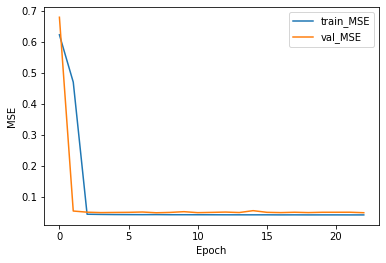

In [493]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un train MSE de 0.0425 y un val MSE de 0.0485  en 8 épocas. Mejores resultados hasta el momento. No entrena demasiado. Resultados más coherentes utilizando la producción, es probable que la utilicen en el artículo, ya que se parecen a estos

### Modelo 24. Tomamos datos cada 5 minutos de TRES horas antes y predecimos a 15 minutos, utilizando fórmula 3 de neuronas tomando el resto de datos atmosféricos. Introducimos estos datos en la capa que concatena. Introducimos datos de producción de 30 minutos antes en la entrada

In [498]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)
entrada13 = tf.keras.layers.Input(shape=3)
entrada14 = tf.keras.layers.Input(shape=3)
entrada15 = tf.keras.layers.Input(shape=3)
entrada16 = tf.keras.layers.Input(shape=3)
entrada17 = tf.keras.layers.Input(shape=3)
entrada18 = tf.keras.layers.Input(shape=3)
entrada19 = tf.keras.layers.Input(shape=3)
entrada20 = tf.keras.layers.Input(shape=3)
entrada21 = tf.keras.layers.Input(shape=3)
entrada22 = tf.keras.layers.Input(shape=3)
entrada23 = tf.keras.layers.Input(shape=3)
entrada24 = tf.keras.layers.Input(shape=3)
entrada25 = tf.keras.layers.Input(shape=3)
entrada26 = tf.keras.layers.Input(shape=3)
entrada27 = tf.keras.layers.Input(shape=3)
entrada28 = tf.keras.layers.Input(shape=3)
entrada29 = tf.keras.layers.Input(shape=3)
entrada30 = tf.keras.layers.Input(shape=3)
entrada31 = tf.keras.layers.Input(shape=3)
entrada32 = tf.keras.layers.Input(shape=3)
entrada33 = tf.keras.layers.Input(shape=3)
entrada34 = tf.keras.layers.Input(shape=3)
entrada35 = tf.keras.layers.Input(shape=3)
entrada36 = tf.keras.layers.Input(shape=3)

entradaatm1 = tf.keras.layers.Input(shape=3) 
entradaatm2 = tf.keras.layers.Input(shape=3)
entradaatm3 = tf.keras.layers.Input(shape=3)
entradaatm4 = tf.keras.layers.Input(shape=3)
entradaatm5 = tf.keras.layers.Input(shape=3)
entradaatm6 = tf.keras.layers.Input(shape=3)
entradaatm7 = tf.keras.layers.Input(shape=3)
entradaatm8 = tf.keras.layers.Input(shape=3)
entradaatm9 = tf.keras.layers.Input(shape=3)
entradaatm10 = tf.keras.layers.Input(shape=3)
entradaatm11 = tf.keras.layers.Input(shape=3)
entradaatm12 = tf.keras.layers.Input(shape=3)
entradaatm13 = tf.keras.layers.Input(shape=3)
entradaatm14 = tf.keras.layers.Input(shape=3)
entradaatm15 = tf.keras.layers.Input(shape=3) 
entradaatm16 = tf.keras.layers.Input(shape=3)
entradaatm17 = tf.keras.layers.Input(shape=3)
entradaatm18 = tf.keras.layers.Input(shape=3)
entradaatm19 = tf.keras.layers.Input(shape=3)
entradaatm20 = tf.keras.layers.Input(shape=3)
entradaatm21 = tf.keras.layers.Input(shape=3) 
entradaatm22 = tf.keras.layers.Input(shape=3)
entradaatm23 = tf.keras.layers.Input(shape=3)
entradaatm24 = tf.keras.layers.Input(shape=3)
entradaatm25 = tf.keras.layers.Input(shape=3)
entradaatm26 = tf.keras.layers.Input(shape=3)
entradaatm27 = tf.keras.layers.Input(shape=3) 
entradaatm28 = tf.keras.layers.Input(shape=3)
entradaatm29 = tf.keras.layers.Input(shape=3)
entradaatm30 = tf.keras.layers.Input(shape=3)
entradaatm31 = tf.keras.layers.Input(shape=3)
entradaatm32 = tf.keras.layers.Input(shape=3)
entradaatm33 = tf.keras.layers.Input(shape=3) 
entradaatm34 = tf.keras.layers.Input(shape=3)
entradaatm35 = tf.keras.layers.Input(shape=3)
entradaatm36 = tf.keras.layers.Input(shape=3)

entradaprod1=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat
entradaprod2=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat


#Capas ocultas formula 3: Hidden=1/2*(In + Out)+ SQRT(Training)=1/2*(3 + 1)+ np.sqrt(132314)=365.7499140893369
oculta1 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada12)
oculta13 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada13)
oculta14 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada14)
oculta15 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada15)
oculta16 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada16)
oculta17 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada17)
oculta18 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada18)
oculta19 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada19)
oculta20 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada20)
oculta21 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada21)
oculta22 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada22)
oculta23 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada23)
oculta24 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada24)
oculta25 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada25)
oculta26 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada26)
oculta27 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada27)
oculta28 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada28)
oculta29 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada29)
oculta30 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada30)
oculta31 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada31)
oculta32 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada32)
oculta33 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada33)
oculta34 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada34)
oculta35 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada35)
oculta36 = tf.keras.layers.Dense(365.7499140893369, activation="relu")(entrada36)


concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12, oculta13, oculta14, oculta15, oculta16, oculta17, oculta18, oculta19, oculta20, oculta21, oculta22, oculta23, oculta24, oculta25, oculta26, oculta27, oculta28, oculta29, oculta30, oculta31, oculta32, oculta33, oculta34, oculta35, oculta36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod1,entradaprod2]) #estratificada, concatena las 12
#2 layers intermedias, Hidden=1/2*(In + Out)+ SQRT(Training)=1/2*(1 + 1)+ np.sqrt(132323)=364.7499140893369
adoculta1=tf.keras.layers.Dense(364.7499140893369, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(364.7499140893369, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(364.2499140893369, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo24 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12, entrada13, entrada14, entrada15, entrada16, entrada17, entrada18, entrada19, entrada20, entrada21, entrada22, entrada23, entrada24, entrada25, entrada26, entrada27, entrada28, entrada29, entrada30, entrada31, entrada32, entrada33, entrada34, entrada35, entrada36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod1,entradaprod2], outputs=[salida])

modelo24.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo24.fit([X_trainest,X_trainatmest,X_prodest], Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2)
#Mucho mejor resultado introduciendo entre corchetes que entre paréntesis (X_trainest,X_trainatmest)
#No estoy 100% seguro de que esté bien introducido así, cómo sabe que las entradai corresponden a X_train y que entradaatmi corresponden a X_trainatm?

Epoch 1/1000
3308/3308 [==============================] - 184s 54ms/step - loss: 0.0787 - mae: 0.1089 - val_loss: 0.0618 - val_mae: 0.0612
Epoch 2/1000
3308/3308 [==============================] - 179s 54ms/step - loss: 0.0458 - mae: 0.0659 - val_loss: 0.0636 - val_mae: 0.0600
Epoch 4/1000
3308/3308 [==============================] - 178s 54ms/step - loss: 0.0454 - mae: 0.0647 - val_loss: 0.0615 - val_mae: 0.0783
Epoch 5/1000
3308/3308 [==============================] - 179s 54ms/step - loss: 0.0436 - mae: 0.0608 - val_loss: 0.0577 - val_mae: 0.0614
Epoch 6/1000
3308/3308 [==============================] - 183s 55ms/step - loss: 0.0430 - mae: 0.0591 - val_loss: 0.0644 - val_mae: 0.0601
Epoch 7/1000
3308/3308 [==============================] - 182s 55ms/step - loss: 0.0426 - mae: 0.0585 - val_loss: 0.0604 - val_mae: 0.0548
Epoch 8/1000
3308/3308 [==============================] - 187s 56ms/step - loss: 0.0424 - mae: 0.0570 - val_loss: 0.0605 - val_mae: 0.0763
Epoch 9/1000
3308/3308 [===

Text(0, 0.5, 'MSE')

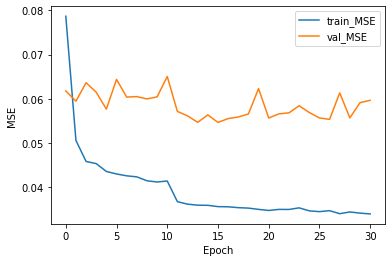

In [499]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un train MSE de 0.0356 y un val MSE de 0.0547  en 16 épocas. 3 minutos por época. Observamos que el modelo sobreajusta a los datos de entrenamiento, ya que estos mejoran pero los de validación no.

### Modelo 25. Tomamos datos cada 5 minutos de TRES horas antes y predecimos a 15 minutos, utilizando un número intermedio de neuronas entre fórmula 2 (6) y formula 3 (350), tomaremos 50. Tomando el resto de datos atmosféricos. Introducimos estos datos en la capa que concatena. Introducimos datos de producción de 30 minutos antes en la entrada

In [500]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)
entrada13 = tf.keras.layers.Input(shape=3)
entrada14 = tf.keras.layers.Input(shape=3)
entrada15 = tf.keras.layers.Input(shape=3)
entrada16 = tf.keras.layers.Input(shape=3)
entrada17 = tf.keras.layers.Input(shape=3)
entrada18 = tf.keras.layers.Input(shape=3)
entrada19 = tf.keras.layers.Input(shape=3)
entrada20 = tf.keras.layers.Input(shape=3)
entrada21 = tf.keras.layers.Input(shape=3)
entrada22 = tf.keras.layers.Input(shape=3)
entrada23 = tf.keras.layers.Input(shape=3)
entrada24 = tf.keras.layers.Input(shape=3)
entrada25 = tf.keras.layers.Input(shape=3)
entrada26 = tf.keras.layers.Input(shape=3)
entrada27 = tf.keras.layers.Input(shape=3)
entrada28 = tf.keras.layers.Input(shape=3)
entrada29 = tf.keras.layers.Input(shape=3)
entrada30 = tf.keras.layers.Input(shape=3)
entrada31 = tf.keras.layers.Input(shape=3)
entrada32 = tf.keras.layers.Input(shape=3)
entrada33 = tf.keras.layers.Input(shape=3)
entrada34 = tf.keras.layers.Input(shape=3)
entrada35 = tf.keras.layers.Input(shape=3)
entrada36 = tf.keras.layers.Input(shape=3)

entradaatm1 = tf.keras.layers.Input(shape=3) 
entradaatm2 = tf.keras.layers.Input(shape=3)
entradaatm3 = tf.keras.layers.Input(shape=3)
entradaatm4 = tf.keras.layers.Input(shape=3)
entradaatm5 = tf.keras.layers.Input(shape=3)
entradaatm6 = tf.keras.layers.Input(shape=3)
entradaatm7 = tf.keras.layers.Input(shape=3)
entradaatm8 = tf.keras.layers.Input(shape=3)
entradaatm9 = tf.keras.layers.Input(shape=3)
entradaatm10 = tf.keras.layers.Input(shape=3)
entradaatm11 = tf.keras.layers.Input(shape=3)
entradaatm12 = tf.keras.layers.Input(shape=3)
entradaatm13 = tf.keras.layers.Input(shape=3)
entradaatm14 = tf.keras.layers.Input(shape=3)
entradaatm15 = tf.keras.layers.Input(shape=3) 
entradaatm16 = tf.keras.layers.Input(shape=3)
entradaatm17 = tf.keras.layers.Input(shape=3)
entradaatm18 = tf.keras.layers.Input(shape=3)
entradaatm19 = tf.keras.layers.Input(shape=3)
entradaatm20 = tf.keras.layers.Input(shape=3)
entradaatm21 = tf.keras.layers.Input(shape=3) 
entradaatm22 = tf.keras.layers.Input(shape=3)
entradaatm23 = tf.keras.layers.Input(shape=3)
entradaatm24 = tf.keras.layers.Input(shape=3)
entradaatm25 = tf.keras.layers.Input(shape=3)
entradaatm26 = tf.keras.layers.Input(shape=3)
entradaatm27 = tf.keras.layers.Input(shape=3) 
entradaatm28 = tf.keras.layers.Input(shape=3)
entradaatm29 = tf.keras.layers.Input(shape=3)
entradaatm30 = tf.keras.layers.Input(shape=3)
entradaatm31 = tf.keras.layers.Input(shape=3)
entradaatm32 = tf.keras.layers.Input(shape=3)
entradaatm33 = tf.keras.layers.Input(shape=3) 
entradaatm34 = tf.keras.layers.Input(shape=3)
entradaatm35 = tf.keras.layers.Input(shape=3)
entradaatm36 = tf.keras.layers.Input(shape=3)

entradaprod1=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat
entradaprod2=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat


#Capas ocultas 50 neuronas
oculta1 = tf.keras.layers.Dense(50, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(50, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(50, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(50, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(50, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(50, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(50, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(50, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(50, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(50, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(50, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(50, activation="relu")(entrada12)
oculta13 = tf.keras.layers.Dense(50, activation="relu")(entrada13)
oculta14 = tf.keras.layers.Dense(50, activation="relu")(entrada14)
oculta15 = tf.keras.layers.Dense(50, activation="relu")(entrada15)
oculta16 = tf.keras.layers.Dense(50, activation="relu")(entrada16)
oculta17 = tf.keras.layers.Dense(50, activation="relu")(entrada17)
oculta18 = tf.keras.layers.Dense(50, activation="relu")(entrada18)
oculta19 = tf.keras.layers.Dense(50, activation="relu")(entrada19)
oculta20 = tf.keras.layers.Dense(50, activation="relu")(entrada20)
oculta21 = tf.keras.layers.Dense(50, activation="relu")(entrada21)
oculta22 = tf.keras.layers.Dense(50, activation="relu")(entrada22)
oculta23 = tf.keras.layers.Dense(50, activation="relu")(entrada23)
oculta24 = tf.keras.layers.Dense(50, activation="relu")(entrada24)
oculta25 = tf.keras.layers.Dense(50, activation="relu")(entrada25)
oculta26 = tf.keras.layers.Dense(50, activation="relu")(entrada26)
oculta27 = tf.keras.layers.Dense(50, activation="relu")(entrada27)
oculta28 = tf.keras.layers.Dense(50, activation="relu")(entrada28)
oculta29 = tf.keras.layers.Dense(50, activation="relu")(entrada29)
oculta30 = tf.keras.layers.Dense(50, activation="relu")(entrada30)
oculta31 = tf.keras.layers.Dense(50, activation="relu")(entrada31)
oculta32 = tf.keras.layers.Dense(50, activation="relu")(entrada32)
oculta33 = tf.keras.layers.Dense(50, activation="relu")(entrada33)
oculta34 = tf.keras.layers.Dense(50, activation="relu")(entrada34)
oculta35 = tf.keras.layers.Dense(50, activation="relu")(entrada35)
oculta36 = tf.keras.layers.Dense(50, activation="relu")(entrada36)


concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12, oculta13, oculta14, oculta15, oculta16, oculta17, oculta18, oculta19, oculta20, oculta21, oculta22, oculta23, oculta24, oculta25, oculta26, oculta27, oculta28, oculta29, oculta30, oculta31, oculta32, oculta33, oculta34, oculta35, oculta36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod1,entradaprod2]) #estratificada, concatena las 12
#2 layers intermedias, Hidden=1/2*(In + Out)+ SQRT(Training)=1/2*(1 + 1)+ np.sqrt(132323)=364.7499140893369
adoculta1=tf.keras.layers.Dense(20, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(20, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(10, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo25 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12, entrada13, entrada14, entrada15, entrada16, entrada17, entrada18, entrada19, entrada20, entrada21, entrada22, entrada23, entrada24, entrada25, entrada26, entrada27, entrada28, entrada29, entrada30, entrada31, entrada32, entrada33, entrada34, entrada35, entrada36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod1,entradaprod2], outputs=[salida])

modelo25.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo25.fit([X_trainest,X_trainatmest,X_prodest], Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2)
#Mucho mejor resultado introduciendo entre corchetes que entre paréntesis (X_trainest,X_trainatmest)
#No estoy 100% seguro de que esté bien introducido así, cómo sabe que las entradai corresponden a X_train y que entradaatmi corresponden a X_trainatm?

Epoch 1/1000
3308/3308 [==============================] - 26s 7ms/step - loss: 0.7136 - mae: 0.4023 - val_loss: 0.8026 - val_mae: 0.3922
Epoch 2/1000
3308/3308 [==============================] - 22s 7ms/step - loss: 0.6965 - mae: 0.3748 - val_loss: 0.7988 - val_mae: 0.3990
Epoch 3/1000
3308/3308 [==============================] - 23s 7ms/step - loss: 0.6948 - mae: 0.3712 - val_loss: 0.7998 - val_mae: 0.3967
Epoch 4/1000
3308/3308 [==============================] - 22s 7ms/step - loss: 0.6942 - mae: 0.3694 - val_loss: 0.8002 - val_mae: 0.3991
Epoch 5/1000
3308/3308 [==============================] - 22s 7ms/step - loss: 0.6938 - mae: 0.3689 - val_loss: 0.8034 - val_mae: 0.3882
Epoch 6/1000
3308/3308 [==============================] - 22s 7ms/step - loss: 0.6933 - mae: 0.3676 - val_loss: 0.8018 - val_mae: 0.3944
Epoch 7/1000
3308/3308 [==============================] - 21s 6ms/step - loss: 0.6930 - mae: 0.3669 - val_loss: 0.8021 - val_mae: 0.3927
Epoch 8/1000
3308/3308 [=================

Text(0, 0.5, 'MSE')

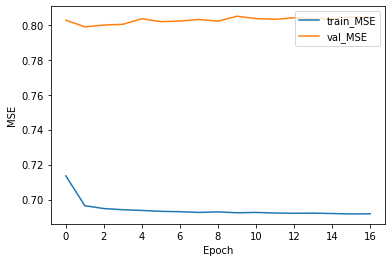

In [501]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un train MSE de 0.6965 y un val MSE de 0. 0.7988  en 2 épocas. No entrena ni se obtienen buenos resultados. 25 segundos por época

### Modelo 26. Tomamos datos cada 5 minutos de TRES horas antes y predecimos a 15 minutos, utilizando fórmula 2 de neuronas tomando el resto de datos atmosféricos MENOS la velocidad del viento para ver cómo afecta al modelo. Introducimos estos datos en la capa que concatena. Introducimos datos de producción de 30 minutos antes en la entrada

In [519]:
X_train1=np.array(PVGISdf.iloc[1:len(PVGISdf)-38:3,1:4]) #Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=np.array(PVGISdf.iloc[2:len(PVGISdf)-37:3,1:4]) #Tengo datos de radiación de 13:20-16:15 e introduzco producción a las 16:30.
X_train3=np.array(PVGISdf.iloc[3:len(PVGISdf)-36:3,1:4]) #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=np.array(PVGISdf.iloc[4:len(PVGISdf)-35:3,1:4])
X_train5=np.array(PVGISdf.iloc[5:len(PVGISdf)-34:3,1:4])
X_train6=np.array(PVGISdf.iloc[6:len(PVGISdf)-33:3,1:4])
X_train7=np.array(PVGISdf.iloc[7:len(PVGISdf)-32:3,1:4]) 
X_train8=np.array(PVGISdf.iloc[8:len(PVGISdf)-31:3,1:4])
X_train9=np.array(PVGISdf.iloc[9:len(PVGISdf)-30:3,1:4]) 
X_train10=np.array(PVGISdf.iloc[10:len(PVGISdf)-29:3,1:4])
X_train11=np.array(PVGISdf.iloc[11:len(PVGISdf)-28:3,1:4])
X_train12=np.array(PVGISdf.iloc[12:len(PVGISdf)-27:3,1:4]) #Tomo datos hasta las 22:30 del 16/12/2018 para que mi última predicción sea la de las 22:45
X_train13=np.array(PVGISdf.iloc[13:len(PVGISdf)-26:3,1:4])  
X_train14=np.array(PVGISdf.iloc[14:len(PVGISdf)-25:3,1:4]) 
X_train15=np.array(PVGISdf.iloc[15:len(PVGISdf)-24:3,1:4]) 
X_train16=np.array(PVGISdf.iloc[16:len(PVGISdf)-23:3,1:4])
X_train17=np.array(PVGISdf.iloc[17:len(PVGISdf)-22:3,1:4])
X_train18=np.array(PVGISdf.iloc[18:len(PVGISdf)-21:3,1:4])
X_train19=np.array(PVGISdf.iloc[19:len(PVGISdf)-20:3,1:4])  
X_train20=np.array(PVGISdf.iloc[20:len(PVGISdf)-19:3,1:4]) 
X_train21=np.array(PVGISdf.iloc[21:len(PVGISdf)-18:3,1:4]) 
X_train22=np.array(PVGISdf.iloc[22:len(PVGISdf)-17:3,1:4])
X_train23=np.array(PVGISdf.iloc[23:len(PVGISdf)-16:3,1:4])
X_train24=np.array(PVGISdf.iloc[24:len(PVGISdf)-15:3,1:4])
X_train25=np.array(PVGISdf.iloc[25:len(PVGISdf)-14:3,1:4])  
X_train26=np.array(PVGISdf.iloc[26:len(PVGISdf)-13:3,1:4]) 
X_train27=np.array(PVGISdf.iloc[27:len(PVGISdf)-12:3,1:4]) 
X_train28=np.array(PVGISdf.iloc[28:len(PVGISdf)-11:3,1:4])
X_train29=np.array(PVGISdf.iloc[29:len(PVGISdf)-10:3,1:4])
X_train30=np.array(PVGISdf.iloc[30:len(PVGISdf)-9:3,1:4])
X_train31=np.array(PVGISdf.iloc[31:len(PVGISdf)-8:3,1:4])  
X_train32=np.array(PVGISdf.iloc[32:len(PVGISdf)-7:3,1:4]) 
X_train33=np.array(PVGISdf.iloc[33:len(PVGISdf)-6:3,1:4]) 
X_train34=np.array(PVGISdf.iloc[34:len(PVGISdf)-5:3,1:4])
X_train35=np.array(PVGISdf.iloc[35:len(PVGISdf)-4:3,1:4])
X_train36=np.array(PVGISdf.iloc[36:len(PVGISdf)-3:3,1:4])

X_trainatm1=np.array(PVGISdf.iloc[1:len(PVGISdf)-38:3,4:6])  
X_trainatm2=np.array(PVGISdf.iloc[2:len(PVGISdf)-37:3,4:6]) 
X_trainatm3=np.array(PVGISdf.iloc[3:len(PVGISdf)-36:3,4:6]) 
X_trainatm4=np.array(PVGISdf.iloc[4:len(PVGISdf)-35:3,4:6])
X_trainatm5=np.array(PVGISdf.iloc[5:len(PVGISdf)-34:3,4:6])
X_trainatm6=np.array(PVGISdf.iloc[6:len(PVGISdf)-33:3,4:6])
X_trainatm7=np.array(PVGISdf.iloc[7:len(PVGISdf)-32:3,4:6]) 
X_trainatm8=np.array(PVGISdf.iloc[8:len(PVGISdf)-31:3,4:6])
X_trainatm9=np.array(PVGISdf.iloc[9:len(PVGISdf)-30:3,4:6]) 
X_trainatm10=np.array(PVGISdf.iloc[10:len(PVGISdf)-29:3,4:6])
X_trainatm11=np.array(PVGISdf.iloc[11:len(PVGISdf)-28:3,4:6])
X_trainatm12=np.array(PVGISdf.iloc[12:len(PVGISdf)-27:3,4:6])
X_trainatm13=np.array(PVGISdf.iloc[13:len(PVGISdf)-26:3,4:6])  
X_trainatm14=np.array(PVGISdf.iloc[14:len(PVGISdf)-25:3,4:6]) 
X_trainatm15=np.array(PVGISdf.iloc[15:len(PVGISdf)-24:3,4:6]) 
X_trainatm16=np.array(PVGISdf.iloc[16:len(PVGISdf)-23:3,4:6])
X_trainatm17=np.array(PVGISdf.iloc[17:len(PVGISdf)-22:3,4:6])
X_trainatm18=np.array(PVGISdf.iloc[18:len(PVGISdf)-21:3,4:6])
X_trainatm19=np.array(PVGISdf.iloc[19:len(PVGISdf)-20:3,4:6])  
X_trainatm20=np.array(PVGISdf.iloc[20:len(PVGISdf)-19:3,4:6]) 
X_trainatm21=np.array(PVGISdf.iloc[21:len(PVGISdf)-18:3,4:6]) 
X_trainatm22=np.array(PVGISdf.iloc[22:len(PVGISdf)-17:3,4:6])
X_trainatm23=np.array(PVGISdf.iloc[23:len(PVGISdf)-16:3,4:6])
X_trainatm24=np.array(PVGISdf.iloc[24:len(PVGISdf)-15:3,4:6])
X_trainatm25=np.array(PVGISdf.iloc[25:len(PVGISdf)-14:3,4:6])  
X_trainatm26=np.array(PVGISdf.iloc[26:len(PVGISdf)-13:3,4:6]) 
X_trainatm27=np.array(PVGISdf.iloc[27:len(PVGISdf)-12:3,4:6]) 
X_trainatm28=np.array(PVGISdf.iloc[28:len(PVGISdf)-11:3,4:6])
X_trainatm29=np.array(PVGISdf.iloc[29:len(PVGISdf)-10:3,4:6])
X_trainatm30=np.array(PVGISdf.iloc[30:len(PVGISdf)-9:3,4:6])
X_trainatm31=np.array(PVGISdf.iloc[31:len(PVGISdf)-8:3,4:6])  
X_trainatm32=np.array(PVGISdf.iloc[32:len(PVGISdf)-7:3,4:6]) 
X_trainatm33=np.array(PVGISdf.iloc[33:len(PVGISdf)-6:3,4:6]) 
X_trainatm34=np.array(PVGISdf.iloc[34:len(PVGISdf)-5:3,4:6])
X_trainatm35=np.array(PVGISdf.iloc[35:len(PVGISdf)-4:3,4:6])
X_trainatm36=np.array(PVGISdf.iloc[36:len(PVGISdf)-3:3,4:6])

X_prod1=np.array(PVOutputdf.iloc[12:len(PVOutputdf)-1,1]).astype(float) #Producción 15 minutos antes
X_prod2=np.array(PVOutputdf.iloc[11:len(PVOutputdf)-2,1]).astype(float) #Producción 30 minutos antes

y_train=np.array(PVOutputdf.iloc[13:len(PVOutputdf),1]).astype(float) #No tomo los primeros 7 valores para cuadrarlo, que empiece a las 16:30

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 
X_train7std=np.std(X_train7) 
X_train8std=np.std(X_train8)
X_train9std=np.std(X_train9)
X_train10std=np.std(X_train10) 
X_train11std=np.std(X_train11) 
X_train12std=np.std(X_train12)
X_train13std=np.std(X_train13) 
X_train14std=np.std(X_train14) 
X_train15std=np.std(X_train15)
X_train16std=np.std(X_train16)
X_train17std=np.std(X_train17) 
X_train18std=np.std(X_train18)
X_train19std=np.std(X_train19) 
X_train20std=np.std(X_train20) 
X_train21std=np.std(X_train21)
X_train22std=np.std(X_train22)
X_train23std=np.std(X_train23) 
X_train24std=np.std(X_train24)
X_train25std=np.std(X_train25) 
X_train26std=np.std(X_train26) 
X_train27std=np.std(X_train27)
X_train28std=np.std(X_train28)
X_train29std=np.std(X_train29) 
X_train30std=np.std(X_train30)
X_train31std=np.std(X_train31) 
X_train32std=np.std(X_train32) 
X_train33std=np.std(X_train33)
X_train34std=np.std(X_train34)
X_train35std=np.std(X_train35) 
X_train36std=np.std(X_train36) 


X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 
X_train7est=X_train7/X_train7std 
X_train8est=X_train8/X_train8std
X_train9est=X_train9/X_train9std 
X_train10est=X_train10/X_train10std 
X_train11est=X_train11/X_train11std 
X_train12est=X_train12/X_train12std
X_train13est=X_train13/X_train13std 
X_train14est=X_train14/X_train14std
X_train15est=X_train15/X_train15std 
X_train16est=X_train16/X_train16std 
X_train17est=X_train17/X_train17std 
X_train18est=X_train18/X_train18std
X_train19est=X_train19/X_train19std 
X_train20est=X_train20/X_train20std
X_train21est=X_train21/X_train21std 
X_train22est=X_train22/X_train22std 
X_train23est=X_train23/X_train23std 
X_train24est=X_train24/X_train24std
X_train25est=X_train25/X_train25std 
X_train26est=X_train26/X_train26std
X_train27est=X_train27/X_train27std 
X_train28est=X_train28/X_train28std 
X_train29est=X_train29/X_train29std 
X_train30est=X_train30/X_train30std
X_train31est=X_train31/X_train31std 
X_train32est=X_train32/X_train32std
X_train33est=X_train33/X_train33std 
X_train34est=X_train34/X_train34std 
X_train35est=X_train35/X_train35std 
X_train36est=X_train36/X_train36std

X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est,X_train7est,X_train8est,X_train9est,X_train10est,X_train11est,X_train12est,X_train13est,X_train14est,X_train15est,X_train16est,X_train17est,X_train18est,X_train19est,X_train20est,X_train21est,X_train22est,X_train23est,X_train24est,X_train25est,X_train26est,X_train27est,X_train28est,X_train29est,X_train30est,X_train31est,X_train32est,X_train33est,X_train34est,X_train35est,X_train36est)

X_trainatm1std=np.std(X_trainatm1)  
X_trainatm2std=np.std(X_trainatm2) 
X_trainatm3std=np.std(X_trainatm3) 
X_trainatm4std=np.std(X_trainatm4)
X_trainatm5std=np.std(X_trainatm5)
X_trainatm6std=np.std(X_trainatm6)
X_trainatm7std=np.std(X_trainatm7)
X_trainatm8std=np.std(X_trainatm8)
X_trainatm9std=np.std(X_trainatm9) 
X_trainatm10std=np.std(X_trainatm10)
X_trainatm11std=np.std(X_trainatm11)
X_trainatm12std=np.std(X_trainatm12)
X_trainatm13std=np.std(X_trainatm13)
X_trainatm14std=np.std(X_trainatm14)
X_trainatm15std=np.std(X_trainatm15) 
X_trainatm16std=np.std(X_trainatm16)
X_trainatm17std=np.std(X_trainatm17)
X_trainatm18std=np.std(X_trainatm18)
X_trainatm19std=np.std(X_trainatm19)
X_trainatm20std=np.std(X_trainatm20)
X_trainatm21std=np.std(X_trainatm21) 
X_trainatm22std=np.std(X_trainatm22)
X_trainatm23std=np.std(X_trainatm23)
X_trainatm24std=np.std(X_trainatm24)
X_trainatm25std=np.std(X_trainatm25)
X_trainatm26std=np.std(X_trainatm26)
X_trainatm27std=np.std(X_trainatm27) 
X_trainatm28std=np.std(X_trainatm28)
X_trainatm29std=np.std(X_trainatm29)
X_trainatm30std=np.std(X_trainatm30)
X_trainatm31std=np.std(X_trainatm31)
X_trainatm32std=np.std(X_trainatm32)
X_trainatm33std=np.std(X_trainatm33) 
X_trainatm34std=np.std(X_trainatm34)
X_trainatm35std=np.std(X_trainatm35)
X_trainatm36std=np.std(X_trainatm36)

X_trainatm1est=X_trainatm1/X_trainatm1std 
X_trainatm2est=X_trainatm2/X_trainatm2std 
X_trainatm3est=X_trainatm3/X_trainatm3std 
X_trainatm4est=X_trainatm4/X_trainatm4std
X_trainatm5est=X_trainatm5/X_trainatm5std 
X_trainatm6est=X_trainatm6/X_trainatm6std 
X_trainatm7est=X_trainatm7/X_trainatm7std 
X_trainatm8est=X_trainatm8/X_trainatm8std
X_trainatm9est=X_trainatm9/X_trainatm9std 
X_trainatm10est=X_trainatm10/X_trainatm10std 
X_trainatm11est=X_trainatm11/X_trainatm11std 
X_trainatm12est=X_trainatm12/X_trainatm12std
X_trainatm13est=X_trainatm13/X_trainatm13std 
X_trainatm14est=X_trainatm14/X_trainatm14std 
X_trainatm15est=X_trainatm15/X_trainatm15std
X_trainatm16est=X_trainatm16/X_trainatm16std 
X_trainatm17est=X_trainatm17/X_trainatm17std 
X_trainatm18est=X_trainatm18/X_trainatm18std
X_trainatm19est=X_trainatm19/X_trainatm19std 
X_trainatm20est=X_trainatm20/X_trainatm20std 
X_trainatm21est=X_trainatm21/X_trainatm21std
X_trainatm22est=X_trainatm22/X_trainatm22std 
X_trainatm23est=X_trainatm23/X_trainatm23std 
X_trainatm24est=X_trainatm24/X_trainatm24std
X_trainatm25est=X_trainatm25/X_trainatm25std 
X_trainatm26est=X_trainatm26/X_trainatm26std 
X_trainatm27est=X_trainatm27/X_trainatm27std
X_trainatm28est=X_trainatm28/X_trainatm28std 
X_trainatm29est=X_trainatm29/X_trainatm29std 
X_trainatm30est=X_trainatm30/X_trainatm30std
X_trainatm31est=X_trainatm31/X_trainatm31std 
X_trainatm32est=X_trainatm32/X_trainatm32std 
X_trainatm33est=X_trainatm33/X_trainatm33std
X_trainatm34est=X_trainatm34/X_trainatm34std 
X_trainatm35est=X_trainatm35/X_trainatm35std 
X_trainatm36est=X_trainatm36/X_trainatm36std

X_trainatmest=(X_trainatm1est,X_trainatm2est,X_trainatm3est,X_trainatm4est,X_trainatm5est,X_trainatm6est,X_trainatm7est,X_trainatm8est,X_trainatm9est,X_trainatm10est,X_trainatm11est,X_trainatm12est,X_trainatm13est,X_trainatm14est,X_trainatm15est,X_trainatm16est,X_trainatm17est,X_trainatm18est,X_trainatm19est,X_trainatm20est,X_trainatm21est,X_trainatm22est,X_trainatm23est,X_trainatm24est,X_trainatm25est,X_trainatm26est,X_trainatm27est,X_trainatm28est,X_trainatm29est,X_trainatm30est,X_trainatm31est,X_trainatm32est,X_trainatm33est,X_trainatm34est,X_trainatm35est,X_trainatm36est)

X_prod1std=np.std(X_prod1)
X_prod1est=X_prod1/X_prod1std 

X_prod2std=np.std(X_prod2)
X_prod2est=X_prod2/X_prod2std 
X_prodest=(X_prod1est,X_prod2est)

Y_trainstd=np.std(y_train) 
Y_trainest=y_train/Y_trainstd 

In [520]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)
entrada13 = tf.keras.layers.Input(shape=3)
entrada14 = tf.keras.layers.Input(shape=3)
entrada15 = tf.keras.layers.Input(shape=3)
entrada16 = tf.keras.layers.Input(shape=3)
entrada17 = tf.keras.layers.Input(shape=3)
entrada18 = tf.keras.layers.Input(shape=3)
entrada19 = tf.keras.layers.Input(shape=3)
entrada20 = tf.keras.layers.Input(shape=3)
entrada21 = tf.keras.layers.Input(shape=3)
entrada22 = tf.keras.layers.Input(shape=3)
entrada23 = tf.keras.layers.Input(shape=3)
entrada24 = tf.keras.layers.Input(shape=3)
entrada25 = tf.keras.layers.Input(shape=3)
entrada26 = tf.keras.layers.Input(shape=3)
entrada27 = tf.keras.layers.Input(shape=3)
entrada28 = tf.keras.layers.Input(shape=3)
entrada29 = tf.keras.layers.Input(shape=3)
entrada30 = tf.keras.layers.Input(shape=3)
entrada31 = tf.keras.layers.Input(shape=3)
entrada32 = tf.keras.layers.Input(shape=3)
entrada33 = tf.keras.layers.Input(shape=3)
entrada34 = tf.keras.layers.Input(shape=3)
entrada35 = tf.keras.layers.Input(shape=3)
entrada36 = tf.keras.layers.Input(shape=3)

entradaatm1 = tf.keras.layers.Input(shape=2) 
entradaatm2 = tf.keras.layers.Input(shape=2)
entradaatm3 = tf.keras.layers.Input(shape=2)
entradaatm4 = tf.keras.layers.Input(shape=2)
entradaatm5 = tf.keras.layers.Input(shape=2)
entradaatm6 = tf.keras.layers.Input(shape=2)
entradaatm7 = tf.keras.layers.Input(shape=2)
entradaatm8 = tf.keras.layers.Input(shape=2)
entradaatm9 = tf.keras.layers.Input(shape=2)
entradaatm10 = tf.keras.layers.Input(shape=2)
entradaatm11 = tf.keras.layers.Input(shape=2)
entradaatm12 = tf.keras.layers.Input(shape=2)
entradaatm13 = tf.keras.layers.Input(shape=2)
entradaatm14 = tf.keras.layers.Input(shape=2)
entradaatm15 = tf.keras.layers.Input(shape=2) 
entradaatm16 = tf.keras.layers.Input(shape=2)
entradaatm17 = tf.keras.layers.Input(shape=2)
entradaatm18 = tf.keras.layers.Input(shape=2)
entradaatm19 = tf.keras.layers.Input(shape=2)
entradaatm20 = tf.keras.layers.Input(shape=2)
entradaatm21 = tf.keras.layers.Input(shape=2) 
entradaatm22 = tf.keras.layers.Input(shape=2)
entradaatm23 = tf.keras.layers.Input(shape=2)
entradaatm24 = tf.keras.layers.Input(shape=2)
entradaatm25 = tf.keras.layers.Input(shape=2)
entradaatm26 = tf.keras.layers.Input(shape=2)
entradaatm27 = tf.keras.layers.Input(shape=2) 
entradaatm28 = tf.keras.layers.Input(shape=2)
entradaatm29 = tf.keras.layers.Input(shape=2)
entradaatm30 = tf.keras.layers.Input(shape=2)
entradaatm31 = tf.keras.layers.Input(shape=2)
entradaatm32 = tf.keras.layers.Input(shape=2)
entradaatm33 = tf.keras.layers.Input(shape=2) 
entradaatm34 = tf.keras.layers.Input(shape=2)
entradaatm35 = tf.keras.layers.Input(shape=2)
entradaatm36 = tf.keras.layers.Input(shape=2)

entradaprod1=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat
entradaprod2=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat


#Capas ocultas formula 2: Hidden =3/2*(In + Out)=3/2*(3+1)=6
oculta1 = tf.keras.layers.Dense(6, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(6, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(6, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(6, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(6, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(6, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(6, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(6, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(6, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(6, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(6, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(6, activation="relu")(entrada12)
oculta13 = tf.keras.layers.Dense(6, activation="relu")(entrada13)
oculta14 = tf.keras.layers.Dense(6, activation="relu")(entrada14)
oculta15 = tf.keras.layers.Dense(6, activation="relu")(entrada15)
oculta16 = tf.keras.layers.Dense(6, activation="relu")(entrada16)
oculta17 = tf.keras.layers.Dense(6, activation="relu")(entrada17)
oculta18 = tf.keras.layers.Dense(6, activation="relu")(entrada18)
oculta19 = tf.keras.layers.Dense(6, activation="relu")(entrada19)
oculta20 = tf.keras.layers.Dense(6, activation="relu")(entrada20)
oculta21 = tf.keras.layers.Dense(6, activation="relu")(entrada21)
oculta22 = tf.keras.layers.Dense(6, activation="relu")(entrada22)
oculta23 = tf.keras.layers.Dense(6, activation="relu")(entrada23)
oculta24 = tf.keras.layers.Dense(6, activation="relu")(entrada24)
oculta25 = tf.keras.layers.Dense(6, activation="relu")(entrada25)
oculta26 = tf.keras.layers.Dense(6, activation="relu")(entrada26)
oculta27 = tf.keras.layers.Dense(6, activation="relu")(entrada27)
oculta28 = tf.keras.layers.Dense(6, activation="relu")(entrada28)
oculta29 = tf.keras.layers.Dense(6, activation="relu")(entrada29)
oculta30 = tf.keras.layers.Dense(6, activation="relu")(entrada30)
oculta31 = tf.keras.layers.Dense(6, activation="relu")(entrada31)
oculta32 = tf.keras.layers.Dense(6, activation="relu")(entrada32)
oculta33 = tf.keras.layers.Dense(6, activation="relu")(entrada33)
oculta34 = tf.keras.layers.Dense(6, activation="relu")(entrada34)
oculta35 = tf.keras.layers.Dense(6, activation="relu")(entrada35)
oculta36 = tf.keras.layers.Dense(6, activation="relu")(entrada36)


concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12, oculta13, oculta14, oculta15, oculta16, oculta17, oculta18, oculta19, oculta20, oculta21, oculta22, oculta23, oculta24, oculta25, oculta26, oculta27, oculta28, oculta29, oculta30, oculta31, oculta32, oculta33, oculta34, oculta35, oculta36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod1,entradaprod2]) #estratificada, concatena las 12
#2 layers intermedias, formula 2: Hidden =3/2*(In + Out)=3/2*(1+1)=3
adoculta1=tf.keras.layers.Dense(3, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(3, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(3, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo26 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12, entrada13, entrada14, entrada15, entrada16, entrada17, entrada18, entrada19, entrada20, entrada21, entrada22, entrada23, entrada24, entrada25, entrada26, entrada27, entrada28, entrada29, entrada30, entrada31, entrada32, entrada33, entrada34, entrada35, entrada36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod1,entradaprod2], outputs=[salida])

modelo26.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo26.fit([X_trainest,X_trainatmest,X_prodest], Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2)
#Mucho mejor resultado introduciendo entre corchetes que entre paréntesis (X_trainest,X_trainatmest)
#No estoy 100% seguro de que esté bien introducido así, cómo sabe que las entradai corresponden a X_train y que entradaatmi corresponden a X_trainatm?

Epoch 1/1000
3308/3308 [==============================] - 23s 6ms/step - loss: 0.0774 - mae: 0.1163 - val_loss: 0.0498 - val_mae: 0.0654
Epoch 2/1000
3308/3308 [==============================] - 22s 7ms/step - loss: 0.0440 - mae: 0.0710 - val_loss: 0.0493 - val_mae: 0.0601
Epoch 3/1000
3308/3308 [==============================] - 19s 6ms/step - loss: 0.0431 - mae: 0.0688 - val_loss: 0.0503 - val_mae: 0.0560
Epoch 4/1000
3308/3308 [==============================] - 19s 6ms/step - loss: 0.0425 - mae: 0.0670 - val_loss: 0.0465 - val_mae: 0.0576
Epoch 5/1000
3308/3308 [==============================] - 21s 6ms/step - loss: 0.0399 - mae: 0.0615 - val_loss: 0.0522 - val_mae: 0.0956
Epoch 6/1000
3308/3308 [==============================] - 19s 6ms/step - loss: 0.0382 - mae: 0.0568 - val_loss: 0.0431 - val_mae: 0.0597
Epoch 7/1000
3308/3308 [==============================] - 19s 6ms/step - loss: 0.0369 - mae: 0.0540 - val_loss: 0.0415 - val_mae: 0.0387
Epoch 8/1000
3308/3308 [=================

Text(0, 0.5, 'MSE')

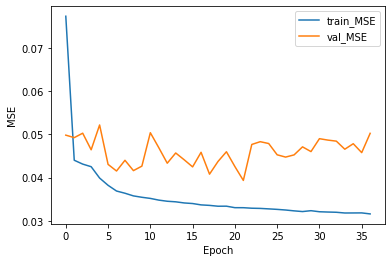

In [521]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un train MSE de 0.0330 y un val MSE de 0.0394  en 22 épocas. Mejores resultados hasta el momento, parece que la velocidad del viento no que es útil para el modelo. Los datos de validación parece que tampoco entrenan demasiado.

### Modelo 26b.  Como el 26 pero tomando datos de producción de día.

In [41]:
X_train1=np.array(PVGISdia.iloc[1:len(PVGISdia)-38:3,1:4]) #Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=np.array(PVGISdia.iloc[2:len(PVGISdia)-37:3,1:4]) #Tengo datos de radiación de 13:20-16:15 e introduzco producción a las 16:30.
X_train3=np.array(PVGISdia.iloc[3:len(PVGISdia)-36:3,1:4]) #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=np.array(PVGISdia.iloc[4:len(PVGISdia)-35:3,1:4])
X_train5=np.array(PVGISdia.iloc[5:len(PVGISdia)-34:3,1:4])
X_train6=np.array(PVGISdia.iloc[6:len(PVGISdia)-33:3,1:4])
X_train7=np.array(PVGISdia.iloc[7:len(PVGISdia)-32:3,1:4]) 
X_train8=np.array(PVGISdia.iloc[8:len(PVGISdia)-31:3,1:4])
X_train9=np.array(PVGISdia.iloc[9:len(PVGISdia)-30:3,1:4]) 
X_train10=np.array(PVGISdia.iloc[10:len(PVGISdia)-29:3,1:4])
X_train11=np.array(PVGISdia.iloc[11:len(PVGISdia)-28:3,1:4])
X_train12=np.array(PVGISdia.iloc[12:len(PVGISdia)-27:3,1:4]) #Tomo datos hasta las 22:30 del 16/12/2018 para que mi última predicción sea la de las 22:45
X_train13=np.array(PVGISdia.iloc[13:len(PVGISdia)-26:3,1:4])  
X_train14=np.array(PVGISdia.iloc[14:len(PVGISdia)-25:3,1:4]) 
X_train15=np.array(PVGISdia.iloc[15:len(PVGISdia)-24:3,1:4]) 
X_train16=np.array(PVGISdia.iloc[16:len(PVGISdia)-23:3,1:4])
X_train17=np.array(PVGISdia.iloc[17:len(PVGISdia)-22:3,1:4])
X_train18=np.array(PVGISdia.iloc[18:len(PVGISdia)-21:3,1:4])
X_train19=np.array(PVGISdia.iloc[19:len(PVGISdia)-20:3,1:4])  
X_train20=np.array(PVGISdia.iloc[20:len(PVGISdia)-19:3,1:4]) 
X_train21=np.array(PVGISdia.iloc[21:len(PVGISdia)-18:3,1:4]) 
X_train22=np.array(PVGISdia.iloc[22:len(PVGISdia)-17:3,1:4])
X_train23=np.array(PVGISdia.iloc[23:len(PVGISdia)-16:3,1:4])
X_train24=np.array(PVGISdia.iloc[24:len(PVGISdia)-15:3,1:4])
X_train25=np.array(PVGISdia.iloc[25:len(PVGISdia)-14:3,1:4])  
X_train26=np.array(PVGISdia.iloc[26:len(PVGISdia)-13:3,1:4]) 
X_train27=np.array(PVGISdia.iloc[27:len(PVGISdia)-12:3,1:4]) 
X_train28=np.array(PVGISdia.iloc[28:len(PVGISdia)-11:3,1:4])
X_train29=np.array(PVGISdia.iloc[29:len(PVGISdia)-10:3,1:4])
X_train30=np.array(PVGISdia.iloc[30:len(PVGISdia)-9:3,1:4])
X_train31=np.array(PVGISdia.iloc[31:len(PVGISdia)-8:3,1:4])  
X_train32=np.array(PVGISdia.iloc[32:len(PVGISdia)-7:3,1:4]) 
X_train33=np.array(PVGISdia.iloc[33:len(PVGISdia)-6:3,1:4]) 
X_train34=np.array(PVGISdia.iloc[34:len(PVGISdia)-5:3,1:4])
X_train35=np.array(PVGISdia.iloc[35:len(PVGISdia)-4:3,1:4])
X_train36=np.array(PVGISdia.iloc[36:len(PVGISdia)-3:3,1:4])

X_trainatm1=np.array(PVGISdia.iloc[1:len(PVGISdia)-38:3,4:6])  
X_trainatm2=np.array(PVGISdia.iloc[2:len(PVGISdia)-37:3,4:6]) 
X_trainatm3=np.array(PVGISdia.iloc[3:len(PVGISdia)-36:3,4:6]) 
X_trainatm4=np.array(PVGISdia.iloc[4:len(PVGISdia)-35:3,4:6])
X_trainatm5=np.array(PVGISdia.iloc[5:len(PVGISdia)-34:3,4:6])
X_trainatm6=np.array(PVGISdia.iloc[6:len(PVGISdia)-33:3,4:6])
X_trainatm7=np.array(PVGISdia.iloc[7:len(PVGISdia)-32:3,4:6]) 
X_trainatm8=np.array(PVGISdia.iloc[8:len(PVGISdia)-31:3,4:6])
X_trainatm9=np.array(PVGISdia.iloc[9:len(PVGISdia)-30:3,4:6]) 
X_trainatm10=np.array(PVGISdia.iloc[10:len(PVGISdia)-29:3,4:6])
X_trainatm11=np.array(PVGISdia.iloc[11:len(PVGISdia)-28:3,4:6])
X_trainatm12=np.array(PVGISdia.iloc[12:len(PVGISdia)-27:3,4:6])
X_trainatm13=np.array(PVGISdia.iloc[13:len(PVGISdia)-26:3,4:6])  
X_trainatm14=np.array(PVGISdia.iloc[14:len(PVGISdia)-25:3,4:6]) 
X_trainatm15=np.array(PVGISdia.iloc[15:len(PVGISdia)-24:3,4:6]) 
X_trainatm16=np.array(PVGISdia.iloc[16:len(PVGISdia)-23:3,4:6])
X_trainatm17=np.array(PVGISdia.iloc[17:len(PVGISdia)-22:3,4:6])
X_trainatm18=np.array(PVGISdia.iloc[18:len(PVGISdia)-21:3,4:6])
X_trainatm19=np.array(PVGISdia.iloc[19:len(PVGISdia)-20:3,4:6])  
X_trainatm20=np.array(PVGISdia.iloc[20:len(PVGISdia)-19:3,4:6]) 
X_trainatm21=np.array(PVGISdia.iloc[21:len(PVGISdia)-18:3,4:6]) 
X_trainatm22=np.array(PVGISdia.iloc[22:len(PVGISdia)-17:3,4:6])
X_trainatm23=np.array(PVGISdia.iloc[23:len(PVGISdia)-16:3,4:6])
X_trainatm24=np.array(PVGISdia.iloc[24:len(PVGISdia)-15:3,4:6])
X_trainatm25=np.array(PVGISdia.iloc[25:len(PVGISdia)-14:3,4:6])  
X_trainatm26=np.array(PVGISdia.iloc[26:len(PVGISdia)-13:3,4:6]) 
X_trainatm27=np.array(PVGISdia.iloc[27:len(PVGISdia)-12:3,4:6]) 
X_trainatm28=np.array(PVGISdia.iloc[28:len(PVGISdia)-11:3,4:6])
X_trainatm29=np.array(PVGISdia.iloc[29:len(PVGISdia)-10:3,4:6])
X_trainatm30=np.array(PVGISdia.iloc[30:len(PVGISdia)-9:3,4:6])
X_trainatm31=np.array(PVGISdia.iloc[31:len(PVGISdia)-8:3,4:6])  
X_trainatm32=np.array(PVGISdia.iloc[32:len(PVGISdia)-7:3,4:6]) 
X_trainatm33=np.array(PVGISdia.iloc[33:len(PVGISdia)-6:3,4:6]) 
X_trainatm34=np.array(PVGISdia.iloc[34:len(PVGISdia)-5:3,4:6])
X_trainatm35=np.array(PVGISdia.iloc[35:len(PVGISdia)-4:3,4:6])
X_trainatm36=np.array(PVGISdia.iloc[36:len(PVGISdia)-3:3,4:6])

X_prod1=np.array(PVOutputdia.iloc[12:len(PVOutputdia)-1,1]).astype(float) #Producción 15 minutos antes
X_prod2=np.array(PVOutputdia.iloc[11:len(PVOutputdia)-2,1]).astype(float) #Producción 30 minutos antes

y_train=np.array(PVOutputdia.iloc[13:len(PVOutputdia),1]).astype(float) #No tomo los primeros 7 valores para cuadrarlo, que empiece a las 16:30

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 
X_train7std=np.std(X_train7) 
X_train8std=np.std(X_train8)
X_train9std=np.std(X_train9)
X_train10std=np.std(X_train10) 
X_train11std=np.std(X_train11) 
X_train12std=np.std(X_train12)
X_train13std=np.std(X_train13) 
X_train14std=np.std(X_train14) 
X_train15std=np.std(X_train15)
X_train16std=np.std(X_train16)
X_train17std=np.std(X_train17) 
X_train18std=np.std(X_train18)
X_train19std=np.std(X_train19) 
X_train20std=np.std(X_train20) 
X_train21std=np.std(X_train21)
X_train22std=np.std(X_train22)
X_train23std=np.std(X_train23) 
X_train24std=np.std(X_train24)
X_train25std=np.std(X_train25) 
X_train26std=np.std(X_train26) 
X_train27std=np.std(X_train27)
X_train28std=np.std(X_train28)
X_train29std=np.std(X_train29) 
X_train30std=np.std(X_train30)
X_train31std=np.std(X_train31) 
X_train32std=np.std(X_train32) 
X_train33std=np.std(X_train33)
X_train34std=np.std(X_train34)
X_train35std=np.std(X_train35) 
X_train36std=np.std(X_train36) 


X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 
X_train7est=X_train7/X_train7std 
X_train8est=X_train8/X_train8std
X_train9est=X_train9/X_train9std 
X_train10est=X_train10/X_train10std 
X_train11est=X_train11/X_train11std 
X_train12est=X_train12/X_train12std
X_train13est=X_train13/X_train13std 
X_train14est=X_train14/X_train14std
X_train15est=X_train15/X_train15std 
X_train16est=X_train16/X_train16std 
X_train17est=X_train17/X_train17std 
X_train18est=X_train18/X_train18std
X_train19est=X_train19/X_train19std 
X_train20est=X_train20/X_train20std
X_train21est=X_train21/X_train21std 
X_train22est=X_train22/X_train22std 
X_train23est=X_train23/X_train23std 
X_train24est=X_train24/X_train24std
X_train25est=X_train25/X_train25std 
X_train26est=X_train26/X_train26std
X_train27est=X_train27/X_train27std 
X_train28est=X_train28/X_train28std 
X_train29est=X_train29/X_train29std 
X_train30est=X_train30/X_train30std
X_train31est=X_train31/X_train31std 
X_train32est=X_train32/X_train32std
X_train33est=X_train33/X_train33std 
X_train34est=X_train34/X_train34std 
X_train35est=X_train35/X_train35std 
X_train36est=X_train36/X_train36std

X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est,X_train7est,X_train8est,X_train9est,X_train10est,X_train11est,X_train12est,X_train13est,X_train14est,X_train15est,X_train16est,X_train17est,X_train18est,X_train19est,X_train20est,X_train21est,X_train22est,X_train23est,X_train24est,X_train25est,X_train26est,X_train27est,X_train28est,X_train29est,X_train30est,X_train31est,X_train32est,X_train33est,X_train34est,X_train35est,X_train36est)

X_trainatm1std=np.std(X_trainatm1)  
X_trainatm2std=np.std(X_trainatm2) 
X_trainatm3std=np.std(X_trainatm3) 
X_trainatm4std=np.std(X_trainatm4)
X_trainatm5std=np.std(X_trainatm5)
X_trainatm6std=np.std(X_trainatm6)
X_trainatm7std=np.std(X_trainatm7)
X_trainatm8std=np.std(X_trainatm8)
X_trainatm9std=np.std(X_trainatm9) 
X_trainatm10std=np.std(X_trainatm10)
X_trainatm11std=np.std(X_trainatm11)
X_trainatm12std=np.std(X_trainatm12)
X_trainatm13std=np.std(X_trainatm13)
X_trainatm14std=np.std(X_trainatm14)
X_trainatm15std=np.std(X_trainatm15) 
X_trainatm16std=np.std(X_trainatm16)
X_trainatm17std=np.std(X_trainatm17)
X_trainatm18std=np.std(X_trainatm18)
X_trainatm19std=np.std(X_trainatm19)
X_trainatm20std=np.std(X_trainatm20)
X_trainatm21std=np.std(X_trainatm21) 
X_trainatm22std=np.std(X_trainatm22)
X_trainatm23std=np.std(X_trainatm23)
X_trainatm24std=np.std(X_trainatm24)
X_trainatm25std=np.std(X_trainatm25)
X_trainatm26std=np.std(X_trainatm26)
X_trainatm27std=np.std(X_trainatm27) 
X_trainatm28std=np.std(X_trainatm28)
X_trainatm29std=np.std(X_trainatm29)
X_trainatm30std=np.std(X_trainatm30)
X_trainatm31std=np.std(X_trainatm31)
X_trainatm32std=np.std(X_trainatm32)
X_trainatm33std=np.std(X_trainatm33) 
X_trainatm34std=np.std(X_trainatm34)
X_trainatm35std=np.std(X_trainatm35)
X_trainatm36std=np.std(X_trainatm36)

X_trainatm1est=X_trainatm1/X_trainatm1std 
X_trainatm2est=X_trainatm2/X_trainatm2std 
X_trainatm3est=X_trainatm3/X_trainatm3std 
X_trainatm4est=X_trainatm4/X_trainatm4std
X_trainatm5est=X_trainatm5/X_trainatm5std 
X_trainatm6est=X_trainatm6/X_trainatm6std 
X_trainatm7est=X_trainatm7/X_trainatm7std 
X_trainatm8est=X_trainatm8/X_trainatm8std
X_trainatm9est=X_trainatm9/X_trainatm9std 
X_trainatm10est=X_trainatm10/X_trainatm10std 
X_trainatm11est=X_trainatm11/X_trainatm11std 
X_trainatm12est=X_trainatm12/X_trainatm12std
X_trainatm13est=X_trainatm13/X_trainatm13std 
X_trainatm14est=X_trainatm14/X_trainatm14std 
X_trainatm15est=X_trainatm15/X_trainatm15std
X_trainatm16est=X_trainatm16/X_trainatm16std 
X_trainatm17est=X_trainatm17/X_trainatm17std 
X_trainatm18est=X_trainatm18/X_trainatm18std
X_trainatm19est=X_trainatm19/X_trainatm19std 
X_trainatm20est=X_trainatm20/X_trainatm20std 
X_trainatm21est=X_trainatm21/X_trainatm21std
X_trainatm22est=X_trainatm22/X_trainatm22std 
X_trainatm23est=X_trainatm23/X_trainatm23std 
X_trainatm24est=X_trainatm24/X_trainatm24std
X_trainatm25est=X_trainatm25/X_trainatm25std 
X_trainatm26est=X_trainatm26/X_trainatm26std 
X_trainatm27est=X_trainatm27/X_trainatm27std
X_trainatm28est=X_trainatm28/X_trainatm28std 
X_trainatm29est=X_trainatm29/X_trainatm29std 
X_trainatm30est=X_trainatm30/X_trainatm30std
X_trainatm31est=X_trainatm31/X_trainatm31std 
X_trainatm32est=X_trainatm32/X_trainatm32std 
X_trainatm33est=X_trainatm33/X_trainatm33std
X_trainatm34est=X_trainatm34/X_trainatm34std 
X_trainatm35est=X_trainatm35/X_trainatm35std 
X_trainatm36est=X_trainatm36/X_trainatm36std

X_trainatmest=(X_trainatm1est,X_trainatm2est,X_trainatm3est,X_trainatm4est,X_trainatm5est,X_trainatm6est,X_trainatm7est,X_trainatm8est,X_trainatm9est,X_trainatm10est,X_trainatm11est,X_trainatm12est,X_trainatm13est,X_trainatm14est,X_trainatm15est,X_trainatm16est,X_trainatm17est,X_trainatm18est,X_trainatm19est,X_trainatm20est,X_trainatm21est,X_trainatm22est,X_trainatm23est,X_trainatm24est,X_trainatm25est,X_trainatm26est,X_trainatm27est,X_trainatm28est,X_trainatm29est,X_trainatm30est,X_trainatm31est,X_trainatm32est,X_trainatm33est,X_trainatm34est,X_trainatm35est,X_trainatm36est)

X_prod1std=np.std(X_prod1)
X_prod1est=X_prod1/X_prod1std 

X_prod2std=np.std(X_prod2)
X_prod2est=X_prod2/X_prod2std 
X_prodest=(X_prod1est,X_prod2est)

Y_trainstd=np.std(y_train) 
Y_trainest=y_train/Y_trainstd 

In [42]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)
entrada13 = tf.keras.layers.Input(shape=3)
entrada14 = tf.keras.layers.Input(shape=3)
entrada15 = tf.keras.layers.Input(shape=3)
entrada16 = tf.keras.layers.Input(shape=3)
entrada17 = tf.keras.layers.Input(shape=3)
entrada18 = tf.keras.layers.Input(shape=3)
entrada19 = tf.keras.layers.Input(shape=3)
entrada20 = tf.keras.layers.Input(shape=3)
entrada21 = tf.keras.layers.Input(shape=3)
entrada22 = tf.keras.layers.Input(shape=3)
entrada23 = tf.keras.layers.Input(shape=3)
entrada24 = tf.keras.layers.Input(shape=3)
entrada25 = tf.keras.layers.Input(shape=3)
entrada26 = tf.keras.layers.Input(shape=3)
entrada27 = tf.keras.layers.Input(shape=3)
entrada28 = tf.keras.layers.Input(shape=3)
entrada29 = tf.keras.layers.Input(shape=3)
entrada30 = tf.keras.layers.Input(shape=3)
entrada31 = tf.keras.layers.Input(shape=3)
entrada32 = tf.keras.layers.Input(shape=3)
entrada33 = tf.keras.layers.Input(shape=3)
entrada34 = tf.keras.layers.Input(shape=3)
entrada35 = tf.keras.layers.Input(shape=3)
entrada36 = tf.keras.layers.Input(shape=3)

entradaatm1 = tf.keras.layers.Input(shape=2) 
entradaatm2 = tf.keras.layers.Input(shape=2)
entradaatm3 = tf.keras.layers.Input(shape=2)
entradaatm4 = tf.keras.layers.Input(shape=2)
entradaatm5 = tf.keras.layers.Input(shape=2)
entradaatm6 = tf.keras.layers.Input(shape=2)
entradaatm7 = tf.keras.layers.Input(shape=2)
entradaatm8 = tf.keras.layers.Input(shape=2)
entradaatm9 = tf.keras.layers.Input(shape=2)
entradaatm10 = tf.keras.layers.Input(shape=2)
entradaatm11 = tf.keras.layers.Input(shape=2)
entradaatm12 = tf.keras.layers.Input(shape=2)
entradaatm13 = tf.keras.layers.Input(shape=2)
entradaatm14 = tf.keras.layers.Input(shape=2)
entradaatm15 = tf.keras.layers.Input(shape=2) 
entradaatm16 = tf.keras.layers.Input(shape=2)
entradaatm17 = tf.keras.layers.Input(shape=2)
entradaatm18 = tf.keras.layers.Input(shape=2)
entradaatm19 = tf.keras.layers.Input(shape=2)
entradaatm20 = tf.keras.layers.Input(shape=2)
entradaatm21 = tf.keras.layers.Input(shape=2) 
entradaatm22 = tf.keras.layers.Input(shape=2)
entradaatm23 = tf.keras.layers.Input(shape=2)
entradaatm24 = tf.keras.layers.Input(shape=2)
entradaatm25 = tf.keras.layers.Input(shape=2)
entradaatm26 = tf.keras.layers.Input(shape=2)
entradaatm27 = tf.keras.layers.Input(shape=2) 
entradaatm28 = tf.keras.layers.Input(shape=2)
entradaatm29 = tf.keras.layers.Input(shape=2)
entradaatm30 = tf.keras.layers.Input(shape=2)
entradaatm31 = tf.keras.layers.Input(shape=2)
entradaatm32 = tf.keras.layers.Input(shape=2)
entradaatm33 = tf.keras.layers.Input(shape=2) 
entradaatm34 = tf.keras.layers.Input(shape=2)
entradaatm35 = tf.keras.layers.Input(shape=2)
entradaatm36 = tf.keras.layers.Input(shape=2)

entradaprod1=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat
entradaprod2=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat


#Capas ocultas formula 2: Hidden =3/2*(In + Out)=3/2*(3+1)=6
oculta1 = tf.keras.layers.Dense(6, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(6, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(6, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(6, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(6, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(6, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(6, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(6, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(6, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(6, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(6, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(6, activation="relu")(entrada12)
oculta13 = tf.keras.layers.Dense(6, activation="relu")(entrada13)
oculta14 = tf.keras.layers.Dense(6, activation="relu")(entrada14)
oculta15 = tf.keras.layers.Dense(6, activation="relu")(entrada15)
oculta16 = tf.keras.layers.Dense(6, activation="relu")(entrada16)
oculta17 = tf.keras.layers.Dense(6, activation="relu")(entrada17)
oculta18 = tf.keras.layers.Dense(6, activation="relu")(entrada18)
oculta19 = tf.keras.layers.Dense(6, activation="relu")(entrada19)
oculta20 = tf.keras.layers.Dense(6, activation="relu")(entrada20)
oculta21 = tf.keras.layers.Dense(6, activation="relu")(entrada21)
oculta22 = tf.keras.layers.Dense(6, activation="relu")(entrada22)
oculta23 = tf.keras.layers.Dense(6, activation="relu")(entrada23)
oculta24 = tf.keras.layers.Dense(6, activation="relu")(entrada24)
oculta25 = tf.keras.layers.Dense(6, activation="relu")(entrada25)
oculta26 = tf.keras.layers.Dense(6, activation="relu")(entrada26)
oculta27 = tf.keras.layers.Dense(6, activation="relu")(entrada27)
oculta28 = tf.keras.layers.Dense(6, activation="relu")(entrada28)
oculta29 = tf.keras.layers.Dense(6, activation="relu")(entrada29)
oculta30 = tf.keras.layers.Dense(6, activation="relu")(entrada30)
oculta31 = tf.keras.layers.Dense(6, activation="relu")(entrada31)
oculta32 = tf.keras.layers.Dense(6, activation="relu")(entrada32)
oculta33 = tf.keras.layers.Dense(6, activation="relu")(entrada33)
oculta34 = tf.keras.layers.Dense(6, activation="relu")(entrada34)
oculta35 = tf.keras.layers.Dense(6, activation="relu")(entrada35)
oculta36 = tf.keras.layers.Dense(6, activation="relu")(entrada36)


concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12, oculta13, oculta14, oculta15, oculta16, oculta17, oculta18, oculta19, oculta20, oculta21, oculta22, oculta23, oculta24, oculta25, oculta26, oculta27, oculta28, oculta29, oculta30, oculta31, oculta32, oculta33, oculta34, oculta35, oculta36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod1,entradaprod2]) #estratificada, concatena las 12
#2 layers intermedias, formula 2: Hidden =3/2*(In + Out)=3/2*(1+1)=3
adoculta1=tf.keras.layers.Dense(3, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(3, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(3, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo26b = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12, entrada13, entrada14, entrada15, entrada16, entrada17, entrada18, entrada19, entrada20, entrada21, entrada22, entrada23, entrada24, entrada25, entrada26, entrada27, entrada28, entrada29, entrada30, entrada31, entrada32, entrada33, entrada34, entrada35, entrada36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod1,entradaprod2], outputs=[salida])

modelo26b.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo26b.fit([X_trainest,X_trainatmest,X_prodest], Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2)
#Mucho mejor resultado introduciendo entre corchetes que entre paréntesis (X_trainest,X_trainatmest)
#No estoy 100% seguro de que esté bien introducido así, cómo sabe que las entradai corresponden a X_train y que entradaatmi corresponden a X_trainatm?

Epoch 1/1000
2217/2217 [==============================] - 15s 6ms/step - loss: 0.9026 - mae: 0.5306 - val_loss: 0.1113 - val_mae: 0.1262
Epoch 2/1000
2217/2217 [==============================] - 11s 5ms/step - loss: 0.0840 - mae: 0.1148 - val_loss: 0.0999 - val_mae: 0.1041
Epoch 3/1000
2217/2217 [==============================] - 11s 5ms/step - loss: 0.0785 - mae: 0.1015 - val_loss: 0.0960 - val_mae: 0.1493
Epoch 4/1000
2217/2217 [==============================] - 12s 5ms/step - loss: 0.0771 - mae: 0.0979 - val_loss: 0.0908 - val_mae: 0.0896
Epoch 5/1000
2217/2217 [==============================] - 12s 5ms/step - loss: 0.0762 - mae: 0.0953 - val_loss: 0.0933 - val_mae: 0.1318
Epoch 6/1000
2217/2217 [==============================] - 11s 5ms/step - loss: 0.0759 - mae: 0.0940 - val_loss: 0.0964 - val_mae: 0.1453
Epoch 7/1000
2217/2217 [==============================] - 12s 5ms/step - loss: 0.0753 - mae: 0.0919 - val_loss: 0.0890 - val_mae: 0.0793
Epoch 8/1000
2217/2217 [=================

2217/2217 [==============================] - 11s 5ms/step - loss: 0.0729 - mae: 0.0809 - val_loss: 0.0888 - val_mae: 0.1103
Epoch 61/1000
2217/2217 [==============================] - 11s 5ms/step - loss: 0.0727 - mae: 0.0806 - val_loss: 0.0865 - val_mae: 0.0847
Epoch 62/1000
2217/2217 [==============================] - 11s 5ms/step - loss: 0.0727 - mae: 0.0805 - val_loss: 0.0867 - val_mae: 0.0750
Epoch 63/1000
2217/2217 [==============================] - 11s 5ms/step - loss: 0.0729 - mae: 0.0813 - val_loss: 0.0866 - val_mae: 0.0780
Epoch 64/1000
2217/2217 [==============================] - 11s 5ms/step - loss: 0.0727 - mae: 0.0808 - val_loss: 0.0868 - val_mae: 0.0835
Epoch 65/1000
2217/2217 [==============================] - 11s 5ms/step - loss: 0.0728 - mae: 0.0806 - val_loss: 0.0903 - val_mae: 0.1254
Epoch 66/1000
2217/2217 [==============================] - 11s 5ms/step - loss: 0.0728 - mae: 0.0807 - val_loss: 0.0868 - val_mae: 0.0897
Epoch 67/1000
2217/2217 [=======================

2217/2217 [==============================] - 11s 5ms/step - loss: 0.0716 - mae: 0.0771 - val_loss: 0.0855 - val_mae: 0.0819
Epoch 120/1000
2217/2217 [==============================] - 11s 5ms/step - loss: 0.0718 - mae: 0.0771 - val_loss: 0.0889 - val_mae: 0.0793
Epoch 121/1000
2217/2217 [==============================] - 11s 5ms/step - loss: 0.0715 - mae: 0.0765 - val_loss: 0.0856 - val_mae: 0.0675
Epoch 122/1000
2217/2217 [==============================] - 11s 5ms/step - loss: 0.0715 - mae: 0.0764 - val_loss: 0.0971 - val_mae: 0.1610
Epoch 123/1000
2217/2217 [==============================] - 11s 5ms/step - loss: 0.0718 - mae: 0.0771 - val_loss: 0.0856 - val_mae: 0.0754
Epoch 124/1000
2217/2217 [==============================] - 11s 5ms/step - loss: 0.0716 - mae: 0.0770 - val_loss: 0.0930 - val_mae: 0.1409
Epoch 125/1000
2217/2217 [==============================] - 11s 5ms/step - loss: 0.0718 - mae: 0.0769 - val_loss: 0.0871 - val_mae: 0.0747
Epoch 126/1000
2217/2217 [================

Text(0, 0.5, 'MSE')

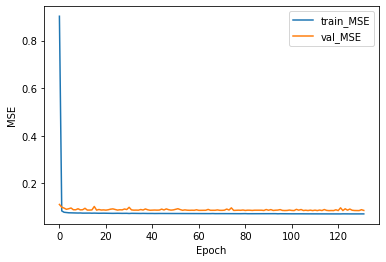

In [44]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos resultados lógicamente peores que prediciendo día y noche, pasamos de un val MSE de 0.0334 y un val MAE de 0.0431 a un  val MSE de 0.0854 y un val MAE de 0.0790. Entrena mucho

### Modelo 26c.  Como el 26 pero tomando datos de producción de día y valores normalizados de producción.

In [48]:
X_train1=np.array(PVGISdia.iloc[1:len(PVGISdia)-38:3,1:4]) #Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=np.array(PVGISdia.iloc[2:len(PVGISdia)-37:3,1:4]) #Tengo datos de radiación de 13:20-16:15 e introduzco producción a las 16:30.
X_train3=np.array(PVGISdia.iloc[3:len(PVGISdia)-36:3,1:4]) #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=np.array(PVGISdia.iloc[4:len(PVGISdia)-35:3,1:4])
X_train5=np.array(PVGISdia.iloc[5:len(PVGISdia)-34:3,1:4])
X_train6=np.array(PVGISdia.iloc[6:len(PVGISdia)-33:3,1:4])
X_train7=np.array(PVGISdia.iloc[7:len(PVGISdia)-32:3,1:4]) 
X_train8=np.array(PVGISdia.iloc[8:len(PVGISdia)-31:3,1:4])
X_train9=np.array(PVGISdia.iloc[9:len(PVGISdia)-30:3,1:4]) 
X_train10=np.array(PVGISdia.iloc[10:len(PVGISdia)-29:3,1:4])
X_train11=np.array(PVGISdia.iloc[11:len(PVGISdia)-28:3,1:4])
X_train12=np.array(PVGISdia.iloc[12:len(PVGISdia)-27:3,1:4]) #Tomo datos hasta las 22:30 del 16/12/2018 para que mi última predicción sea la de las 22:45
X_train13=np.array(PVGISdia.iloc[13:len(PVGISdia)-26:3,1:4])  
X_train14=np.array(PVGISdia.iloc[14:len(PVGISdia)-25:3,1:4]) 
X_train15=np.array(PVGISdia.iloc[15:len(PVGISdia)-24:3,1:4]) 
X_train16=np.array(PVGISdia.iloc[16:len(PVGISdia)-23:3,1:4])
X_train17=np.array(PVGISdia.iloc[17:len(PVGISdia)-22:3,1:4])
X_train18=np.array(PVGISdia.iloc[18:len(PVGISdia)-21:3,1:4])
X_train19=np.array(PVGISdia.iloc[19:len(PVGISdia)-20:3,1:4])  
X_train20=np.array(PVGISdia.iloc[20:len(PVGISdia)-19:3,1:4]) 
X_train21=np.array(PVGISdia.iloc[21:len(PVGISdia)-18:3,1:4]) 
X_train22=np.array(PVGISdia.iloc[22:len(PVGISdia)-17:3,1:4])
X_train23=np.array(PVGISdia.iloc[23:len(PVGISdia)-16:3,1:4])
X_train24=np.array(PVGISdia.iloc[24:len(PVGISdia)-15:3,1:4])
X_train25=np.array(PVGISdia.iloc[25:len(PVGISdia)-14:3,1:4])  
X_train26=np.array(PVGISdia.iloc[26:len(PVGISdia)-13:3,1:4]) 
X_train27=np.array(PVGISdia.iloc[27:len(PVGISdia)-12:3,1:4]) 
X_train28=np.array(PVGISdia.iloc[28:len(PVGISdia)-11:3,1:4])
X_train29=np.array(PVGISdia.iloc[29:len(PVGISdia)-10:3,1:4])
X_train30=np.array(PVGISdia.iloc[30:len(PVGISdia)-9:3,1:4])
X_train31=np.array(PVGISdia.iloc[31:len(PVGISdia)-8:3,1:4])  
X_train32=np.array(PVGISdia.iloc[32:len(PVGISdia)-7:3,1:4]) 
X_train33=np.array(PVGISdia.iloc[33:len(PVGISdia)-6:3,1:4]) 
X_train34=np.array(PVGISdia.iloc[34:len(PVGISdia)-5:3,1:4])
X_train35=np.array(PVGISdia.iloc[35:len(PVGISdia)-4:3,1:4])
X_train36=np.array(PVGISdia.iloc[36:len(PVGISdia)-3:3,1:4])

X_trainatm1=np.array(PVGISdia.iloc[1:len(PVGISdia)-38:3,4:6])  
X_trainatm2=np.array(PVGISdia.iloc[2:len(PVGISdia)-37:3,4:6]) 
X_trainatm3=np.array(PVGISdia.iloc[3:len(PVGISdia)-36:3,4:6]) 
X_trainatm4=np.array(PVGISdia.iloc[4:len(PVGISdia)-35:3,4:6])
X_trainatm5=np.array(PVGISdia.iloc[5:len(PVGISdia)-34:3,4:6])
X_trainatm6=np.array(PVGISdia.iloc[6:len(PVGISdia)-33:3,4:6])
X_trainatm7=np.array(PVGISdia.iloc[7:len(PVGISdia)-32:3,4:6]) 
X_trainatm8=np.array(PVGISdia.iloc[8:len(PVGISdia)-31:3,4:6])
X_trainatm9=np.array(PVGISdia.iloc[9:len(PVGISdia)-30:3,4:6]) 
X_trainatm10=np.array(PVGISdia.iloc[10:len(PVGISdia)-29:3,4:6])
X_trainatm11=np.array(PVGISdia.iloc[11:len(PVGISdia)-28:3,4:6])
X_trainatm12=np.array(PVGISdia.iloc[12:len(PVGISdia)-27:3,4:6])
X_trainatm13=np.array(PVGISdia.iloc[13:len(PVGISdia)-26:3,4:6])  
X_trainatm14=np.array(PVGISdia.iloc[14:len(PVGISdia)-25:3,4:6]) 
X_trainatm15=np.array(PVGISdia.iloc[15:len(PVGISdia)-24:3,4:6]) 
X_trainatm16=np.array(PVGISdia.iloc[16:len(PVGISdia)-23:3,4:6])
X_trainatm17=np.array(PVGISdia.iloc[17:len(PVGISdia)-22:3,4:6])
X_trainatm18=np.array(PVGISdia.iloc[18:len(PVGISdia)-21:3,4:6])
X_trainatm19=np.array(PVGISdia.iloc[19:len(PVGISdia)-20:3,4:6])  
X_trainatm20=np.array(PVGISdia.iloc[20:len(PVGISdia)-19:3,4:6]) 
X_trainatm21=np.array(PVGISdia.iloc[21:len(PVGISdia)-18:3,4:6]) 
X_trainatm22=np.array(PVGISdia.iloc[22:len(PVGISdia)-17:3,4:6])
X_trainatm23=np.array(PVGISdia.iloc[23:len(PVGISdia)-16:3,4:6])
X_trainatm24=np.array(PVGISdia.iloc[24:len(PVGISdia)-15:3,4:6])
X_trainatm25=np.array(PVGISdia.iloc[25:len(PVGISdia)-14:3,4:6])  
X_trainatm26=np.array(PVGISdia.iloc[26:len(PVGISdia)-13:3,4:6]) 
X_trainatm27=np.array(PVGISdia.iloc[27:len(PVGISdia)-12:3,4:6]) 
X_trainatm28=np.array(PVGISdia.iloc[28:len(PVGISdia)-11:3,4:6])
X_trainatm29=np.array(PVGISdia.iloc[29:len(PVGISdia)-10:3,4:6])
X_trainatm30=np.array(PVGISdia.iloc[30:len(PVGISdia)-9:3,4:6])
X_trainatm31=np.array(PVGISdia.iloc[31:len(PVGISdia)-8:3,4:6])  
X_trainatm32=np.array(PVGISdia.iloc[32:len(PVGISdia)-7:3,4:6]) 
X_trainatm33=np.array(PVGISdia.iloc[33:len(PVGISdia)-6:3,4:6]) 
X_trainatm34=np.array(PVGISdia.iloc[34:len(PVGISdia)-5:3,4:6])
X_trainatm35=np.array(PVGISdia.iloc[35:len(PVGISdia)-4:3,4:6])
X_trainatm36=np.array(PVGISdia.iloc[36:len(PVGISdia)-3:3,4:6])

X_prod1=np.array(PVOutputdia.iloc[12:len(PVOutputdia)-1,5]).astype(float) #Producción 15 minutos antes
X_prod2=np.array(PVOutputdia.iloc[11:len(PVOutputdia)-2,5]).astype(float) #Producción 30 minutos antes
X_prod=(X_prod1, X_prod2)

y_train=np.array(PVOutputdia.iloc[13:len(PVOutputdia),5]).astype(float) #No tomo los primeros 7 valores para cuadrarlo, que empiece a las 16:30

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 
X_train7std=np.std(X_train7) 
X_train8std=np.std(X_train8)
X_train9std=np.std(X_train9)
X_train10std=np.std(X_train10) 
X_train11std=np.std(X_train11) 
X_train12std=np.std(X_train12)
X_train13std=np.std(X_train13) 
X_train14std=np.std(X_train14) 
X_train15std=np.std(X_train15)
X_train16std=np.std(X_train16)
X_train17std=np.std(X_train17) 
X_train18std=np.std(X_train18)
X_train19std=np.std(X_train19) 
X_train20std=np.std(X_train20) 
X_train21std=np.std(X_train21)
X_train22std=np.std(X_train22)
X_train23std=np.std(X_train23) 
X_train24std=np.std(X_train24)
X_train25std=np.std(X_train25) 
X_train26std=np.std(X_train26) 
X_train27std=np.std(X_train27)
X_train28std=np.std(X_train28)
X_train29std=np.std(X_train29) 
X_train30std=np.std(X_train30)
X_train31std=np.std(X_train31) 
X_train32std=np.std(X_train32) 
X_train33std=np.std(X_train33)
X_train34std=np.std(X_train34)
X_train35std=np.std(X_train35) 
X_train36std=np.std(X_train36) 


X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 
X_train7est=X_train7/X_train7std 
X_train8est=X_train8/X_train8std
X_train9est=X_train9/X_train9std 
X_train10est=X_train10/X_train10std 
X_train11est=X_train11/X_train11std 
X_train12est=X_train12/X_train12std
X_train13est=X_train13/X_train13std 
X_train14est=X_train14/X_train14std
X_train15est=X_train15/X_train15std 
X_train16est=X_train16/X_train16std 
X_train17est=X_train17/X_train17std 
X_train18est=X_train18/X_train18std
X_train19est=X_train19/X_train19std 
X_train20est=X_train20/X_train20std
X_train21est=X_train21/X_train21std 
X_train22est=X_train22/X_train22std 
X_train23est=X_train23/X_train23std 
X_train24est=X_train24/X_train24std
X_train25est=X_train25/X_train25std 
X_train26est=X_train26/X_train26std
X_train27est=X_train27/X_train27std 
X_train28est=X_train28/X_train28std 
X_train29est=X_train29/X_train29std 
X_train30est=X_train30/X_train30std
X_train31est=X_train31/X_train31std 
X_train32est=X_train32/X_train32std
X_train33est=X_train33/X_train33std 
X_train34est=X_train34/X_train34std 
X_train35est=X_train35/X_train35std 
X_train36est=X_train36/X_train36std

X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est,X_train7est,X_train8est,X_train9est,X_train10est,X_train11est,X_train12est,X_train13est,X_train14est,X_train15est,X_train16est,X_train17est,X_train18est,X_train19est,X_train20est,X_train21est,X_train22est,X_train23est,X_train24est,X_train25est,X_train26est,X_train27est,X_train28est,X_train29est,X_train30est,X_train31est,X_train32est,X_train33est,X_train34est,X_train35est,X_train36est)

X_trainatm1std=np.std(X_trainatm1)  
X_trainatm2std=np.std(X_trainatm2) 
X_trainatm3std=np.std(X_trainatm3) 
X_trainatm4std=np.std(X_trainatm4)
X_trainatm5std=np.std(X_trainatm5)
X_trainatm6std=np.std(X_trainatm6)
X_trainatm7std=np.std(X_trainatm7)
X_trainatm8std=np.std(X_trainatm8)
X_trainatm9std=np.std(X_trainatm9) 
X_trainatm10std=np.std(X_trainatm10)
X_trainatm11std=np.std(X_trainatm11)
X_trainatm12std=np.std(X_trainatm12)
X_trainatm13std=np.std(X_trainatm13)
X_trainatm14std=np.std(X_trainatm14)
X_trainatm15std=np.std(X_trainatm15) 
X_trainatm16std=np.std(X_trainatm16)
X_trainatm17std=np.std(X_trainatm17)
X_trainatm18std=np.std(X_trainatm18)
X_trainatm19std=np.std(X_trainatm19)
X_trainatm20std=np.std(X_trainatm20)
X_trainatm21std=np.std(X_trainatm21) 
X_trainatm22std=np.std(X_trainatm22)
X_trainatm23std=np.std(X_trainatm23)
X_trainatm24std=np.std(X_trainatm24)
X_trainatm25std=np.std(X_trainatm25)
X_trainatm26std=np.std(X_trainatm26)
X_trainatm27std=np.std(X_trainatm27) 
X_trainatm28std=np.std(X_trainatm28)
X_trainatm29std=np.std(X_trainatm29)
X_trainatm30std=np.std(X_trainatm30)
X_trainatm31std=np.std(X_trainatm31)
X_trainatm32std=np.std(X_trainatm32)
X_trainatm33std=np.std(X_trainatm33) 
X_trainatm34std=np.std(X_trainatm34)
X_trainatm35std=np.std(X_trainatm35)
X_trainatm36std=np.std(X_trainatm36)

X_trainatm1est=X_trainatm1/X_trainatm1std 
X_trainatm2est=X_trainatm2/X_trainatm2std 
X_trainatm3est=X_trainatm3/X_trainatm3std 
X_trainatm4est=X_trainatm4/X_trainatm4std
X_trainatm5est=X_trainatm5/X_trainatm5std 
X_trainatm6est=X_trainatm6/X_trainatm6std 
X_trainatm7est=X_trainatm7/X_trainatm7std 
X_trainatm8est=X_trainatm8/X_trainatm8std
X_trainatm9est=X_trainatm9/X_trainatm9std 
X_trainatm10est=X_trainatm10/X_trainatm10std 
X_trainatm11est=X_trainatm11/X_trainatm11std 
X_trainatm12est=X_trainatm12/X_trainatm12std
X_trainatm13est=X_trainatm13/X_trainatm13std 
X_trainatm14est=X_trainatm14/X_trainatm14std 
X_trainatm15est=X_trainatm15/X_trainatm15std
X_trainatm16est=X_trainatm16/X_trainatm16std 
X_trainatm17est=X_trainatm17/X_trainatm17std 
X_trainatm18est=X_trainatm18/X_trainatm18std
X_trainatm19est=X_trainatm19/X_trainatm19std 
X_trainatm20est=X_trainatm20/X_trainatm20std 
X_trainatm21est=X_trainatm21/X_trainatm21std
X_trainatm22est=X_trainatm22/X_trainatm22std 
X_trainatm23est=X_trainatm23/X_trainatm23std 
X_trainatm24est=X_trainatm24/X_trainatm24std
X_trainatm25est=X_trainatm25/X_trainatm25std 
X_trainatm26est=X_trainatm26/X_trainatm26std 
X_trainatm27est=X_trainatm27/X_trainatm27std
X_trainatm28est=X_trainatm28/X_trainatm28std 
X_trainatm29est=X_trainatm29/X_trainatm29std 
X_trainatm30est=X_trainatm30/X_trainatm30std
X_trainatm31est=X_trainatm31/X_trainatm31std 
X_trainatm32est=X_trainatm32/X_trainatm32std 
X_trainatm33est=X_trainatm33/X_trainatm33std
X_trainatm34est=X_trainatm34/X_trainatm34std 
X_trainatm35est=X_trainatm35/X_trainatm35std 
X_trainatm36est=X_trainatm36/X_trainatm36std

X_trainatmest=(X_trainatm1est,X_trainatm2est,X_trainatm3est,X_trainatm4est,X_trainatm5est,X_trainatm6est,X_trainatm7est,X_trainatm8est,X_trainatm9est,X_trainatm10est,X_trainatm11est,X_trainatm12est,X_trainatm13est,X_trainatm14est,X_trainatm15est,X_trainatm16est,X_trainatm17est,X_trainatm18est,X_trainatm19est,X_trainatm20est,X_trainatm21est,X_trainatm22est,X_trainatm23est,X_trainatm24est,X_trainatm25est,X_trainatm26est,X_trainatm27est,X_trainatm28est,X_trainatm29est,X_trainatm30est,X_trainatm31est,X_trainatm32est,X_trainatm33est,X_trainatm34est,X_trainatm35est,X_trainatm36est)





In [49]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)
entrada13 = tf.keras.layers.Input(shape=3)
entrada14 = tf.keras.layers.Input(shape=3)
entrada15 = tf.keras.layers.Input(shape=3)
entrada16 = tf.keras.layers.Input(shape=3)
entrada17 = tf.keras.layers.Input(shape=3)
entrada18 = tf.keras.layers.Input(shape=3)
entrada19 = tf.keras.layers.Input(shape=3)
entrada20 = tf.keras.layers.Input(shape=3)
entrada21 = tf.keras.layers.Input(shape=3)
entrada22 = tf.keras.layers.Input(shape=3)
entrada23 = tf.keras.layers.Input(shape=3)
entrada24 = tf.keras.layers.Input(shape=3)
entrada25 = tf.keras.layers.Input(shape=3)
entrada26 = tf.keras.layers.Input(shape=3)
entrada27 = tf.keras.layers.Input(shape=3)
entrada28 = tf.keras.layers.Input(shape=3)
entrada29 = tf.keras.layers.Input(shape=3)
entrada30 = tf.keras.layers.Input(shape=3)
entrada31 = tf.keras.layers.Input(shape=3)
entrada32 = tf.keras.layers.Input(shape=3)
entrada33 = tf.keras.layers.Input(shape=3)
entrada34 = tf.keras.layers.Input(shape=3)
entrada35 = tf.keras.layers.Input(shape=3)
entrada36 = tf.keras.layers.Input(shape=3)

entradaatm1 = tf.keras.layers.Input(shape=2) 
entradaatm2 = tf.keras.layers.Input(shape=2)
entradaatm3 = tf.keras.layers.Input(shape=2)
entradaatm4 = tf.keras.layers.Input(shape=2)
entradaatm5 = tf.keras.layers.Input(shape=2)
entradaatm6 = tf.keras.layers.Input(shape=2)
entradaatm7 = tf.keras.layers.Input(shape=2)
entradaatm8 = tf.keras.layers.Input(shape=2)
entradaatm9 = tf.keras.layers.Input(shape=2)
entradaatm10 = tf.keras.layers.Input(shape=2)
entradaatm11 = tf.keras.layers.Input(shape=2)
entradaatm12 = tf.keras.layers.Input(shape=2)
entradaatm13 = tf.keras.layers.Input(shape=2)
entradaatm14 = tf.keras.layers.Input(shape=2)
entradaatm15 = tf.keras.layers.Input(shape=2) 
entradaatm16 = tf.keras.layers.Input(shape=2)
entradaatm17 = tf.keras.layers.Input(shape=2)
entradaatm18 = tf.keras.layers.Input(shape=2)
entradaatm19 = tf.keras.layers.Input(shape=2)
entradaatm20 = tf.keras.layers.Input(shape=2)
entradaatm21 = tf.keras.layers.Input(shape=2) 
entradaatm22 = tf.keras.layers.Input(shape=2)
entradaatm23 = tf.keras.layers.Input(shape=2)
entradaatm24 = tf.keras.layers.Input(shape=2)
entradaatm25 = tf.keras.layers.Input(shape=2)
entradaatm26 = tf.keras.layers.Input(shape=2)
entradaatm27 = tf.keras.layers.Input(shape=2) 
entradaatm28 = tf.keras.layers.Input(shape=2)
entradaatm29 = tf.keras.layers.Input(shape=2)
entradaatm30 = tf.keras.layers.Input(shape=2)
entradaatm31 = tf.keras.layers.Input(shape=2)
entradaatm32 = tf.keras.layers.Input(shape=2)
entradaatm33 = tf.keras.layers.Input(shape=2) 
entradaatm34 = tf.keras.layers.Input(shape=2)
entradaatm35 = tf.keras.layers.Input(shape=2)
entradaatm36 = tf.keras.layers.Input(shape=2)

entradaprod1=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat
entradaprod2=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat


#Capas ocultas formula 2: Hidden =3/2*(In + Out)=3/2*(3+1)=6
oculta1 = tf.keras.layers.Dense(6, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(6, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(6, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(6, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(6, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(6, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(6, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(6, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(6, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(6, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(6, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(6, activation="relu")(entrada12)
oculta13 = tf.keras.layers.Dense(6, activation="relu")(entrada13)
oculta14 = tf.keras.layers.Dense(6, activation="relu")(entrada14)
oculta15 = tf.keras.layers.Dense(6, activation="relu")(entrada15)
oculta16 = tf.keras.layers.Dense(6, activation="relu")(entrada16)
oculta17 = tf.keras.layers.Dense(6, activation="relu")(entrada17)
oculta18 = tf.keras.layers.Dense(6, activation="relu")(entrada18)
oculta19 = tf.keras.layers.Dense(6, activation="relu")(entrada19)
oculta20 = tf.keras.layers.Dense(6, activation="relu")(entrada20)
oculta21 = tf.keras.layers.Dense(6, activation="relu")(entrada21)
oculta22 = tf.keras.layers.Dense(6, activation="relu")(entrada22)
oculta23 = tf.keras.layers.Dense(6, activation="relu")(entrada23)
oculta24 = tf.keras.layers.Dense(6, activation="relu")(entrada24)
oculta25 = tf.keras.layers.Dense(6, activation="relu")(entrada25)
oculta26 = tf.keras.layers.Dense(6, activation="relu")(entrada26)
oculta27 = tf.keras.layers.Dense(6, activation="relu")(entrada27)
oculta28 = tf.keras.layers.Dense(6, activation="relu")(entrada28)
oculta29 = tf.keras.layers.Dense(6, activation="relu")(entrada29)
oculta30 = tf.keras.layers.Dense(6, activation="relu")(entrada30)
oculta31 = tf.keras.layers.Dense(6, activation="relu")(entrada31)
oculta32 = tf.keras.layers.Dense(6, activation="relu")(entrada32)
oculta33 = tf.keras.layers.Dense(6, activation="relu")(entrada33)
oculta34 = tf.keras.layers.Dense(6, activation="relu")(entrada34)
oculta35 = tf.keras.layers.Dense(6, activation="relu")(entrada35)
oculta36 = tf.keras.layers.Dense(6, activation="relu")(entrada36)


concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12, oculta13, oculta14, oculta15, oculta16, oculta17, oculta18, oculta19, oculta20, oculta21, oculta22, oculta23, oculta24, oculta25, oculta26, oculta27, oculta28, oculta29, oculta30, oculta31, oculta32, oculta33, oculta34, oculta35, oculta36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod1,entradaprod2]) #estratificada, concatena las 12
#2 layers intermedias, formula 2: Hidden =3/2*(In + Out)=3/2*(1+1)=3
adoculta1=tf.keras.layers.Dense(3, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(3, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(3, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo26c = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12, entrada13, entrada14, entrada15, entrada16, entrada17, entrada18, entrada19, entrada20, entrada21, entrada22, entrada23, entrada24, entrada25, entrada26, entrada27, entrada28, entrada29, entrada30, entrada31, entrada32, entrada33, entrada34, entrada35, entrada36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod1,entradaprod2], outputs=[salida])

modelo26c.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo26c.fit([X_trainest,X_trainatmest,X_prod], y_train, epochs=1000,callbacks=[callback],validation_split=0.2)
#Mucho mejor resultado introduciendo entre corchetes que entre paréntesis (X_trainest,X_trainatmest)
#No estoy 100% seguro de que esté bien introducido así, cómo sabe que las entradai corresponden a X_train y que entradaatmi corresponden a X_trainatm?

Epoch 1/1000
2217/2217 [==============================] - 13s 5ms/step - loss: 0.0175 - mae: 0.0788 - val_loss: 0.0054 - val_mae: 0.0464
Epoch 2/1000
2217/2217 [==============================] - 11s 5ms/step - loss: 0.0047 - mae: 0.0437 - val_loss: 0.0054 - val_mae: 0.0493
Epoch 3/1000
2217/2217 [==============================] - 11s 5ms/step - loss: 0.0043 - mae: 0.0411 - val_loss: 0.0062 - val_mae: 0.0497
Epoch 4/1000
2217/2217 [==============================] - 12s 5ms/step - loss: 0.0042 - mae: 0.0401 - val_loss: 0.0059 - val_mae: 0.0540
Epoch 5/1000
2217/2217 [==============================] - 12s 5ms/step - loss: 0.0041 - mae: 0.0391 - val_loss: 0.0047 - val_mae: 0.0408
Epoch 6/1000
2217/2217 [==============================] - 11s 5ms/step - loss: 0.0040 - mae: 0.0387 - val_loss: 0.0065 - val_mae: 0.0582
Epoch 7/1000
2217/2217 [==============================] - 11s 5ms/step - loss: 0.0040 - mae: 0.0381 - val_loss: 0.0061 - val_mae: 0.0490
Epoch 8/1000
2217/2217 [=================

Text(0, 0.5, 'MSE')

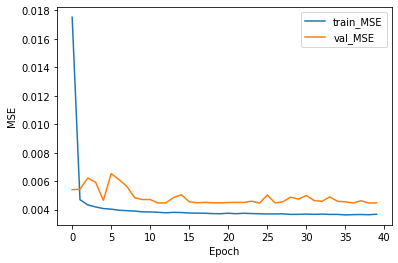

In [50]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MAE')

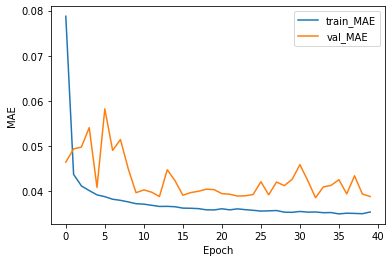

In [51]:
plt.plot(history.history['mae'], label='train_MAE')
plt.plot(history.history['val_mae'], label = 'val_MAE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MAE')

#### Pasamos de un val MSE de 0.0334 y un val MAE de 0.0431 del modelo 26 a un  val MSE de 0.0045  y un val MAE de 0.0385

### Modelo 27. Tomamos datos cada 5 minutos de TRES horas antes y predecimos a 15 minutos, utilizando RADIACIÓN GLOBAL y el resto de datos atmosféricos y la fórmula 2 de neuronas . Introducimos estos datos en la capa que concatena. Introducimos datos de producción de 30 minutos antes en la entrada.

In [524]:
X_train1=np.array(PVGISdf.iloc[1:len(PVGISdf)-38:3,7]) #Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=np.array(PVGISdf.iloc[2:len(PVGISdf)-37:3,7]) #Tengo datos de radiación de 13:20-16:15 e introduzco producción a las 15:30.
X_train3=np.array(PVGISdf.iloc[3:len(PVGISdf)-36:3,7]) #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=np.array(PVGISdf.iloc[4:len(PVGISdf)-35:3,7])
X_train5=np.array(PVGISdf.iloc[5:len(PVGISdf)-34:3,7])
X_train6=np.array(PVGISdf.iloc[6:len(PVGISdf)-33:3,7])
X_train7=np.array(PVGISdf.iloc[7:len(PVGISdf)-32:3,7]) 
X_train8=np.array(PVGISdf.iloc[8:len(PVGISdf)-31:3,7])
X_train9=np.array(PVGISdf.iloc[9:len(PVGISdf)-30:3,7]) 
X_train10=np.array(PVGISdf.iloc[10:len(PVGISdf)-29:3,7])
X_train11=np.array(PVGISdf.iloc[11:len(PVGISdf)-28:3,7])
X_train12=np.array(PVGISdf.iloc[12:len(PVGISdf)-27:3,7]) #Tomo datos hasta las 22:30 del 16/12/2018 para que mi última predicción sea la de las 22:45
X_train13=np.array(PVGISdf.iloc[13:len(PVGISdf)-26:3,7])  
X_train14=np.array(PVGISdf.iloc[14:len(PVGISdf)-25:3,7]) 
X_train15=np.array(PVGISdf.iloc[15:len(PVGISdf)-24:3,7]) 
X_train16=np.array(PVGISdf.iloc[16:len(PVGISdf)-23:3,7])
X_train17=np.array(PVGISdf.iloc[17:len(PVGISdf)-22:3,7])
X_train18=np.array(PVGISdf.iloc[18:len(PVGISdf)-21:3,7])
X_train19=np.array(PVGISdf.iloc[19:len(PVGISdf)-20:3,7])  
X_train20=np.array(PVGISdf.iloc[20:len(PVGISdf)-19:3,7]) 
X_train21=np.array(PVGISdf.iloc[21:len(PVGISdf)-18:3,7]) 
X_train22=np.array(PVGISdf.iloc[22:len(PVGISdf)-17:3,7])
X_train23=np.array(PVGISdf.iloc[23:len(PVGISdf)-16:3,7])
X_train24=np.array(PVGISdf.iloc[24:len(PVGISdf)-15:3,7])
X_train25=np.array(PVGISdf.iloc[25:len(PVGISdf)-14:3,7])  
X_train26=np.array(PVGISdf.iloc[26:len(PVGISdf)-13:3,7]) 
X_train27=np.array(PVGISdf.iloc[27:len(PVGISdf)-12:3,7]) 
X_train28=np.array(PVGISdf.iloc[28:len(PVGISdf)-11:3,7])
X_train29=np.array(PVGISdf.iloc[29:len(PVGISdf)-10:3,7])
X_train30=np.array(PVGISdf.iloc[30:len(PVGISdf)-9:3,7])
X_train31=np.array(PVGISdf.iloc[31:len(PVGISdf)-8:3,7])  
X_train32=np.array(PVGISdf.iloc[32:len(PVGISdf)-7:3,7]) 
X_train33=np.array(PVGISdf.iloc[33:len(PVGISdf)-6:3,7]) 
X_train34=np.array(PVGISdf.iloc[34:len(PVGISdf)-5:3,7])
X_train35=np.array(PVGISdf.iloc[35:len(PVGISdf)-4:3,7])
X_train36=np.array(PVGISdf.iloc[36:len(PVGISdf)-3:3,7])

X_trainatm1=np.array(PVGISdf.iloc[1:len(PVGISdf)-38:3,4:6])  
X_trainatm2=np.array(PVGISdf.iloc[2:len(PVGISdf)-37:3,4:6]) 
X_trainatm3=np.array(PVGISdf.iloc[3:len(PVGISdf)-36:3,4:6]) 
X_trainatm4=np.array(PVGISdf.iloc[4:len(PVGISdf)-35:3,4:6])
X_trainatm5=np.array(PVGISdf.iloc[5:len(PVGISdf)-34:3,4:6])
X_trainatm6=np.array(PVGISdf.iloc[6:len(PVGISdf)-33:3,4:6])
X_trainatm7=np.array(PVGISdf.iloc[7:len(PVGISdf)-32:3,4:6]) 
X_trainatm8=np.array(PVGISdf.iloc[8:len(PVGISdf)-31:3,4:6])
X_trainatm9=np.array(PVGISdf.iloc[9:len(PVGISdf)-30:3,4:6]) 
X_trainatm10=np.array(PVGISdf.iloc[10:len(PVGISdf)-29:3,4:6])
X_trainatm11=np.array(PVGISdf.iloc[11:len(PVGISdf)-28:3,4:6])
X_trainatm12=np.array(PVGISdf.iloc[12:len(PVGISdf)-27:3,4:6])
X_trainatm13=np.array(PVGISdf.iloc[13:len(PVGISdf)-26:3,4:6])  
X_trainatm14=np.array(PVGISdf.iloc[14:len(PVGISdf)-25:3,4:6]) 
X_trainatm15=np.array(PVGISdf.iloc[15:len(PVGISdf)-24:3,4:6]) 
X_trainatm16=np.array(PVGISdf.iloc[16:len(PVGISdf)-23:3,4:6])
X_trainatm17=np.array(PVGISdf.iloc[17:len(PVGISdf)-22:3,4:6])
X_trainatm18=np.array(PVGISdf.iloc[18:len(PVGISdf)-21:3,4:6])
X_trainatm19=np.array(PVGISdf.iloc[19:len(PVGISdf)-20:3,4:6])  
X_trainatm20=np.array(PVGISdf.iloc[20:len(PVGISdf)-19:3,4:6]) 
X_trainatm21=np.array(PVGISdf.iloc[21:len(PVGISdf)-18:3,4:6]) 
X_trainatm22=np.array(PVGISdf.iloc[22:len(PVGISdf)-17:3,4:6])
X_trainatm23=np.array(PVGISdf.iloc[23:len(PVGISdf)-16:3,4:6])
X_trainatm24=np.array(PVGISdf.iloc[24:len(PVGISdf)-15:3,4:6])
X_trainatm25=np.array(PVGISdf.iloc[25:len(PVGISdf)-14:3,4:6])  
X_trainatm26=np.array(PVGISdf.iloc[26:len(PVGISdf)-13:3,4:6]) 
X_trainatm27=np.array(PVGISdf.iloc[27:len(PVGISdf)-12:3,4:6]) 
X_trainatm28=np.array(PVGISdf.iloc[28:len(PVGISdf)-11:3,4:6])
X_trainatm29=np.array(PVGISdf.iloc[29:len(PVGISdf)-10:3,4:6])
X_trainatm30=np.array(PVGISdf.iloc[30:len(PVGISdf)-9:3,4:6])
X_trainatm31=np.array(PVGISdf.iloc[31:len(PVGISdf)-8:3,4:6])  
X_trainatm32=np.array(PVGISdf.iloc[32:len(PVGISdf)-7:3,4:6]) 
X_trainatm33=np.array(PVGISdf.iloc[33:len(PVGISdf)-6:3,4:6]) 
X_trainatm34=np.array(PVGISdf.iloc[34:len(PVGISdf)-5:3,4:6])
X_trainatm35=np.array(PVGISdf.iloc[35:len(PVGISdf)-4:3,4:6])
X_trainatm36=np.array(PVGISdf.iloc[36:len(PVGISdf)-3:3,4:6])

X_prod1=np.array(PVOutputdf.iloc[12:len(PVOutputdf)-1,1]).astype(float) #Producción 15 minutos antes
X_prod2=np.array(PVOutputdf.iloc[11:len(PVOutputdf)-2,1]).astype(float) #Producción 30 minutos antes

y_train=np.array(PVOutputdf.iloc[13:len(PVOutputdf),1]).astype(float) #No tomo los primeros 7 valores para cuadrarlo, que empiece a las 16:30

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 
X_train7std=np.std(X_train7) 
X_train8std=np.std(X_train8)
X_train9std=np.std(X_train9)
X_train10std=np.std(X_train10) 
X_train11std=np.std(X_train11) 
X_train12std=np.std(X_train12)
X_train13std=np.std(X_train13) 
X_train14std=np.std(X_train14) 
X_train15std=np.std(X_train15)
X_train16std=np.std(X_train16)
X_train17std=np.std(X_train17) 
X_train18std=np.std(X_train18)
X_train19std=np.std(X_train19) 
X_train20std=np.std(X_train20) 
X_train21std=np.std(X_train21)
X_train22std=np.std(X_train22)
X_train23std=np.std(X_train23) 
X_train24std=np.std(X_train24)
X_train25std=np.std(X_train25) 
X_train26std=np.std(X_train26) 
X_train27std=np.std(X_train27)
X_train28std=np.std(X_train28)
X_train29std=np.std(X_train29) 
X_train30std=np.std(X_train30)
X_train31std=np.std(X_train31) 
X_train32std=np.std(X_train32) 
X_train33std=np.std(X_train33)
X_train34std=np.std(X_train34)
X_train35std=np.std(X_train35) 
X_train36std=np.std(X_train36) 


X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 
X_train7est=X_train7/X_train7std 
X_train8est=X_train8/X_train8std
X_train9est=X_train9/X_train9std 
X_train10est=X_train10/X_train10std 
X_train11est=X_train11/X_train11std 
X_train12est=X_train12/X_train12std
X_train13est=X_train13/X_train13std 
X_train14est=X_train14/X_train14std
X_train15est=X_train15/X_train15std 
X_train16est=X_train16/X_train16std 
X_train17est=X_train17/X_train17std 
X_train18est=X_train18/X_train18std
X_train19est=X_train19/X_train19std 
X_train20est=X_train20/X_train20std
X_train21est=X_train21/X_train21std 
X_train22est=X_train22/X_train22std 
X_train23est=X_train23/X_train23std 
X_train24est=X_train24/X_train24std
X_train25est=X_train25/X_train25std 
X_train26est=X_train26/X_train26std
X_train27est=X_train27/X_train27std 
X_train28est=X_train28/X_train28std 
X_train29est=X_train29/X_train29std 
X_train30est=X_train30/X_train30std
X_train31est=X_train31/X_train31std 
X_train32est=X_train32/X_train32std
X_train33est=X_train33/X_train33std 
X_train34est=X_train34/X_train34std 
X_train35est=X_train35/X_train35std 
X_train36est=X_train36/X_train36std

X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est,X_train7est,X_train8est,X_train9est,X_train10est,X_train11est,X_train12est,X_train13est,X_train14est,X_train15est,X_train16est,X_train17est,X_train18est,X_train19est,X_train20est,X_train21est,X_train22est,X_train23est,X_train24est,X_train25est,X_train26est,X_train27est,X_train28est,X_train29est,X_train30est,X_train31est,X_train32est,X_train33est,X_train34est,X_train35est,X_train36est)

X_trainatm1std=np.std(X_trainatm1)  
X_trainatm2std=np.std(X_trainatm2) 
X_trainatm3std=np.std(X_trainatm3) 
X_trainatm4std=np.std(X_trainatm4)
X_trainatm5std=np.std(X_trainatm5)
X_trainatm6std=np.std(X_trainatm6)
X_trainatm7std=np.std(X_trainatm7)
X_trainatm8std=np.std(X_trainatm8)
X_trainatm9std=np.std(X_trainatm9) 
X_trainatm10std=np.std(X_trainatm10)
X_trainatm11std=np.std(X_trainatm11)
X_trainatm12std=np.std(X_trainatm12)
X_trainatm13std=np.std(X_trainatm13)
X_trainatm14std=np.std(X_trainatm14)
X_trainatm15std=np.std(X_trainatm15) 
X_trainatm16std=np.std(X_trainatm16)
X_trainatm17std=np.std(X_trainatm17)
X_trainatm18std=np.std(X_trainatm18)
X_trainatm19std=np.std(X_trainatm19)
X_trainatm20std=np.std(X_trainatm20)
X_trainatm21std=np.std(X_trainatm21) 
X_trainatm22std=np.std(X_trainatm22)
X_trainatm23std=np.std(X_trainatm23)
X_trainatm24std=np.std(X_trainatm24)
X_trainatm25std=np.std(X_trainatm25)
X_trainatm26std=np.std(X_trainatm26)
X_trainatm27std=np.std(X_trainatm27) 
X_trainatm28std=np.std(X_trainatm28)
X_trainatm29std=np.std(X_trainatm29)
X_trainatm30std=np.std(X_trainatm30)
X_trainatm31std=np.std(X_trainatm31)
X_trainatm32std=np.std(X_trainatm32)
X_trainatm33std=np.std(X_trainatm33) 
X_trainatm34std=np.std(X_trainatm34)
X_trainatm35std=np.std(X_trainatm35)
X_trainatm36std=np.std(X_trainatm36)

X_trainatm1est=X_trainatm1/X_trainatm1std 
X_trainatm2est=X_trainatm2/X_trainatm2std 
X_trainatm3est=X_trainatm3/X_trainatm3std 
X_trainatm4est=X_trainatm4/X_trainatm4std
X_trainatm5est=X_trainatm5/X_trainatm5std 
X_trainatm6est=X_trainatm6/X_trainatm6std 
X_trainatm7est=X_trainatm7/X_trainatm7std 
X_trainatm8est=X_trainatm8/X_trainatm8std
X_trainatm9est=X_trainatm9/X_trainatm9std 
X_trainatm10est=X_trainatm10/X_trainatm10std 
X_trainatm11est=X_trainatm11/X_trainatm11std 
X_trainatm12est=X_trainatm12/X_trainatm12std
X_trainatm13est=X_trainatm13/X_trainatm13std 
X_trainatm14est=X_trainatm14/X_trainatm14std 
X_trainatm15est=X_trainatm15/X_trainatm15std
X_trainatm16est=X_trainatm16/X_trainatm16std 
X_trainatm17est=X_trainatm17/X_trainatm17std 
X_trainatm18est=X_trainatm18/X_trainatm18std
X_trainatm19est=X_trainatm19/X_trainatm19std 
X_trainatm20est=X_trainatm20/X_trainatm20std 
X_trainatm21est=X_trainatm21/X_trainatm21std
X_trainatm22est=X_trainatm22/X_trainatm22std 
X_trainatm23est=X_trainatm23/X_trainatm23std 
X_trainatm24est=X_trainatm24/X_trainatm24std
X_trainatm25est=X_trainatm25/X_trainatm25std 
X_trainatm26est=X_trainatm26/X_trainatm26std 
X_trainatm27est=X_trainatm27/X_trainatm27std
X_trainatm28est=X_trainatm28/X_trainatm28std 
X_trainatm29est=X_trainatm29/X_trainatm29std 
X_trainatm30est=X_trainatm30/X_trainatm30std
X_trainatm31est=X_trainatm31/X_trainatm31std 
X_trainatm32est=X_trainatm32/X_trainatm32std 
X_trainatm33est=X_trainatm33/X_trainatm33std
X_trainatm34est=X_trainatm34/X_trainatm34std 
X_trainatm35est=X_trainatm35/X_trainatm35std 
X_trainatm36est=X_trainatm36/X_trainatm36std

X_trainatmest=(X_trainatm1est,X_trainatm2est,X_trainatm3est,X_trainatm4est,X_trainatm5est,X_trainatm6est,X_trainatm7est,X_trainatm8est,X_trainatm9est,X_trainatm10est,X_trainatm11est,X_trainatm12est,X_trainatm13est,X_trainatm14est,X_trainatm15est,X_trainatm16est,X_trainatm17est,X_trainatm18est,X_trainatm19est,X_trainatm20est,X_trainatm21est,X_trainatm22est,X_trainatm23est,X_trainatm24est,X_trainatm25est,X_trainatm26est,X_trainatm27est,X_trainatm28est,X_trainatm29est,X_trainatm30est,X_trainatm31est,X_trainatm32est,X_trainatm33est,X_trainatm34est,X_trainatm35est,X_trainatm36est)

X_prod1std=np.std(X_prod1)
X_prod1est=X_prod1/X_prod1std 

X_prod2std=np.std(X_prod2)
X_prod2est=X_prod2/X_prod2std 
X_prodest=(X_prod1est,X_prod2est)

Y_trainstd=np.std(y_train) 
Y_trainest=y_train/Y_trainstd 

In [525]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=1) 
entrada2 = tf.keras.layers.Input(shape=1)
entrada3 = tf.keras.layers.Input(shape=1)
entrada4 = tf.keras.layers.Input(shape=1)
entrada5 = tf.keras.layers.Input(shape=1)
entrada6 = tf.keras.layers.Input(shape=1)
entrada7 = tf.keras.layers.Input(shape=1)
entrada8 = tf.keras.layers.Input(shape=1)
entrada9 = tf.keras.layers.Input(shape=1)
entrada10 = tf.keras.layers.Input(shape=1)
entrada11 = tf.keras.layers.Input(shape=1)
entrada12 = tf.keras.layers.Input(shape=1)
entrada13 = tf.keras.layers.Input(shape=1)
entrada14 = tf.keras.layers.Input(shape=1)
entrada15 = tf.keras.layers.Input(shape=1)
entrada16 = tf.keras.layers.Input(shape=1)
entrada17 = tf.keras.layers.Input(shape=1)
entrada18 = tf.keras.layers.Input(shape=1)
entrada19 = tf.keras.layers.Input(shape=1)
entrada20 = tf.keras.layers.Input(shape=1)
entrada21 = tf.keras.layers.Input(shape=1)
entrada22 = tf.keras.layers.Input(shape=1)
entrada23 = tf.keras.layers.Input(shape=1)
entrada24 = tf.keras.layers.Input(shape=1)
entrada25 = tf.keras.layers.Input(shape=1)
entrada26 = tf.keras.layers.Input(shape=1)
entrada27 = tf.keras.layers.Input(shape=1)
entrada28 = tf.keras.layers.Input(shape=1)
entrada29 = tf.keras.layers.Input(shape=1)
entrada30 = tf.keras.layers.Input(shape=1)
entrada31 = tf.keras.layers.Input(shape=1)
entrada32 = tf.keras.layers.Input(shape=1)
entrada33 = tf.keras.layers.Input(shape=1)
entrada34 = tf.keras.layers.Input(shape=1)
entrada35 = tf.keras.layers.Input(shape=1)
entrada36 = tf.keras.layers.Input(shape=1)

entradaatm1 = tf.keras.layers.Input(shape=2) 
entradaatm2 = tf.keras.layers.Input(shape=2)
entradaatm3 = tf.keras.layers.Input(shape=2)
entradaatm4 = tf.keras.layers.Input(shape=2)
entradaatm5 = tf.keras.layers.Input(shape=2)
entradaatm6 = tf.keras.layers.Input(shape=2)
entradaatm7 = tf.keras.layers.Input(shape=2)
entradaatm8 = tf.keras.layers.Input(shape=2)
entradaatm9 = tf.keras.layers.Input(shape=2)
entradaatm10 = tf.keras.layers.Input(shape=2)
entradaatm11 = tf.keras.layers.Input(shape=2)
entradaatm12 = tf.keras.layers.Input(shape=2)
entradaatm13 = tf.keras.layers.Input(shape=2)
entradaatm14 = tf.keras.layers.Input(shape=2)
entradaatm15 = tf.keras.layers.Input(shape=2) 
entradaatm16 = tf.keras.layers.Input(shape=2)
entradaatm17 = tf.keras.layers.Input(shape=2)
entradaatm18 = tf.keras.layers.Input(shape=2)
entradaatm19 = tf.keras.layers.Input(shape=2)
entradaatm20 = tf.keras.layers.Input(shape=2)
entradaatm21 = tf.keras.layers.Input(shape=2) 
entradaatm22 = tf.keras.layers.Input(shape=2)
entradaatm23 = tf.keras.layers.Input(shape=2)
entradaatm24 = tf.keras.layers.Input(shape=2)
entradaatm25 = tf.keras.layers.Input(shape=2)
entradaatm26 = tf.keras.layers.Input(shape=2)
entradaatm27 = tf.keras.layers.Input(shape=2) 
entradaatm28 = tf.keras.layers.Input(shape=2)
entradaatm29 = tf.keras.layers.Input(shape=2)
entradaatm30 = tf.keras.layers.Input(shape=2)
entradaatm31 = tf.keras.layers.Input(shape=2)
entradaatm32 = tf.keras.layers.Input(shape=2)
entradaatm33 = tf.keras.layers.Input(shape=2) 
entradaatm34 = tf.keras.layers.Input(shape=2)
entradaatm35 = tf.keras.layers.Input(shape=2)
entradaatm36 = tf.keras.layers.Input(shape=2)

entradaprod1=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat
entradaprod2=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat


#Capas ocultas formula 2: Hidden =3/2*(In + Out)=3/2*(3+1)=6
oculta1 = tf.keras.layers.Dense(6, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(6, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(6, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(6, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(6, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(6, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(6, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(6, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(6, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(6, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(6, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(6, activation="relu")(entrada12)
oculta13 = tf.keras.layers.Dense(6, activation="relu")(entrada13)
oculta14 = tf.keras.layers.Dense(6, activation="relu")(entrada14)
oculta15 = tf.keras.layers.Dense(6, activation="relu")(entrada15)
oculta16 = tf.keras.layers.Dense(6, activation="relu")(entrada16)
oculta17 = tf.keras.layers.Dense(6, activation="relu")(entrada17)
oculta18 = tf.keras.layers.Dense(6, activation="relu")(entrada18)
oculta19 = tf.keras.layers.Dense(6, activation="relu")(entrada19)
oculta20 = tf.keras.layers.Dense(6, activation="relu")(entrada20)
oculta21 = tf.keras.layers.Dense(6, activation="relu")(entrada21)
oculta22 = tf.keras.layers.Dense(6, activation="relu")(entrada22)
oculta23 = tf.keras.layers.Dense(6, activation="relu")(entrada23)
oculta24 = tf.keras.layers.Dense(6, activation="relu")(entrada24)
oculta25 = tf.keras.layers.Dense(6, activation="relu")(entrada25)
oculta26 = tf.keras.layers.Dense(6, activation="relu")(entrada26)
oculta27 = tf.keras.layers.Dense(6, activation="relu")(entrada27)
oculta28 = tf.keras.layers.Dense(6, activation="relu")(entrada28)
oculta29 = tf.keras.layers.Dense(6, activation="relu")(entrada29)
oculta30 = tf.keras.layers.Dense(6, activation="relu")(entrada30)
oculta31 = tf.keras.layers.Dense(6, activation="relu")(entrada31)
oculta32 = tf.keras.layers.Dense(6, activation="relu")(entrada32)
oculta33 = tf.keras.layers.Dense(6, activation="relu")(entrada33)
oculta34 = tf.keras.layers.Dense(6, activation="relu")(entrada34)
oculta35 = tf.keras.layers.Dense(6, activation="relu")(entrada35)
oculta36 = tf.keras.layers.Dense(6, activation="relu")(entrada36)


concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12, oculta13, oculta14, oculta15, oculta16, oculta17, oculta18, oculta19, oculta20, oculta21, oculta22, oculta23, oculta24, oculta25, oculta26, oculta27, oculta28, oculta29, oculta30, oculta31, oculta32, oculta33, oculta34, oculta35, oculta36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod1,entradaprod2]) #estratificada, concatena las 12
#2 layers intermedias, formula 2: Hidden =3/2*(In + Out)=3/2*(1+1)=3
adoculta1=tf.keras.layers.Dense(3, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(3, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(3, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo27 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12, entrada13, entrada14, entrada15, entrada16, entrada17, entrada18, entrada19, entrada20, entrada21, entrada22, entrada23, entrada24, entrada25, entrada26, entrada27, entrada28, entrada29, entrada30, entrada31, entrada32, entrada33, entrada34, entrada35, entrada36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod1,entradaprod2], outputs=[salida])

modelo27.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo27.fit([X_trainest,X_trainatmest,X_prodest], Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2)
#Mucho mejor resultado introduciendo entre corchetes que entre paréntesis (X_trainest,X_trainatmest)
#No estoy 100% seguro de que esté bien introducido así, cómo sabe que las entradai corresponden a X_train y que entradaatmi corresponden a X_trainatm?

Epoch 1/1000
3308/3308 [==============================] - 22s 6ms/step - loss: 0.1329 - mae: 0.1604 - val_loss: 0.0542 - val_mae: 0.0782
Epoch 2/1000
3308/3308 [==============================] - 19s 6ms/step - loss: 0.0449 - mae: 0.0680 - val_loss: 0.0473 - val_mae: 0.0705
Epoch 3/1000
3308/3308 [==============================] - 20s 6ms/step - loss: 0.0405 - mae: 0.0581 - val_loss: 0.0477 - val_mae: 0.0555
Epoch 4/1000
3308/3308 [==============================] - 19s 6ms/step - loss: 0.0390 - mae: 0.0549 - val_loss: 0.0432 - val_mae: 0.0501
Epoch 5/1000
3308/3308 [==============================] - 19s 6ms/step - loss: 0.0379 - mae: 0.0525 - val_loss: 0.0445 - val_mae: 0.0488
Epoch 6/1000
3308/3308 [==============================] - 20s 6ms/step - loss: 0.0372 - mae: 0.0511 - val_loss: 0.0429 - val_mae: 0.0476
Epoch 7/1000
3308/3308 [==============================] - 19s 6ms/step - loss: 0.0367 - mae: 0.0497 - val_loss: 0.0412 - val_mae: 0.0540
Epoch 8/1000
3308/3308 [=================

Text(0, 0.5, 'MSE')

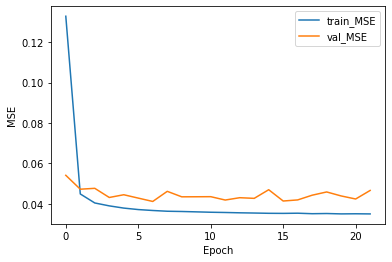

In [526]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un train MSE de 0.0367 y un val MSE de 0.0412  en 7 épocas. Como era de esperar el error aumenta , probamos la radiación global sin capa estratificada en el siguiente modelo.

### Modelo 28. Tomamos datos cada 5 minutos de TRES horas antes y predecimos a 15 minutos, utilizando RADIACIÓN GLOBAL sin capa estratificada, el resto de datos atmosféricos y la fórmula 2 de neuronas . Introducimos estos datos en la capa que concatena. Introducimos datos de producción de 30 minutos antes en la entrada.

In [527]:
X_train1=np.array(PVGISdf.iloc[1:len(PVGISdf)-38:3,7]) #Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=np.array(PVGISdf.iloc[2:len(PVGISdf)-37:3,7]) #Tengo datos de radiación de 13:20-16:15 e introduzco producción a las 15:30.
X_train3=np.array(PVGISdf.iloc[3:len(PVGISdf)-36:3,7]) #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=np.array(PVGISdf.iloc[4:len(PVGISdf)-35:3,7])
X_train5=np.array(PVGISdf.iloc[5:len(PVGISdf)-34:3,7])
X_train6=np.array(PVGISdf.iloc[6:len(PVGISdf)-33:3,7])
X_train7=np.array(PVGISdf.iloc[7:len(PVGISdf)-32:3,7]) 
X_train8=np.array(PVGISdf.iloc[8:len(PVGISdf)-31:3,7])
X_train9=np.array(PVGISdf.iloc[9:len(PVGISdf)-30:3,7]) 
X_train10=np.array(PVGISdf.iloc[10:len(PVGISdf)-29:3,7])
X_train11=np.array(PVGISdf.iloc[11:len(PVGISdf)-28:3,7])
X_train12=np.array(PVGISdf.iloc[12:len(PVGISdf)-27:3,7]) #Tomo datos hasta las 22:30 del 16/12/2018 para que mi última predicción sea la de las 22:45
X_train13=np.array(PVGISdf.iloc[13:len(PVGISdf)-26:3,7])  
X_train14=np.array(PVGISdf.iloc[14:len(PVGISdf)-25:3,7]) 
X_train15=np.array(PVGISdf.iloc[15:len(PVGISdf)-24:3,7]) 
X_train16=np.array(PVGISdf.iloc[16:len(PVGISdf)-23:3,7])
X_train17=np.array(PVGISdf.iloc[17:len(PVGISdf)-22:3,7])
X_train18=np.array(PVGISdf.iloc[18:len(PVGISdf)-21:3,7])
X_train19=np.array(PVGISdf.iloc[19:len(PVGISdf)-20:3,7])  
X_train20=np.array(PVGISdf.iloc[20:len(PVGISdf)-19:3,7]) 
X_train21=np.array(PVGISdf.iloc[21:len(PVGISdf)-18:3,7]) 
X_train22=np.array(PVGISdf.iloc[22:len(PVGISdf)-17:3,7])
X_train23=np.array(PVGISdf.iloc[23:len(PVGISdf)-16:3,7])
X_train24=np.array(PVGISdf.iloc[24:len(PVGISdf)-15:3,7])
X_train25=np.array(PVGISdf.iloc[25:len(PVGISdf)-14:3,7])  
X_train26=np.array(PVGISdf.iloc[26:len(PVGISdf)-13:3,7]) 
X_train27=np.array(PVGISdf.iloc[27:len(PVGISdf)-12:3,7]) 
X_train28=np.array(PVGISdf.iloc[28:len(PVGISdf)-11:3,7])
X_train29=np.array(PVGISdf.iloc[29:len(PVGISdf)-10:3,7])
X_train30=np.array(PVGISdf.iloc[30:len(PVGISdf)-9:3,7])
X_train31=np.array(PVGISdf.iloc[31:len(PVGISdf)-8:3,7])  
X_train32=np.array(PVGISdf.iloc[32:len(PVGISdf)-7:3,7]) 
X_train33=np.array(PVGISdf.iloc[33:len(PVGISdf)-6:3,7]) 
X_train34=np.array(PVGISdf.iloc[34:len(PVGISdf)-5:3,7])
X_train35=np.array(PVGISdf.iloc[35:len(PVGISdf)-4:3,7])
X_train36=np.array(PVGISdf.iloc[36:len(PVGISdf)-3:3,7])

X_trainatm1=np.array(PVGISdf.iloc[1:len(PVGISdf)-38:3,4:6])  
X_trainatm2=np.array(PVGISdf.iloc[2:len(PVGISdf)-37:3,4:6]) 
X_trainatm3=np.array(PVGISdf.iloc[3:len(PVGISdf)-36:3,4:6]) 
X_trainatm4=np.array(PVGISdf.iloc[4:len(PVGISdf)-35:3,4:6])
X_trainatm5=np.array(PVGISdf.iloc[5:len(PVGISdf)-34:3,4:6])
X_trainatm6=np.array(PVGISdf.iloc[6:len(PVGISdf)-33:3,4:6])
X_trainatm7=np.array(PVGISdf.iloc[7:len(PVGISdf)-32:3,4:6]) 
X_trainatm8=np.array(PVGISdf.iloc[8:len(PVGISdf)-31:3,4:6])
X_trainatm9=np.array(PVGISdf.iloc[9:len(PVGISdf)-30:3,4:6]) 
X_trainatm10=np.array(PVGISdf.iloc[10:len(PVGISdf)-29:3,4:6])
X_trainatm11=np.array(PVGISdf.iloc[11:len(PVGISdf)-28:3,4:6])
X_trainatm12=np.array(PVGISdf.iloc[12:len(PVGISdf)-27:3,4:6])
X_trainatm13=np.array(PVGISdf.iloc[13:len(PVGISdf)-26:3,4:6])  
X_trainatm14=np.array(PVGISdf.iloc[14:len(PVGISdf)-25:3,4:6]) 
X_trainatm15=np.array(PVGISdf.iloc[15:len(PVGISdf)-24:3,4:6]) 
X_trainatm16=np.array(PVGISdf.iloc[16:len(PVGISdf)-23:3,4:6])
X_trainatm17=np.array(PVGISdf.iloc[17:len(PVGISdf)-22:3,4:6])
X_trainatm18=np.array(PVGISdf.iloc[18:len(PVGISdf)-21:3,4:6])
X_trainatm19=np.array(PVGISdf.iloc[19:len(PVGISdf)-20:3,4:6])  
X_trainatm20=np.array(PVGISdf.iloc[20:len(PVGISdf)-19:3,4:6]) 
X_trainatm21=np.array(PVGISdf.iloc[21:len(PVGISdf)-18:3,4:6]) 
X_trainatm22=np.array(PVGISdf.iloc[22:len(PVGISdf)-17:3,4:6])
X_trainatm23=np.array(PVGISdf.iloc[23:len(PVGISdf)-16:3,4:6])
X_trainatm24=np.array(PVGISdf.iloc[24:len(PVGISdf)-15:3,4:6])
X_trainatm25=np.array(PVGISdf.iloc[25:len(PVGISdf)-14:3,4:6])  
X_trainatm26=np.array(PVGISdf.iloc[26:len(PVGISdf)-13:3,4:6]) 
X_trainatm27=np.array(PVGISdf.iloc[27:len(PVGISdf)-12:3,4:6]) 
X_trainatm28=np.array(PVGISdf.iloc[28:len(PVGISdf)-11:3,4:6])
X_trainatm29=np.array(PVGISdf.iloc[29:len(PVGISdf)-10:3,4:6])
X_trainatm30=np.array(PVGISdf.iloc[30:len(PVGISdf)-9:3,4:6])
X_trainatm31=np.array(PVGISdf.iloc[31:len(PVGISdf)-8:3,4:6])  
X_trainatm32=np.array(PVGISdf.iloc[32:len(PVGISdf)-7:3,4:6]) 
X_trainatm33=np.array(PVGISdf.iloc[33:len(PVGISdf)-6:3,4:6]) 
X_trainatm34=np.array(PVGISdf.iloc[34:len(PVGISdf)-5:3,4:6])
X_trainatm35=np.array(PVGISdf.iloc[35:len(PVGISdf)-4:3,4:6])
X_trainatm36=np.array(PVGISdf.iloc[36:len(PVGISdf)-3:3,4:6])

X_prod1=np.array(PVOutputdf.iloc[12:len(PVOutputdf)-1,1]).astype(float) #Producción 15 minutos antes
X_prod2=np.array(PVOutputdf.iloc[11:len(PVOutputdf)-2,1]).astype(float) #Producción 30 minutos antes

y_train=np.array(PVOutputdf.iloc[13:len(PVOutputdf),1]).astype(float) #No tomo los primeros 7 valores para cuadrarlo, que empiece a las 16:30

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 
X_train7std=np.std(X_train7) 
X_train8std=np.std(X_train8)
X_train9std=np.std(X_train9)
X_train10std=np.std(X_train10) 
X_train11std=np.std(X_train11) 
X_train12std=np.std(X_train12)
X_train13std=np.std(X_train13) 
X_train14std=np.std(X_train14) 
X_train15std=np.std(X_train15)
X_train16std=np.std(X_train16)
X_train17std=np.std(X_train17) 
X_train18std=np.std(X_train18)
X_train19std=np.std(X_train19) 
X_train20std=np.std(X_train20) 
X_train21std=np.std(X_train21)
X_train22std=np.std(X_train22)
X_train23std=np.std(X_train23) 
X_train24std=np.std(X_train24)
X_train25std=np.std(X_train25) 
X_train26std=np.std(X_train26) 
X_train27std=np.std(X_train27)
X_train28std=np.std(X_train28)
X_train29std=np.std(X_train29) 
X_train30std=np.std(X_train30)
X_train31std=np.std(X_train31) 
X_train32std=np.std(X_train32) 
X_train33std=np.std(X_train33)
X_train34std=np.std(X_train34)
X_train35std=np.std(X_train35) 
X_train36std=np.std(X_train36) 


X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 
X_train7est=X_train7/X_train7std 
X_train8est=X_train8/X_train8std
X_train9est=X_train9/X_train9std 
X_train10est=X_train10/X_train10std 
X_train11est=X_train11/X_train11std 
X_train12est=X_train12/X_train12std
X_train13est=X_train13/X_train13std 
X_train14est=X_train14/X_train14std
X_train15est=X_train15/X_train15std 
X_train16est=X_train16/X_train16std 
X_train17est=X_train17/X_train17std 
X_train18est=X_train18/X_train18std
X_train19est=X_train19/X_train19std 
X_train20est=X_train20/X_train20std
X_train21est=X_train21/X_train21std 
X_train22est=X_train22/X_train22std 
X_train23est=X_train23/X_train23std 
X_train24est=X_train24/X_train24std
X_train25est=X_train25/X_train25std 
X_train26est=X_train26/X_train26std
X_train27est=X_train27/X_train27std 
X_train28est=X_train28/X_train28std 
X_train29est=X_train29/X_train29std 
X_train30est=X_train30/X_train30std
X_train31est=X_train31/X_train31std 
X_train32est=X_train32/X_train32std
X_train33est=X_train33/X_train33std 
X_train34est=X_train34/X_train34std 
X_train35est=X_train35/X_train35std 
X_train36est=X_train36/X_train36std

X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est,X_train7est,X_train8est,X_train9est,X_train10est,X_train11est,X_train12est,X_train13est,X_train14est,X_train15est,X_train16est,X_train17est,X_train18est,X_train19est,X_train20est,X_train21est,X_train22est,X_train23est,X_train24est,X_train25est,X_train26est,X_train27est,X_train28est,X_train29est,X_train30est,X_train31est,X_train32est,X_train33est,X_train34est,X_train35est,X_train36est)

X_trainatm1std=np.std(X_trainatm1)  
X_trainatm2std=np.std(X_trainatm2) 
X_trainatm3std=np.std(X_trainatm3) 
X_trainatm4std=np.std(X_trainatm4)
X_trainatm5std=np.std(X_trainatm5)
X_trainatm6std=np.std(X_trainatm6)
X_trainatm7std=np.std(X_trainatm7)
X_trainatm8std=np.std(X_trainatm8)
X_trainatm9std=np.std(X_trainatm9) 
X_trainatm10std=np.std(X_trainatm10)
X_trainatm11std=np.std(X_trainatm11)
X_trainatm12std=np.std(X_trainatm12)
X_trainatm13std=np.std(X_trainatm13)
X_trainatm14std=np.std(X_trainatm14)
X_trainatm15std=np.std(X_trainatm15) 
X_trainatm16std=np.std(X_trainatm16)
X_trainatm17std=np.std(X_trainatm17)
X_trainatm18std=np.std(X_trainatm18)
X_trainatm19std=np.std(X_trainatm19)
X_trainatm20std=np.std(X_trainatm20)
X_trainatm21std=np.std(X_trainatm21) 
X_trainatm22std=np.std(X_trainatm22)
X_trainatm23std=np.std(X_trainatm23)
X_trainatm24std=np.std(X_trainatm24)
X_trainatm25std=np.std(X_trainatm25)
X_trainatm26std=np.std(X_trainatm26)
X_trainatm27std=np.std(X_trainatm27) 
X_trainatm28std=np.std(X_trainatm28)
X_trainatm29std=np.std(X_trainatm29)
X_trainatm30std=np.std(X_trainatm30)
X_trainatm31std=np.std(X_trainatm31)
X_trainatm32std=np.std(X_trainatm32)
X_trainatm33std=np.std(X_trainatm33) 
X_trainatm34std=np.std(X_trainatm34)
X_trainatm35std=np.std(X_trainatm35)
X_trainatm36std=np.std(X_trainatm36)

X_trainatm1est=X_trainatm1/X_trainatm1std 
X_trainatm2est=X_trainatm2/X_trainatm2std 
X_trainatm3est=X_trainatm3/X_trainatm3std 
X_trainatm4est=X_trainatm4/X_trainatm4std
X_trainatm5est=X_trainatm5/X_trainatm5std 
X_trainatm6est=X_trainatm6/X_trainatm6std 
X_trainatm7est=X_trainatm7/X_trainatm7std 
X_trainatm8est=X_trainatm8/X_trainatm8std
X_trainatm9est=X_trainatm9/X_trainatm9std 
X_trainatm10est=X_trainatm10/X_trainatm10std 
X_trainatm11est=X_trainatm11/X_trainatm11std 
X_trainatm12est=X_trainatm12/X_trainatm12std
X_trainatm13est=X_trainatm13/X_trainatm13std 
X_trainatm14est=X_trainatm14/X_trainatm14std 
X_trainatm15est=X_trainatm15/X_trainatm15std
X_trainatm16est=X_trainatm16/X_trainatm16std 
X_trainatm17est=X_trainatm17/X_trainatm17std 
X_trainatm18est=X_trainatm18/X_trainatm18std
X_trainatm19est=X_trainatm19/X_trainatm19std 
X_trainatm20est=X_trainatm20/X_trainatm20std 
X_trainatm21est=X_trainatm21/X_trainatm21std
X_trainatm22est=X_trainatm22/X_trainatm22std 
X_trainatm23est=X_trainatm23/X_trainatm23std 
X_trainatm24est=X_trainatm24/X_trainatm24std
X_trainatm25est=X_trainatm25/X_trainatm25std 
X_trainatm26est=X_trainatm26/X_trainatm26std 
X_trainatm27est=X_trainatm27/X_trainatm27std
X_trainatm28est=X_trainatm28/X_trainatm28std 
X_trainatm29est=X_trainatm29/X_trainatm29std 
X_trainatm30est=X_trainatm30/X_trainatm30std
X_trainatm31est=X_trainatm31/X_trainatm31std 
X_trainatm32est=X_trainatm32/X_trainatm32std 
X_trainatm33est=X_trainatm33/X_trainatm33std
X_trainatm34est=X_trainatm34/X_trainatm34std 
X_trainatm35est=X_trainatm35/X_trainatm35std 
X_trainatm36est=X_trainatm36/X_trainatm36std

X_trainatmest=(X_trainatm1est,X_trainatm2est,X_trainatm3est,X_trainatm4est,X_trainatm5est,X_trainatm6est,X_trainatm7est,X_trainatm8est,X_trainatm9est,X_trainatm10est,X_trainatm11est,X_trainatm12est,X_trainatm13est,X_trainatm14est,X_trainatm15est,X_trainatm16est,X_trainatm17est,X_trainatm18est,X_trainatm19est,X_trainatm20est,X_trainatm21est,X_trainatm22est,X_trainatm23est,X_trainatm24est,X_trainatm25est,X_trainatm26est,X_trainatm27est,X_trainatm28est,X_trainatm29est,X_trainatm30est,X_trainatm31est,X_trainatm32est,X_trainatm33est,X_trainatm34est,X_trainatm35est,X_trainatm36est)

X_prod1std=np.std(X_prod1)
X_prod1est=X_prod1/X_prod1std 

X_prod2std=np.std(X_prod2)
X_prod2est=X_prod2/X_prod2std 
X_prodest=(X_prod1est,X_prod2est)

Y_trainstd=np.std(y_train) 
Y_trainest=y_train/Y_trainstd 

In [528]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=1) 
entrada2 = tf.keras.layers.Input(shape=1)
entrada3 = tf.keras.layers.Input(shape=1)
entrada4 = tf.keras.layers.Input(shape=1)
entrada5 = tf.keras.layers.Input(shape=1)
entrada6 = tf.keras.layers.Input(shape=1)
entrada7 = tf.keras.layers.Input(shape=1)
entrada8 = tf.keras.layers.Input(shape=1)
entrada9 = tf.keras.layers.Input(shape=1)
entrada10 = tf.keras.layers.Input(shape=1)
entrada11 = tf.keras.layers.Input(shape=1)
entrada12 = tf.keras.layers.Input(shape=1)
entrada13 = tf.keras.layers.Input(shape=1)
entrada14 = tf.keras.layers.Input(shape=1)
entrada15 = tf.keras.layers.Input(shape=1)
entrada16 = tf.keras.layers.Input(shape=1)
entrada17 = tf.keras.layers.Input(shape=1)
entrada18 = tf.keras.layers.Input(shape=1)
entrada19 = tf.keras.layers.Input(shape=1)
entrada20 = tf.keras.layers.Input(shape=1)
entrada21 = tf.keras.layers.Input(shape=1)
entrada22 = tf.keras.layers.Input(shape=1)
entrada23 = tf.keras.layers.Input(shape=1)
entrada24 = tf.keras.layers.Input(shape=1)
entrada25 = tf.keras.layers.Input(shape=1)
entrada26 = tf.keras.layers.Input(shape=1)
entrada27 = tf.keras.layers.Input(shape=1)
entrada28 = tf.keras.layers.Input(shape=1)
entrada29 = tf.keras.layers.Input(shape=1)
entrada30 = tf.keras.layers.Input(shape=1)
entrada31 = tf.keras.layers.Input(shape=1)
entrada32 = tf.keras.layers.Input(shape=1)
entrada33 = tf.keras.layers.Input(shape=1)
entrada34 = tf.keras.layers.Input(shape=1)
entrada35 = tf.keras.layers.Input(shape=1)
entrada36 = tf.keras.layers.Input(shape=1)

entradaatm1 = tf.keras.layers.Input(shape=2) 
entradaatm2 = tf.keras.layers.Input(shape=2)
entradaatm3 = tf.keras.layers.Input(shape=2)
entradaatm4 = tf.keras.layers.Input(shape=2)
entradaatm5 = tf.keras.layers.Input(shape=2)
entradaatm6 = tf.keras.layers.Input(shape=2)
entradaatm7 = tf.keras.layers.Input(shape=2)
entradaatm8 = tf.keras.layers.Input(shape=2)
entradaatm9 = tf.keras.layers.Input(shape=2)
entradaatm10 = tf.keras.layers.Input(shape=2)
entradaatm11 = tf.keras.layers.Input(shape=2)
entradaatm12 = tf.keras.layers.Input(shape=2)
entradaatm13 = tf.keras.layers.Input(shape=2)
entradaatm14 = tf.keras.layers.Input(shape=2)
entradaatm15 = tf.keras.layers.Input(shape=2) 
entradaatm16 = tf.keras.layers.Input(shape=2)
entradaatm17 = tf.keras.layers.Input(shape=2)
entradaatm18 = tf.keras.layers.Input(shape=2)
entradaatm19 = tf.keras.layers.Input(shape=2)
entradaatm20 = tf.keras.layers.Input(shape=2)
entradaatm21 = tf.keras.layers.Input(shape=2) 
entradaatm22 = tf.keras.layers.Input(shape=2)
entradaatm23 = tf.keras.layers.Input(shape=2)
entradaatm24 = tf.keras.layers.Input(shape=2)
entradaatm25 = tf.keras.layers.Input(shape=2)
entradaatm26 = tf.keras.layers.Input(shape=2)
entradaatm27 = tf.keras.layers.Input(shape=2) 
entradaatm28 = tf.keras.layers.Input(shape=2)
entradaatm29 = tf.keras.layers.Input(shape=2)
entradaatm30 = tf.keras.layers.Input(shape=2)
entradaatm31 = tf.keras.layers.Input(shape=2)
entradaatm32 = tf.keras.layers.Input(shape=2)
entradaatm33 = tf.keras.layers.Input(shape=2) 
entradaatm34 = tf.keras.layers.Input(shape=2)
entradaatm35 = tf.keras.layers.Input(shape=2)
entradaatm36 = tf.keras.layers.Input(shape=2)

entradaprod1=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat
entradaprod2=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat


concat = tf.keras.layers.Concatenate()([entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12, entrada13, entrada14, entrada15, entrada16, entrada17, entrada18, entrada19, entrada20, entrada21, entrada22, entrada23, entrada24, entrada25, entrada26, entrada27, entrada28, entrada29, entrada30, entrada31, entrada32, entrada33, entrada34, entrada35, entrada36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod1,entradaprod2]) #estratificada, concatena las 12
#2 layers intermedias, formula 2: Hidden =3/2*(In + Out)=3/2*(1+1)=3
adoculta1=tf.keras.layers.Dense(3, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(3, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(3, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo28 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12, entrada13, entrada14, entrada15, entrada16, entrada17, entrada18, entrada19, entrada20, entrada21, entrada22, entrada23, entrada24, entrada25, entrada26, entrada27, entrada28, entrada29, entrada30, entrada31, entrada32, entrada33, entrada34, entrada35, entrada36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod1,entradaprod2], outputs=[salida])

modelo28.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo28.fit([X_trainest,X_trainatmest,X_prodest], Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2)
#Mucho mejor resultado introduciendo entre corchetes que entre paréntesis (X_trainest,X_trainatmest)
#No estoy 100% seguro de que esté bien introducido así, cómo sabe que las entradai corresponden a X_train y que entradaatmi corresponden a X_trainatm?

Epoch 1/1000
3308/3308 [==============================] - 14s 4ms/step - loss: 0.6128 - mae: 0.3550 - val_loss: 0.6779 - val_mae: 0.3472
Epoch 2/1000
3308/3308 [==============================] - 13s 4ms/step - loss: 0.5878 - mae: 0.3219 - val_loss: 0.6775 - val_mae: 0.3517
Epoch 3/1000
3308/3308 [==============================] - 15s 4ms/step - loss: 0.5862 - mae: 0.3180 - val_loss: 0.6777 - val_mae: 0.3399
Epoch 4/1000
3308/3308 [==============================] - 12s 4ms/step - loss: 0.5854 - mae: 0.3155 - val_loss: 0.6765 - val_mae: 0.3386
Epoch 5/1000
3308/3308 [==============================] - 13s 4ms/step - loss: 0.5848 - mae: 0.3139 - val_loss: 0.6776 - val_mae: 0.3418
Epoch 6/1000
3308/3308 [==============================] - 13s 4ms/step - loss: 0.5846 - mae: 0.3139 - val_loss: 0.6782 - val_mae: 0.3282
Epoch 7/1000
3308/3308 [==============================] - 11s 3ms/step - loss: 0.5842 - mae: 0.3129 - val_loss: 0.6776 - val_mae: 0.3310
Epoch 8/1000
3308/3308 [=================

#### Resultados mucho peores, se dispara el error

### Modelo 29. Tomamos datos cada 5 minutos de TRES horas antes y predecimos a 15 minutos, utilizando radiación descompuesta con UNA CAPA OCULTA, el resto de datos atmosféricos y la fórmula 2 de neuronas . Introducimos estos datos en la capa que concatena. Introducimos datos de producción de 30 minutos antes en la entrada.

In [583]:
X_train1=np.array(PVGISdf.iloc[1:len(PVGISdf)-38:3,1:4]) #Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=np.array(PVGISdf.iloc[2:len(PVGISdf)-37:3,1:4]) #Tengo datos de radiación de 13:20-16:15 e introduzco producción a las 15:30.
X_train3=np.array(PVGISdf.iloc[3:len(PVGISdf)-36:3,1:4]) #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=np.array(PVGISdf.iloc[4:len(PVGISdf)-35:3,1:4])
X_train5=np.array(PVGISdf.iloc[5:len(PVGISdf)-34:3,1:4])
X_train6=np.array(PVGISdf.iloc[6:len(PVGISdf)-33:3,1:4])
X_train7=np.array(PVGISdf.iloc[7:len(PVGISdf)-32:3,1:4]) 
X_train8=np.array(PVGISdf.iloc[8:len(PVGISdf)-31:3,1:4])
X_train9=np.array(PVGISdf.iloc[9:len(PVGISdf)-30:3,1:4]) 
X_train10=np.array(PVGISdf.iloc[10:len(PVGISdf)-29:3,1:4])
X_train11=np.array(PVGISdf.iloc[11:len(PVGISdf)-28:3,1:4])
X_train12=np.array(PVGISdf.iloc[12:len(PVGISdf)-27:3,1:4]) #Tomo datos hasta las 22:30 del 16/12/2018 para que mi última predicción sea la de las 22:45
X_train13=np.array(PVGISdf.iloc[13:len(PVGISdf)-26:3,1:4])  
X_train14=np.array(PVGISdf.iloc[14:len(PVGISdf)-25:3,1:4]) 
X_train15=np.array(PVGISdf.iloc[15:len(PVGISdf)-24:3,1:4]) 
X_train16=np.array(PVGISdf.iloc[16:len(PVGISdf)-23:3,1:4])
X_train17=np.array(PVGISdf.iloc[17:len(PVGISdf)-22:3,1:4])
X_train18=np.array(PVGISdf.iloc[18:len(PVGISdf)-21:3,1:4])
X_train19=np.array(PVGISdf.iloc[19:len(PVGISdf)-20:3,1:4])  
X_train20=np.array(PVGISdf.iloc[20:len(PVGISdf)-19:3,1:4]) 
X_train21=np.array(PVGISdf.iloc[21:len(PVGISdf)-18:3,1:4]) 
X_train22=np.array(PVGISdf.iloc[22:len(PVGISdf)-17:3,1:4])
X_train23=np.array(PVGISdf.iloc[23:len(PVGISdf)-16:3,1:4])
X_train24=np.array(PVGISdf.iloc[24:len(PVGISdf)-15:3,1:4])
X_train25=np.array(PVGISdf.iloc[25:len(PVGISdf)-14:3,1:4])  
X_train26=np.array(PVGISdf.iloc[26:len(PVGISdf)-13:3,1:4]) 
X_train27=np.array(PVGISdf.iloc[27:len(PVGISdf)-12:3,1:4]) 
X_train28=np.array(PVGISdf.iloc[28:len(PVGISdf)-11:3,1:4])
X_train29=np.array(PVGISdf.iloc[29:len(PVGISdf)-10:3,1:4])
X_train30=np.array(PVGISdf.iloc[30:len(PVGISdf)-9:3,1:4])
X_train31=np.array(PVGISdf.iloc[31:len(PVGISdf)-8:3,1:4])  
X_train32=np.array(PVGISdf.iloc[32:len(PVGISdf)-7:3,1:4]) 
X_train33=np.array(PVGISdf.iloc[33:len(PVGISdf)-6:3,1:4]) 
X_train34=np.array(PVGISdf.iloc[34:len(PVGISdf)-5:3,1:4])
X_train35=np.array(PVGISdf.iloc[35:len(PVGISdf)-4:3,1:4])
X_train36=np.array(PVGISdf.iloc[36:len(PVGISdf)-3:3,1:4])

X_trainatm1=np.array(PVGISdf.iloc[1:len(PVGISdf)-38:3,4:6])  
X_trainatm2=np.array(PVGISdf.iloc[2:len(PVGISdf)-37:3,4:6]) 
X_trainatm3=np.array(PVGISdf.iloc[3:len(PVGISdf)-36:3,4:6]) 
X_trainatm4=np.array(PVGISdf.iloc[4:len(PVGISdf)-35:3,4:6])
X_trainatm5=np.array(PVGISdf.iloc[5:len(PVGISdf)-34:3,4:6])
X_trainatm6=np.array(PVGISdf.iloc[6:len(PVGISdf)-33:3,4:6])
X_trainatm7=np.array(PVGISdf.iloc[7:len(PVGISdf)-32:3,4:6]) 
X_trainatm8=np.array(PVGISdf.iloc[8:len(PVGISdf)-31:3,4:6])
X_trainatm9=np.array(PVGISdf.iloc[9:len(PVGISdf)-30:3,4:6]) 
X_trainatm10=np.array(PVGISdf.iloc[10:len(PVGISdf)-29:3,4:6])
X_trainatm11=np.array(PVGISdf.iloc[11:len(PVGISdf)-28:3,4:6])
X_trainatm12=np.array(PVGISdf.iloc[12:len(PVGISdf)-27:3,4:6])
X_trainatm13=np.array(PVGISdf.iloc[13:len(PVGISdf)-26:3,4:6])  
X_trainatm14=np.array(PVGISdf.iloc[14:len(PVGISdf)-25:3,4:6]) 
X_trainatm15=np.array(PVGISdf.iloc[15:len(PVGISdf)-24:3,4:6]) 
X_trainatm16=np.array(PVGISdf.iloc[16:len(PVGISdf)-23:3,4:6])
X_trainatm17=np.array(PVGISdf.iloc[17:len(PVGISdf)-22:3,4:6])
X_trainatm18=np.array(PVGISdf.iloc[18:len(PVGISdf)-21:3,4:6])
X_trainatm19=np.array(PVGISdf.iloc[19:len(PVGISdf)-20:3,4:6])  
X_trainatm20=np.array(PVGISdf.iloc[20:len(PVGISdf)-19:3,4:6]) 
X_trainatm21=np.array(PVGISdf.iloc[21:len(PVGISdf)-18:3,4:6]) 
X_trainatm22=np.array(PVGISdf.iloc[22:len(PVGISdf)-17:3,4:6])
X_trainatm23=np.array(PVGISdf.iloc[23:len(PVGISdf)-16:3,4:6])
X_trainatm24=np.array(PVGISdf.iloc[24:len(PVGISdf)-15:3,4:6])
X_trainatm25=np.array(PVGISdf.iloc[25:len(PVGISdf)-14:3,4:6])  
X_trainatm26=np.array(PVGISdf.iloc[26:len(PVGISdf)-13:3,4:6]) 
X_trainatm27=np.array(PVGISdf.iloc[27:len(PVGISdf)-12:3,4:6]) 
X_trainatm28=np.array(PVGISdf.iloc[28:len(PVGISdf)-11:3,4:6])
X_trainatm29=np.array(PVGISdf.iloc[29:len(PVGISdf)-10:3,4:6])
X_trainatm30=np.array(PVGISdf.iloc[30:len(PVGISdf)-9:3,4:6])
X_trainatm31=np.array(PVGISdf.iloc[31:len(PVGISdf)-8:3,4:6])  
X_trainatm32=np.array(PVGISdf.iloc[32:len(PVGISdf)-7:3,4:6]) 
X_trainatm33=np.array(PVGISdf.iloc[33:len(PVGISdf)-6:3,4:6]) 
X_trainatm34=np.array(PVGISdf.iloc[34:len(PVGISdf)-5:3,4:6])
X_trainatm35=np.array(PVGISdf.iloc[35:len(PVGISdf)-4:3,4:6])
X_trainatm36=np.array(PVGISdf.iloc[36:len(PVGISdf)-3:3,4:6])

X_prod1=np.array(PVOutputdf.iloc[12:len(PVOutputdf)-1,1]).astype(float) #Producción 15 minutos antes
X_prod2=np.array(PVOutputdf.iloc[11:len(PVOutputdf)-2,1]).astype(float) #Producción 30 minutos antes

y_train=np.array(PVOutputdf.iloc[13:len(PVOutputdf),1]).astype(float) #No tomo los primeros 7 valores para cuadrarlo, que empiece a las 16:30

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 
X_train7std=np.std(X_train7) 
X_train8std=np.std(X_train8)
X_train9std=np.std(X_train9)
X_train10std=np.std(X_train10) 
X_train11std=np.std(X_train11) 
X_train12std=np.std(X_train12)
X_train13std=np.std(X_train13) 
X_train14std=np.std(X_train14) 
X_train15std=np.std(X_train15)
X_train16std=np.std(X_train16)
X_train17std=np.std(X_train17) 
X_train18std=np.std(X_train18)
X_train19std=np.std(X_train19) 
X_train20std=np.std(X_train20) 
X_train21std=np.std(X_train21)
X_train22std=np.std(X_train22)
X_train23std=np.std(X_train23) 
X_train24std=np.std(X_train24)
X_train25std=np.std(X_train25) 
X_train26std=np.std(X_train26) 
X_train27std=np.std(X_train27)
X_train28std=np.std(X_train28)
X_train29std=np.std(X_train29) 
X_train30std=np.std(X_train30)
X_train31std=np.std(X_train31) 
X_train32std=np.std(X_train32) 
X_train33std=np.std(X_train33)
X_train34std=np.std(X_train34)
X_train35std=np.std(X_train35) 
X_train36std=np.std(X_train36) 


X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 
X_train7est=X_train7/X_train7std 
X_train8est=X_train8/X_train8std
X_train9est=X_train9/X_train9std 
X_train10est=X_train10/X_train10std 
X_train11est=X_train11/X_train11std 
X_train12est=X_train12/X_train12std
X_train13est=X_train13/X_train13std 
X_train14est=X_train14/X_train14std
X_train15est=X_train15/X_train15std 
X_train16est=X_train16/X_train16std 
X_train17est=X_train17/X_train17std 
X_train18est=X_train18/X_train18std
X_train19est=X_train19/X_train19std 
X_train20est=X_train20/X_train20std
X_train21est=X_train21/X_train21std 
X_train22est=X_train22/X_train22std 
X_train23est=X_train23/X_train23std 
X_train24est=X_train24/X_train24std
X_train25est=X_train25/X_train25std 
X_train26est=X_train26/X_train26std
X_train27est=X_train27/X_train27std 
X_train28est=X_train28/X_train28std 
X_train29est=X_train29/X_train29std 
X_train30est=X_train30/X_train30std
X_train31est=X_train31/X_train31std 
X_train32est=X_train32/X_train32std
X_train33est=X_train33/X_train33std 
X_train34est=X_train34/X_train34std 
X_train35est=X_train35/X_train35std 
X_train36est=X_train36/X_train36std

X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est,X_train7est,X_train8est,X_train9est,X_train10est,X_train11est,X_train12est,X_train13est,X_train14est,X_train15est,X_train16est,X_train17est,X_train18est,X_train19est,X_train20est,X_train21est,X_train22est,X_train23est,X_train24est,X_train25est,X_train26est,X_train27est,X_train28est,X_train29est,X_train30est,X_train31est,X_train32est,X_train33est,X_train34est,X_train35est,X_train36est)

X_trainatm1std=np.std(X_trainatm1)  
X_trainatm2std=np.std(X_trainatm2) 
X_trainatm3std=np.std(X_trainatm3) 
X_trainatm4std=np.std(X_trainatm4)
X_trainatm5std=np.std(X_trainatm5)
X_trainatm6std=np.std(X_trainatm6)
X_trainatm7std=np.std(X_trainatm7)
X_trainatm8std=np.std(X_trainatm8)
X_trainatm9std=np.std(X_trainatm9) 
X_trainatm10std=np.std(X_trainatm10)
X_trainatm11std=np.std(X_trainatm11)
X_trainatm12std=np.std(X_trainatm12)
X_trainatm13std=np.std(X_trainatm13)
X_trainatm14std=np.std(X_trainatm14)
X_trainatm15std=np.std(X_trainatm15) 
X_trainatm16std=np.std(X_trainatm16)
X_trainatm17std=np.std(X_trainatm17)
X_trainatm18std=np.std(X_trainatm18)
X_trainatm19std=np.std(X_trainatm19)
X_trainatm20std=np.std(X_trainatm20)
X_trainatm21std=np.std(X_trainatm21) 
X_trainatm22std=np.std(X_trainatm22)
X_trainatm23std=np.std(X_trainatm23)
X_trainatm24std=np.std(X_trainatm24)
X_trainatm25std=np.std(X_trainatm25)
X_trainatm26std=np.std(X_trainatm26)
X_trainatm27std=np.std(X_trainatm27) 
X_trainatm28std=np.std(X_trainatm28)
X_trainatm29std=np.std(X_trainatm29)
X_trainatm30std=np.std(X_trainatm30)
X_trainatm31std=np.std(X_trainatm31)
X_trainatm32std=np.std(X_trainatm32)
X_trainatm33std=np.std(X_trainatm33) 
X_trainatm34std=np.std(X_trainatm34)
X_trainatm35std=np.std(X_trainatm35)
X_trainatm36std=np.std(X_trainatm36)

X_trainatm1est=X_trainatm1/X_trainatm1std 
X_trainatm2est=X_trainatm2/X_trainatm2std 
X_trainatm3est=X_trainatm3/X_trainatm3std 
X_trainatm4est=X_trainatm4/X_trainatm4std
X_trainatm5est=X_trainatm5/X_trainatm5std 
X_trainatm6est=X_trainatm6/X_trainatm6std 
X_trainatm7est=X_trainatm7/X_trainatm7std 
X_trainatm8est=X_trainatm8/X_trainatm8std
X_trainatm9est=X_trainatm9/X_trainatm9std 
X_trainatm10est=X_trainatm10/X_trainatm10std 
X_trainatm11est=X_trainatm11/X_trainatm11std 
X_trainatm12est=X_trainatm12/X_trainatm12std
X_trainatm13est=X_trainatm13/X_trainatm13std 
X_trainatm14est=X_trainatm14/X_trainatm14std 
X_trainatm15est=X_trainatm15/X_trainatm15std
X_trainatm16est=X_trainatm16/X_trainatm16std 
X_trainatm17est=X_trainatm17/X_trainatm17std 
X_trainatm18est=X_trainatm18/X_trainatm18std
X_trainatm19est=X_trainatm19/X_trainatm19std 
X_trainatm20est=X_trainatm20/X_trainatm20std 
X_trainatm21est=X_trainatm21/X_trainatm21std
X_trainatm22est=X_trainatm22/X_trainatm22std 
X_trainatm23est=X_trainatm23/X_trainatm23std 
X_trainatm24est=X_trainatm24/X_trainatm24std
X_trainatm25est=X_trainatm25/X_trainatm25std 
X_trainatm26est=X_trainatm26/X_trainatm26std 
X_trainatm27est=X_trainatm27/X_trainatm27std
X_trainatm28est=X_trainatm28/X_trainatm28std 
X_trainatm29est=X_trainatm29/X_trainatm29std 
X_trainatm30est=X_trainatm30/X_trainatm30std
X_trainatm31est=X_trainatm31/X_trainatm31std 
X_trainatm32est=X_trainatm32/X_trainatm32std 
X_trainatm33est=X_trainatm33/X_trainatm33std
X_trainatm34est=X_trainatm34/X_trainatm34std 
X_trainatm35est=X_trainatm35/X_trainatm35std 
X_trainatm36est=X_trainatm36/X_trainatm36std

X_trainatmest=(X_trainatm1est,X_trainatm2est,X_trainatm3est,X_trainatm4est,X_trainatm5est,X_trainatm6est,X_trainatm7est,X_trainatm8est,X_trainatm9est,X_trainatm10est,X_trainatm11est,X_trainatm12est,X_trainatm13est,X_trainatm14est,X_trainatm15est,X_trainatm16est,X_trainatm17est,X_trainatm18est,X_trainatm19est,X_trainatm20est,X_trainatm21est,X_trainatm22est,X_trainatm23est,X_trainatm24est,X_trainatm25est,X_trainatm26est,X_trainatm27est,X_trainatm28est,X_trainatm29est,X_trainatm30est,X_trainatm31est,X_trainatm32est,X_trainatm33est,X_trainatm34est,X_trainatm35est,X_trainatm36est)

X_prod1std=np.std(X_prod1)
X_prod1est=X_prod1/X_prod1std 

X_prod2std=np.std(X_prod2)
X_prod2est=X_prod2/X_prod2std 
X_prodest=(X_prod1est,X_prod2est)

Y_trainstd=np.std(y_train) 
Y_trainest=y_train/Y_trainstd 

In [584]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)
entrada13 = tf.keras.layers.Input(shape=3)
entrada14 = tf.keras.layers.Input(shape=3)
entrada15 = tf.keras.layers.Input(shape=3)
entrada16 = tf.keras.layers.Input(shape=3)
entrada17 = tf.keras.layers.Input(shape=3)
entrada18 = tf.keras.layers.Input(shape=3)
entrada19 = tf.keras.layers.Input(shape=3)
entrada20 = tf.keras.layers.Input(shape=3)
entrada21 = tf.keras.layers.Input(shape=3)
entrada22 = tf.keras.layers.Input(shape=3)
entrada23 = tf.keras.layers.Input(shape=3)
entrada24 = tf.keras.layers.Input(shape=3)
entrada25 = tf.keras.layers.Input(shape=3)
entrada26 = tf.keras.layers.Input(shape=3)
entrada27 = tf.keras.layers.Input(shape=3)
entrada28 = tf.keras.layers.Input(shape=3)
entrada29 = tf.keras.layers.Input(shape=3)
entrada30 = tf.keras.layers.Input(shape=3)
entrada31 = tf.keras.layers.Input(shape=3)
entrada32 = tf.keras.layers.Input(shape=3)
entrada33 = tf.keras.layers.Input(shape=3)
entrada34 = tf.keras.layers.Input(shape=3)
entrada35 = tf.keras.layers.Input(shape=3)
entrada36 = tf.keras.layers.Input(shape=3)

entradaatm1 = tf.keras.layers.Input(shape=2) 
entradaatm2 = tf.keras.layers.Input(shape=2)
entradaatm3 = tf.keras.layers.Input(shape=2)
entradaatm4 = tf.keras.layers.Input(shape=2)
entradaatm5 = tf.keras.layers.Input(shape=2)
entradaatm6 = tf.keras.layers.Input(shape=2)
entradaatm7 = tf.keras.layers.Input(shape=2)
entradaatm8 = tf.keras.layers.Input(shape=2)
entradaatm9 = tf.keras.layers.Input(shape=2)
entradaatm10 = tf.keras.layers.Input(shape=2)
entradaatm11 = tf.keras.layers.Input(shape=2)
entradaatm12 = tf.keras.layers.Input(shape=2)
entradaatm13 = tf.keras.layers.Input(shape=2)
entradaatm14 = tf.keras.layers.Input(shape=2)
entradaatm15 = tf.keras.layers.Input(shape=2) 
entradaatm16 = tf.keras.layers.Input(shape=2)
entradaatm17 = tf.keras.layers.Input(shape=2)
entradaatm18 = tf.keras.layers.Input(shape=2)
entradaatm19 = tf.keras.layers.Input(shape=2)
entradaatm20 = tf.keras.layers.Input(shape=2)
entradaatm21 = tf.keras.layers.Input(shape=2) 
entradaatm22 = tf.keras.layers.Input(shape=2)
entradaatm23 = tf.keras.layers.Input(shape=2)
entradaatm24 = tf.keras.layers.Input(shape=2)
entradaatm25 = tf.keras.layers.Input(shape=2)
entradaatm26 = tf.keras.layers.Input(shape=2)
entradaatm27 = tf.keras.layers.Input(shape=2) 
entradaatm28 = tf.keras.layers.Input(shape=2)
entradaatm29 = tf.keras.layers.Input(shape=2)
entradaatm30 = tf.keras.layers.Input(shape=2)
entradaatm31 = tf.keras.layers.Input(shape=2)
entradaatm32 = tf.keras.layers.Input(shape=2)
entradaatm33 = tf.keras.layers.Input(shape=2) 
entradaatm34 = tf.keras.layers.Input(shape=2)
entradaatm35 = tf.keras.layers.Input(shape=2)
entradaatm36 = tf.keras.layers.Input(shape=2)

entradaprod1=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat
entradaprod2=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat


#Capas ocultas formula 2: Hidden =3/2*(In + Out)=3/2*(3+1)=6
oculta1 = tf.keras.layers.Dense(6, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(6, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(6, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(6, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(6, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(6, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(6, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(6, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(6, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(6, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(6, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(6, activation="relu")(entrada12)
oculta13 = tf.keras.layers.Dense(6, activation="relu")(entrada13)
oculta14 = tf.keras.layers.Dense(6, activation="relu")(entrada14)
oculta15 = tf.keras.layers.Dense(6, activation="relu")(entrada15)
oculta16 = tf.keras.layers.Dense(6, activation="relu")(entrada16)
oculta17 = tf.keras.layers.Dense(6, activation="relu")(entrada17)
oculta18 = tf.keras.layers.Dense(6, activation="relu")(entrada18)
oculta19 = tf.keras.layers.Dense(6, activation="relu")(entrada19)
oculta20 = tf.keras.layers.Dense(6, activation="relu")(entrada20)
oculta21 = tf.keras.layers.Dense(6, activation="relu")(entrada21)
oculta22 = tf.keras.layers.Dense(6, activation="relu")(entrada22)
oculta23 = tf.keras.layers.Dense(6, activation="relu")(entrada23)
oculta24 = tf.keras.layers.Dense(6, activation="relu")(entrada24)
oculta25 = tf.keras.layers.Dense(6, activation="relu")(entrada25)
oculta26 = tf.keras.layers.Dense(6, activation="relu")(entrada26)
oculta27 = tf.keras.layers.Dense(6, activation="relu")(entrada27)
oculta28 = tf.keras.layers.Dense(6, activation="relu")(entrada28)
oculta29 = tf.keras.layers.Dense(6, activation="relu")(entrada29)
oculta30 = tf.keras.layers.Dense(6, activation="relu")(entrada30)
oculta31 = tf.keras.layers.Dense(6, activation="relu")(entrada31)
oculta32 = tf.keras.layers.Dense(6, activation="relu")(entrada32)
oculta33 = tf.keras.layers.Dense(6, activation="relu")(entrada33)
oculta34 = tf.keras.layers.Dense(6, activation="relu")(entrada34)
oculta35 = tf.keras.layers.Dense(6, activation="relu")(entrada35)
oculta36 = tf.keras.layers.Dense(6, activation="relu")(entrada36)


concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12, oculta13, oculta14, oculta15, oculta16, oculta17, oculta18, oculta19, oculta20, oculta21, oculta22, oculta23, oculta24, oculta25, oculta26, oculta27, oculta28, oculta29, oculta30, oculta31, oculta32, oculta33, oculta34, oculta35, oculta36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod1,entradaprod2]) #estratificada, concatena las 12
#2 layers intermedias, formula 2: Hidden =3/2*(In + Out)=3/2*(1+1)=3
adoculta1=tf.keras.layers.Dense(3, activation="relu")(concat)
salida=tf.keras.layers.Dense(3, activation='relu')(adoculta1) #produccion en los siguientes 15 minutos
modelo29 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12, entrada13, entrada14, entrada15, entrada16, entrada17, entrada18, entrada19, entrada20, entrada21, entrada22, entrada23, entrada24, entrada25, entrada26, entrada27, entrada28, entrada29, entrada30, entrada31, entrada32, entrada33, entrada34, entrada35, entrada36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod1,entradaprod2], outputs=[salida])

modelo29.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo29.fit([X_trainest,X_trainatmest,X_prodest], Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2)
#Mucho mejor resultado introduciendo entre corchetes que entre paréntesis (X_trainest,X_trainatmest)
#No estoy 100% seguro de que esté bien introducido así, cómo sabe que las entradai corresponden a X_train y que entradaatmi corresponden a X_trainatm?

Epoch 1/1000
3308/3308 [==============================] - 35s 6ms/step - loss: 0.0730 - mae: 0.1165 - val_loss: 0.0504 - val_mae: 0.0691
Epoch 2/1000
3308/3308 [==============================] - 18s 5ms/step - loss: 0.0442 - mae: 0.0719 - val_loss: 0.0502 - val_mae: 0.0598
Epoch 3/1000
3308/3308 [==============================] - 20s 6ms/step - loss: 0.0430 - mae: 0.0679 - val_loss: 0.0530 - val_mae: 0.0649
Epoch 4/1000
3308/3308 [==============================] - 20s 6ms/step - loss: 0.0430 - mae: 0.0678 - val_loss: 0.0526 - val_mae: 0.0571
Epoch 5/1000
3308/3308 [==============================] - 22s 7ms/step - loss: 0.0426 - mae: 0.0672 - val_loss: 0.0500 - val_mae: 0.0675
Epoch 6/1000
3308/3308 [==============================] - 19s 6ms/step - loss: 0.0422 - mae: 0.0664 - val_loss: 0.0514 - val_mae: 0.0835
Epoch 7/1000
3308/3308 [==============================] - 19s 6ms/step - loss: 0.0422 - mae: 0.0672 - val_loss: 0.0511 - val_mae: 0.0515
Epoch 8/1000
3308/3308 [=================

Text(0, 0.5, 'MSE')

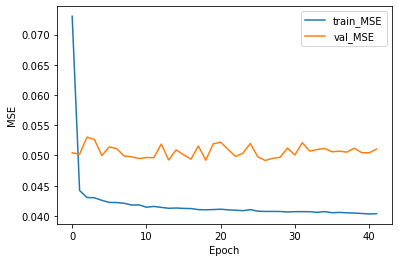

In [585]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un train MSE de 0.0407 y un val MSE de 0.0492 en 27 épocas. No entrena mucho, Peores resultados que utilizando dos capas ocultas, el mejor modelo sigue siendo el 26.

### Modelo 30. Tomamos datos cada 5 minutos de TRES horas antes y predecimos a 5 minutos, utilizando fórmula 2 de neuronas tomando el resto de datos atmosféricos MENOS la velocidad del viento para ver cómo afecta al modelo. Introducimos estos datos en la capa que concatena. Introducimos datos de producción de 30 minutos antes en la entrada

In [586]:
X_train1=np.array(PVGISdf.iloc[3:len(PVGISdf)-36:3,1:4]) #Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=np.array(PVGISdf.iloc[4:len(PVGISdf)-35:3,1:4]) #Tengo datos de radiación de 13:30-16:25 e introduzco producción a las 16:30.
X_train3=np.array(PVGISdf.iloc[5:len(PVGISdf)-34:3,1:4]) #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=np.array(PVGISdf.iloc[6:len(PVGISdf)-33:3,1:4])
X_train5=np.array(PVGISdf.iloc[7:len(PVGISdf)-32:3,1:4])
X_train6=np.array(PVGISdf.iloc[8:len(PVGISdf)-31:3,1:4])
X_train7=np.array(PVGISdf.iloc[9:len(PVGISdf)-30:3,1:4]) 
X_train8=np.array(PVGISdf.iloc[10:len(PVGISdf)-29:3,1:4])
X_train9=np.array(PVGISdf.iloc[11:len(PVGISdf)-28:3,1:4]) 
X_train10=np.array(PVGISdf.iloc[12:len(PVGISdf)-27:3,1:4])
X_train11=np.array(PVGISdf.iloc[13:len(PVGISdf)-26:3,1:4])
X_train12=np.array(PVGISdf.iloc[14:len(PVGISdf)-25:3,1:4]) #Tomo datos hasta las 22:30 del 16/12/2018 para que mi última predicción sea la de las 22:45
X_train13=np.array(PVGISdf.iloc[15:len(PVGISdf)-24:3,1:4])  
X_train14=np.array(PVGISdf.iloc[16:len(PVGISdf)-23:3,1:4]) 
X_train15=np.array(PVGISdf.iloc[17:len(PVGISdf)-22:3,1:4]) 
X_train16=np.array(PVGISdf.iloc[18:len(PVGISdf)-21:3,1:4])
X_train17=np.array(PVGISdf.iloc[19:len(PVGISdf)-20:3,1:4])
X_train18=np.array(PVGISdf.iloc[20:len(PVGISdf)-19:3,1:4])
X_train19=np.array(PVGISdf.iloc[21:len(PVGISdf)-18:3,1:4])  
X_train20=np.array(PVGISdf.iloc[22:len(PVGISdf)-17:3,1:4]) 
X_train21=np.array(PVGISdf.iloc[23:len(PVGISdf)-16:3,1:4]) 
X_train22=np.array(PVGISdf.iloc[24:len(PVGISdf)-15:3,1:4])
X_train23=np.array(PVGISdf.iloc[25:len(PVGISdf)-14:3,1:4])
X_train24=np.array(PVGISdf.iloc[26:len(PVGISdf)-13:3,1:4])
X_train25=np.array(PVGISdf.iloc[27:len(PVGISdf)-12:3,1:4])  
X_train26=np.array(PVGISdf.iloc[28:len(PVGISdf)-11:3,1:4]) 
X_train27=np.array(PVGISdf.iloc[29:len(PVGISdf)-10:3,1:4]) 
X_train28=np.array(PVGISdf.iloc[30:len(PVGISdf)-9:3,1:4])
X_train29=np.array(PVGISdf.iloc[31:len(PVGISdf)-8:3,1:4])
X_train30=np.array(PVGISdf.iloc[32:len(PVGISdf)-7:3,1:4])
X_train31=np.array(PVGISdf.iloc[33:len(PVGISdf)-6:3,1:4])  
X_train32=np.array(PVGISdf.iloc[34:len(PVGISdf)-5:3,1:4]) 
X_train33=np.array(PVGISdf.iloc[35:len(PVGISdf)-4:3,1:4]) 
X_train34=np.array(PVGISdf.iloc[36:len(PVGISdf)-3:3,1:4])
X_train35=np.array(PVGISdf.iloc[37:len(PVGISdf)-2:3,1:4])
X_train36=np.array(PVGISdf.iloc[38:len(PVGISdf)-1:3,1:4])

X_trainatm1=np.array(PVGISdf.iloc[3:len(PVGISdf)-36:3,4:6])  
X_trainatm2=np.array(PVGISdf.iloc[4:len(PVGISdf)-35:3,4:6]) 
X_trainatm3=np.array(PVGISdf.iloc[5:len(PVGISdf)-34:3,4:6]) 
X_trainatm4=np.array(PVGISdf.iloc[6:len(PVGISdf)-33:3,4:6])
X_trainatm5=np.array(PVGISdf.iloc[7:len(PVGISdf)-32:3,4:6])
X_trainatm6=np.array(PVGISdf.iloc[8:len(PVGISdf)-31:3,4:6])
X_trainatm7=np.array(PVGISdf.iloc[9:len(PVGISdf)-30:3,4:6]) 
X_trainatm8=np.array(PVGISdf.iloc[10:len(PVGISdf)-29:3,4:6])
X_trainatm9=np.array(PVGISdf.iloc[11:len(PVGISdf)-28:3,4:6]) 
X_trainatm10=np.array(PVGISdf.iloc[12:len(PVGISdf)-27:3,4:6])
X_trainatm11=np.array(PVGISdf.iloc[13:len(PVGISdf)-26:3,4:6])
X_trainatm12=np.array(PVGISdf.iloc[14:len(PVGISdf)-25:3,4:6])
X_trainatm13=np.array(PVGISdf.iloc[15:len(PVGISdf)-24:3,4:6])  
X_trainatm14=np.array(PVGISdf.iloc[16:len(PVGISdf)-23:3,4:6]) 
X_trainatm15=np.array(PVGISdf.iloc[17:len(PVGISdf)-22:3,4:6]) 
X_trainatm16=np.array(PVGISdf.iloc[18:len(PVGISdf)-21:3,4:6])
X_trainatm17=np.array(PVGISdf.iloc[19:len(PVGISdf)-20:3,4:6])
X_trainatm18=np.array(PVGISdf.iloc[20:len(PVGISdf)-19:3,4:6])
X_trainatm19=np.array(PVGISdf.iloc[21:len(PVGISdf)-18:3,4:6])  
X_trainatm20=np.array(PVGISdf.iloc[22:len(PVGISdf)-17:3,4:6]) 
X_trainatm21=np.array(PVGISdf.iloc[23:len(PVGISdf)-16:3,4:6]) 
X_trainatm22=np.array(PVGISdf.iloc[24:len(PVGISdf)-15:3,4:6])
X_trainatm23=np.array(PVGISdf.iloc[25:len(PVGISdf)-14:3,4:6])
X_trainatm24=np.array(PVGISdf.iloc[26:len(PVGISdf)-13:3,4:6])
X_trainatm25=np.array(PVGISdf.iloc[27:len(PVGISdf)-12:3,4:6])  
X_trainatm26=np.array(PVGISdf.iloc[28:len(PVGISdf)-11:3,4:6]) 
X_trainatm27=np.array(PVGISdf.iloc[29:len(PVGISdf)-10:3,4:6]) 
X_trainatm28=np.array(PVGISdf.iloc[30:len(PVGISdf)-9:3,4:6])
X_trainatm29=np.array(PVGISdf.iloc[31:len(PVGISdf)-8:3,4:6])
X_trainatm30=np.array(PVGISdf.iloc[32:len(PVGISdf)-7:3,4:6])
X_trainatm31=np.array(PVGISdf.iloc[33:len(PVGISdf)-6:3,4:6])  
X_trainatm32=np.array(PVGISdf.iloc[34:len(PVGISdf)-5:3,4:6]) 
X_trainatm33=np.array(PVGISdf.iloc[35:len(PVGISdf)-4:3,4:6]) 
X_trainatm34=np.array(PVGISdf.iloc[36:len(PVGISdf)-3:3,4:6])
X_trainatm35=np.array(PVGISdf.iloc[37:len(PVGISdf)-2:3,4:6])
X_trainatm36=np.array(PVGISdf.iloc[38:len(PVGISdf)-1:3,4:6])

X_prod1=np.array(PVOutputdf.iloc[12:len(PVOutputdf)-1,1]).astype(float) #Producción 15 minutos antes
X_prod2=np.array(PVOutputdf.iloc[11:len(PVOutputdf)-2,1]).astype(float) #Producción 30 minutos antes

y_train=np.array(PVOutputdf.iloc[13:len(PVOutputdf),1]).astype(float) #No tomo los primeros 7 valores para cuadrarlo, que empiece a las 16:30

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 
X_train7std=np.std(X_train7) 
X_train8std=np.std(X_train8)
X_train9std=np.std(X_train9)
X_train10std=np.std(X_train10) 
X_train11std=np.std(X_train11) 
X_train12std=np.std(X_train12)
X_train13std=np.std(X_train13) 
X_train14std=np.std(X_train14) 
X_train15std=np.std(X_train15)
X_train16std=np.std(X_train16)
X_train17std=np.std(X_train17) 
X_train18std=np.std(X_train18)
X_train19std=np.std(X_train19) 
X_train20std=np.std(X_train20) 
X_train21std=np.std(X_train21)
X_train22std=np.std(X_train22)
X_train23std=np.std(X_train23) 
X_train24std=np.std(X_train24)
X_train25std=np.std(X_train25) 
X_train26std=np.std(X_train26) 
X_train27std=np.std(X_train27)
X_train28std=np.std(X_train28)
X_train29std=np.std(X_train29) 
X_train30std=np.std(X_train30)
X_train31std=np.std(X_train31) 
X_train32std=np.std(X_train32) 
X_train33std=np.std(X_train33)
X_train34std=np.std(X_train34)
X_train35std=np.std(X_train35) 
X_train36std=np.std(X_train36) 


X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 
X_train7est=X_train7/X_train7std 
X_train8est=X_train8/X_train8std
X_train9est=X_train9/X_train9std 
X_train10est=X_train10/X_train10std 
X_train11est=X_train11/X_train11std 
X_train12est=X_train12/X_train12std
X_train13est=X_train13/X_train13std 
X_train14est=X_train14/X_train14std
X_train15est=X_train15/X_train15std 
X_train16est=X_train16/X_train16std 
X_train17est=X_train17/X_train17std 
X_train18est=X_train18/X_train18std
X_train19est=X_train19/X_train19std 
X_train20est=X_train20/X_train20std
X_train21est=X_train21/X_train21std 
X_train22est=X_train22/X_train22std 
X_train23est=X_train23/X_train23std 
X_train24est=X_train24/X_train24std
X_train25est=X_train25/X_train25std 
X_train26est=X_train26/X_train26std
X_train27est=X_train27/X_train27std 
X_train28est=X_train28/X_train28std 
X_train29est=X_train29/X_train29std 
X_train30est=X_train30/X_train30std
X_train31est=X_train31/X_train31std 
X_train32est=X_train32/X_train32std
X_train33est=X_train33/X_train33std 
X_train34est=X_train34/X_train34std 
X_train35est=X_train35/X_train35std 
X_train36est=X_train36/X_train36std

X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est,X_train7est,X_train8est,X_train9est,X_train10est,X_train11est,X_train12est,X_train13est,X_train14est,X_train15est,X_train16est,X_train17est,X_train18est,X_train19est,X_train20est,X_train21est,X_train22est,X_train23est,X_train24est,X_train25est,X_train26est,X_train27est,X_train28est,X_train29est,X_train30est,X_train31est,X_train32est,X_train33est,X_train34est,X_train35est,X_train36est)

X_trainatm1std=np.std(X_trainatm1)  
X_trainatm2std=np.std(X_trainatm2) 
X_trainatm3std=np.std(X_trainatm3) 
X_trainatm4std=np.std(X_trainatm4)
X_trainatm5std=np.std(X_trainatm5)
X_trainatm6std=np.std(X_trainatm6)
X_trainatm7std=np.std(X_trainatm7)
X_trainatm8std=np.std(X_trainatm8)
X_trainatm9std=np.std(X_trainatm9) 
X_trainatm10std=np.std(X_trainatm10)
X_trainatm11std=np.std(X_trainatm11)
X_trainatm12std=np.std(X_trainatm12)
X_trainatm13std=np.std(X_trainatm13)
X_trainatm14std=np.std(X_trainatm14)
X_trainatm15std=np.std(X_trainatm15) 
X_trainatm16std=np.std(X_trainatm16)
X_trainatm17std=np.std(X_trainatm17)
X_trainatm18std=np.std(X_trainatm18)
X_trainatm19std=np.std(X_trainatm19)
X_trainatm20std=np.std(X_trainatm20)
X_trainatm21std=np.std(X_trainatm21) 
X_trainatm22std=np.std(X_trainatm22)
X_trainatm23std=np.std(X_trainatm23)
X_trainatm24std=np.std(X_trainatm24)
X_trainatm25std=np.std(X_trainatm25)
X_trainatm26std=np.std(X_trainatm26)
X_trainatm27std=np.std(X_trainatm27) 
X_trainatm28std=np.std(X_trainatm28)
X_trainatm29std=np.std(X_trainatm29)
X_trainatm30std=np.std(X_trainatm30)
X_trainatm31std=np.std(X_trainatm31)
X_trainatm32std=np.std(X_trainatm32)
X_trainatm33std=np.std(X_trainatm33) 
X_trainatm34std=np.std(X_trainatm34)
X_trainatm35std=np.std(X_trainatm35)
X_trainatm36std=np.std(X_trainatm36)

X_trainatm1est=X_trainatm1/X_trainatm1std 
X_trainatm2est=X_trainatm2/X_trainatm2std 
X_trainatm3est=X_trainatm3/X_trainatm3std 
X_trainatm4est=X_trainatm4/X_trainatm4std
X_trainatm5est=X_trainatm5/X_trainatm5std 
X_trainatm6est=X_trainatm6/X_trainatm6std 
X_trainatm7est=X_trainatm7/X_trainatm7std 
X_trainatm8est=X_trainatm8/X_trainatm8std
X_trainatm9est=X_trainatm9/X_trainatm9std 
X_trainatm10est=X_trainatm10/X_trainatm10std 
X_trainatm11est=X_trainatm11/X_trainatm11std 
X_trainatm12est=X_trainatm12/X_trainatm12std
X_trainatm13est=X_trainatm13/X_trainatm13std 
X_trainatm14est=X_trainatm14/X_trainatm14std 
X_trainatm15est=X_trainatm15/X_trainatm15std
X_trainatm16est=X_trainatm16/X_trainatm16std 
X_trainatm17est=X_trainatm17/X_trainatm17std 
X_trainatm18est=X_trainatm18/X_trainatm18std
X_trainatm19est=X_trainatm19/X_trainatm19std 
X_trainatm20est=X_trainatm20/X_trainatm20std 
X_trainatm21est=X_trainatm21/X_trainatm21std
X_trainatm22est=X_trainatm22/X_trainatm22std 
X_trainatm23est=X_trainatm23/X_trainatm23std 
X_trainatm24est=X_trainatm24/X_trainatm24std
X_trainatm25est=X_trainatm25/X_trainatm25std 
X_trainatm26est=X_trainatm26/X_trainatm26std 
X_trainatm27est=X_trainatm27/X_trainatm27std
X_trainatm28est=X_trainatm28/X_trainatm28std 
X_trainatm29est=X_trainatm29/X_trainatm29std 
X_trainatm30est=X_trainatm30/X_trainatm30std
X_trainatm31est=X_trainatm31/X_trainatm31std 
X_trainatm32est=X_trainatm32/X_trainatm32std 
X_trainatm33est=X_trainatm33/X_trainatm33std
X_trainatm34est=X_trainatm34/X_trainatm34std 
X_trainatm35est=X_trainatm35/X_trainatm35std 
X_trainatm36est=X_trainatm36/X_trainatm36std

X_trainatmest=(X_trainatm1est,X_trainatm2est,X_trainatm3est,X_trainatm4est,X_trainatm5est,X_trainatm6est,X_trainatm7est,X_trainatm8est,X_trainatm9est,X_trainatm10est,X_trainatm11est,X_trainatm12est,X_trainatm13est,X_trainatm14est,X_trainatm15est,X_trainatm16est,X_trainatm17est,X_trainatm18est,X_trainatm19est,X_trainatm20est,X_trainatm21est,X_trainatm22est,X_trainatm23est,X_trainatm24est,X_trainatm25est,X_trainatm26est,X_trainatm27est,X_trainatm28est,X_trainatm29est,X_trainatm30est,X_trainatm31est,X_trainatm32est,X_trainatm33est,X_trainatm34est,X_trainatm35est,X_trainatm36est)

X_prod1std=np.std(X_prod1)
X_prod1est=X_prod1/X_prod1std 

X_prod2std=np.std(X_prod2)
X_prod2est=X_prod2/X_prod2std 
X_prodest=(X_prod1est,X_prod2est)

Y_trainstd=np.std(y_train) 
Y_trainest=y_train/Y_trainstd 

In [587]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)
entrada13 = tf.keras.layers.Input(shape=3)
entrada14 = tf.keras.layers.Input(shape=3)
entrada15 = tf.keras.layers.Input(shape=3)
entrada16 = tf.keras.layers.Input(shape=3)
entrada17 = tf.keras.layers.Input(shape=3)
entrada18 = tf.keras.layers.Input(shape=3)
entrada19 = tf.keras.layers.Input(shape=3)
entrada20 = tf.keras.layers.Input(shape=3)
entrada21 = tf.keras.layers.Input(shape=3)
entrada22 = tf.keras.layers.Input(shape=3)
entrada23 = tf.keras.layers.Input(shape=3)
entrada24 = tf.keras.layers.Input(shape=3)
entrada25 = tf.keras.layers.Input(shape=3)
entrada26 = tf.keras.layers.Input(shape=3)
entrada27 = tf.keras.layers.Input(shape=3)
entrada28 = tf.keras.layers.Input(shape=3)
entrada29 = tf.keras.layers.Input(shape=3)
entrada30 = tf.keras.layers.Input(shape=3)
entrada31 = tf.keras.layers.Input(shape=3)
entrada32 = tf.keras.layers.Input(shape=3)
entrada33 = tf.keras.layers.Input(shape=3)
entrada34 = tf.keras.layers.Input(shape=3)
entrada35 = tf.keras.layers.Input(shape=3)
entrada36 = tf.keras.layers.Input(shape=3)

entradaatm1 = tf.keras.layers.Input(shape=2) 
entradaatm2 = tf.keras.layers.Input(shape=2)
entradaatm3 = tf.keras.layers.Input(shape=2)
entradaatm4 = tf.keras.layers.Input(shape=2)
entradaatm5 = tf.keras.layers.Input(shape=2)
entradaatm6 = tf.keras.layers.Input(shape=2)
entradaatm7 = tf.keras.layers.Input(shape=2)
entradaatm8 = tf.keras.layers.Input(shape=2)
entradaatm9 = tf.keras.layers.Input(shape=2)
entradaatm10 = tf.keras.layers.Input(shape=2)
entradaatm11 = tf.keras.layers.Input(shape=2)
entradaatm12 = tf.keras.layers.Input(shape=2)
entradaatm13 = tf.keras.layers.Input(shape=2)
entradaatm14 = tf.keras.layers.Input(shape=2)
entradaatm15 = tf.keras.layers.Input(shape=2) 
entradaatm16 = tf.keras.layers.Input(shape=2)
entradaatm17 = tf.keras.layers.Input(shape=2)
entradaatm18 = tf.keras.layers.Input(shape=2)
entradaatm19 = tf.keras.layers.Input(shape=2)
entradaatm20 = tf.keras.layers.Input(shape=2)
entradaatm21 = tf.keras.layers.Input(shape=2) 
entradaatm22 = tf.keras.layers.Input(shape=2)
entradaatm23 = tf.keras.layers.Input(shape=2)
entradaatm24 = tf.keras.layers.Input(shape=2)
entradaatm25 = tf.keras.layers.Input(shape=2)
entradaatm26 = tf.keras.layers.Input(shape=2)
entradaatm27 = tf.keras.layers.Input(shape=2) 
entradaatm28 = tf.keras.layers.Input(shape=2)
entradaatm29 = tf.keras.layers.Input(shape=2)
entradaatm30 = tf.keras.layers.Input(shape=2)
entradaatm31 = tf.keras.layers.Input(shape=2)
entradaatm32 = tf.keras.layers.Input(shape=2)
entradaatm33 = tf.keras.layers.Input(shape=2) 
entradaatm34 = tf.keras.layers.Input(shape=2)
entradaatm35 = tf.keras.layers.Input(shape=2)
entradaatm36 = tf.keras.layers.Input(shape=2)

entradaprod1=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat
entradaprod2=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat


#Capas ocultas formula 2: Hidden =3/2*(In + Out)=3/2*(3+1)=6
oculta1 = tf.keras.layers.Dense(6, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(6, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(6, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(6, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(6, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(6, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(6, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(6, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(6, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(6, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(6, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(6, activation="relu")(entrada12)
oculta13 = tf.keras.layers.Dense(6, activation="relu")(entrada13)
oculta14 = tf.keras.layers.Dense(6, activation="relu")(entrada14)
oculta15 = tf.keras.layers.Dense(6, activation="relu")(entrada15)
oculta16 = tf.keras.layers.Dense(6, activation="relu")(entrada16)
oculta17 = tf.keras.layers.Dense(6, activation="relu")(entrada17)
oculta18 = tf.keras.layers.Dense(6, activation="relu")(entrada18)
oculta19 = tf.keras.layers.Dense(6, activation="relu")(entrada19)
oculta20 = tf.keras.layers.Dense(6, activation="relu")(entrada20)
oculta21 = tf.keras.layers.Dense(6, activation="relu")(entrada21)
oculta22 = tf.keras.layers.Dense(6, activation="relu")(entrada22)
oculta23 = tf.keras.layers.Dense(6, activation="relu")(entrada23)
oculta24 = tf.keras.layers.Dense(6, activation="relu")(entrada24)
oculta25 = tf.keras.layers.Dense(6, activation="relu")(entrada25)
oculta26 = tf.keras.layers.Dense(6, activation="relu")(entrada26)
oculta27 = tf.keras.layers.Dense(6, activation="relu")(entrada27)
oculta28 = tf.keras.layers.Dense(6, activation="relu")(entrada28)
oculta29 = tf.keras.layers.Dense(6, activation="relu")(entrada29)
oculta30 = tf.keras.layers.Dense(6, activation="relu")(entrada30)
oculta31 = tf.keras.layers.Dense(6, activation="relu")(entrada31)
oculta32 = tf.keras.layers.Dense(6, activation="relu")(entrada32)
oculta33 = tf.keras.layers.Dense(6, activation="relu")(entrada33)
oculta34 = tf.keras.layers.Dense(6, activation="relu")(entrada34)
oculta35 = tf.keras.layers.Dense(6, activation="relu")(entrada35)
oculta36 = tf.keras.layers.Dense(6, activation="relu")(entrada36)


concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12, oculta13, oculta14, oculta15, oculta16, oculta17, oculta18, oculta19, oculta20, oculta21, oculta22, oculta23, oculta24, oculta25, oculta26, oculta27, oculta28, oculta29, oculta30, oculta31, oculta32, oculta33, oculta34, oculta35, oculta36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod1,entradaprod2]) #estratificada, concatena las 12
#2 layers intermedias, formula 2: Hidden =3/2*(In + Out)=3/2*(1+1)=3
adoculta1=tf.keras.layers.Dense(3, activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(3, activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(3, activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo30 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12, entrada13, entrada14, entrada15, entrada16, entrada17, entrada18, entrada19, entrada20, entrada21, entrada22, entrada23, entrada24, entrada25, entrada26, entrada27, entrada28, entrada29, entrada30, entrada31, entrada32, entrada33, entrada34, entrada35, entrada36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36,entradaprod1,entradaprod2], outputs=[salida])

modelo30.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo30.fit([X_trainest,X_trainatmest,X_prodest], Y_trainest, epochs=1000,callbacks=[callback],validation_split=0.2)
#Mucho mejor resultado introduciendo entre corchetes que entre paréntesis (X_trainest,X_trainatmest)
#No estoy 100% seguro de que esté bien introducido así, cómo sabe que las entradai corresponden a X_train y que entradaatmi corresponden a X_trainatm?

Epoch 1/1000
3308/3308 [==============================] - 18s 5ms/step - loss: 0.1140 - mae: 0.1373 - val_loss: 0.0516 - val_mae: 0.0803
Epoch 2/1000
3308/3308 [==============================] - 18s 5ms/step - loss: 0.0448 - mae: 0.0705 - val_loss: 0.0525 - val_mae: 0.0947
Epoch 3/1000
3308/3308 [==============================] - 19s 6ms/step - loss: 0.0431 - mae: 0.0666 - val_loss: 0.0514 - val_mae: 0.0530
Epoch 4/1000
3308/3308 [==============================] - 19s 6ms/step - loss: 0.0427 - mae: 0.0649 - val_loss: 0.0507 - val_mae: 0.0522
Epoch 5/1000
3308/3308 [==============================] - 18s 6ms/step - loss: 0.0425 - mae: 0.0645 - val_loss: 0.0508 - val_mae: 0.0507
Epoch 6/1000
3308/3308 [==============================] - 20s 6ms/step - loss: 0.0423 - mae: 0.0641 - val_loss: 0.0482 - val_mae: 0.0654
Epoch 7/1000
3308/3308 [==============================] - 32s 10ms/step - loss: 0.0421 - mae: 0.0635 - val_loss: 0.0495 - val_mae: 0.0557
Epoch 8/1000
3308/3308 [================

Text(0, 0.5, 'MSE')

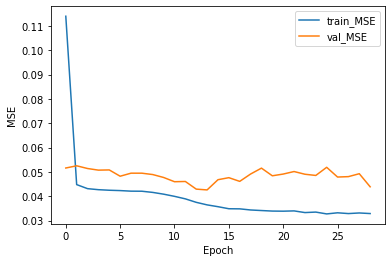

In [588]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un train MSE de 0.0365 y un val MSE de 0.0426  en 14 épocas. Resultados peores que prediciendo a 15 minutos vista, extraño. El mejor modelo sigue siendo el 26

### Modelo 31. Tomamos datos cada 15 minutos de TRES horas antes y predecimos a 5 minutos, utilizando fórmula 3 de neuronas tomando el resto de datos atmosféricos, SIN EL VIENTO. Introducimos estos datos en la capa que concatena. Como el 21 (mejor sin producción), pero sin datos del viento.

In [56]:
X_train1=np.array(PVGISdf.iloc[1:len(PVGISdf)-38:3,1:4]) #Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=np.array(PVGISdf.iloc[2:len(PVGISdf)-37:3,1:4]) #Tengo datos de radiación de 13:20-16:15 e introduzco producción a las 15:30.
X_train3=np.array(PVGISdf.iloc[3:len(PVGISdf)-36:3,1:4]) #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=np.array(PVGISdf.iloc[4:len(PVGISdf)-35:3,1:4])
X_train5=np.array(PVGISdf.iloc[5:len(PVGISdf)-34:3,1:4])
X_train6=np.array(PVGISdf.iloc[6:len(PVGISdf)-33:3,1:4])
X_train7=np.array(PVGISdf.iloc[7:len(PVGISdf)-32:3,1:4]) 
X_train8=np.array(PVGISdf.iloc[8:len(PVGISdf)-31:3,1:4])
X_train9=np.array(PVGISdf.iloc[9:len(PVGISdf)-30:3,1:4]) 
X_train10=np.array(PVGISdf.iloc[10:len(PVGISdf)-29:3,1:4])
X_train11=np.array(PVGISdf.iloc[11:len(PVGISdf)-28:3,1:4])
X_train12=np.array(PVGISdf.iloc[12:len(PVGISdf)-27:3,1:4]) #Tomo datos hasta las 22:30 del 16/12/2018 para que mi última predicción sea la de las 22:45
X_train13=np.array(PVGISdf.iloc[13:len(PVGISdf)-26:3,1:4])  
X_train14=np.array(PVGISdf.iloc[14:len(PVGISdf)-25:3,1:4]) 
X_train15=np.array(PVGISdf.iloc[15:len(PVGISdf)-24:3,1:4]) 
X_train16=np.array(PVGISdf.iloc[16:len(PVGISdf)-23:3,1:4])
X_train17=np.array(PVGISdf.iloc[17:len(PVGISdf)-22:3,1:4])
X_train18=np.array(PVGISdf.iloc[18:len(PVGISdf)-21:3,1:4])
X_train19=np.array(PVGISdf.iloc[19:len(PVGISdf)-20:3,1:4])  
X_train20=np.array(PVGISdf.iloc[20:len(PVGISdf)-19:3,1:4]) 
X_train21=np.array(PVGISdf.iloc[21:len(PVGISdf)-18:3,1:4]) 
X_train22=np.array(PVGISdf.iloc[22:len(PVGISdf)-17:3,1:4])
X_train23=np.array(PVGISdf.iloc[23:len(PVGISdf)-16:3,1:4])
X_train24=np.array(PVGISdf.iloc[24:len(PVGISdf)-15:3,1:4])
X_train25=np.array(PVGISdf.iloc[25:len(PVGISdf)-14:3,1:4])  
X_train26=np.array(PVGISdf.iloc[26:len(PVGISdf)-13:3,1:4]) 
X_train27=np.array(PVGISdf.iloc[27:len(PVGISdf)-12:3,1:4]) 
X_train28=np.array(PVGISdf.iloc[28:len(PVGISdf)-11:3,1:4])
X_train29=np.array(PVGISdf.iloc[29:len(PVGISdf)-10:3,1:4])
X_train30=np.array(PVGISdf.iloc[30:len(PVGISdf)-9:3,1:4])
X_train31=np.array(PVGISdf.iloc[31:len(PVGISdf)-8:3,1:4])  
X_train32=np.array(PVGISdf.iloc[32:len(PVGISdf)-7:3,1:4]) 
X_train33=np.array(PVGISdf.iloc[33:len(PVGISdf)-6:3,1:4]) 
X_train34=np.array(PVGISdf.iloc[34:len(PVGISdf)-5:3,1:4])
X_train35=np.array(PVGISdf.iloc[35:len(PVGISdf)-4:3,1:4])
X_train36=np.array(PVGISdf.iloc[36:len(PVGISdf)-3:3,1:4])

X_trainatm1=np.array(PVGISdf.iloc[1:len(PVGISdf)-38:3,4:6])  
X_trainatm2=np.array(PVGISdf.iloc[2:len(PVGISdf)-37:3,4:6]) 
X_trainatm3=np.array(PVGISdf.iloc[3:len(PVGISdf)-36:3,4:6]) 
X_trainatm4=np.array(PVGISdf.iloc[4:len(PVGISdf)-35:3,4:6])
X_trainatm5=np.array(PVGISdf.iloc[5:len(PVGISdf)-34:3,4:6])
X_trainatm6=np.array(PVGISdf.iloc[6:len(PVGISdf)-33:3,4:6])
X_trainatm7=np.array(PVGISdf.iloc[7:len(PVGISdf)-32:3,4:6]) 
X_trainatm8=np.array(PVGISdf.iloc[8:len(PVGISdf)-31:3,4:6])
X_trainatm9=np.array(PVGISdf.iloc[9:len(PVGISdf)-30:3,4:6]) 
X_trainatm10=np.array(PVGISdf.iloc[10:len(PVGISdf)-29:3,4:6])
X_trainatm11=np.array(PVGISdf.iloc[11:len(PVGISdf)-28:3,4:6])
X_trainatm12=np.array(PVGISdf.iloc[12:len(PVGISdf)-27:3,4:6])
X_trainatm13=np.array(PVGISdf.iloc[13:len(PVGISdf)-26:3,4:6])  
X_trainatm14=np.array(PVGISdf.iloc[14:len(PVGISdf)-25:3,4:6]) 
X_trainatm15=np.array(PVGISdf.iloc[15:len(PVGISdf)-24:3,4:6]) 
X_trainatm16=np.array(PVGISdf.iloc[16:len(PVGISdf)-23:3,4:6])
X_trainatm17=np.array(PVGISdf.iloc[17:len(PVGISdf)-22:3,4:6])
X_trainatm18=np.array(PVGISdf.iloc[18:len(PVGISdf)-21:3,4:6])
X_trainatm19=np.array(PVGISdf.iloc[19:len(PVGISdf)-20:3,4:6])  
X_trainatm20=np.array(PVGISdf.iloc[20:len(PVGISdf)-19:3,4:6]) 
X_trainatm21=np.array(PVGISdf.iloc[21:len(PVGISdf)-18:3,4:6]) 
X_trainatm22=np.array(PVGISdf.iloc[22:len(PVGISdf)-17:3,4:6])
X_trainatm23=np.array(PVGISdf.iloc[23:len(PVGISdf)-16:3,4:6])
X_trainatm24=np.array(PVGISdf.iloc[24:len(PVGISdf)-15:3,4:6])
X_trainatm25=np.array(PVGISdf.iloc[25:len(PVGISdf)-14:3,4:6])  
X_trainatm26=np.array(PVGISdf.iloc[26:len(PVGISdf)-13:3,4:6]) 
X_trainatm27=np.array(PVGISdf.iloc[27:len(PVGISdf)-12:3,4:6]) 
X_trainatm28=np.array(PVGISdf.iloc[28:len(PVGISdf)-11:3,4:6])
X_trainatm29=np.array(PVGISdf.iloc[29:len(PVGISdf)-10:3,4:6])
X_trainatm30=np.array(PVGISdf.iloc[30:len(PVGISdf)-9:3,4:6])
X_trainatm31=np.array(PVGISdf.iloc[31:len(PVGISdf)-8:3,4:6])  
X_trainatm32=np.array(PVGISdf.iloc[32:len(PVGISdf)-7:3,4:6]) 
X_trainatm33=np.array(PVGISdf.iloc[33:len(PVGISdf)-6:3,4:6]) 
X_trainatm34=np.array(PVGISdf.iloc[34:len(PVGISdf)-5:3,4:6])
X_trainatm35=np.array(PVGISdf.iloc[35:len(PVGISdf)-4:3,4:6])
X_trainatm36=np.array(PVGISdf.iloc[36:len(PVGISdf)-3:3,4:6])

y_train=np.array(PVOutputdf.iloc[13:len(PVOutputdf),5]).astype(float) #No tomo los primeros 7 valores para cuadrarlo, que empiece a las 16:30

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 
X_train7std=np.std(X_train7) 
X_train8std=np.std(X_train8)
X_train9std=np.std(X_train9)
X_train10std=np.std(X_train10) 
X_train11std=np.std(X_train11) 
X_train12std=np.std(X_train12)
X_train13std=np.std(X_train13) 
X_train14std=np.std(X_train14) 
X_train15std=np.std(X_train15)
X_train16std=np.std(X_train16)
X_train17std=np.std(X_train17) 
X_train18std=np.std(X_train18)
X_train19std=np.std(X_train19) 
X_train20std=np.std(X_train20) 
X_train21std=np.std(X_train21)
X_train22std=np.std(X_train22)
X_train23std=np.std(X_train23) 
X_train24std=np.std(X_train24)
X_train25std=np.std(X_train25) 
X_train26std=np.std(X_train26) 
X_train27std=np.std(X_train27)
X_train28std=np.std(X_train28)
X_train29std=np.std(X_train29) 
X_train30std=np.std(X_train30)
X_train31std=np.std(X_train31) 
X_train32std=np.std(X_train32) 
X_train33std=np.std(X_train33)
X_train34std=np.std(X_train34)
X_train35std=np.std(X_train35) 
X_train36std=np.std(X_train36) 


X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 
X_train7est=X_train7/X_train7std 
X_train8est=X_train8/X_train8std
X_train9est=X_train9/X_train9std 
X_train10est=X_train10/X_train10std 
X_train11est=X_train11/X_train11std 
X_train12est=X_train12/X_train12std
X_train13est=X_train13/X_train13std 
X_train14est=X_train14/X_train14std
X_train15est=X_train15/X_train15std 
X_train16est=X_train16/X_train16std 
X_train17est=X_train17/X_train17std 
X_train18est=X_train18/X_train18std
X_train19est=X_train19/X_train19std 
X_train20est=X_train20/X_train20std
X_train21est=X_train21/X_train21std 
X_train22est=X_train22/X_train22std 
X_train23est=X_train23/X_train23std 
X_train24est=X_train24/X_train24std
X_train25est=X_train25/X_train25std 
X_train26est=X_train26/X_train26std
X_train27est=X_train27/X_train27std 
X_train28est=X_train28/X_train28std 
X_train29est=X_train29/X_train29std 
X_train30est=X_train30/X_train30std
X_train31est=X_train31/X_train31std 
X_train32est=X_train32/X_train32std
X_train33est=X_train33/X_train33std 
X_train34est=X_train34/X_train34std 
X_train35est=X_train35/X_train35std 
X_train36est=X_train36/X_train36std

X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est,X_train7est,X_train8est,X_train9est,X_train10est,X_train11est,X_train12est,X_train13est,X_train14est,X_train15est,X_train16est,X_train17est,X_train18est,X_train19est,X_train20est,X_train21est,X_train22est,X_train23est,X_train24est,X_train25est,X_train26est,X_train27est,X_train28est,X_train29est,X_train30est,X_train31est,X_train32est,X_train33est,X_train34est,X_train35est,X_train36est)

X_trainatm1std=np.std(X_trainatm1)  
X_trainatm2std=np.std(X_trainatm2) 
X_trainatm3std=np.std(X_trainatm3) 
X_trainatm4std=np.std(X_trainatm4)
X_trainatm5std=np.std(X_trainatm5)
X_trainatm6std=np.std(X_trainatm6)
X_trainatm7std=np.std(X_trainatm7)
X_trainatm8std=np.std(X_trainatm8)
X_trainatm9std=np.std(X_trainatm9) 
X_trainatm10std=np.std(X_trainatm10)
X_trainatm11std=np.std(X_trainatm11)
X_trainatm12std=np.std(X_trainatm12)
X_trainatm13std=np.std(X_trainatm13)
X_trainatm14std=np.std(X_trainatm14)
X_trainatm15std=np.std(X_trainatm15) 
X_trainatm16std=np.std(X_trainatm16)
X_trainatm17std=np.std(X_trainatm17)
X_trainatm18std=np.std(X_trainatm18)
X_trainatm19std=np.std(X_trainatm19)
X_trainatm20std=np.std(X_trainatm20)
X_trainatm21std=np.std(X_trainatm21) 
X_trainatm22std=np.std(X_trainatm22)
X_trainatm23std=np.std(X_trainatm23)
X_trainatm24std=np.std(X_trainatm24)
X_trainatm25std=np.std(X_trainatm25)
X_trainatm26std=np.std(X_trainatm26)
X_trainatm27std=np.std(X_trainatm27) 
X_trainatm28std=np.std(X_trainatm28)
X_trainatm29std=np.std(X_trainatm29)
X_trainatm30std=np.std(X_trainatm30)
X_trainatm31std=np.std(X_trainatm31)
X_trainatm32std=np.std(X_trainatm32)
X_trainatm33std=np.std(X_trainatm33) 
X_trainatm34std=np.std(X_trainatm34)
X_trainatm35std=np.std(X_trainatm35)
X_trainatm36std=np.std(X_trainatm36)

X_trainatm1est=X_trainatm1/X_trainatm1std 
X_trainatm2est=X_trainatm2/X_trainatm2std 
X_trainatm3est=X_trainatm3/X_trainatm3std 
X_trainatm4est=X_trainatm4/X_trainatm4std
X_trainatm5est=X_trainatm5/X_trainatm5std 
X_trainatm6est=X_trainatm6/X_trainatm6std 
X_trainatm7est=X_trainatm7/X_trainatm7std 
X_trainatm8est=X_trainatm8/X_trainatm8std
X_trainatm9est=X_trainatm9/X_trainatm9std 
X_trainatm10est=X_trainatm10/X_trainatm10std 
X_trainatm11est=X_trainatm11/X_trainatm11std 
X_trainatm12est=X_trainatm12/X_trainatm12std
X_trainatm13est=X_trainatm13/X_trainatm13std 
X_trainatm14est=X_trainatm14/X_trainatm14std 
X_trainatm15est=X_trainatm15/X_trainatm15std
X_trainatm16est=X_trainatm16/X_trainatm16std 
X_trainatm17est=X_trainatm17/X_trainatm17std 
X_trainatm18est=X_trainatm18/X_trainatm18std
X_trainatm19est=X_trainatm19/X_trainatm19std 
X_trainatm20est=X_trainatm20/X_trainatm20std 
X_trainatm21est=X_trainatm21/X_trainatm21std
X_trainatm22est=X_trainatm22/X_trainatm22std 
X_trainatm23est=X_trainatm23/X_trainatm23std 
X_trainatm24est=X_trainatm24/X_trainatm24std
X_trainatm25est=X_trainatm25/X_trainatm25std 
X_trainatm26est=X_trainatm26/X_trainatm26std 
X_trainatm27est=X_trainatm27/X_trainatm27std
X_trainatm28est=X_trainatm28/X_trainatm28std 
X_trainatm29est=X_trainatm29/X_trainatm29std 
X_trainatm30est=X_trainatm30/X_trainatm30std
X_trainatm31est=X_trainatm31/X_trainatm31std 
X_trainatm32est=X_trainatm32/X_trainatm32std 
X_trainatm33est=X_trainatm33/X_trainatm33std
X_trainatm34est=X_trainatm34/X_trainatm34std 
X_trainatm35est=X_trainatm35/X_trainatm35std 
X_trainatm36est=X_trainatm36/X_trainatm36std

X_trainatmest=(X_trainatm1est,X_trainatm2est,X_trainatm3est,X_trainatm4est,X_trainatm5est,X_trainatm6est,X_trainatm7est,X_trainatm8est,X_trainatm9est,X_trainatm10est,X_trainatm11est,X_trainatm12est,X_trainatm13est,X_trainatm14est,X_trainatm15est,X_trainatm16est,X_trainatm17est,X_trainatm18est,X_trainatm19est,X_trainatm20est,X_trainatm21est,X_trainatm22est,X_trainatm23est,X_trainatm24est,X_trainatm25est,X_trainatm26est,X_trainatm27est,X_trainatm28est,X_trainatm29est,X_trainatm30est,X_trainatm31est,X_trainatm32est,X_trainatm33est,X_trainatm34est,X_trainatm35est,X_trainatm36est)



In [57]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)
entrada13 = tf.keras.layers.Input(shape=3)
entrada14 = tf.keras.layers.Input(shape=3)
entrada15 = tf.keras.layers.Input(shape=3)
entrada16 = tf.keras.layers.Input(shape=3)
entrada17 = tf.keras.layers.Input(shape=3)
entrada18 = tf.keras.layers.Input(shape=3)
entrada19 = tf.keras.layers.Input(shape=3)
entrada20 = tf.keras.layers.Input(shape=3)
entrada21 = tf.keras.layers.Input(shape=3)
entrada22 = tf.keras.layers.Input(shape=3)
entrada23 = tf.keras.layers.Input(shape=3)
entrada24 = tf.keras.layers.Input(shape=3)
entrada25 = tf.keras.layers.Input(shape=3)
entrada26 = tf.keras.layers.Input(shape=3)
entrada27 = tf.keras.layers.Input(shape=3)
entrada28 = tf.keras.layers.Input(shape=3)
entrada29 = tf.keras.layers.Input(shape=3)
entrada30 = tf.keras.layers.Input(shape=3)
entrada31 = tf.keras.layers.Input(shape=3)
entrada32 = tf.keras.layers.Input(shape=3)
entrada33 = tf.keras.layers.Input(shape=3)
entrada34 = tf.keras.layers.Input(shape=3)
entrada35 = tf.keras.layers.Input(shape=3)
entrada36 = tf.keras.layers.Input(shape=3)

entradaatm1 = tf.keras.layers.Input(shape=2) 
entradaatm2 = tf.keras.layers.Input(shape=2)
entradaatm3 = tf.keras.layers.Input(shape=2)
entradaatm4 = tf.keras.layers.Input(shape=2)
entradaatm5 = tf.keras.layers.Input(shape=2)
entradaatm6 = tf.keras.layers.Input(shape=2)
entradaatm7 = tf.keras.layers.Input(shape=2)
entradaatm8 = tf.keras.layers.Input(shape=2)
entradaatm9 = tf.keras.layers.Input(shape=2)
entradaatm10 = tf.keras.layers.Input(shape=2)
entradaatm11 = tf.keras.layers.Input(shape=2)
entradaatm12 = tf.keras.layers.Input(shape=2)
entradaatm13 = tf.keras.layers.Input(shape=2)
entradaatm14 = tf.keras.layers.Input(shape=2)
entradaatm15 = tf.keras.layers.Input(shape=2) 
entradaatm16 = tf.keras.layers.Input(shape=2)
entradaatm17 = tf.keras.layers.Input(shape=2)
entradaatm18 = tf.keras.layers.Input(shape=2)
entradaatm19 = tf.keras.layers.Input(shape=2)
entradaatm20 = tf.keras.layers.Input(shape=2)
entradaatm21 = tf.keras.layers.Input(shape=2) 
entradaatm22 = tf.keras.layers.Input(shape=2)
entradaatm23 = tf.keras.layers.Input(shape=2)
entradaatm24 = tf.keras.layers.Input(shape=2)
entradaatm25 = tf.keras.layers.Input(shape=2)
entradaatm26 = tf.keras.layers.Input(shape=2)
entradaatm27 = tf.keras.layers.Input(shape=2) 
entradaatm28 = tf.keras.layers.Input(shape=2)
entradaatm29 = tf.keras.layers.Input(shape=2)
entradaatm30 = tf.keras.layers.Input(shape=2)
entradaatm31 = tf.keras.layers.Input(shape=2)
entradaatm32 = tf.keras.layers.Input(shape=2)
entradaatm33 = tf.keras.layers.Input(shape=2) 
entradaatm34 = tf.keras.layers.Input(shape=2)
entradaatm35 = tf.keras.layers.Input(shape=2)
entradaatm36 = tf.keras.layers.Input(shape=2)

#Capas ocultas formula 3: Hidden=1/2*(In + Out)+ SQRT(Training)=1/2*(3 + 1)+ np.sqrt(132323)=365.7622850159153
oculta1 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada12)
oculta13 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada13)
oculta14 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada14)
oculta15 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada15)
oculta16 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada16)
oculta17 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada17)
oculta18 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada18)
oculta19 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada19)
oculta20 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada20)
oculta21 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada21)
oculta22 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada22)
oculta23 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada23)
oculta24 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada24)
oculta25 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada25)
oculta26 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada26)
oculta27 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada27)
oculta28 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada28)
oculta29 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada29)
oculta30 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada30)
oculta31 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada31)
oculta32 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada32)
oculta33 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada33)
oculta34 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada34)
oculta35 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada35)
oculta36 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada36)


concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12, oculta13, oculta14, oculta15, oculta16, oculta17, oculta18, oculta19, oculta20, oculta21, oculta22, oculta23, oculta24, oculta25, oculta26, oculta27, oculta28, oculta29, oculta30, oculta31, oculta32, oculta33, oculta34, oculta35, oculta36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36]) #estratificada, concatena las 12
#2 layers intermedias, Neuronas formula 3: Hidden=1/2*(In + Out)+ SQRT(Training)=1/2*(1 + 1)+ np.sqrt(132323)
adoculta1=tf.keras.layers.Dense(1/2*(1 + 1)+ np.sqrt(132323), activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(1/2*(1 + 1)+ np.sqrt(132323), activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(1/2*(1 + 1)+ np.sqrt(132323), activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo31 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12, entrada13, entrada14, entrada15, entrada16, entrada17, entrada18, entrada19, entrada20, entrada21, entrada22, entrada23, entrada24, entrada25, entrada26, entrada27, entrada28, entrada29, entrada30, entrada31, entrada32, entrada33, entrada34, entrada35, entrada36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36], outputs=[salida])

modelo31.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo31.fit([X_trainest,X_trainatmest], y_train, epochs=1000,callbacks=[callback],validation_split=0.2)
#Mucho mejor resultado introduciendo entre corchetes que entre paréntesis (X_trainest,X_trainatmest)
#No estoy 100% seguro de que esté bien introducido así, cómo sabe que las entradai corresponden a X_train y que entradaatmi corresponden a X_trainatm?

Epoch 1/1000
3308/3308 [==============================] - 162s 48ms/step - loss: 0.0110 - mae: 0.0509 - val_loss: 0.0156 - val_mae: 0.0752
Epoch 2/1000
3308/3308 [==============================] - 165s 50ms/step - loss: 0.0070 - mae: 0.0433 - val_loss: 0.0152 - val_mae: 0.0739
Epoch 3/1000
3308/3308 [==============================] - 158s 48ms/step - loss: 0.0068 - mae: 0.0427 - val_loss: 0.0166 - val_mae: 0.0776
Epoch 4/1000
3308/3308 [==============================] - 157s 47ms/step - loss: 0.0067 - mae: 0.0422 - val_loss: 0.0158 - val_mae: 0.0759
Epoch 5/1000
3308/3308 [==============================] - 156s 47ms/step - loss: 0.0066 - mae: 0.0420 - val_loss: 0.0179 - val_mae: 0.0822
Epoch 6/1000
3308/3308 [==============================] - 153s 46ms/step - loss: 0.0066 - mae: 0.0419 - val_loss: 0.0177 - val_mae: 0.0809
Epoch 7/1000
3308/3308 [==============================] - 153s 46ms/step - loss: 0.0066 - mae: 0.0417 - val_loss: 0.0166 - val_mae: 0.0780
Epoch 8/1000
3308/3308 [===

Text(0, 0.5, 'MSE')

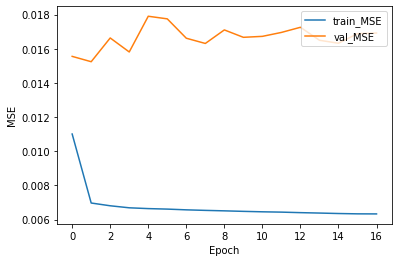

In [58]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un val_MSE de 0.0152  y un val_MAE de 0.0739  en 2 épocas. Se obtiene un mejor resultado que en el modelo 21, por lo que de nuevo se observa que la velocidad del viento no es un buen indicador .Tarda unos 3 minutos por época. No entrena mucho

### Tomamos datos solamente de día y recalculamos

In [91]:
PVOutputdf['Fechayhora']=PVOutputdf['Fechayhora'].astype("string")
PVOutputdf['Hora'] = PVOutputdf['Fechayhora'].str[-8:]
PVOutputdf

,Fechayhora,Energía,Eficiencia,Potencia,Media,Normalizado,Hora
0,2015-03-09 13:15:00,1621,0.037,19457,0,0.0,13:15:00
1,2015-03-09 13:30:00,8048,0.184,25706,25708,0.588,13:30:00
2,2015-03-09 13:45:00,12807.0,0.293,22371.0,22372.0,0.5115,13:45:00
3,2015-03-09 14:00:00,17566,0.402,19036,19036,0.435,14:00:00
4,2015-03-09 14:15:00,19023.333333,0.435333,14633.666667,14634.0,0.334333,14:15:00
...,...,...,...,...,...,...,...
132338,2018-12-16 21:45:00,23290,0.532,0,0,0.0,21:45:00
132339,2018-12-16 22:00:00,23290,0.532,0,0,0.0,22:00:00
132340,2018-12-16 22:15:00,23290,0.532,0,0,0.0,22:15:00
132341,2018-12-16 22:30:00,23290,0.532,0,0,0.0,22:30:00


In [97]:
filtro= (PVOutputdf['Hora']<='22:00:00') & (PVOutputdf['Hora']>='06:00:00') #en el artículo toman las 20 y restando 2h en verano
PVOutputdf.loc[filtro] #observamos que las filas seleccionadas son las deseadas
PVOutputdia=PVOutputdf.loc[filtro] #Si tomamos 16 horas de las 66 que tiene un día, deberíamos tener un 66.6% de filas que en PVGISdf
len(PVOutputdia)/len(PVOutputdf)*100
PVOutputdia.to_pickle("PVOutputdia.pkl")

In [96]:
PVGISdf['Hora'] = PVGISdf['Time'].str[-8:]
filtro= (PVGISdf['Hora']<='22:00:00') & (PVGISdf['Hora']>='06:00:00') #en el artículo toman las 20 y restando 2h en verano
PVGISdf.loc[filtro] #observamos que las filas seleccionadas son las deseadas
PVGISdia=PVGISdf.loc[filtro] #Si tomamos 16 horas de las 66 que tiene un día, deberíamos tener un 66.6% de filas que en PVGISdf
len(PVGISdia)/len(PVGISdf)*100
PVGISdia.to_pickle("PVGISdia.pkl")

In [39]:
PVGISdia = pd.read_pickle("PVGISdia.pkl")

In [40]:
PVOutputdia=pd.read_pickle("PVOutputdia.pkl")

### Modelo 32. Como 31, pero tomando solo datos por el día.

In [98]:
X_train1=np.array(PVGISdia.iloc[1:len(PVGISdia)-38:3,1:4]) #Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=np.array(PVGISdia.iloc[2:len(PVGISdia)-37:3,1:4]) #Tengo datos de radiación de 13:20-16:15 e introduzco producción a las 15:30.
X_train3=np.array(PVGISdia.iloc[3:len(PVGISdia)-36:3,1:4]) #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=np.array(PVGISdia.iloc[4:len(PVGISdia)-35:3,1:4])
X_train5=np.array(PVGISdia.iloc[5:len(PVGISdia)-34:3,1:4])
X_train6=np.array(PVGISdia.iloc[6:len(PVGISdia)-33:3,1:4])
X_train7=np.array(PVGISdia.iloc[7:len(PVGISdia)-32:3,1:4]) 
X_train8=np.array(PVGISdia.iloc[8:len(PVGISdia)-31:3,1:4])
X_train9=np.array(PVGISdia.iloc[9:len(PVGISdia)-30:3,1:4]) 
X_train10=np.array(PVGISdia.iloc[10:len(PVGISdia)-29:3,1:4])
X_train11=np.array(PVGISdia.iloc[11:len(PVGISdia)-28:3,1:4])
X_train12=np.array(PVGISdia.iloc[12:len(PVGISdia)-27:3,1:4]) #Tomo datos hasta las 22:30 del 16/12/2018 para que mi última predicción sea la de las 22:45
X_train13=np.array(PVGISdia.iloc[13:len(PVGISdia)-26:3,1:4])  
X_train14=np.array(PVGISdia.iloc[14:len(PVGISdia)-25:3,1:4]) 
X_train15=np.array(PVGISdia.iloc[15:len(PVGISdia)-24:3,1:4]) 
X_train16=np.array(PVGISdia.iloc[16:len(PVGISdia)-23:3,1:4])
X_train17=np.array(PVGISdia.iloc[17:len(PVGISdia)-22:3,1:4])
X_train18=np.array(PVGISdia.iloc[18:len(PVGISdia)-21:3,1:4])
X_train19=np.array(PVGISdia.iloc[19:len(PVGISdia)-20:3,1:4])  
X_train20=np.array(PVGISdia.iloc[20:len(PVGISdia)-19:3,1:4]) 
X_train21=np.array(PVGISdia.iloc[21:len(PVGISdia)-18:3,1:4]) 
X_train22=np.array(PVGISdia.iloc[22:len(PVGISdia)-17:3,1:4])
X_train23=np.array(PVGISdia.iloc[23:len(PVGISdia)-16:3,1:4])
X_train24=np.array(PVGISdia.iloc[24:len(PVGISdia)-15:3,1:4])
X_train25=np.array(PVGISdia.iloc[25:len(PVGISdia)-14:3,1:4])  
X_train26=np.array(PVGISdia.iloc[26:len(PVGISdia)-13:3,1:4]) 
X_train27=np.array(PVGISdia.iloc[27:len(PVGISdia)-12:3,1:4]) 
X_train28=np.array(PVGISdia.iloc[28:len(PVGISdia)-11:3,1:4])
X_train29=np.array(PVGISdia.iloc[29:len(PVGISdia)-10:3,1:4])
X_train30=np.array(PVGISdia.iloc[30:len(PVGISdia)-9:3,1:4])
X_train31=np.array(PVGISdia.iloc[31:len(PVGISdia)-8:3,1:4])  
X_train32=np.array(PVGISdia.iloc[32:len(PVGISdia)-7:3,1:4]) 
X_train33=np.array(PVGISdia.iloc[33:len(PVGISdia)-6:3,1:4]) 
X_train34=np.array(PVGISdia.iloc[34:len(PVGISdia)-5:3,1:4])
X_train35=np.array(PVGISdia.iloc[35:len(PVGISdia)-4:3,1:4])
X_train36=np.array(PVGISdia.iloc[36:len(PVGISdia)-3:3,1:4])

X_trainatm1=np.array(PVGISdia.iloc[1:len(PVGISdia)-38:3,4:6])  
X_trainatm2=np.array(PVGISdia.iloc[2:len(PVGISdia)-37:3,4:6]) 
X_trainatm3=np.array(PVGISdia.iloc[3:len(PVGISdia)-36:3,4:6]) 
X_trainatm4=np.array(PVGISdia.iloc[4:len(PVGISdia)-35:3,4:6])
X_trainatm5=np.array(PVGISdia.iloc[5:len(PVGISdia)-34:3,4:6])
X_trainatm6=np.array(PVGISdia.iloc[6:len(PVGISdia)-33:3,4:6])
X_trainatm7=np.array(PVGISdia.iloc[7:len(PVGISdia)-32:3,4:6]) 
X_trainatm8=np.array(PVGISdia.iloc[8:len(PVGISdia)-31:3,4:6])
X_trainatm9=np.array(PVGISdia.iloc[9:len(PVGISdia)-30:3,4:6]) 
X_trainatm10=np.array(PVGISdia.iloc[10:len(PVGISdia)-29:3,4:6])
X_trainatm11=np.array(PVGISdia.iloc[11:len(PVGISdia)-28:3,4:6])
X_trainatm12=np.array(PVGISdia.iloc[12:len(PVGISdia)-27:3,4:6])
X_trainatm13=np.array(PVGISdia.iloc[13:len(PVGISdia)-26:3,4:6])  
X_trainatm14=np.array(PVGISdia.iloc[14:len(PVGISdia)-25:3,4:6]) 
X_trainatm15=np.array(PVGISdia.iloc[15:len(PVGISdia)-24:3,4:6]) 
X_trainatm16=np.array(PVGISdia.iloc[16:len(PVGISdia)-23:3,4:6])
X_trainatm17=np.array(PVGISdia.iloc[17:len(PVGISdia)-22:3,4:6])
X_trainatm18=np.array(PVGISdia.iloc[18:len(PVGISdia)-21:3,4:6])
X_trainatm19=np.array(PVGISdia.iloc[19:len(PVGISdia)-20:3,4:6])  
X_trainatm20=np.array(PVGISdia.iloc[20:len(PVGISdia)-19:3,4:6]) 
X_trainatm21=np.array(PVGISdia.iloc[21:len(PVGISdia)-18:3,4:6]) 
X_trainatm22=np.array(PVGISdia.iloc[22:len(PVGISdia)-17:3,4:6])
X_trainatm23=np.array(PVGISdia.iloc[23:len(PVGISdia)-16:3,4:6])
X_trainatm24=np.array(PVGISdia.iloc[24:len(PVGISdia)-15:3,4:6])
X_trainatm25=np.array(PVGISdia.iloc[25:len(PVGISdia)-14:3,4:6])  
X_trainatm26=np.array(PVGISdia.iloc[26:len(PVGISdia)-13:3,4:6]) 
X_trainatm27=np.array(PVGISdia.iloc[27:len(PVGISdia)-12:3,4:6]) 
X_trainatm28=np.array(PVGISdia.iloc[28:len(PVGISdia)-11:3,4:6])
X_trainatm29=np.array(PVGISdia.iloc[29:len(PVGISdia)-10:3,4:6])
X_trainatm30=np.array(PVGISdia.iloc[30:len(PVGISdia)-9:3,4:6])
X_trainatm31=np.array(PVGISdia.iloc[31:len(PVGISdia)-8:3,4:6])  
X_trainatm32=np.array(PVGISdia.iloc[32:len(PVGISdia)-7:3,4:6]) 
X_trainatm33=np.array(PVGISdia.iloc[33:len(PVGISdia)-6:3,4:6]) 
X_trainatm34=np.array(PVGISdia.iloc[34:len(PVGISdia)-5:3,4:6])
X_trainatm35=np.array(PVGISdia.iloc[35:len(PVGISdia)-4:3,4:6])
X_trainatm36=np.array(PVGISdia.iloc[36:len(PVGISdia)-3:3,4:6])


y_train=np.array(PVOutputdia.iloc[13:len(PVOutputdf),5]).astype(float) #No tomo los primeros 7 valores para cuadrarlo, que empiece a las 16:30

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 
X_train7std=np.std(X_train7) 
X_train8std=np.std(X_train8)
X_train9std=np.std(X_train9)
X_train10std=np.std(X_train10) 
X_train11std=np.std(X_train11) 
X_train12std=np.std(X_train12)
X_train13std=np.std(X_train13) 
X_train14std=np.std(X_train14) 
X_train15std=np.std(X_train15)
X_train16std=np.std(X_train16)
X_train17std=np.std(X_train17) 
X_train18std=np.std(X_train18)
X_train19std=np.std(X_train19) 
X_train20std=np.std(X_train20) 
X_train21std=np.std(X_train21)
X_train22std=np.std(X_train22)
X_train23std=np.std(X_train23) 
X_train24std=np.std(X_train24)
X_train25std=np.std(X_train25) 
X_train26std=np.std(X_train26) 
X_train27std=np.std(X_train27)
X_train28std=np.std(X_train28)
X_train29std=np.std(X_train29) 
X_train30std=np.std(X_train30)
X_train31std=np.std(X_train31) 
X_train32std=np.std(X_train32) 
X_train33std=np.std(X_train33)
X_train34std=np.std(X_train34)
X_train35std=np.std(X_train35) 
X_train36std=np.std(X_train36) 


X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 
X_train7est=X_train7/X_train7std 
X_train8est=X_train8/X_train8std
X_train9est=X_train9/X_train9std 
X_train10est=X_train10/X_train10std 
X_train11est=X_train11/X_train11std 
X_train12est=X_train12/X_train12std
X_train13est=X_train13/X_train13std 
X_train14est=X_train14/X_train14std
X_train15est=X_train15/X_train15std 
X_train16est=X_train16/X_train16std 
X_train17est=X_train17/X_train17std 
X_train18est=X_train18/X_train18std
X_train19est=X_train19/X_train19std 
X_train20est=X_train20/X_train20std
X_train21est=X_train21/X_train21std 
X_train22est=X_train22/X_train22std 
X_train23est=X_train23/X_train23std 
X_train24est=X_train24/X_train24std
X_train25est=X_train25/X_train25std 
X_train26est=X_train26/X_train26std
X_train27est=X_train27/X_train27std 
X_train28est=X_train28/X_train28std 
X_train29est=X_train29/X_train29std 
X_train30est=X_train30/X_train30std
X_train31est=X_train31/X_train31std 
X_train32est=X_train32/X_train32std
X_train33est=X_train33/X_train33std 
X_train34est=X_train34/X_train34std 
X_train35est=X_train35/X_train35std 
X_train36est=X_train36/X_train36std

X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est,X_train7est,X_train8est,X_train9est,X_train10est,X_train11est,X_train12est,X_train13est,X_train14est,X_train15est,X_train16est,X_train17est,X_train18est,X_train19est,X_train20est,X_train21est,X_train22est,X_train23est,X_train24est,X_train25est,X_train26est,X_train27est,X_train28est,X_train29est,X_train30est,X_train31est,X_train32est,X_train33est,X_train34est,X_train35est,X_train36est)

X_trainatm1std=np.std(X_trainatm1)  
X_trainatm2std=np.std(X_trainatm2) 
X_trainatm3std=np.std(X_trainatm3) 
X_trainatm4std=np.std(X_trainatm4)
X_trainatm5std=np.std(X_trainatm5)
X_trainatm6std=np.std(X_trainatm6)
X_trainatm7std=np.std(X_trainatm7)
X_trainatm8std=np.std(X_trainatm8)
X_trainatm9std=np.std(X_trainatm9) 
X_trainatm10std=np.std(X_trainatm10)
X_trainatm11std=np.std(X_trainatm11)
X_trainatm12std=np.std(X_trainatm12)
X_trainatm13std=np.std(X_trainatm13)
X_trainatm14std=np.std(X_trainatm14)
X_trainatm15std=np.std(X_trainatm15) 
X_trainatm16std=np.std(X_trainatm16)
X_trainatm17std=np.std(X_trainatm17)
X_trainatm18std=np.std(X_trainatm18)
X_trainatm19std=np.std(X_trainatm19)
X_trainatm20std=np.std(X_trainatm20)
X_trainatm21std=np.std(X_trainatm21) 
X_trainatm22std=np.std(X_trainatm22)
X_trainatm23std=np.std(X_trainatm23)
X_trainatm24std=np.std(X_trainatm24)
X_trainatm25std=np.std(X_trainatm25)
X_trainatm26std=np.std(X_trainatm26)
X_trainatm27std=np.std(X_trainatm27) 
X_trainatm28std=np.std(X_trainatm28)
X_trainatm29std=np.std(X_trainatm29)
X_trainatm30std=np.std(X_trainatm30)
X_trainatm31std=np.std(X_trainatm31)
X_trainatm32std=np.std(X_trainatm32)
X_trainatm33std=np.std(X_trainatm33) 
X_trainatm34std=np.std(X_trainatm34)
X_trainatm35std=np.std(X_trainatm35)
X_trainatm36std=np.std(X_trainatm36)

X_trainatm1est=X_trainatm1/X_trainatm1std 
X_trainatm2est=X_trainatm2/X_trainatm2std 
X_trainatm3est=X_trainatm3/X_trainatm3std 
X_trainatm4est=X_trainatm4/X_trainatm4std
X_trainatm5est=X_trainatm5/X_trainatm5std 
X_trainatm6est=X_trainatm6/X_trainatm6std 
X_trainatm7est=X_trainatm7/X_trainatm7std 
X_trainatm8est=X_trainatm8/X_trainatm8std
X_trainatm9est=X_trainatm9/X_trainatm9std 
X_trainatm10est=X_trainatm10/X_trainatm10std 
X_trainatm11est=X_trainatm11/X_trainatm11std 
X_trainatm12est=X_trainatm12/X_trainatm12std
X_trainatm13est=X_trainatm13/X_trainatm13std 
X_trainatm14est=X_trainatm14/X_trainatm14std 
X_trainatm15est=X_trainatm15/X_trainatm15std
X_trainatm16est=X_trainatm16/X_trainatm16std 
X_trainatm17est=X_trainatm17/X_trainatm17std 
X_trainatm18est=X_trainatm18/X_trainatm18std
X_trainatm19est=X_trainatm19/X_trainatm19std 
X_trainatm20est=X_trainatm20/X_trainatm20std 
X_trainatm21est=X_trainatm21/X_trainatm21std
X_trainatm22est=X_trainatm22/X_trainatm22std 
X_trainatm23est=X_trainatm23/X_trainatm23std 
X_trainatm24est=X_trainatm24/X_trainatm24std
X_trainatm25est=X_trainatm25/X_trainatm25std 
X_trainatm26est=X_trainatm26/X_trainatm26std 
X_trainatm27est=X_trainatm27/X_trainatm27std
X_trainatm28est=X_trainatm28/X_trainatm28std 
X_trainatm29est=X_trainatm29/X_trainatm29std 
X_trainatm30est=X_trainatm30/X_trainatm30std
X_trainatm31est=X_trainatm31/X_trainatm31std 
X_trainatm32est=X_trainatm32/X_trainatm32std 
X_trainatm33est=X_trainatm33/X_trainatm33std
X_trainatm34est=X_trainatm34/X_trainatm34std 
X_trainatm35est=X_trainatm35/X_trainatm35std 
X_trainatm36est=X_trainatm36/X_trainatm36std

X_trainatmest=(X_trainatm1est,X_trainatm2est,X_trainatm3est,X_trainatm4est,X_trainatm5est,X_trainatm6est,X_trainatm7est,X_trainatm8est,X_trainatm9est,X_trainatm10est,X_trainatm11est,X_trainatm12est,X_trainatm13est,X_trainatm14est,X_trainatm15est,X_trainatm16est,X_trainatm17est,X_trainatm18est,X_trainatm19est,X_trainatm20est,X_trainatm21est,X_trainatm22est,X_trainatm23est,X_trainatm24est,X_trainatm25est,X_trainatm26est,X_trainatm27est,X_trainatm28est,X_trainatm29est,X_trainatm30est,X_trainatm31est,X_trainatm32est,X_trainatm33est,X_trainatm34est,X_trainatm35est,X_trainatm36est)



In [99]:
#Entradas
entrada1 = tf.keras.layers.Input(shape=3) 
entrada2 = tf.keras.layers.Input(shape=3)
entrada3 = tf.keras.layers.Input(shape=3)
entrada4 = tf.keras.layers.Input(shape=3)
entrada5 = tf.keras.layers.Input(shape=3)
entrada6 = tf.keras.layers.Input(shape=3)
entrada7 = tf.keras.layers.Input(shape=3)
entrada8 = tf.keras.layers.Input(shape=3)
entrada9 = tf.keras.layers.Input(shape=3)
entrada10 = tf.keras.layers.Input(shape=3)
entrada11 = tf.keras.layers.Input(shape=3)
entrada12 = tf.keras.layers.Input(shape=3)
entrada13 = tf.keras.layers.Input(shape=3)
entrada14 = tf.keras.layers.Input(shape=3)
entrada15 = tf.keras.layers.Input(shape=3)
entrada16 = tf.keras.layers.Input(shape=3)
entrada17 = tf.keras.layers.Input(shape=3)
entrada18 = tf.keras.layers.Input(shape=3)
entrada19 = tf.keras.layers.Input(shape=3)
entrada20 = tf.keras.layers.Input(shape=3)
entrada21 = tf.keras.layers.Input(shape=3)
entrada22 = tf.keras.layers.Input(shape=3)
entrada23 = tf.keras.layers.Input(shape=3)
entrada24 = tf.keras.layers.Input(shape=3)
entrada25 = tf.keras.layers.Input(shape=3)
entrada26 = tf.keras.layers.Input(shape=3)
entrada27 = tf.keras.layers.Input(shape=3)
entrada28 = tf.keras.layers.Input(shape=3)
entrada29 = tf.keras.layers.Input(shape=3)
entrada30 = tf.keras.layers.Input(shape=3)
entrada31 = tf.keras.layers.Input(shape=3)
entrada32 = tf.keras.layers.Input(shape=3)
entrada33 = tf.keras.layers.Input(shape=3)
entrada34 = tf.keras.layers.Input(shape=3)
entrada35 = tf.keras.layers.Input(shape=3)
entrada36 = tf.keras.layers.Input(shape=3)

entradaatm1 = tf.keras.layers.Input(shape=2) 
entradaatm2 = tf.keras.layers.Input(shape=2)
entradaatm3 = tf.keras.layers.Input(shape=2)
entradaatm4 = tf.keras.layers.Input(shape=2)
entradaatm5 = tf.keras.layers.Input(shape=2)
entradaatm6 = tf.keras.layers.Input(shape=2)
entradaatm7 = tf.keras.layers.Input(shape=2)
entradaatm8 = tf.keras.layers.Input(shape=2)
entradaatm9 = tf.keras.layers.Input(shape=2)
entradaatm10 = tf.keras.layers.Input(shape=2)
entradaatm11 = tf.keras.layers.Input(shape=2)
entradaatm12 = tf.keras.layers.Input(shape=2)
entradaatm13 = tf.keras.layers.Input(shape=2)
entradaatm14 = tf.keras.layers.Input(shape=2)
entradaatm15 = tf.keras.layers.Input(shape=2) 
entradaatm16 = tf.keras.layers.Input(shape=2)
entradaatm17 = tf.keras.layers.Input(shape=2)
entradaatm18 = tf.keras.layers.Input(shape=2)
entradaatm19 = tf.keras.layers.Input(shape=2)
entradaatm20 = tf.keras.layers.Input(shape=2)
entradaatm21 = tf.keras.layers.Input(shape=2) 
entradaatm22 = tf.keras.layers.Input(shape=2)
entradaatm23 = tf.keras.layers.Input(shape=2)
entradaatm24 = tf.keras.layers.Input(shape=2)
entradaatm25 = tf.keras.layers.Input(shape=2)
entradaatm26 = tf.keras.layers.Input(shape=2)
entradaatm27 = tf.keras.layers.Input(shape=2) 
entradaatm28 = tf.keras.layers.Input(shape=2)
entradaatm29 = tf.keras.layers.Input(shape=2)
entradaatm30 = tf.keras.layers.Input(shape=2)
entradaatm31 = tf.keras.layers.Input(shape=2)
entradaatm32 = tf.keras.layers.Input(shape=2)
entradaatm33 = tf.keras.layers.Input(shape=2) 
entradaatm34 = tf.keras.layers.Input(shape=2)
entradaatm35 = tf.keras.layers.Input(shape=2)
entradaatm36 = tf.keras.layers.Input(shape=2)

#Capas ocultas formula 3: Hidden=1/2*(In + Out)+ SQRT(Training)=1/2*(3 + 1)+ np.sqrt(132323)=365.7622850159153
oculta1 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada1)  #Necesitaria 12 cada uno aunando sus entradas
oculta2 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada2)
oculta3 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada3) #NO tarda menos introduciendo los
oculta4 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada4) #números en vez de las fórmulas 
oculta5 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada5) #comprobado
oculta6 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada6)
oculta7 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada7)
oculta8 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada8)
oculta9 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada9)
oculta10 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada10)
oculta11 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada11)
oculta12 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada12)
oculta13 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada13)
oculta14 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada14)
oculta15 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada15)
oculta16 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada16)
oculta17 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada17)
oculta18 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada18)
oculta19 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada19)
oculta20 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada20)
oculta21 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada21)
oculta22 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada22)
oculta23 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada23)
oculta24 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada24)
oculta25 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada25)
oculta26 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada26)
oculta27 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada27)
oculta28 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada28)
oculta29 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada29)
oculta30 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada30)
oculta31 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada31)
oculta32 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada32)
oculta33 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada33)
oculta34 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada34)
oculta35 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada35)
oculta36 = tf.keras.layers.Dense(365.7622850159153, activation="relu")(entrada36)


concat = tf.keras.layers.Concatenate()([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, oculta7, oculta8, oculta9, oculta10, oculta11, oculta12, oculta13, oculta14, oculta15, oculta16, oculta17, oculta18, oculta19, oculta20, oculta21, oculta22, oculta23, oculta24, oculta25, oculta26, oculta27, oculta28, oculta29, oculta30, oculta31, oculta32, oculta33, oculta34, oculta35, oculta36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36]) #estratificada, concatena las 12
#2 layers intermedias, Neuronas formula 3: Hidden=1/2*(In + Out)+ SQRT(Training)=1/2*(1 + 1)+ np.sqrt(132323)
adoculta1=tf.keras.layers.Dense(1/2*(1 + 1)+ np.sqrt(132323), activation="relu")(concat)
adoculta2=tf.keras.layers.Dense(1/2*(1 + 1)+ np.sqrt(132323), activation="relu")(adoculta1)
salida=tf.keras.layers.Dense(1/2*(1 + 1)+ np.sqrt(132323), activation='relu')(adoculta2) #produccion en los siguientes 15 minutos
modelo32 = tf.keras.models.Model(inputs=[entrada1, entrada2, entrada3, entrada4, entrada5, entrada6, entrada7, entrada8, entrada9, entrada10, entrada11, entrada12, entrada13, entrada14, entrada15, entrada16, entrada17, entrada18, entrada19, entrada20, entrada21, entrada22, entrada23, entrada24, entrada25, entrada26, entrada27, entrada28, entrada29, entrada30, entrada31, entrada32, entrada33, entrada34, entrada35, entrada36,entradaatm1,entradaatm2,entradaatm3,entradaatm4,entradaatm5,entradaatm6,entradaatm7,entradaatm8,entradaatm9,entradaatm10,entradaatm11,entradaatm12,entradaatm13,entradaatm14,entradaatm15,entradaatm16,entradaatm17,entradaatm18,entradaatm19,entradaatm20,entradaatm21,entradaatm22,entradaatm23,entradaatm24,entradaatm25,entradaatm26,entradaatm27,entradaatm28,entradaatm29,entradaatm30,entradaatm31,entradaatm32,entradaatm33,entradaatm34,entradaatm35,entradaatm36], outputs=[salida])

modelo32.compile(optimizer='adam', #por ahora uso adam si no da nada raro
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mae']) #Metrics es otra métrica que también te mida a parte de la función de pérdidas[]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modelo32.fit([X_trainest,X_trainatmest], y_train, epochs=1000,callbacks=[callback],validation_split=0.2)
#Mucho mejor resultado introduciendo entre corchetes que entre paréntesis (X_trainest,X_trainatmest)
#No estoy 100% seguro de que esté bien introducido así, cómo sabe que las entradai corresponden a X_train y que entradaatmi corresponden a X_trainatm?

Epoch 1/1000
2217/2217 [==============================] - 105s 46ms/step - loss: 0.0610 - mae: 0.2111 - val_loss: 0.0677 - val_mae: 0.2287
Epoch 2/1000
2217/2217 [==============================] - 104s 47ms/step - loss: 0.0595 - mae: 0.2105 - val_loss: 0.0679 - val_mae: 0.2286
Epoch 3/1000
2217/2217 [==============================] - 102s 46ms/step - loss: 0.0589 - mae: 0.2096 - val_loss: 0.0673 - val_mae: 0.2236
Epoch 4/1000
2217/2217 [==============================] - 102s 46ms/step - loss: 0.0582 - mae: 0.2089 - val_loss: 0.0677 - val_mae: 0.2261
Epoch 5/1000
2217/2217 [==============================] - 102s 46ms/step - loss: 0.0579 - mae: 0.2083 - val_loss: 0.0679 - val_mae: 0.2229
Epoch 6/1000
2217/2217 [==============================] - 109s 49ms/step - loss: 0.0576 - mae: 0.2078 - val_loss: 0.0688 - val_mae: 0.2316
Epoch 7/1000
2217/2217 [==============================] - 106s 48ms/step - loss: 0.0575 - mae: 0.2075 - val_loss: 0.0680 - val_mae: 0.2265
Epoch 8/1000
2217/2217 [===

Text(0, 0.5, 'MSE')

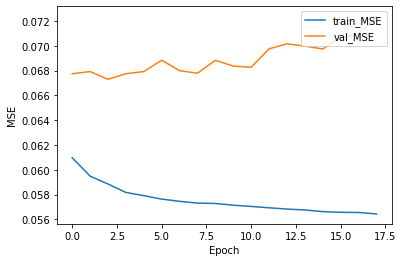

In [100]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Obtenemos un val MSE de 0.0673 y un val MAE de 0.2357 en 3 épocas. Resultados peores que en el artículo pero coherentes por no seguir la estructura exacta e interpolar los datos de satélite, en vez de utilizar 3.

### Transformamos PVOutputdf para que no muestre la radiación acumulada en todo el día, sino la de los 15 minutos previos

In [777]:
PVOutputdf=pd.read_pickle("PVOutputdefin.pkl")
PVOutputdf.iloc[:50,:]

,Datetime,Energy,Date,Time
0,2015-03-09 13:15:00,1621,20150309,14:15
1,2015-03-09 13:30:00,8048,20150309,14:30
2,2015-03-09 13:45:00,12807.0,20150309,14:45
3,2015-03-09 14:00:00,17566,20150309,15:00
4,2015-03-09 14:15:00,19023.333333,20150309,15:15
5,2015-03-09 14:30:00,20480.666667,20150309,15:30
6,2015-03-09 14:45:00,21938,20150309,15:45
7,2015-03-09 15:00:00,25738,20150309,16:00
8,2015-03-09 15:15:00,29436,20150309,16:15
9,2015-03-09 15:30:00,32655,20150309,16:30


In [779]:
energia=PVOutputdf["Energy"].diff()
energia.iloc[0]=1621
energia.isnull().values.any() #No hay nulos
#Los que no hay que restar son los negativos que solo puede ser el inicio de un día menos el final del siguiente
#comprobamos que el número de números negativos sea igual al número de días
print(energia.where(energia < 0).count()) #1378 valores negativos y 1378 días entre ambas fechas, así que es justo en el cambio de día, luego en los valores en los que la diferencia es negativa, la energía generada es 0
energia[energia < 0] = 0
print(energia.where(energia < 0).count()) #ya no hay valores negativos, lo introducimos en el df
PVOutputdf['Energy'] = energia
PVOutputdf

1378
0


,Datetime,Energy,Date,Time
0,2015-03-09 13:15:00,1621,20150309,14:15
1,2015-03-09 13:30:00,6427,20150309,14:30
2,2015-03-09 13:45:00,4759.0,20150309,14:45
3,2015-03-09 14:00:00,4759.0,20150309,15:00
4,2015-03-09 14:15:00,1457.333333,20150309,15:15
...,...,...,...,...
132322,2018-12-16 21:45:00,0,20181216,22:45
132323,2018-12-16 22:00:00,0,20181216,23:00
132324,2018-12-16 22:15:00,0,20181216,23:15
132325,2018-12-16 22:30:00,0,20181216,23:30


In [780]:
pot=43740/4 #capacidad de potencia o tamaño de la instalación en W entre 4, máximo que se puede producir en 15 mins
maxenergy=PVOutputdf['Energy'].max()
print(pot)
print(maxenergy) #numeros coherentes, nunca se llega a generar más del máximo

10935.0
9732


In [784]:
#El MAE calculado como en el artículo 24 sería el mío multiplicado por la desviación estandar y dividido entre la potencia máx:
factormae=Y_trainstd/pot
print(factormae)
factormse=(Y_trainstd**2)/(pot**2) #Y_trainstd=79708.65
print(factormse)
#sin producción
print(0.2191*factormae)
print(0.1598*factormse)
#con producción
print(0.0431*factormae)
print(0.0394*factormse)
#los errores aumentan enormemente

7.289314689176596
53.13410863784569
1.597088848398592
8.490830560327742
0.3141694631035113
2.09348388033112


### Errores en el mejor modelo sin producción serían un val_MAE=1.597 y un val_MSE=8.49
### En el mejor modelo con producción serían un val_MAE=0.314 y un val_MSE=2.09

### Descarga de datos de PVGIS para implementar una red neuronal convolucional. Descargamos, en vez de datos de radiación y atmosféricos de la localización exacta de la planta solar, estos datos en un marco espacial de 100 kilómetros cuadrados, es decir, un cuadrado de 10 km de lado con la planta en el centro

In [787]:
linksinubi="https://re.jrc.ec.europa.eu/api/v5_2/seriescalc?raddatabase=PVGIS-SARAH2&startyear=2015&endyear=2016&angle=35&aspect=0&components=1&outputformat=csv&lat="
lat0=41.924
lon0=1.655
latlim=40.924
lonlim=2.655

In [ ]:
#rate limit of 30 calls/second per IP address
while lat0 <= latlim:
    
    #PASAR INT A STRING PARA PODER CONCATENAR Y QUE FUNCIONE EL LINK
    lat0=str(lat0) #Pasamos de int
    
    #TENGO QUE HACER QUE EL DF VAYA GUARDANDO LOS DISTINTOS DÍAS, AHORA MISMO LO GUARDA ENCIMA
    #try:
    #    df1 = pd.read_csv(linksinubi+lat0, header=None, sep='@', dtype=str) # Leemos los datos--> sep=@ para que esté todo en la misma celda
        
    #except:
        
        #time.sleep(3600) #esperar una hora cuando no permita el acceso a la API 
    df1 = pd.read_csv(linksinubi+lat0, header=None, sep='@', dtype=str) # Revisar lo de header Leemos los datos--> sep=@ para que esté todo en la misma celda
        
    df1 = df1[0].str.replace(" ","\n") #la separación entre días es "" y hago que sea cambio de línea
    df1 = df1[0].split("\n") # divide por filas
    df1 = pd.DataFrame(pd.Series(df1).str.split(",", expand=True)) # divide por columnas
   
    #for i in range(len(df1.columns)-3): #eliminar las columnas (3:end)
        
     #   df1.drop(i+3, inplace=True, axis=1)
        
    
    frames = [df, df1]
    df = pd.concat(frames)
    
     
    # VUELVO A PASAR DE STRING A ENTERO PARA PODER SEGUIR ITERANDO
    lat0=int(lat0)
    
    lat0 +=1 #paso de tiempo
    

In [4]:
VARIABLE_MAP = {
    'G(h)': 'ghi',
    'Gb(n)': 'dni',
    'Gd(h)': 'dhi',
    'G(i)': 'poa_global',
    'Gb(i)': 'poa_direct',
    'Gd(i)': 'poa_sky_diffuse',
    'Gr(i)': 'poa_ground_diffuse',
    'H_sun': 'solar_elevation',
    'T2m': 'temp_air',
    'RH': 'relative_humidity',
    'SP': 'pressure',
    'WS10m': 'wind_speed',
    'WD10m': 'wind_direction',
}


def _parse_pvgis_hourly_json(src, map_variables):
    inputs = src['inputs']
    metadata = src['meta']
    data = pd.DataFrame(src['outputs']['hourly'])
    data.index = pd.to_datetime(data['time'], format='%Y%m%d:%H%M', utc=True)
    data = data.drop('time', axis=1)
    data = data.astype(dtype={'Int': 'int'})  # The 'Int' column to be integer
    if map_variables:
        data = data.rename(columns=VARIABLE_MAP)
    return data, inputs, metadata

def read_pvgis_hourly(filename, pvgis_format=None, map_variables=True):
    if pvgis_format is None:
        # get the file extension from suffix, but remove the dot and make sure
        # it's lower case to compare with csv, or json
        # NOTE: basic format is not supported for PVGIS Hourly as the data
        # format does not include a header
        # NOTE: raises TypeError if filename is a buffer
        outputformat = Path(filename).suffix[1:].lower()
    else:
        outputformat = pvgis_format
        
    if outputformat == 'json':
        try:
            src = json.load(filename)
        except AttributeError:  # str/path has no .read() attribute
            with open(str(filename), 'r') as fbuf:
                src = json.load(fbuf)
        return _parse_pvgis_hourly_json(src, map_variables=map_variables)


def get_pvgis_hourly(latitude, longitude, start, end,
                     raddatabase, components,
                     surface_tilt, surface_azimuth,
                     outputformat='json',
                     usehorizon=False, userhorizon=None,
                     pvcalculation=False,
                     peakpower=None, pvtechchoice='crystSi',
                     mountingplace='free', loss=0, trackingtype=0,
                     optimal_surface_tilt=False, optimalangles=False,
                     url="https://re.jrc.ec.europa.eu/api/v5_2/", map_variables=True, timeout=30):
    
    params = {'lat': latitude, 'lon': longitude, 'outputformat': outputformat,
              'angle': surface_tilt, 'aspect': surface_azimuth,
              'pvcalculation': int(pvcalculation),
              'pvtechchoice': pvtechchoice, 'mountingplace': mountingplace,
              'trackingtype': trackingtype, 'components': int(components),
              'usehorizon': int(usehorizon),
              'optimalangles': int(optimalangles),
              'optimalinclination': int(optimal_surface_tilt), 'loss': loss}
    # pvgis only takes 0 for False, and 1 for True, not strings
    if userhorizon is not None:
        params['userhorizon'] = ','.join(str(x) for x in userhorizon)
    if raddatabase is not None:
        params['raddatabase'] = raddatabase
    if start is not None:
        params['startyear'] = start if isinstance(start, int) else start.year
    if end is not None:
        params['endyear'] = end if isinstance(end, int) else end.year
    if peakpower is not None:
        params['peakpower'] = peakpower
        
    res = requests.get(url + 'seriescalc', params=params, timeout=timeout)
    if not res.ok:
        try:
            err_msg = res.json()
        except Exception:
            res.raise_for_status()
        else:
            raise requests.HTTPError(err_msg['message'])

    return read_pvgis_hourly(io.StringIO(res.text), pvgis_format=outputformat,
                             map_variables=map_variables)

 

In [792]:
#data, meta, inputs = get_pvgis_hourly(latitude=41.424, longitude=2.155, start=2015, end=2018, raddatabase="PVGIS-SARAH2", components=True,
#                     surface_tilt=35, surface_azimuth=0)
data = get_pvgis_hourly(latitude=lat0, longitude=lon0, start=2015, end=2018, raddatabase="PVGIS-SARAH2", components=True,
                     surface_tilt=35, surface_azimuth=0)[0]
data


,poa_direct,poa_sky_diffuse,poa_ground_diffuse,solar_elevation,temp_air,wind_speed,Int
time,,,,,,,
2015-01-01 00:10:00+00:00,0.0,0.0,0.0,0.0,1.32,0.41,0
2015-01-01 01:10:00+00:00,0.0,0.0,0.0,0.0,1.19,0.55,0
2015-01-01 02:10:00+00:00,0.0,0.0,0.0,0.0,0.08,0.48,0
2015-01-01 03:10:00+00:00,0.0,0.0,0.0,0.0,-1.17,0.14,0
2015-01-01 04:10:00+00:00,0.0,0.0,0.0,0.0,-0.69,0.07,0
...,...,...,...,...,...,...,...
2018-12-31 19:10:00+00:00,0.0,0.0,0.0,0.0,4.24,1.86,0
2018-12-31 20:10:00+00:00,0.0,0.0,0.0,0.0,2.90,1.86,0
2018-12-31 21:10:00+00:00,0.0,0.0,0.0,0.0,1.45,1.86,0


### Tengo que hacer 9 bucles para la matriz de 9km x 9km porque en uno solo demasiadas llamadas a la API

In [5]:
date = (pd.DataFrame(columns=['NULL'],
                              index=pd.date_range('20150101-00:00:00', '20181231-23:55:00',
                                                  freq='5T'))
                   .index.strftime('%Y%m%d-%H:%M:%S')
                 .tolist()
            )

In [7]:
#cada 35064 filas corresponden a una localización del mapa cada 0.01 grados
xip=np.linspace(0,35063,35064)
xnew=np.linspace(0,35063,12*35064)
lat0=41.464
lon0=2.115
cols=["poa_direct", "poa_sky_diffuse", "poa_ground_diffuse", "solar_elevation", "temp_air", "wind_speed", "Int"]
#data1=pd.DataFrame(columns=cols)
#data1=np.empty((35064,1,1,0))
#data1=np.empty()
inicial=1
    
for k in range (9):
    lon0=2.115
    initial=1    
    for j in range (9):
        
        if initial:

            data1=get_pvgis_hourly(latitude=lat0, longitude=lon0, start=2015, end=2018, raddatabase="PVGIS-SARAH2", components=True,
                             surface_tilt=35, surface_azimuth=0)[0]
            
            y1ip=data1.iloc[:,0]
            f1=interp1d(xip,y1ip)
            y1new=f1(xnew)
            
            y2ip=data1.iloc[:,1]
            f2=interp1d(xip,y2ip)
            y2new=f2(xnew)

            y3ip=data1.iloc[:,2]
            f3=interp1d(xip,y3ip)
            y3new=f3(xnew)

            y4ip=data1.iloc[:,3]
            f4=interp1d(xip,y4ip)
            y4new=f4(xnew)

            y5ip=data1.iloc[:,4]
            f5=interp1d(xip,y5ip)
            y5new=f5(xnew)

            y6ip=data1.iloc[:,5]
            f6=interp1d(xip,y6ip)
            y6new=f6(xnew)
            
            
            
            dictio={'Time':date,'Gb(i)':y1new,'Gd(i)':y2new,'Gr(i)':y3new,'H_sun':y4new,'T2m':y5new,'WS10m':y6new }
            data1=pd.DataFrame.from_dict(dictio)
            data1=np.array(data1)
            data1=np.reshape(data1,(data1.shape[0],1,1,7))
            initial=0
        else:


            dfaux = get_pvgis_hourly(latitude=lat0, longitude=lon0, start=2015, end=2018, raddatabase="PVGIS-SARAH2", components=True,
                             surface_tilt=35, surface_azimuth=0)[0]

            y1ip=dfaux.iloc[:,0]
            f1=interp1d(xip,y1ip)
            y1new=f1(xnew)
            
            y2ip=dfaux.iloc[:,1]
            f2=interp1d(xip,y2ip)
            y2new=f2(xnew)

            y3ip=dfaux.iloc[:,2]
            f3=interp1d(xip,y3ip)
            y3new=f3(xnew)

            y4ip=dfaux.iloc[:,3]
            f4=interp1d(xip,y4ip)
            y4new=f4(xnew)

            y5ip=dfaux.iloc[:,4]
            f5=interp1d(xip,y5ip)
            y5new=f5(xnew)

            y6ip=dfaux.iloc[:,5]
            f6=interp1d(xip,y6ip)
            y6new=f6(xnew)
            
            
            dictio={'Time':date,'Gb(i)':y1new,'Gd(i)':y2new,'Gr(i)':y3new,'H_sun':y4new,'T2m':y5new,'WS10m':y6new }
            dfaux=pd.DataFrame.from_dict(dictio)
            dfaux=np.array(dfaux)
            dfaux=np.reshape(dfaux,(dfaux.shape[0],1,1,7))
            data1=np.concatenate((data1,dfaux),axis=2)
            lon0+=0.01
            
    if inicial:    
        data=data1
        inicial=0
    else:
        data=np.concatenate((data,data1),axis=1)
        
    lat0-=0.01    
     
        

In [8]:
data.shape #Una dimension son todos los datos temporales de una localización (420768), otra son las 9 latitudes
#otra las 9 longitudes y otra los 7 factores atmosféricos (incluyendo radiacion)

(420768, 9, 9, 7)

In [9]:
len(data) #data abarca todo 2015 y 2018, así que le tengo que restar los elementos del principio y el final.
#Desde el 1 de enero de 2015 a las 00:00 al 9 de marzo de 2015 a las 13:15 y desde el 16 de diciembre a las 22:45 hasta el 31 de diciembre a las 23:45
#19455 5minutos y 4334 5minutos

420768

In [10]:
data=data[19455:,:,:,:]
data=data[:-4334,:,:,:]
len(data)

396981

In [15]:
data[0,0,0,0]

'20150309-13:15:00'

In [52]:
data[-1,0,0,0]

'20181216-22:45:00'

In [6]:
from tempfile import TemporaryFile
outfile = TemporaryFile()
np.save(outfile, data)
_ = outfile.seek(0) # Only needed here to simulate closing & reopening file
np.load(outfile)

ValueError: Object arrays cannot be loaded when allow_pickle=False

In [134]:
#data.shape
np.mean(data[:,:,:,3:7], axis=(1,2))

array([[0.        , 4.76111111, 3.18111111, 0.        ],
       [0.        , 4.94777778, 4.06333333, 0.        ],
       [0.        , 5.44111111, 4.50444444, 0.        ],
       ...,
       [0.        , 7.84777778, 2.68222222, 0.        ],
       [0.        , 7.51333333, 2.52666667, 0.        ],
       [0.        , 7.26666667, 2.42555556, 0.        ]])

In [141]:
data[1:12,0,0,0] #el valor de la radiación directa (dato 0 atmosférico) en la lat0 lon 0 entre las 00 y las 11

array([  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  , 100.27,
       343.96, 502.43, 673.82])

In [ ]:
data[1:12,0,0,0] 

### Creación de un filtro para tomar solamente datos de día

In [ ]:
PVGISdf['Hora'] = PVGISdf['Time'].str[-8:]
filtro= (PVGISdf['Hora']<='22:00:00') & (PVGISdf['Hora']>='06:00:00') #en el artículo toman las 20 y restando 2h en verano
PVGISdf.loc[filtro] #observamos que las filas seleccionadas son las deseadas
PVGISdia=PVGISdf.loc[filtro] #Si tomamos 16 horas de las 66 que tiene un día, deberíamos tener un 66.6% de filas que en PVGISdf
len(PVGISdia)/len(PVGISdf)*100
PVGISdia.to_pickle("PVGISdia.pkl")

In [119]:
len(PVGISdia)

266060

In [116]:
len(PVGISdf)

396979

In [127]:
len(data[B,0,0,0])

266060

In [148]:
#[x[-8:] for x in data[:,0,0,0]]
A=np.array([str(x)[-8:] for x in data[:,0,0,0]])
B=np.array([(i >='06:00:00' and i <='22:00:00') for i in A ]) #if i >='06:00:00'                                      #C=np.array([i >='06:00:00' for i in B])
datadia=data[B,:,:,:]

In [149]:
datadia.shape

(266060, 9, 9, 7)

In [140]:
data.shape

(396979, 9, 9, 7)

### Modelo 0 de red neuronal "convolucional", simplemente los datos de entrada y una neurona de salida

In [18]:
modeloc0 = models.Sequential()
modeloc0.add(layers.Dense(1, activation='relu',input_shape=(9,9,3)))
modeloc0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9, 9, 1)           4         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [101]:
X_train1=np.array(data[0:len(data)-3:3,:,:,1:4]).astype(float)

X_train1std=np.std(X_train1) #tarda más de lo que parece en estos cálculos

X_train1est=X_train1/X_train1std 

y_train=np.array(PVOutputdf.iloc[1:len(PVOutputdf),5]).astype(float) 

In [23]:
modeloc0.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modeloc0.fit(X_train1est, y_train, epochs=1000,callbacks=[callback],validation_split=0.2)

Epoch 1/1000
3309/3309 [==============================] - 10s 2ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 2/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 3/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 4/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 5/1000
3309/3309 [==============================] - 8s 2ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 6/1000
3309/3309 [==============================] - 7s 2ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 7/1000
3309/3309 [==============================] - 8s 2ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 8/1000
3309/3309 [=======================

Text(0, 0.5, 'MSE')

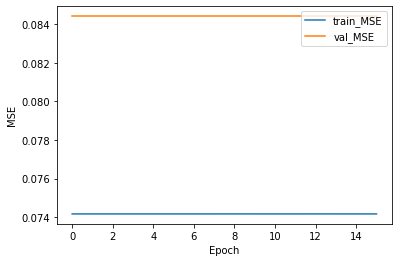

In [24]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Aunque no entrena mucho observamos que se obtiene un val_MSE = 0.0549  y un val_MAE=0.1928. Resultados prometedores

### Primer modelo de red neuronal convolucional: 3 capas convolucionales, una totalmente conectada y una de salida. Datos de entrada solamente de la radiación.

In [55]:
modeloc1 = models.Sequential()
modeloc1.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(9,9,3)))
#model.add(layers.MaxPooling2D((2, 2)))
modeloc1.add(layers.Conv2D(8, (3, 3), activation='relu'))
modeloc1.add(layers.Conv2D(8, (3, 3), activation='relu'))
modeloc1.add(layers.Flatten())
modeloc1.add(layers.Dense(15, activation='relu'))
modeloc1.add(layers.Dense(1, activation='relu'))
modeloc1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 8)           224       
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 8)           584       
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 8)           584       
                                                                 
 flatten (Flatten)           (None, 72)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                1095      
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 2,503
Trainable params: 2,503
Non-traina

In [56]:
modeloc1.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modeloc1.fit(X_train1est, y_train, epochs=1000,callbacks=[callback],validation_split=0.2)

Epoch 1/1000
3309/3309 [==============================] - 13s 4ms/step - loss: 0.0125 - mae: 0.0618 - val_loss: 0.0301 - val_mae: 0.1126
Epoch 2/1000
3309/3309 [==============================] - 12s 4ms/step - loss: 0.0120 - mae: 0.0601 - val_loss: 0.0298 - val_mae: 0.1113
Epoch 3/1000
3309/3309 [==============================] - 12s 4ms/step - loss: 0.0119 - mae: 0.0605 - val_loss: 0.0299 - val_mae: 0.1105
Epoch 4/1000
3309/3309 [==============================] - 12s 4ms/step - loss: 0.0119 - mae: 0.0604 - val_loss: 0.0327 - val_mae: 0.1191
Epoch 5/1000
3309/3309 [==============================] - 12s 4ms/step - loss: 0.0118 - mae: 0.0602 - val_loss: 0.0297 - val_mae: 0.1115
Epoch 6/1000
3309/3309 [==============================] - 12s 4ms/step - loss: 0.0118 - mae: 0.0602 - val_loss: 0.0328 - val_mae: 0.1148
Epoch 7/1000
3309/3309 [==============================] - 13s 4ms/step - loss: 0.0117 - mae: 0.0601 - val_loss: 0.0310 - val_mae: 0.1112
Epoch 8/1000
3309/3309 [=================

Text(0, 0.5, 'MSE')

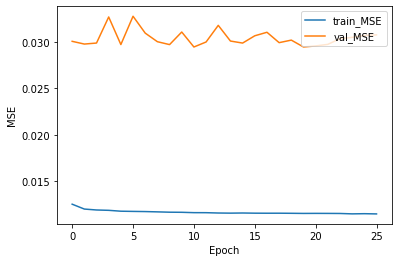

In [57]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Aunque no entrena mucho observamos que se obtiene un val_MSE =0.0295  y un val_MAE=val_mae: 0.1104. Mejora mucho respecto al anterior modelo

### Primer modelo de red neuronal convolucional: 3 capas convolucionales, una totalmente conectada y una de salida. Datos de entrada solamente de la radiación. Datos de día.

In [166]:
X_train1=np.array(datadia[0:len(datadia)-3:3,:,:,1:4]).astype(float)

X_train1std=np.std(X_train1) #tarda más de lo que parece en estos cálculos

X_train1est=X_train1/X_train1std 

y_train=np.array(PVOutputdia.iloc[1:len(PVOutputdia),5]).astype(float) 

In [167]:
modeloc1b = models.Sequential()
modeloc1b.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(9,9,3)))
#model.add(layers.MaxPooling2D((2, 2)))
modeloc1b.add(layers.Conv2D(8, (3, 3), activation='relu'))
modeloc1b.add(layers.Conv2D(8, (3, 3), activation='relu'))
modeloc1b.add(layers.Flatten())
modeloc1b.add(layers.Dense(15, activation='relu'))
modeloc1b.add(layers.Dense(1, activation='relu'))
modeloc1b.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 7, 7, 8)           224       
                                                                 
 conv2d_22 (Conv2D)          (None, 5, 5, 8)           584       
                                                                 
 conv2d_23 (Conv2D)          (None, 3, 3, 8)           584       
                                                                 
 flatten_7 (Flatten)         (None, 72)                0         
                                                                 
 dense_153 (Dense)           (None, 15)                1095      
                                                                 
 dense_154 (Dense)           (None, 1)                 16        
                                                                 
Total params: 2,503
Trainable params: 2,503
Non-traina

In [168]:
modeloc1b.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modeloc1b.fit(X_train1est, y_train, epochs=1000,callbacks=[callback],validation_split=0.2)

Epoch 1/1000
2218/2218 [==============================] - 18s 6ms/step - loss: 0.0639 - mae: 0.2168 - val_loss: 0.0691 - val_mae: 0.2269
Epoch 2/1000
2218/2218 [==============================] - 9s 4ms/step - loss: 0.0607 - mae: 0.2162 - val_loss: 0.0688 - val_mae: 0.2246
Epoch 3/1000
2218/2218 [==============================] - 9s 4ms/step - loss: 0.0601 - mae: 0.2147 - val_loss: 0.0673 - val_mae: 0.2267
Epoch 4/1000
2218/2218 [==============================] - 9s 4ms/step - loss: 0.0594 - mae: 0.2127 - val_loss: 0.0681 - val_mae: 0.2255
Epoch 5/1000
2218/2218 [==============================] - 8s 4ms/step - loss: 0.0592 - mae: 0.2123 - val_loss: 0.0679 - val_mae: 0.2270
Epoch 6/1000
2218/2218 [==============================] - 8s 4ms/step - loss: 0.0592 - mae: 0.2122 - val_loss: 0.0667 - val_mae: 0.2232
Epoch 7/1000
2218/2218 [==============================] - 8s 4ms/step - loss: 0.0591 - mae: 0.2120 - val_loss: 0.0673 - val_mae: 0.2246
Epoch 8/1000
2218/2218 [=======================

Text(0, 0.5, 'MSE')

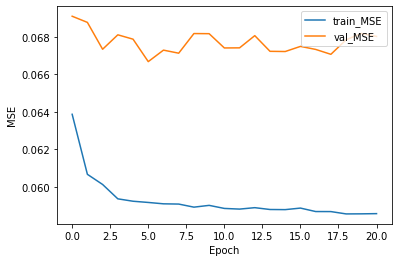

In [169]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Aunque no entrena mucho observamos que se obtiene un val_MSE =0.0667 y un val_MAE=0.2232.  Mejora mucho respecto al anterior modelo

### Modeloc2. Introducimos media de datos atmosféricos en la capa totalmente conectada.

In [63]:
(np.mean(data[0:len(data)-3:3,:,:,4:7], axis=(1,2))).shape

(132330, 3)

In [102]:
entrada1 = layers.Input(shape=(9,9,3))
entrada2 = layers.Input(shape=3)

conv1 = layers.Conv2D(8, (3, 3), activation='relu')(entrada1)
conv2 = layers.Conv2D(8, (3, 3), activation='relu')(conv1)
conv3 = layers.Conv2D(8, (3, 3), activation='relu')(conv2)

flat = layers.Flatten()(conv3)

oculta1 = layers.Dense(15, activation='relu')(flat)

dropout=layers.Dropout(0.2)(oculta1)


concat = layers.Concatenate()([entrada2,oculta1])

oculta2 = layers.Dense(8, activation='relu')(concat)

salida = layers.Dense(1, activation='relu')(oculta2)

modeloc2 = models.Model(inputs=[entrada1,entrada2],outputs=[salida])

In [78]:
'''
modeloc2 = models.Sequential()
modeloc2.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(9,9,3)))
#model.add(layers.MaxPooling2D((2, 2)))
modeloc2.add(layers.Conv2D(8, (3, 3), activation='relu'))
modeloc2.add(layers.Conv2D(8, (3, 3), activation='relu'))
modeloc2.add(layers.Conv2D(8, (3, 3), activation='relu'))
modeloc2.add(layers.Flatten())
modeloc2.add(layers.Dense(15, activation='relu',input_shape=(132330,3)))
modeloc2.add(layers.Dense(1, activation='relu'))
modeloc2.summary()
'''

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 7, 7, 8)           224       
                                                                 
 conv2d_20 (Conv2D)          (None, 5, 5, 8)           584       
                                                                 
 conv2d_21 (Conv2D)          (None, 3, 3, 8)           584       
                                                                 
 conv2d_22 (Conv2D)          (None, 1, 1, 8)           584       
                                                                 
 flatten_6 (Flatten)         (None, 8)                 0         
                                                                 
 dense_10 (Dense)            (None, 15)                135       
                                                                 
 dense_11 (Dense)            (None, 1)                

In [103]:
X_train1=np.array(data[19455:len(data)-4320-3:3,:,:,1:4]).astype(float)

X_train1std=np.std(X_train1) #tarda bastante en estos cálculos

X_train1est=X_train1/X_train1std 

y_train=np.array(PVOutputdf.iloc[1:len(PVOutputdf),5]).astype(float) 
X_trainatm=np.mean(data[0:len(data)-3:3,:,:,4:7], axis=(1,2)).astype(float) 
X_trainatmstd=np.std(X_trainatm)
X_trainatmest=X_trainatm/X_trainatmstd


In [104]:
modeloc2.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modeloc2.fit([X_train1est,X_trainatmest],  y_train, epochs=1000,callbacks=[callback],validation_split=0.2)

Epoch 1/1000
3110/3110 [==============================] - 40s 5ms/step - loss: 0.0178 - mae: 0.0771 - val_loss: 0.0324 - val_mae: 0.1174
Epoch 2/1000
3110/3110 [==============================] - 12s 4ms/step - loss: 0.0166 - mae: 0.0741 - val_loss: 0.0315 - val_mae: 0.1182
Epoch 3/1000
3110/3110 [==============================] - 12s 4ms/step - loss: 0.0162 - mae: 0.0735 - val_loss: 0.0324 - val_mae: 0.1184
Epoch 4/1000
3110/3110 [==============================] - 12s 4ms/step - loss: 0.0161 - mae: 0.0730 - val_loss: 0.0314 - val_mae: 0.1135
Epoch 5/1000
3110/3110 [==============================] - 12s 4ms/step - loss: 0.0161 - mae: 0.0729 - val_loss: 0.0321 - val_mae: 0.1169
Epoch 6/1000
3110/3110 [==============================] - 12s 4ms/step - loss: 0.0161 - mae: 0.0729 - val_loss: 0.0314 - val_mae: 0.1165
Epoch 7/1000
3110/3110 [==============================] - 12s 4ms/step - loss: 0.0161 - mae: 0.0728 - val_loss: 0.0315 - val_mae: 0.1146
Epoch 8/1000
3110/3110 [=================

Text(0, 0.5, 'MSE')

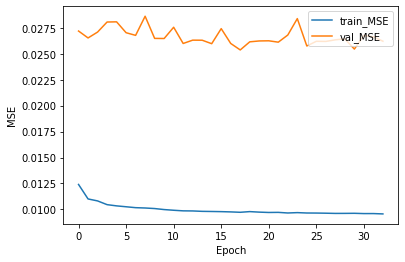

In [101]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Los resultados al añadir los datos atmosféricos en la capa que concatena mejoran, obteniéndose un val_MSE= 0.0254 y un val_MAE=0.1012 . Además, la red entrena más en validación que en los casos anteriores

### Modeloc2b. Introducimos media de datos atmosféricos en la capa totalmente conectada. Con datos solamente de día

In [170]:
entrada1 = layers.Input(shape=(9,9,3))
entrada2 = layers.Input(shape=3)

conv1 = layers.Conv2D(8, (3, 3), activation='relu')(entrada1)
conv2 = layers.Conv2D(8, (3, 3), activation='relu')(conv1)
conv3 = layers.Conv2D(8, (3, 3), activation='relu')(conv2)

flat = layers.Flatten()(conv3)

oculta1 = layers.Dense(15, activation='relu')(flat)

dropout=layers.Dropout(0.2)(oculta1)


concat = layers.Concatenate()([entrada2,oculta1])

oculta2 = layers.Dense(8, activation='relu')(concat)

salida = layers.Dense(1, activation='relu')(oculta2)

modeloc2b = models.Model(inputs=[entrada1,entrada2],outputs=[salida])

In [171]:
X_train1=np.array(datadia[:len(datadia)-3:3,:,:,1:4]).astype(float)

X_train1std=np.std(X_train1) #tarda bastante en estos cálculos

X_train1est=X_train1/X_train1std 

y_train=np.array(PVOutputdia.iloc[1:len(PVOutputdf),5]).astype(float) 
X_trainatm=np.mean(datadia[0:len(datadia)-3:3,:,:,4:7], axis=(1,2)).astype(float) 
X_trainatmstd=np.std(X_trainatm)
X_trainatmest=X_trainatm/X_trainatmstd


In [172]:
modeloc2b.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modeloc2b.fit([X_train1est,X_trainatmest],  y_train, epochs=1000,callbacks=[callback],validation_split=0.2)

Epoch 1/1000
2218/2218 [==============================] - 16s 6ms/step - loss: 0.0603 - mae: 0.2117 - val_loss: 0.0668 - val_mae: 0.2279
Epoch 2/1000
2218/2218 [==============================] - 9s 4ms/step - loss: 0.0591 - mae: 0.2111 - val_loss: 0.0675 - val_mae: 0.2286
Epoch 3/1000
2218/2218 [==============================] - 9s 4ms/step - loss: 0.0590 - mae: 0.2109 - val_loss: 0.0667 - val_mae: 0.2269
Epoch 4/1000
2218/2218 [==============================] - 9s 4ms/step - loss: 0.0589 - mae: 0.2106 - val_loss: 0.0672 - val_mae: 0.2257
Epoch 5/1000
2218/2218 [==============================] - 9s 4ms/step - loss: 0.0588 - mae: 0.2104 - val_loss: 0.0678 - val_mae: 0.2304
Epoch 6/1000
2218/2218 [==============================] - 8s 4ms/step - loss: 0.0587 - mae: 0.2103 - val_loss: 0.0672 - val_mae: 0.2243
Epoch 7/1000
2218/2218 [==============================] - 8s 4ms/step - loss: 0.0587 - mae: 0.2102 - val_loss: 0.0665 - val_mae: 0.2240
Epoch 8/1000
2218/2218 [=======================

Text(0, 0.5, 'MSE')

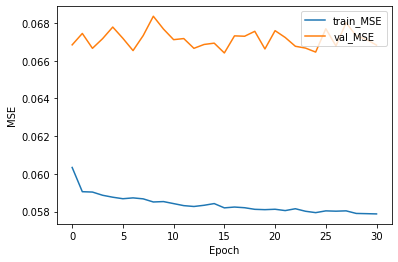

In [173]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MAE')

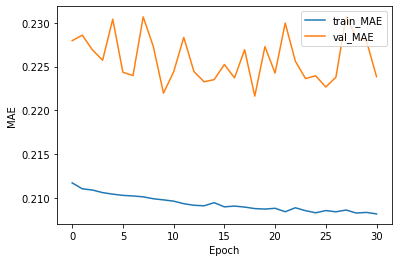

In [174]:
plt.plot(history.history['mae'], label='train_MAE')
plt.plot(history.history['val_mae'], label = 'val_MAE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MAE')

#### Se obtiene un val_MSE= 0.0664 y un val_MAE=0.2245 . Resultados mejores a los del artículo, por lo que la predicción mejora.

### Modeloc3. Introducimos media de datos atmosféricos en la capa totalmente conectada, sin tener en cuenta el viento, ya que hemos visto que no predecía bien.

In [105]:
entrada1 = layers.Input(shape=(9,9,3))
entrada2 = layers.Input(shape=2)

conv1 = layers.Conv2D(8, (3, 3), activation='relu')(entrada1)
conv2 = layers.Conv2D(8, (3, 3), activation='relu')(conv1)
conv3 = layers.Conv2D(8, (3, 3), activation='relu')(conv2)

flat = layers.Flatten()(conv3)

oculta1 = layers.Dense(15, activation='relu')(flat)

concat = layers.Concatenate()([entrada2,oculta1])

oculta2 = layers.Dense(8, activation='relu')(concat)

salida = layers.Dense(1, activation='relu')(oculta2)

modeloc3 = models.Model(inputs=[entrada1,entrada2],outputs=[salida])

In [103]:
X_trainatm=np.mean(data[0:len(data)-3:3,:,:,4:6], axis=(1,2)).astype(float) 
X_trainatmstd=np.std(X_trainatm)
X_trainatmest=X_trainatm/X_trainatmstd

In [106]:
modeloc3.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modeloc3.fit([X_train1est,X_trainatmest],  y_train, epochs=1000,callbacks=[callback],validation_split=0.2)

Epoch 1/1000
3309/3309 [==============================] - 16s 5ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 2/1000
3309/3309 [==============================] - 14s 4ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 3/1000
3309/3309 [==============================] - 14s 4ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 4/1000
3309/3309 [==============================] - 15s 4ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 5/1000
3309/3309 [==============================] - 15s 5ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 6/1000
3309/3309 [==============================] - 14s 4ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 7/1000
3309/3309 [==============================] - 14s 4ms/step - loss: 0.0742 - mae: 0.1489 - val_loss: 0.0844 - val_mae: 0.1640
Epoch 8/1000
3309/3309 [=================

Text(0, 0.5, 'MSE')

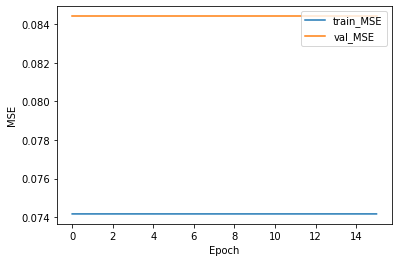

In [107]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### No entrena. Se obtiene un val_MSE=0.0844 y un val_MAE=0.1640. En este caso se observa que el viento sí que ayuda en las predicciones, el modelo no entrena.

### Modeloc4. Introducimos media de datos atmosféricos en la capa totalmente conectada y valor de la producción en los 30 minutos anteriores.

In [63]:
X_train1=np.array(data[3:len(data)-3:3,:,:,1:4]).astype(float)
X_train1std=np.std(X_train1) #tarda más de lo que parece en estos cálculos
X_train1est=X_train1/X_train1std 

X_trainatm=np.mean(data[3:len(data)-3:3,:,:,4:7], axis=(1,2)).astype(float) 
X_trainatmstd=np.std(X_trainatm)
X_trainatmest=X_trainatm/X_trainatmstd

X_prod1=np.array(PVOutputdf.iloc[1:len(PVOutputdf)-1,5]).astype(float) #Producción 15 minutos antes
X_prod2=np.array(PVOutputdf.iloc[0:len(PVOutputdf)-2,5]).astype(float) #Producción 30 minutos antes
X_prod=(X_prod1, X_prod2)

y_train=np.array(PVOutputdf.iloc[2:len(PVOutputdf),5]).astype(float) 

In [61]:
entrada1 = layers.Input(shape=(9,9,3))
entrada2 = layers.Input(shape=3)
entradaprod1=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat
entradaprod2=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat

conv1 = layers.Conv2D(8, (3, 3), activation='relu')(entrada1)
conv2 = layers.Conv2D(8, (3, 3), activation='relu')(conv1)
conv3 = layers.Conv2D(8, (3, 3), activation='relu')(conv2)

flat = layers.Flatten()(conv3)

oculta1 = layers.Dense(15, activation='relu')(flat)

concat = layers.Concatenate()([oculta1, entrada2, entradaprod1, entradaprod2])

oculta2 = layers.Dense(8, activation='relu')(concat)

salida = layers.Dense(1, activation='relu')(oculta2)

modeloc4 = models.Model(inputs=[entrada1,entrada2,entradaprod1, entradaprod2],outputs=[salida])

In [64]:
modeloc4.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modeloc4.fit([X_train1est,X_trainatmest, X_prod],  y_train, epochs=1000,callbacks=[callback],validation_split=0.2)

Epoch 1/1000
3309/3309 [==============================] - 20s 5ms/step - loss: 0.0032 - mae: 0.0249 - val_loss: 0.0025 - val_mae: 0.0244
Epoch 2/1000
3309/3309 [==============================] - 15s 4ms/step - loss: 0.0021 - mae: 0.0205 - val_loss: 0.0026 - val_mae: 0.0245
Epoch 3/1000
3309/3309 [==============================] - 12s 4ms/step - loss: 0.0021 - mae: 0.0204 - val_loss: 0.0026 - val_mae: 0.0252
Epoch 4/1000
3309/3309 [==============================] - 15s 4ms/step - loss: 0.0021 - mae: 0.0203 - val_loss: 0.0026 - val_mae: 0.0242
Epoch 5/1000
3309/3309 [==============================] - 15s 4ms/step - loss: 0.0021 - mae: 0.0203 - val_loss: 0.0030 - val_mae: 0.0270
Epoch 6/1000
3309/3309 [==============================] - 15s 4ms/step - loss: 0.0021 - mae: 0.0202 - val_loss: 0.0032 - val_mae: 0.0287
Epoch 7/1000
3309/3309 [==============================] - 15s 4ms/step - loss: 0.0021 - mae: 0.0202 - val_loss: 0.0027 - val_mae: 0.0258
Epoch 8/1000
3309/3309 [=================

Text(0, 0.5, 'MSE')

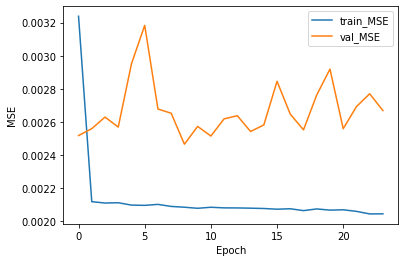

In [65]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

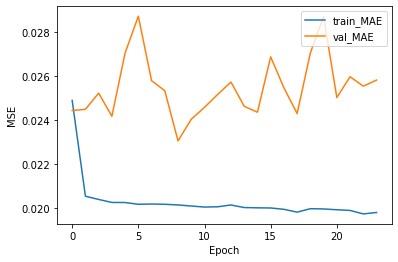

In [66]:
plt.plot(history.history['mae'], label='train_MAE')
plt.plot(history.history['val_mae'], label = 'val_MAE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

#### Se obtiene un MAE =0.0231  y un MSE=0.0027  sobre los datos de validación.

### Modeloc4b. Introducimos media de datos atmosféricos en la capa totalmente conectada y valor de la producción en los 30 minutos anteriores. Con datos durante el día.

In [161]:
X_train1=np.array(datadia[3:len(datadia)-3:3,:,:,1:4]).astype(float)
X_train1std=np.std(X_train1) #tarda más de lo que parece en estos cálculos
X_train1est=X_train1/X_train1std 

X_trainatm=np.mean(datadia[3:len(datadia)-3:3,:,:,4:7], axis=(1,2)).astype(float) 
X_trainatmstd=np.std(X_trainatm)
X_trainatmest=X_trainatm/X_trainatmstd

X_prod1=np.array(PVOutputdia.iloc[0:len(PVOutputdia)-2,5]).astype(float) #Producción 15 minutos antes
X_prod2=np.array(PVOutputdia.iloc[1:len(PVOutputdia)-1,5]).astype(float) #Producción 30 minutos antes
X_prod=(X_prod1, X_prod2)

y_train=np.array(PVOutputdia.iloc[2:len(PVOutputdia),5]).astype(float) 

In [162]:
entrada1 = layers.Input(shape=(9,9,3))
entrada2 = layers.Input(shape=3)
entradaprod1=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat
entradaprod2=tf.keras.layers.Input(shape=1) #la introducimos directamente en la capa concat

conv1 = layers.Conv2D(8, (3, 3), activation='relu')(entrada1)
conv2 = layers.Conv2D(8, (3, 3), activation='relu')(conv1)
conv3 = layers.Conv2D(8, (3, 3), activation='relu')(conv2)

flat = layers.Flatten()(conv3)

oculta1 = layers.Dense(15, activation='relu')(flat)

concat = layers.Concatenate()([oculta1, entrada2, entradaprod1, entradaprod2])

oculta2 = layers.Dense(8, activation='relu')(concat)

salida = layers.Dense(1, activation='relu')(oculta2)

modeloc4b = models.Model(inputs=[entrada1,entrada2,entradaprod1, entradaprod2],outputs=[salida])

In [163]:
modeloc4b.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)
history = modeloc4b.fit([X_train1est,X_trainatmest, X_prod],  y_train, epochs=1000,callbacks=[callback],validation_split=0.2)

Epoch 1/1000
2218/2218 [==============================] - 11s 4ms/step - loss: 0.0265 - mae: 0.0811 - val_loss: 0.0051 - val_mae: 0.0487
Epoch 2/1000
2218/2218 [==============================] - 9s 4ms/step - loss: 0.0037 - mae: 0.0355 - val_loss: 0.0045 - val_mae: 0.0378
Epoch 3/1000
2218/2218 [==============================] - 9s 4ms/step - loss: 0.0036 - mae: 0.0343 - val_loss: 0.0045 - val_mae: 0.0394
Epoch 4/1000
2218/2218 [==============================] - 8s 4ms/step - loss: 0.0036 - mae: 0.0343 - val_loss: 0.0045 - val_mae: 0.0390
Epoch 5/1000
2218/2218 [==============================] - 8s 4ms/step - loss: 0.0036 - mae: 0.0343 - val_loss: 0.0045 - val_mae: 0.0422
Epoch 6/1000
2218/2218 [==============================] - 8s 4ms/step - loss: 0.0036 - mae: 0.0342 - val_loss: 0.0045 - val_mae: 0.0381
Epoch 7/1000
2218/2218 [==============================] - 8s 4ms/step - loss: 0.0036 - mae: 0.0343 - val_loss: 0.0045 - val_mae: 0.0405
Epoch 8/1000
2218/2218 [=======================

Epoch 61/1000
2218/2218 [==============================] - 9s 4ms/step - loss: 0.0034 - mae: 0.0313 - val_loss: 0.0043 - val_mae: 0.0364
Epoch 62/1000
2218/2218 [==============================] - 8s 4ms/step - loss: 0.0034 - mae: 0.0312 - val_loss: 0.0044 - val_mae: 0.0372
Epoch 63/1000
2218/2218 [==============================] - 8s 4ms/step - loss: 0.0034 - mae: 0.0311 - val_loss: 0.0043 - val_mae: 0.0364
Epoch 64/1000
2218/2218 [==============================] - 8s 4ms/step - loss: 0.0034 - mae: 0.0313 - val_loss: 0.0043 - val_mae: 0.0359
Epoch 65/1000
2218/2218 [==============================] - 8s 4ms/step - loss: 0.0034 - mae: 0.0312 - val_loss: 0.0043 - val_mae: 0.0356
Epoch 66/1000
2218/2218 [==============================] - 8s 4ms/step - loss: 0.0034 - mae: 0.0312 - val_loss: 0.0043 - val_mae: 0.0359
Epoch 67/1000
2218/2218 [==============================] - 8s 4ms/step - loss: 0.0034 - mae: 0.0313 - val_loss: 0.0043 - val_mae: 0.0364
Epoch 68/1000
2218/2218 [================

Text(0, 0.5, 'MSE')

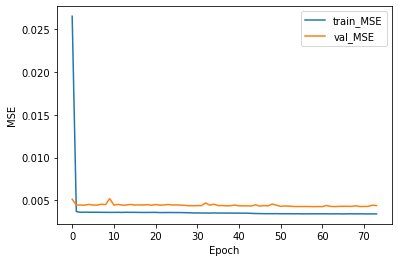

In [164]:
plt.plot(history.history['loss'], label='train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MAE')

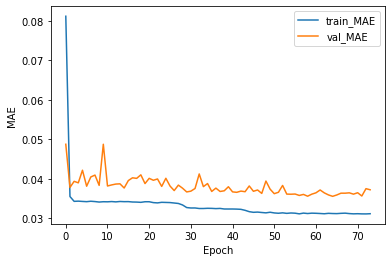

In [165]:
plt.plot(history.history['mae'], label='train_MAE')
plt.plot(history.history['val_mae'], label = 'val_MAE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MAE')

#### Se obtiene un MSE =0.0043 y un MAE=0.0356 sobre los datos de validación. Mejores resultados

### Red 3D

In [ ]:
infile = open("MURCIA3434_20150101_20201231_L0","rb")
data_l0 = pickle.load(infile)
data_l0 = np.reshape(data_l0,(data_l0.shape[0],1,data_l0.shape[1],data_l0.shape[2],data_l0.shape[3]))
data_3D_l0 = np.concatenate((data_l0[:-2,:,:,:,:],data_l0[1:-1,:,:,:,:],data_l0[2:,:,:,:,:]),axis=1)
train_data_3D_l0=data_3D_l0[:40000]/std_data
val_data_3D_l0=data_3D_l0[40000:]/std_data
train_labels_3D =labels[2:40002]
val_labels_3D =labels[40002:]

model3D = models.Sequential()
model3D.add(layers.Conv3D(8, (2, 3, 3), activation='relu', input_shape=(3, 34, 34, 2)))
model3D.add(layers.MaxPooling3D((1, 2, 2)))
model3D.add(layers.Conv3D(8, (2, 3, 3), activation='relu'))
model3D.add(layers.MaxPooling3D((1, 2, 2)))
model3D.add(layers.Conv2D(8, (3, 3), activation='relu'))
model3D.add(layers.Flatten())
model3D.add(layers.Dense(20, activation='relu'))
model3D.add(layers.Dense(10, activation='relu'))
model3D.add(layers.Dense(1, activation='relu'))
model3D.summary()


In [ ]:
X_train1=data[1:len(data)-14:3,:,:,:3]#Dejo el primer dato fuera para tener la producción 15 mins despues. 
X_train2=data[2:len(data)-13:3,:,:,:3] #Tengo datos de radiación de 13:20-14:15 e introduzco producción a las 14:30.
X_train3=data[3:len(data)-12:3,:,:,:3] #Tomo datos de 3 en 3 para tener la producción cada 15 minutos
X_train4=data[4:len(data)-11:3,:,:,:3]
X_train5=data[5:len(data)-10:3,:,:,:3]
X_train6=data[6:len(data)-9:3,:,:,:3]
X_train7=data[7:len(data)-8:3,:,:,:3] 
X_train8=data[8:len(data)-7:3,:,:,:3]
X_train9=data[9:len(data)-6:3,:,:,:3]
X_train10=data[10:len(data)-5:3,:,:,:3]
X_train11=data[11:len(data)-4:3,:,:,:3]
X_train12=data[12:len(data)-3:3,:,:,:3]

X_train1std=np.std(X_train1)
X_train2std=np.std(X_train2) 
X_train3std=np.std(X_train3) 
X_train4std=np.std(X_train4)
X_train5std=np.std(X_train5)
X_train6std=np.std(X_train6) 
X_train7std=np.std(X_train7) 
X_train8std=np.std(X_train8)
X_train9std=np.std(X_train9)
X_train10std=np.std(X_train10) 
X_train11std=np.std(X_train11) 
X_train12std=np.std(X_train12)

X_train1est=X_train1/X_train1std 
X_train2est=X_train2/X_train2std 
X_train3est=X_train3/X_train3std 
X_train4est=X_train4/X_train4std
X_train5est=X_train5/X_train5std 
X_train6est=X_train6/X_train6std 
X_train7est=X_train7/X_train7std 
X_train8est=X_train8/X_train8std
X_train9est=X_train9/X_train9std 
X_train10est=X_train10/X_train10std 
X_train11est=X_train11/X_train11std 
X_train12est=X_train12/X_train12std
X_trainest=(X_train1est,X_train2est,X_train3est,X_train4est,X_train5est,X_train6est,X_train7est,X_train8est,X_train9est,X_train10est,X_train11est,X_train12est)

y_train=np.array(PVOutputdf.iloc[5:len(PVOutputdf),5]).astype(float) 